In [1]:
%pylab inline
import pandas as pd
import sys
import gc
import os
import lightgbm as lgb

Populating the interactive namespace from numpy and matplotlib


In [2]:
FOLD=int(os.getenv("FOLD"))

In [3]:
print FOLD

4


In [4]:
sys.path.insert(0,"../python/rrvf2017/")

In [5]:
from rrvf_data import   DataGen, normalize
import rrvf_data

In [6]:
def get_index(cols,columns):
    lst=[]
    for c in cols:
        lst.append(np.where(columns==c)[0][0])
    return np.array(lst)

In [7]:
def read_data(offset):
    columns,data=rrvf_data.read_data( offset,"../input/train_test_extb.npy.npz")
    rawy=data[:,:,get_index(['visitors'],columns)[0]].copy()
    print len(columns),data.shape,rawy.shape    
    return columns,data,rawy

In [8]:
gc.collect()

7

# cv

In [9]:
n_reg_lookback=7
n_lookforward=1
n_offset=0

In [10]:
lag_cols=array(['visitor_ma28', 'visitor_ma56', 'visitor_ma14', 'visitor_ma112', 'visitor_ma224', 
                'visitor_ma7', 'visitor_sma8', 'visitor_sma4', 'visitor_sma3', 'visitor_sma16', 
                'visitor_sma2', 'visitor_ma4', 'visitor_ma2', 'visitors', 'visitor_lag7', 
                'visitor_lag14', 'visitor_lag28', 'visitor_lag91', 'visitor_lag182', 'geo2_visitors_mean', 
                'station_visitors_mean', 'geo2_count_y1', 'all_count_y1', 'geo1_visitors_mean', 'all_count_y3', 
                'station_count_y3', 'station_count_y4',
               's16_y_nan', 's16_y_std', 's16_y1_ratio', 's16_y2_ratio',
               'bad_ratio'])
len(lag_cols)

32

In [11]:
def make_ondate_train_test(ondate_cols,data,columns):
    ondate_train_test=np.round(data[:,:,get_index(ondate_cols,columns)].copy(),2)
    ondate_train_test=normalize(ondate_train_test)
    v=np.zeros_like(ondate_train_test[:,:,0])
    for i in range(v.shape[0]): v[i]=i
    #ondate_train_test = np.concatenate([np.expand_dims(v,-1),ondate_train_test],axis=-1)
    print ondate_train_test.shape
    return ondate_train_test

In [12]:
ondate_cols =array(['const_one', 'visitor_lag91', 'visitor_lag182', 'TMIN', 'holiday', 'TAVG','f_t',
                    'weekday6', 'weekday5', 'weekday4', 'weekday3', 'weekday2', 'weekday1', 'weekday0',
                    'rv_sum', 'rv_mean', 'rv_gap_mean', 'rv_gap_weighted_mean'
                   ])

In [13]:
def make_lag_train_test(lag_cols,data,columns):
    lag_train_test=data[:,:,get_index(lag_cols,columns)].copy()
    #lag_train_test=normalize(lag_train_test)
    print lag_train_test.shape
    return lag_train_test

In [14]:
from sklearn.model_selection import GridSearchCV,ParameterGrid,ParameterSampler
from sklearn.metrics import  make_scorer
from multiprocessing import Pool

# time split

In [15]:
import cPickle as pickle
indexes=rrvf_data.get_train_valid_indexes()

In [16]:
def make_Xy(data_from_gen):
    print data_from_gen[0]['ondatex'].shape,data_from_gen[0]['lagx'].shape,data_from_gen[0]['masky'].shape,data_from_gen[1].shape
    X=np.concatenate([data_from_gen[0]['ondatex'].reshape([data_from_gen[0]['ondatex'].shape[0],-1]),
                    data_from_gen[0]['lagx'].reshape([data_from_gen[0]['lagx'].shape[0],-1])],axis=1)
    y=np.squeeze(data_from_gen[1])
    mask=np.squeeze(data_from_gen[0]['masky'].reshape([data_from_gen[0]['masky'].shape[0],-1]))
    print X.shape,y.shape,mask.shape
    mask= (mask>0) & (y>0)
    X=X[mask]
    y=y[mask]
    dataidx=data_from_gen[3][mask]
    assert X.shape[0]==y.shape[0]
    return X,y,dataidx

In [17]:
from sklearn.metrics import mean_squared_error
def make_model(i, trainX,trainy, validX,validy, colsample_bytree=1,num_leaves=31,subsample=1,
               learning_rate=0.03,max_bin=127,
               min_data_in_leaf=20,lambda_l2=0,
               min_sum_hessian_in_leaf=1e-3, C=0.001,
               objective='binary' ):
        models=[]
        scores=[]
        d_train = lgb.Dataset(trainX, label=trainy,categorical_feature=[0])
        d_valid = lgb.Dataset(validX, label=validy,categorical_feature=[0])
        
        if 1:
            params = {
                'task': 'train',
                'boosting_type': 'gbdt',
                'objective': objective,
                'metric': {'rmse'},
                'num_leaves':num_leaves,
                'learning_rate': learning_rate,
                'feature_fraction': colsample_bytree,
                'bagging_fraction': subsample,
                'min_data_in_leaf': min_data_in_leaf,
                'min_sum_hessian_in_leaf': min_sum_hessian_in_leaf,
                'lambda_l2': lambda_l2,
                'max_bin': max_bin,
                'bagging_freq': 5,
                'nthread': 8,
                'verbose': 0,
                'metric_freq': 50,
                'train_metric': True
            }
            print str(params)
            gbm = lgb.train(params,
                            d_train,
                            num_boost_round=1000,
                            valid_sets=d_valid,
                            early_stopping_rounds=50)

            models.append(gbm)
            validpred=gbm.predict(validX,num_iteration=gbm.best_iteration)
            scores.append(mean_squared_error(validy,validpred))
            print mean_squared_error(trainy,gbm.predict(trainX,num_iteration=gbm.best_iteration)), scores[-1]
        print scores
        print i, "mean score", np.mean(scores)
        return models[0],np.mean(scores),validpred
        #return np.mean(scores) 

In [18]:
def f(iparam,trainX,trainy,validX,validy):
    i,param=iparam
    return make_model(i,trainX,trainy,validX,validy, **param)

In [19]:
import rrvf_data
def g(model,testX,testy,testidx,n_offset):
    test_pred=model.predict(testX,num_iteration=model.best_iteration)    
    df=pd.DataFrame({'y':testy})
    df['pred']=test_pred
    df['dayidx']=testidx[:,1]+n_offset
    df=df.loc[df['y']>0]
    df['error']=df['y']-df['pred']
    df['error2']=df['error']**2
    df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)
    df2=df.groupby("dayidx").mean() 
    df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())
    print df2['error2'].mean()
    display(df2)
    return  df2['error2'].mean()

def g2(model,train_gen,offset):
    predlist=[]
    ylist=[]
    daylist=[]
    for i in range(7):
        i=478-7+i-offset
        Xdict,y,dataidx,_=train_gen.get_by_t2(day=i)
        X=np.concatenate([Xdict['ondatex'].reshape([Xdict['ondatex'].shape[0],-1]),
                    Xdict['lagx'].reshape([Xdict['lagx'].shape[0],-1])],axis=1)
        pred=model.predict(X,num_iteration=model.best_iteration).reshape(-1)
        predlist.append(pred)
        daylist.append(np.zeros_like(pred,dtype=int)+i+offset)
        ylist.append(y.reshape(-1))
    ylist=np.concatenate(ylist)
    predlist=np.concatenate(predlist)
    daylist=np.concatenate(daylist)
    df=pd.DataFrame({'y':ylist,'dayidx':daylist,'pred':predlist})
    df=df.loc[df['y']>0]
    df['error']=df['y']-df['pred']
    df['error2']=df['error']**2
    df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)
    df2=df.groupby("dayidx").mean() 
    df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())
    print df2['error2'].mean()
    display(df2)
    return  df2['error2'].mean()

PRED_DATE=478
def h(model,train_gen):
    Xdict,_,dataidx,_=train_gen.get_by_t2(day=PRED_DATE)
    X=np.concatenate([Xdict['ondatex'].reshape([Xdict['ondatex'].shape[0],-1]),
                    Xdict['lagx'].reshape([Xdict['lagx'].shape[0],-1])],axis=1)
    #mask=np.squeeze(Xdict['masky'].reshape([Xdict.shape[0],-1]))
    print X.shape
    pred=model.predict(X,num_iteration=model.best_iteration)
    return pred,dataidx


In [20]:
parameter={'colsample_bytree': 0.5,
 'lambda_l2': 1,
 'learning_rate': 0.05,
 'max_bin': 255,
 'min_data_in_leaf': 30,
 'min_sum_hessian_in_leaf': 0.001,
 'num_leaves': 127,
 'objective': 'regression',
 'subsample': 0.8}

In [21]:
EXCLUDE_HARD=False
def _run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    assert n_offset+1==n_lookforward
    batchsize=128
    ondate_train_test=make_ondate_train_test(ondate_cols,data,columns)
    lag_train_test = make_lag_train_test(lag_cols,data,columns)
    train_gen=rrvf_data.DataGen(lag_train_test,ondate_train_test, rawy,n_reg_lookback+1, 478,#478-1*7-39-n_offset, 
                      batchsize=batchsize,valid_split=0.1, indexes=index,lookforward_offset=n_offset,
                      exclude_hard=EXCLUDE_HARD,
                  lookback1=n_reg_lookback,  lookforward=n_lookforward, excluded_days=None)
    valid_gen=None
    test_gen=rrvf_data.DataGen(lag_train_test,ondate_train_test, rawy,478-1*7-n_offset,478, lookforward_offset=n_offset,
                     batchsize=batchsize,lookback1=n_reg_lookback, lookforward=n_lookforward)
    print train_gen.train_steps_per_epoch
    print 0 if valid_gen is None else valid_gen.train_steps_per_epoch
    
    train_data_from_gen=train_gen.get_train()
    trainX,trainy,_=make_Xy(train_data_from_gen)
    valid_data_from_gen=train_gen.get_valid()
    validX,validy,valididx=make_Xy(valid_data_from_gen)
    test_data_from_gen=test_gen.get_train()
    testX,testy,testidx=make_Xy(test_data_from_gen)

    model,score,validpred=f((-1,parameter),trainX,trainy,validX,validy)
    g(model,testX,testy,testidx,n_offset)
    g2(model,train_gen,n_offset)
    
    pred478=h(model,train_gen)
    return score,(validy,valididx,validpred),pred478

def run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    return _run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset)        

In [22]:
def MSE(a,b):
    idx= np.isnan(a) | np.isnan(b)
    a=a[~idx]
    b=b[~idx]
    #print np.mean(~idx)
    return np.mean((a-b)**2)
    return mean_squared_error(a,b)

In [23]:
j=FOLD
validpreds={}
for offset in range(1,40):
    print "\n\n",offset
    columns,data,rawy=read_data(offset=offset)
    _,validpred,pred478=run_once(columns,data,rawy, indexes[j],ondate_cols,lag_cols,n_lookforward=offset,n_offset=offset-1)
    validpreds[offset]=[validpred,pred478]
    pickle.dump(validpreds, open('3001_lgb_fold{}_{}_d{}.pkl'.format(j, EXCLUDE_HARD, PRED_DATE),'wb'))



1


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 14.8043


(829, 517, 18)
(829, 517, 32)


train/valid # (312080, 2) (77550, 2)


train/valid # (199787, 2) (50953, 2)
train/valid # (199787, 2) (50953, 2)


rand split across time
train has 199787 records out of 389630 records
valid has 50953 records out of 389630 records
train has 5803 records out of 5803 records
no valid set
1560
0


(199787, 1, 18) (199787, 7, 32) (199787, 1) (199787, 1)
(199787, 242) (199787,) (199787,)


(50953, 1, 18) (50953, 7, 32) (50953, 1) (50953, 1)
(50953, 242) (50953,) (50953,)
(5803, 1, 18) (5803, 7, 32) (5803, 1) (5803, 1)
(5803, 242) (5803,) (5803,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  
/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/lightgbm/basic.py:1027: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/lightgbm/basic.py:668: UserWarning: categorical_feature in param dict is overrided.
  warnings.warn('categorical_feature in param dict is overrided.')


[1]	valid_0's rmse: 0.782527
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.761637


[3]	valid_0's rmse: 0.741799


[4]	valid_0's rmse: 0.723468


[5]	valid_0's rmse: 0.70678


[6]	valid_0's rmse: 0.691152


[7]	valid_0's rmse: 0.676079


[8]	valid_0's rmse: 0.662205


[9]	valid_0's rmse: 0.649923


[10]	valid_0's rmse: 0.638043


[11]	valid_0's rmse: 0.627113


[12]	valid_0's rmse: 0.617287


[13]	valid_0's rmse: 0.60816


[14]	valid_0's rmse: 0.599961


[15]	valid_0's rmse: 0.592329


[16]	valid_0's rmse: 0.585231


[17]	valid_0's rmse: 0.578639


[18]	valid_0's rmse: 0.572308


[19]	valid_0's rmse: 0.566502


[20]	valid_0's rmse: 0.561229


[21]	valid_0's rmse: 0.556307


[22]	valid_0's rmse: 0.55193


[23]	valid_0's rmse: 0.54782


[24]	valid_0's rmse: 0.544158


[25]	valid_0's rmse: 0.540763


[26]	valid_0's rmse: 0.53776


[27]	valid_0's rmse: 0.534947


[28]	valid_0's rmse: 0.532293


[29]	valid_0's rmse: 0.529812


[30]	valid_0's rmse: 0.527579


[31]	valid_0's rmse: 0.525538


[32]	valid_0's rmse: 0.523619


[33]	valid_0's rmse: 0.52181


[34]	valid_0's rmse: 0.520236


[35]	valid_0's rmse: 0.518777


[36]	valid_0's rmse: 0.517423


[37]	valid_0's rmse: 0.516058


[38]	valid_0's rmse: 0.514867


[39]	valid_0's rmse: 0.513645
[40]	valid_0's rmse: 0.51256


[41]	valid_0's rmse: 0.511526


[42]	valid_0's rmse: 0.510626
[43]	valid_0's rmse: 0.509753


[44]	valid_0's rmse: 0.509019
[45]	valid_0's rmse: 0.508245


[46]	valid_0's rmse: 0.507621


[47]	valid_0's rmse: 0.506995


[48]	valid_0's rmse: 0.506452
[49]	valid_0's rmse: 0.505923


[50]	valid_0's rmse: 0.505419


[51]	valid_0's rmse: 0.504941
[52]	valid_0's rmse: 0.504499


[53]	valid_0's rmse: 0.504152
[54]	valid_0's rmse: 0.503807


[55]	valid_0's rmse: 0.50346


[56]	valid_0's rmse: 0.503079
[57]	valid_0's rmse: 0.502765


[58]	valid_0's rmse: 0.502454
[59]	valid_0's rmse: 0.502154


[60]	valid_0's rmse: 0.501869


[61]	valid_0's rmse: 0.501543
[62]	valid_0's rmse: 0.501319


[63]	valid_0's rmse: 0.501103
[64]	valid_0's rmse: 0.500893


[65]	valid_0's rmse: 0.500664
[66]	valid_0's rmse: 0.500498


[67]	valid_0's rmse: 0.500342
[68]	valid_0's rmse: 0.500146


[69]	valid_0's rmse: 0.499944
[70]	valid_0's rmse: 0.499727


[71]	valid_0's rmse: 0.499506
[72]	valid_0's rmse: 0.499313


[73]	valid_0's rmse: 0.499117
[74]	valid_0's rmse: 0.498942


[75]	valid_0's rmse: 0.498755
[76]	valid_0's rmse: 0.498627


[77]	valid_0's rmse: 0.498437
[78]	valid_0's rmse: 0.498252


[79]	valid_0's rmse: 0.498113
[80]	valid_0's rmse: 0.497964


[81]	valid_0's rmse: 0.497866
[82]	valid_0's rmse: 0.497777


[83]	valid_0's rmse: 0.497658
[84]	valid_0's rmse: 0.497579


[85]	valid_0's rmse: 0.497489
[86]	valid_0's rmse: 0.497397


[87]	valid_0's rmse: 0.497246
[88]	valid_0's rmse: 0.497135


[89]	valid_0's rmse: 0.496996
[90]	valid_0's rmse: 0.496902


[91]	valid_0's rmse: 0.496681
[92]	valid_0's rmse: 0.4965


[93]	valid_0's rmse: 0.496397
[94]	valid_0's rmse: 0.496295


[95]	valid_0's rmse: 0.496207
[96]	valid_0's rmse: 0.496177


[97]	valid_0's rmse: 0.496041
[98]	valid_0's rmse: 0.495869


[99]	valid_0's rmse: 0.495785
[100]	valid_0's rmse: 0.495738


[101]	valid_0's rmse: 0.495715
[102]	valid_0's rmse: 0.495641


[103]	valid_0's rmse: 0.495508
[104]	valid_0's rmse: 0.495431


[105]	valid_0's rmse: 0.495375
[106]	valid_0's rmse: 0.495292


[107]	valid_0's rmse: 0.495244
[108]	valid_0's rmse: 0.495233


[109]	valid_0's rmse: 0.495151
[110]	valid_0's rmse: 0.495086


[111]	valid_0's rmse: 0.49504
[112]	valid_0's rmse: 0.495012


[113]	valid_0's rmse: 0.494908
[114]	valid_0's rmse: 0.494871


[115]	valid_0's rmse: 0.494867
[116]	valid_0's rmse: 0.494837


[117]	valid_0's rmse: 0.49477
[118]	valid_0's rmse: 0.494673


[119]	valid_0's rmse: 0.494536
[120]	valid_0's rmse: 0.494531


[121]	valid_0's rmse: 0.494466
[122]	valid_0's rmse: 0.494463


[123]	valid_0's rmse: 0.494473
[124]	valid_0's rmse: 0.494443


[125]	valid_0's rmse: 0.494424
[126]	valid_0's rmse: 0.494421


[127]	valid_0's rmse: 0.494323
[128]	valid_0's rmse: 0.49432


[129]	valid_0's rmse: 0.494272
[130]	valid_0's rmse: 0.494239


[131]	valid_0's rmse: 0.494209
[132]	valid_0's rmse: 0.494206


[133]	valid_0's rmse: 0.494188
[134]	valid_0's rmse: 0.49419


[135]	valid_0's rmse: 0.494184
[136]	valid_0's rmse: 0.494138


[137]	valid_0's rmse: 0.494095
[138]	valid_0's rmse: 0.49403


[139]	valid_0's rmse: 0.494019
[140]	valid_0's rmse: 0.494031


[141]	valid_0's rmse: 0.49396
[142]	valid_0's rmse: 0.493961


[143]	valid_0's rmse: 0.493966
[144]	valid_0's rmse: 0.493954


[145]	valid_0's rmse: 0.493907
[146]	valid_0's rmse: 0.493889


[147]	valid_0's rmse: 0.493789
[148]	valid_0's rmse: 0.493749


[149]	valid_0's rmse: 0.493731
[150]	valid_0's rmse: 0.49371


[151]	valid_0's rmse: 0.493663
[152]	valid_0's rmse: 0.49364


[153]	valid_0's rmse: 0.493572
[154]	valid_0's rmse: 0.493517


[155]	valid_0's rmse: 0.493512
[156]	valid_0's rmse: 0.493449


[157]	valid_0's rmse: 0.493454
[158]	valid_0's rmse: 0.493445


[159]	valid_0's rmse: 0.493461
[160]	valid_0's rmse: 0.493454


[161]	valid_0's rmse: 0.493433
[162]	valid_0's rmse: 0.493411


[163]	valid_0's rmse: 0.493407
[164]	valid_0's rmse: 0.493373


[165]	valid_0's rmse: 0.493344
[166]	valid_0's rmse: 0.493285


[167]	valid_0's rmse: 0.493278
[168]	valid_0's rmse: 0.493286


[169]	valid_0's rmse: 0.493275
[170]	valid_0's rmse: 0.493264


[171]	valid_0's rmse: 0.49324
[172]	valid_0's rmse: 0.493214


[173]	valid_0's rmse: 0.493228
[174]	valid_0's rmse: 0.493223


[175]	valid_0's rmse: 0.493202
[176]	valid_0's rmse: 0.493207


[177]	valid_0's rmse: 0.493177
[178]	valid_0's rmse: 0.49318


[179]	valid_0's rmse: 0.493162
[180]	valid_0's rmse: 0.493145


[181]	valid_0's rmse: 0.493122
[182]	valid_0's rmse: 0.493131


[183]	valid_0's rmse: 0.493115
[184]	valid_0's rmse: 0.493097


[185]	valid_0's rmse: 0.493091
[186]	valid_0's rmse: 0.493073


[187]	valid_0's rmse: 0.493056
[188]	valid_0's rmse: 0.493032


[189]	valid_0's rmse: 0.493004
[190]	valid_0's rmse: 0.492988


[191]	valid_0's rmse: 0.493002
[192]	valid_0's rmse: 0.492991


[193]	valid_0's rmse: 0.492977
[194]	valid_0's rmse: 0.492979
[195]	valid_0's rmse: 0.492991


[196]	valid_0's rmse: 0.492972
[197]	valid_0's rmse: 0.492977


[198]	valid_0's rmse: 0.49296
[199]	valid_0's rmse: 0.49293


[200]	valid_0's rmse: 0.492885
[201]	valid_0's rmse: 0.492878


[202]	valid_0's rmse: 0.492867
[203]	valid_0's rmse: 0.492873


[204]	valid_0's rmse: 0.492843
[205]	valid_0's rmse: 0.4928


[206]	valid_0's rmse: 0.492798
[207]	valid_0's rmse: 0.492775


[208]	valid_0's rmse: 0.492781
[209]	valid_0's rmse: 0.492763


[210]	valid_0's rmse: 0.492749
[211]	valid_0's rmse: 0.492744


[212]	valid_0's rmse: 0.492723
[213]	valid_0's rmse: 0.492742


[214]	valid_0's rmse: 0.492736
[215]	valid_0's rmse: 0.492714


[216]	valid_0's rmse: 0.4927
[217]	valid_0's rmse: 0.492707


[218]	valid_0's rmse: 0.492683
[219]	valid_0's rmse: 0.492703


[220]	valid_0's rmse: 0.492696
[221]	valid_0's rmse: 0.492652


[222]	valid_0's rmse: 0.492653
[223]	valid_0's rmse: 0.492636


[224]	valid_0's rmse: 0.49263
[225]	valid_0's rmse: 0.492613


[226]	valid_0's rmse: 0.492587
[227]	valid_0's rmse: 0.492593
[228]	valid_0's rmse: 0.49259


[229]	valid_0's rmse: 0.492572


[230]	valid_0's rmse: 0.492616
[231]	valid_0's rmse: 0.492615


[232]	valid_0's rmse: 0.492593
[233]	valid_0's rmse: 0.492593


[234]	valid_0's rmse: 0.492557
[235]	valid_0's rmse: 0.492551


[236]	valid_0's rmse: 0.492555
[237]	valid_0's rmse: 0.492559


[238]	valid_0's rmse: 0.492548
[239]	valid_0's rmse: 0.492542


[240]	valid_0's rmse: 0.492536
[241]	valid_0's rmse: 0.492548


[242]	valid_0's rmse: 0.492529
[243]	valid_0's rmse: 0.492523


[244]	valid_0's rmse: 0.492523
[245]	valid_0's rmse: 0.492517


[246]	valid_0's rmse: 0.492518
[247]	valid_0's rmse: 0.492543


[248]	valid_0's rmse: 0.492527
[249]	valid_0's rmse: 0.492535


[250]	valid_0's rmse: 0.492542
[251]	valid_0's rmse: 0.492536


[252]	valid_0's rmse: 0.492545
[253]	valid_0's rmse: 0.492533


[254]	valid_0's rmse: 0.492501
[255]	valid_0's rmse: 0.492515


[256]	valid_0's rmse: 0.492497
[257]	valid_0's rmse: 0.492495


[258]	valid_0's rmse: 0.492512
[259]	valid_0's rmse: 0.492528


[260]	valid_0's rmse: 0.492542
[261]	valid_0's rmse: 0.492534


[262]	valid_0's rmse: 0.492548
[263]	valid_0's rmse: 0.492538


[264]	valid_0's rmse: 0.492538
[265]	valid_0's rmse: 0.492529


[266]	valid_0's rmse: 0.492507
[267]	valid_0's rmse: 0.49252


[268]	valid_0's rmse: 0.492523
[269]	valid_0's rmse: 0.492528


[270]	valid_0's rmse: 0.492515
[271]	valid_0's rmse: 0.492491


[272]	valid_0's rmse: 0.492494
[273]	valid_0's rmse: 0.492494


[274]	valid_0's rmse: 0.492463
[275]	valid_0's rmse: 0.492476


[276]	valid_0's rmse: 0.492481
[277]	valid_0's rmse: 0.492484


[278]	valid_0's rmse: 0.492487
[279]	valid_0's rmse: 0.492488


[280]	valid_0's rmse: 0.492455
[281]	valid_0's rmse: 0.492454


[282]	valid_0's rmse: 0.492461
[283]	valid_0's rmse: 0.492458


[284]	valid_0's rmse: 0.492475
[285]	valid_0's rmse: 0.492463


[286]	valid_0's rmse: 0.492435
[287]	valid_0's rmse: 0.492428


[288]	valid_0's rmse: 0.492413
[289]	valid_0's rmse: 0.492414


[290]	valid_0's rmse: 0.49242
[291]	valid_0's rmse: 0.492414


[292]	valid_0's rmse: 0.492385
[293]	valid_0's rmse: 0.492378


[294]	valid_0's rmse: 0.492382
[295]	valid_0's rmse: 0.492389


[296]	valid_0's rmse: 0.492405
[297]	valid_0's rmse: 0.492397


[298]	valid_0's rmse: 0.492394
[299]	valid_0's rmse: 0.492398


[300]	valid_0's rmse: 0.492388
[301]	valid_0's rmse: 0.492404


[302]	valid_0's rmse: 0.492391
[303]	valid_0's rmse: 0.492392
[304]	valid_0's rmse: 0.492385


[305]	valid_0's rmse: 0.492386
[306]	valid_0's rmse: 0.492389


[307]	valid_0's rmse: 0.492398
[308]	valid_0's rmse: 0.492369


[309]	valid_0's rmse: 0.492365
[310]	valid_0's rmse: 0.492369


[311]	valid_0's rmse: 0.49237
[312]	valid_0's rmse: 0.492357


[313]	valid_0's rmse: 0.49236
[314]	valid_0's rmse: 0.492355


[315]	valid_0's rmse: 0.492357
[316]	valid_0's rmse: 0.492348


[317]	valid_0's rmse: 0.49233
[318]	valid_0's rmse: 0.492311


[319]	valid_0's rmse: 0.49229
[320]	valid_0's rmse: 0.492288


[321]	valid_0's rmse: 0.492282
[322]	valid_0's rmse: 0.492296


[323]	valid_0's rmse: 0.49227
[324]	valid_0's rmse: 0.49226


[325]	valid_0's rmse: 0.492251
[326]	valid_0's rmse: 0.492243


[327]	valid_0's rmse: 0.492227
[328]	valid_0's rmse: 0.492205


[329]	valid_0's rmse: 0.492202
[330]	valid_0's rmse: 0.492202


[331]	valid_0's rmse: 0.4922
[332]	valid_0's rmse: 0.492214


[333]	valid_0's rmse: 0.492211
[334]	valid_0's rmse: 0.492206
[335]	valid_0's rmse: 0.492189


[336]	valid_0's rmse: 0.492154
[337]	valid_0's rmse: 0.49215


[338]	valid_0's rmse: 0.492149
[339]	valid_0's rmse: 0.492155


[340]	valid_0's rmse: 0.492153
[341]	valid_0's rmse: 0.492136


[342]	valid_0's rmse: 0.492145
[343]	valid_0's rmse: 0.492138


[344]	valid_0's rmse: 0.492138
[345]	valid_0's rmse: 0.49214


[346]	valid_0's rmse: 0.49212
[347]	valid_0's rmse: 0.492133
[348]	valid_0's rmse: 0.492131


[349]	valid_0's rmse: 0.492112
[350]	valid_0's rmse: 0.492115
[351]	valid_0's rmse: 0.492125


[352]	valid_0's rmse: 0.492135
[353]	valid_0's rmse: 0.492114


[354]	valid_0's rmse: 0.492126
[355]	valid_0's rmse: 0.492111


[356]	valid_0's rmse: 0.492094
[357]	valid_0's rmse: 0.492097


[358]	valid_0's rmse: 0.492114
[359]	valid_0's rmse: 0.492129
[360]	valid_0's rmse: 0.492142


[361]	valid_0's rmse: 0.492175
[362]	valid_0's rmse: 0.492171


[363]	valid_0's rmse: 0.492152
[364]	valid_0's rmse: 0.492144
[365]	valid_0's rmse: 0.492151


[366]	valid_0's rmse: 0.492156
[367]	valid_0's rmse: 0.492155


[368]	valid_0's rmse: 0.492144
[369]	valid_0's rmse: 0.492143
[370]	valid_0's rmse: 0.492126


[371]	valid_0's rmse: 0.492111
[372]	valid_0's rmse: 0.492104
[373]	valid_0's rmse: 0.492094


[374]	valid_0's rmse: 0.492073
[375]	valid_0's rmse: 0.49207


[376]	valid_0's rmse: 0.492093
[377]	valid_0's rmse: 0.492078
[378]	valid_0's rmse: 0.492078


[379]	valid_0's rmse: 0.492075
[380]	valid_0's rmse: 0.49205


[381]	valid_0's rmse: 0.492043
[382]	valid_0's rmse: 0.492053


[383]	valid_0's rmse: 0.492042
[384]	valid_0's rmse: 0.492033


[385]	valid_0's rmse: 0.49205
[386]	valid_0's rmse: 0.492048


[387]	valid_0's rmse: 0.492056
[388]	valid_0's rmse: 0.492036


[389]	valid_0's rmse: 0.49203
[390]	valid_0's rmse: 0.492043


[391]	valid_0's rmse: 0.49204
[392]	valid_0's rmse: 0.49204


[393]	valid_0's rmse: 0.492026
[394]	valid_0's rmse: 0.492028


[395]	valid_0's rmse: 0.492021
[396]	valid_0's rmse: 0.49202


[397]	valid_0's rmse: 0.492031
[398]	valid_0's rmse: 0.492047


[399]	valid_0's rmse: 0.492062
[400]	valid_0's rmse: 0.492078
[401]	valid_0's rmse: 0.492074


[402]	valid_0's rmse: 0.492075
[403]	valid_0's rmse: 0.492075


[404]	valid_0's rmse: 0.49208
[405]	valid_0's rmse: 0.492077


[406]	valid_0's rmse: 0.492073
[407]	valid_0's rmse: 0.492079


[408]	valid_0's rmse: 0.492081
[409]	valid_0's rmse: 0.492067


[410]	valid_0's rmse: 0.492056
[411]	valid_0's rmse: 0.49207


[412]	valid_0's rmse: 0.492074
[413]	valid_0's rmse: 0.492063


[414]	valid_0's rmse: 0.492075
[415]	valid_0's rmse: 0.492064


[416]	valid_0's rmse: 0.492073
[417]	valid_0's rmse: 0.49207
[418]	valid_0's rmse: 0.492084


[419]	valid_0's rmse: 0.492096
[420]	valid_0's rmse: 0.492089


[421]	valid_0's rmse: 0.492077
[422]	valid_0's rmse: 0.492065


[423]	valid_0's rmse: 0.492062
[424]	valid_0's rmse: 0.492081
[425]	valid_0's rmse: 0.492088


[426]	valid_0's rmse: 0.492088
[427]	valid_0's rmse: 0.492079
[428]	valid_0's rmse: 0.492091


[429]	valid_0's rmse: 0.492082
[430]	valid_0's rmse: 0.492093


[431]	valid_0's rmse: 0.4921
[432]	valid_0's rmse: 0.492082


[433]	valid_0's rmse: 0.492104
[434]	valid_0's rmse: 0.49213
[435]	valid_0's rmse: 0.492149


[436]	valid_0's rmse: 0.492131
[437]	valid_0's rmse: 0.492143
[438]	valid_0's rmse: 0.492139


[439]	valid_0's rmse: 0.49213
[440]	valid_0's rmse: 0.492145


[441]	valid_0's rmse: 0.492134
[442]	valid_0's rmse: 0.492138


[443]	valid_0's rmse: 0.492139
[444]	valid_0's rmse: 0.492135


[445]	valid_0's rmse: 0.492136
[446]	valid_0's rmse: 0.492141
Early stopping, best iteration is:
[396]	valid_0's rmse: 0.49202


0.180884756909 0.242083670137
[0.24208367013694629]
-1 mean score 0.242083670137


0.168918495715


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.912458  0.016652  0.179196    7  2017-04-16
472     2.507290  2.543467 -0.036177  0.174619    1  2017-04-17
473     2.661330  2.651027  0.010302  0.206405    2  2017-04-18
474     2.754815  2.736372  0.018443  0.159634    3  2017-04-19
475     2.713762  2.704908  0.008854  0.186431    4  2017-04-20
476     2.999000  2.992686  0.006314  0.129828    5  2017-04-21
477     3.075529  3.088508 -0.012979  0.146316    6  2017-04-22

0.168918495715


pred         y     error    error2  day        date
dayidx                                                         
471     2.912458  2.929110  0.016652  0.179196    7  2017-04-16
472     2.543467  2.507290 -0.036177  0.174619    1  2017-04-17
473     2.651027  2.661330  0.010302  0.206405    2  2017-04-18
474     2.736372  2.754815  0.018443  0.159634    3  2017-04-19
475     2.704908  2.713762  0.008854  0.186431    4  2017-04-20
476     2.992686  2.999000  0.006314  0.129828    5  2017-04-21
477     3.088508  3.075529 -0.012979  0.146316    6  2017-04-22

(829, 242)




2


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 14.8043


(829, 517, 18)
(829, 517, 32)


train/valid # (312080, 2) (77550, 2)


train/valid # (199787, 2) (50953, 2)
train/valid # (199787, 2) (50953, 2)


rand split across time
train has 199787 records out of 389630 records
valid has 50953 records out of 389630 records
train has 6632 records out of 6632 records
no valid set
1560
0


(199787, 1, 18) (199787, 7, 32) (199787, 1) (199787, 1)
(199787, 242) (199787,) (199787,)


(50953, 1, 18) (50953, 7, 32) (50953, 1) (50953, 1)
(50953, 242) (50953,) (50953,)
(6632, 1, 18) (6632, 7, 32) (6632, 1) (6632, 1)
(6632, 242) (6632,) (6632,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.774953
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.753565


[3]	valid_0's rmse: 0.733745


[4]	valid_0's rmse: 0.715318


[5]	valid_0's rmse: 0.698185


[6]	valid_0's rmse: 0.682847


[7]	valid_0's rmse: 0.668516


[8]	valid_0's rmse: 0.654904


[9]	valid_0's rmse: 0.642306


[10]	valid_0's rmse: 0.63062


[11]	valid_0's rmse: 0.620146


[12]	valid_0's rmse: 0.610381


[13]	valid_0's rmse: 0.601007


[14]	valid_0's rmse: 0.592554


[15]	valid_0's rmse: 0.584844


[16]	valid_0's rmse: 0.577655


[17]	valid_0's rmse: 0.570954


[18]	valid_0's rmse: 0.564719
[19]	valid_0's rmse: 0.559007


[20]	valid_0's rmse: 0.553845


[21]	valid_0's rmse: 0.549065


[22]	valid_0's rmse: 0.544852


[23]	valid_0's rmse: 0.540783
[24]	valid_0's rmse: 0.537143

[25]	valid_0's rmse: 0.533849


[26]	valid_0's rmse: 0.53084
[27]	valid_0's rmse: 0.527996


[28]	valid_0's rmse: 0.52541
[29]	valid_0's rmse: 0.522904


[30]	valid_0's rmse: 0.520653


[31]	valid_0's rmse: 0.518525
[32]	valid_0's rmse: 0.516618


[33]	valid_0's rmse: 0.514822
[34]	valid_0's rmse: 0.513243


[35]	valid_0's rmse: 0.511757


[36]	valid_0's rmse: 0.510426
[37]	valid_0's rmse: 0.509116


[38]	valid_0's rmse: 0.507882
[39]	valid_0's rmse: 0.506807


[40]	valid_0's rmse: 0.50576
[41]	valid_0's rmse: 0.504768


[42]	valid_0's rmse: 0.503964
[43]	valid_0's rmse: 0.50315


[44]	valid_0's rmse: 0.502303
[45]	valid_0's rmse: 0.501622


[46]	valid_0's rmse: 0.501033
[47]	valid_0's rmse: 0.500417


[48]	valid_0's rmse: 0.499838
[49]	valid_0's rmse: 0.499268


[50]	valid_0's rmse: 0.498696
[51]	valid_0's rmse: 0.498266


[52]	valid_0's rmse: 0.497771
[53]	valid_0's rmse: 0.497431


[54]	valid_0's rmse: 0.497018
[55]	valid_0's rmse: 0.496638


[56]	valid_0's rmse: 0.496242
[57]	valid_0's rmse: 0.495878


[58]	valid_0's rmse: 0.495596
[59]	valid_0's rmse: 0.49534


[60]	valid_0's rmse: 0.495072
[61]	valid_0's rmse: 0.494767


[62]	valid_0's rmse: 0.494498
[63]	valid_0's rmse: 0.49426


[64]	valid_0's rmse: 0.493997
[65]	valid_0's rmse: 0.493697


[66]	valid_0's rmse: 0.493476
[67]	valid_0's rmse: 0.493276


[68]	valid_0's rmse: 0.493057
[69]	valid_0's rmse: 0.492904


[70]	valid_0's rmse: 0.492689
[71]	valid_0's rmse: 0.492515


[72]	valid_0's rmse: 0.49226
[73]	valid_0's rmse: 0.49207


[74]	valid_0's rmse: 0.491908
[75]	valid_0's rmse: 0.491791


[76]	valid_0's rmse: 0.491587
[77]	valid_0's rmse: 0.491459


[78]	valid_0's rmse: 0.491298
[79]	valid_0's rmse: 0.491123


[80]	valid_0's rmse: 0.490959
[81]	valid_0's rmse: 0.490822


[82]	valid_0's rmse: 0.490666
[83]	valid_0's rmse: 0.490534


[84]	valid_0's rmse: 0.490417
[85]	valid_0's rmse: 0.490257


[86]	valid_0's rmse: 0.490068
[87]	valid_0's rmse: 0.489978


[88]	valid_0's rmse: 0.489854
[89]	valid_0's rmse: 0.489779


[90]	valid_0's rmse: 0.489701
[91]	valid_0's rmse: 0.489569


[92]	valid_0's rmse: 0.489338
[93]	valid_0's rmse: 0.489251


[94]	valid_0's rmse: 0.48911
[95]	valid_0's rmse: 0.489045


[96]	valid_0's rmse: 0.488895
[97]	valid_0's rmse: 0.488781


[98]	valid_0's rmse: 0.488625
[99]	valid_0's rmse: 0.488525


[100]	valid_0's rmse: 0.488466
[101]	valid_0's rmse: 0.488304


[102]	valid_0's rmse: 0.488192
[103]	valid_0's rmse: 0.488094


[104]	valid_0's rmse: 0.487965
[105]	valid_0's rmse: 0.487936


[106]	valid_0's rmse: 0.487755
[107]	valid_0's rmse: 0.487627


[108]	valid_0's rmse: 0.487573
[109]	valid_0's rmse: 0.487524


[110]	valid_0's rmse: 0.487423
[111]	valid_0's rmse: 0.487289


[112]	valid_0's rmse: 0.487169
[113]	valid_0's rmse: 0.487135


[114]	valid_0's rmse: 0.487061
[115]	valid_0's rmse: 0.486953


[116]	valid_0's rmse: 0.48693
[117]	valid_0's rmse: 0.486906


[118]	valid_0's rmse: 0.486792
[119]	valid_0's rmse: 0.486718


[120]	valid_0's rmse: 0.486672
[121]	valid_0's rmse: 0.486665


[122]	valid_0's rmse: 0.48663
[123]	valid_0's rmse: 0.486562


[124]	valid_0's rmse: 0.486461
[125]	valid_0's rmse: 0.486424


[126]	valid_0's rmse: 0.486366
[127]	valid_0's rmse: 0.486359


[128]	valid_0's rmse: 0.486328
[129]	valid_0's rmse: 0.486282


[130]	valid_0's rmse: 0.486256
[131]	valid_0's rmse: 0.486187


[132]	valid_0's rmse: 0.486118
[133]	valid_0's rmse: 0.486089


[134]	valid_0's rmse: 0.486076
[135]	valid_0's rmse: 0.486028


[136]	valid_0's rmse: 0.486004
[137]	valid_0's rmse: 0.485963


[138]	valid_0's rmse: 0.485932
[139]	valid_0's rmse: 0.485871


[140]	valid_0's rmse: 0.485851
[141]	valid_0's rmse: 0.485849


[142]	valid_0's rmse: 0.485831
[143]	valid_0's rmse: 0.485799


[144]	valid_0's rmse: 0.485815
[145]	valid_0's rmse: 0.4858


[146]	valid_0's rmse: 0.485739
[147]	valid_0's rmse: 0.485673


[148]	valid_0's rmse: 0.485617
[149]	valid_0's rmse: 0.485558


[150]	valid_0's rmse: 0.485532
[151]	valid_0's rmse: 0.485506


[152]	valid_0's rmse: 0.485511
[153]	valid_0's rmse: 0.485494


[154]	valid_0's rmse: 0.485462
[155]	valid_0's rmse: 0.485392


[156]	valid_0's rmse: 0.485375
[157]	valid_0's rmse: 0.48534


[158]	valid_0's rmse: 0.485296
[159]	valid_0's rmse: 0.485283


[160]	valid_0's rmse: 0.485239
[161]	valid_0's rmse: 0.485215


[162]	valid_0's rmse: 0.485171
[163]	valid_0's rmse: 0.485113


[164]	valid_0's rmse: 0.485085
[165]	valid_0's rmse: 0.485051


[166]	valid_0's rmse: 0.485031
[167]	valid_0's rmse: 0.48501


[168]	valid_0's rmse: 0.485016
[169]	valid_0's rmse: 0.485006


[170]	valid_0's rmse: 0.484988
[171]	valid_0's rmse: 0.484964


[172]	valid_0's rmse: 0.484939
[173]	valid_0's rmse: 0.48492


[174]	valid_0's rmse: 0.4849
[175]	valid_0's rmse: 0.48491


[176]	valid_0's rmse: 0.484904
[177]	valid_0's rmse: 0.484911


[178]	valid_0's rmse: 0.484908
[179]	valid_0's rmse: 0.484905


[180]	valid_0's rmse: 0.48491
[181]	valid_0's rmse: 0.484904


[182]	valid_0's rmse: 0.484889
[183]	valid_0's rmse: 0.48489


[184]	valid_0's rmse: 0.484876
[185]	valid_0's rmse: 0.484865


[186]	valid_0's rmse: 0.484857
[187]	valid_0's rmse: 0.484852
[188]	valid_0's rmse: 0.484861


[189]	valid_0's rmse: 0.484868
[190]	valid_0's rmse: 0.484856


[191]	valid_0's rmse: 0.484859
[192]	valid_0's rmse: 0.484862


[193]	valid_0's rmse: 0.484884
[194]	valid_0's rmse: 0.48489


[195]	valid_0's rmse: 0.484883
[196]	valid_0's rmse: 0.484873


[197]	valid_0's rmse: 0.484866
[198]	valid_0's rmse: 0.484877


[199]	valid_0's rmse: 0.484862
[200]	valid_0's rmse: 0.484846


[201]	valid_0's rmse: 0.484849
[202]	valid_0's rmse: 0.484827
[203]	valid_0's rmse: 0.484822


[204]	valid_0's rmse: 0.484828
[205]	valid_0's rmse: 0.48481


[206]	valid_0's rmse: 0.484773
[207]	valid_0's rmse: 0.484762


[208]	valid_0's rmse: 0.484773
[209]	valid_0's rmse: 0.484752
[210]	valid_0's rmse: 0.484768


[211]	valid_0's rmse: 0.484794
[212]	valid_0's rmse: 0.484802


[213]	valid_0's rmse: 0.484792
[214]	valid_0's rmse: 0.484783


[215]	valid_0's rmse: 0.484808
[216]	valid_0's rmse: 0.484786


[217]	valid_0's rmse: 0.484781
[218]	valid_0's rmse: 0.484777


[219]	valid_0's rmse: 0.484765
[220]	valid_0's rmse: 0.484752


[221]	valid_0's rmse: 0.484736
[222]	valid_0's rmse: 0.48474


[223]	valid_0's rmse: 0.484717
[224]	valid_0's rmse: 0.484723


[225]	valid_0's rmse: 0.484719
[226]	valid_0's rmse: 0.484706


[227]	valid_0's rmse: 0.484703
[228]	valid_0's rmse: 0.484701


[229]	valid_0's rmse: 0.484689
[230]	valid_0's rmse: 0.484693


[231]	valid_0's rmse: 0.484676
[232]	valid_0's rmse: 0.484694


[233]	valid_0's rmse: 0.484671
[234]	valid_0's rmse: 0.484678


[235]	valid_0's rmse: 0.484671
[236]	valid_0's rmse: 0.484658


[237]	valid_0's rmse: 0.484661
[238]	valid_0's rmse: 0.484642
[239]	valid_0's rmse: 0.484651


[240]	valid_0's rmse: 0.484645
[241]	valid_0's rmse: 0.484654


[242]	valid_0's rmse: 0.484661
[243]	valid_0's rmse: 0.484654


[244]	valid_0's rmse: 0.484655
[245]	valid_0's rmse: 0.484661


[246]	valid_0's rmse: 0.484664
[247]	valid_0's rmse: 0.484666


[248]	valid_0's rmse: 0.484652
[249]	valid_0's rmse: 0.484637


[250]	valid_0's rmse: 0.484608
[251]	valid_0's rmse: 0.484594


[252]	valid_0's rmse: 0.484582
[253]	valid_0's rmse: 0.484585


[254]	valid_0's rmse: 0.484602
[255]	valid_0's rmse: 0.484581


[256]	valid_0's rmse: 0.484559
[257]	valid_0's rmse: 0.484549


[258]	valid_0's rmse: 0.484531
[259]	valid_0's rmse: 0.484512


[260]	valid_0's rmse: 0.484477
[261]	valid_0's rmse: 0.484472


[262]	valid_0's rmse: 0.484457
[263]	valid_0's rmse: 0.484473
[264]	valid_0's rmse: 0.48447


[265]	valid_0's rmse: 0.484459
[266]	valid_0's rmse: 0.484456


[267]	valid_0's rmse: 0.484444
[268]	valid_0's rmse: 0.484449
[269]	valid_0's rmse: 0.484452


[270]	valid_0's rmse: 0.484445
[271]	valid_0's rmse: 0.484432
[272]	valid_0's rmse: 0.484408


[273]	valid_0's rmse: 0.48442
[274]	valid_0's rmse: 0.484406


[275]	valid_0's rmse: 0.484387
[276]	valid_0's rmse: 0.484386
[277]	valid_0's rmse: 0.484389


[278]	valid_0's rmse: 0.484352
[279]	valid_0's rmse: 0.484344


[280]	valid_0's rmse: 0.48435
[281]	valid_0's rmse: 0.484358


[282]	valid_0's rmse: 0.484366
[283]	valid_0's rmse: 0.484382


[284]	valid_0's rmse: 0.48438
[285]	valid_0's rmse: 0.484358


[286]	valid_0's rmse: 0.484374
[287]	valid_0's rmse: 0.484386


[288]	valid_0's rmse: 0.484414
[289]	valid_0's rmse: 0.484407


[290]	valid_0's rmse: 0.484398
[291]	valid_0's rmse: 0.484389


[292]	valid_0's rmse: 0.484391
[293]	valid_0's rmse: 0.48441


[294]	valid_0's rmse: 0.484418
[295]	valid_0's rmse: 0.484417


[296]	valid_0's rmse: 0.484399
[297]	valid_0's rmse: 0.484395
[298]	valid_0's rmse: 0.484412


[299]	valid_0's rmse: 0.48443


[300]	valid_0's rmse: 0.484423
[301]	valid_0's rmse: 0.484418


[302]	valid_0's rmse: 0.484421
[303]	valid_0's rmse: 0.484425
[304]	valid_0's rmse: 0.484393


[305]	valid_0's rmse: 0.484417
[306]	valid_0's rmse: 0.484395


[307]	valid_0's rmse: 0.484396
[308]	valid_0's rmse: 0.484385


[309]	valid_0's rmse: 0.484385
[310]	valid_0's rmse: 0.484377


[311]	valid_0's rmse: 0.484386
[312]	valid_0's rmse: 0.484389
[313]	valid_0's rmse: 0.48439


[314]	valid_0's rmse: 0.484373
[315]	valid_0's rmse: 0.484359


[316]	valid_0's rmse: 0.484386
[317]	valid_0's rmse: 0.484386
[318]	valid_0's rmse: 0.484387


[319]	valid_0's rmse: 0.484369
[320]	valid_0's rmse: 0.484373


[321]	valid_0's rmse: 0.484349
[322]	valid_0's rmse: 0.484381


[323]	valid_0's rmse: 0.484389
[324]	valid_0's rmse: 0.484387


[325]	valid_0's rmse: 0.48439
[326]	valid_0's rmse: 0.484405


[327]	valid_0's rmse: 0.484418
[328]	valid_0's rmse: 0.484413


[329]	valid_0's rmse: 0.484416
Early stopping, best iteration is:
[279]	valid_0's rmse: 0.484344


0.189383486537 0.234588732547
[0.23458873254665441]
-1 mean score 0.234588732547
0.187331490163


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.893706  0.035404  0.192372    7  2017-04-16
472     2.507290  2.536105 -0.028814  0.202770    1  2017-04-17
473     2.661330  2.653170  0.008159  0.224663    2  2017-04-18
474     2.754815  2.733062  0.021753  0.178397    3  2017-04-19
475     2.713762  2.705648  0.008114  0.206297    4  2017-04-20
476     2.999000  3.005176 -0.006176  0.140949    5  2017-04-21
477     3.075529  3.088974 -0.013445  0.165873    6  2017-04-22

0.187331490163


pred         y     error    error2  day        date
dayidx                                                         
471     2.893706  2.929110  0.035404  0.192372    7  2017-04-16
472     2.536105  2.507290 -0.028814  0.202770    1  2017-04-17
473     2.653170  2.661330  0.008159  0.224663    2  2017-04-18
474     2.733062  2.754815  0.021753  0.178397    3  2017-04-19
475     2.705648  2.713762  0.008114  0.206297    4  2017-04-20
476     3.005176  2.999000 -0.006176  0.140949    5  2017-04-21
477     3.088974  3.075529 -0.013445  0.165873    6  2017-04-22

(829, 242)




3


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 14.8043


(829, 517, 18)
(829, 517, 32)


train/valid # (312080, 2) (77550, 2)


train/valid # (199787, 2) (50953, 2)
train/valid # (199787, 2) (50953, 2)


rand split across time
train has 199787 records out of 389630 records
valid has 50953 records out of 389630 records
train has 7461 records out of 7461 records
no valid set
1560
0


(199787, 1, 18) (199787, 7, 32) (199787, 1) (199787, 1)
(199787, 242) (199787,) (199787,)


(50953, 1, 18) (50953, 7, 32) (50953, 1) (50953, 1)
(50953, 242) (50953,) (50953,)
(7461, 1, 18) (7461, 7, 32) (7461, 1) (7461, 1)
(7461, 242) (7461,) (7461,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.779158
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.757911


[3]	valid_0's rmse: 0.73855


[4]	valid_0's rmse: 0.720423


[5]	valid_0's rmse: 0.703588


[6]	valid_0's rmse: 0.687557


[7]	valid_0's rmse: 0.67316


[8]	valid_0's rmse: 0.659426


[9]	valid_0's rmse: 0.646937


[10]	valid_0's rmse: 0.635559


[11]	valid_0's rmse: 0.624628


[12]	valid_0's rmse: 0.614627


[13]	valid_0's rmse: 0.60531


[14]	valid_0's rmse: 0.597006


[15]	valid_0's rmse: 0.589299


[16]	valid_0's rmse: 0.582227


[17]	valid_0's rmse: 0.5755
[18]	valid_0's rmse: 0.569343


[19]	valid_0's rmse: 0.563886
[20]	valid_0's rmse: 0.558958


[21]	valid_0's rmse: 0.554116
[22]	valid_0's rmse: 0.549849


[23]	valid_0's rmse: 0.545693
[24]	valid_0's rmse: 0.541906


[25]	valid_0's rmse: 0.538443


[26]	valid_0's rmse: 0.535414
[27]	valid_0's rmse: 0.532532


[28]	valid_0's rmse: 0.52987
[29]	valid_0's rmse: 0.527323


[30]	valid_0's rmse: 0.525136


[31]	valid_0's rmse: 0.523043
[32]	valid_0's rmse: 0.521063


[33]	valid_0's rmse: 0.519387
[34]	valid_0's rmse: 0.517739


[35]	valid_0's rmse: 0.516334
[36]	valid_0's rmse: 0.515004


[37]	valid_0's rmse: 0.513719
[38]	valid_0's rmse: 0.512486


[39]	valid_0's rmse: 0.511386
[40]	valid_0's rmse: 0.510416


[41]	valid_0's rmse: 0.509495
[42]	valid_0's rmse: 0.508629


[43]	valid_0's rmse: 0.50784
[44]	valid_0's rmse: 0.507036


[45]	valid_0's rmse: 0.506351
[46]	valid_0's rmse: 0.505794


[47]	valid_0's rmse: 0.505232
[48]	valid_0's rmse: 0.50469


[49]	valid_0's rmse: 0.504134
[50]	valid_0's rmse: 0.503653


[51]	valid_0's rmse: 0.503207
[52]	valid_0's rmse: 0.502809


[53]	valid_0's rmse: 0.502426
[54]	valid_0's rmse: 0.502052


[55]	valid_0's rmse: 0.501642
[56]	valid_0's rmse: 0.50125


[57]	valid_0's rmse: 0.500944
[58]	valid_0's rmse: 0.500681


[59]	valid_0's rmse: 0.500444
[60]	valid_0's rmse: 0.50014


[61]	valid_0's rmse: 0.499867
[62]	valid_0's rmse: 0.499625


[63]	valid_0's rmse: 0.499379
[64]	valid_0's rmse: 0.499193


[65]	valid_0's rmse: 0.498989
[66]	valid_0's rmse: 0.498761


[67]	valid_0's rmse: 0.498561
[68]	valid_0's rmse: 0.498389


[69]	valid_0's rmse: 0.498214
[70]	valid_0's rmse: 0.498061


[71]	valid_0's rmse: 0.497873
[72]	valid_0's rmse: 0.497672


[73]	valid_0's rmse: 0.497483
[74]	valid_0's rmse: 0.497338


[75]	valid_0's rmse: 0.497137
[76]	valid_0's rmse: 0.497012


[77]	valid_0's rmse: 0.496868
[78]	valid_0's rmse: 0.496683


[79]	valid_0's rmse: 0.496518
[80]	valid_0's rmse: 0.496399


[81]	valid_0's rmse: 0.496287
[82]	valid_0's rmse: 0.496137


[83]	valid_0's rmse: 0.496109
[84]	valid_0's rmse: 0.495992


[85]	valid_0's rmse: 0.495861
[86]	valid_0's rmse: 0.495653


[87]	valid_0's rmse: 0.495504
[88]	valid_0's rmse: 0.495386


[89]	valid_0's rmse: 0.495274
[90]	valid_0's rmse: 0.495209


[91]	valid_0's rmse: 0.495058
[92]	valid_0's rmse: 0.494968


[93]	valid_0's rmse: 0.494774
[94]	valid_0's rmse: 0.494664


[95]	valid_0's rmse: 0.494597
[96]	valid_0's rmse: 0.494544


[97]	valid_0's rmse: 0.494461
[98]	valid_0's rmse: 0.494364


[99]	valid_0's rmse: 0.494276
[100]	valid_0's rmse: 0.494182


[101]	valid_0's rmse: 0.494043
[102]	valid_0's rmse: 0.493986


[103]	valid_0's rmse: 0.493957
[104]	valid_0's rmse: 0.49384


[105]	valid_0's rmse: 0.493787
[106]	valid_0's rmse: 0.493654


[107]	valid_0's rmse: 0.493624
[108]	valid_0's rmse: 0.493623


[109]	valid_0's rmse: 0.493582
[110]	valid_0's rmse: 0.493569


[111]	valid_0's rmse: 0.493455
[112]	valid_0's rmse: 0.493332


[113]	valid_0's rmse: 0.493245
[114]	valid_0's rmse: 0.49318


[115]	valid_0's rmse: 0.493053
[116]	valid_0's rmse: 0.493021


[117]	valid_0's rmse: 0.492944
[118]	valid_0's rmse: 0.49291


[119]	valid_0's rmse: 0.492881
[120]	valid_0's rmse: 0.492834


[121]	valid_0's rmse: 0.492787
[122]	valid_0's rmse: 0.492771


[123]	valid_0's rmse: 0.492789
[124]	valid_0's rmse: 0.492661


[125]	valid_0's rmse: 0.4926
[126]	valid_0's rmse: 0.492531


[127]	valid_0's rmse: 0.492482
[128]	valid_0's rmse: 0.492465


[129]	valid_0's rmse: 0.492428
[130]	valid_0's rmse: 0.492448


[131]	valid_0's rmse: 0.492379
[132]	valid_0's rmse: 0.49234


[133]	valid_0's rmse: 0.492272
[134]	valid_0's rmse: 0.492235


[135]	valid_0's rmse: 0.492157
[136]	valid_0's rmse: 0.492113


[137]	valid_0's rmse: 0.492028
[138]	valid_0's rmse: 0.491967


[139]	valid_0's rmse: 0.491938
[140]	valid_0's rmse: 0.491905


[141]	valid_0's rmse: 0.491861
[142]	valid_0's rmse: 0.491812


[143]	valid_0's rmse: 0.491764
[144]	valid_0's rmse: 0.491727


[145]	valid_0's rmse: 0.491744
[146]	valid_0's rmse: 0.491671


[147]	valid_0's rmse: 0.491644
[148]	valid_0's rmse: 0.491621


[149]	valid_0's rmse: 0.491538
[150]	valid_0's rmse: 0.491461


[151]	valid_0's rmse: 0.491393
[152]	valid_0's rmse: 0.491372


[153]	valid_0's rmse: 0.49135
[154]	valid_0's rmse: 0.491345


[155]	valid_0's rmse: 0.491316
[156]	valid_0's rmse: 0.491298


[157]	valid_0's rmse: 0.491276
[158]	valid_0's rmse: 0.491232


[159]	valid_0's rmse: 0.491243
[160]	valid_0's rmse: 0.491229


[161]	valid_0's rmse: 0.491189
[162]	valid_0's rmse: 0.491106


[163]	valid_0's rmse: 0.491092
[164]	valid_0's rmse: 0.491086


[165]	valid_0's rmse: 0.49109
[166]	valid_0's rmse: 0.49107


[167]	valid_0's rmse: 0.491083
[168]	valid_0's rmse: 0.491081


[169]	valid_0's rmse: 0.491069
[170]	valid_0's rmse: 0.491049


[171]	valid_0's rmse: 0.490995
[172]	valid_0's rmse: 0.491013


[173]	valid_0's rmse: 0.490978
[174]	valid_0's rmse: 0.491014


[175]	valid_0's rmse: 0.491001
[176]	valid_0's rmse: 0.490972


[177]	valid_0's rmse: 0.490985
[178]	valid_0's rmse: 0.490989


[179]	valid_0's rmse: 0.490981
[180]	valid_0's rmse: 0.490974


[181]	valid_0's rmse: 0.490966
[182]	valid_0's rmse: 0.490967


[183]	valid_0's rmse: 0.490939
[184]	valid_0's rmse: 0.490927
[185]	valid_0's rmse: 0.490928


[186]	valid_0's rmse: 0.490901
[187]	valid_0's rmse: 0.490903


[188]	valid_0's rmse: 0.490907
[189]	valid_0's rmse: 0.490907


[190]	valid_0's rmse: 0.4909
[191]	valid_0's rmse: 0.49087


[192]	valid_0's rmse: 0.490849
[193]	valid_0's rmse: 0.490853


[194]	valid_0's rmse: 0.490842
[195]	valid_0's rmse: 0.490787


[196]	valid_0's rmse: 0.490779
[197]	valid_0's rmse: 0.49075


[198]	valid_0's rmse: 0.490722
[199]	valid_0's rmse: 0.490705


[200]	valid_0's rmse: 0.490666
[201]	valid_0's rmse: 0.490652


[202]	valid_0's rmse: 0.490648
[203]	valid_0's rmse: 0.490619
[204]	valid_0's rmse: 0.490609


[205]	valid_0's rmse: 0.490607
[206]	valid_0's rmse: 0.490578


[207]	valid_0's rmse: 0.490559
[208]	valid_0's rmse: 0.490568


[209]	valid_0's rmse: 0.490574
[210]	valid_0's rmse: 0.490577


[211]	valid_0's rmse: 0.490592
[212]	valid_0's rmse: 0.490613


[213]	valid_0's rmse: 0.490588
[214]	valid_0's rmse: 0.49058


[215]	valid_0's rmse: 0.490579
[216]	valid_0's rmse: 0.490562


[217]	valid_0's rmse: 0.490571
[218]	valid_0's rmse: 0.490561
[219]	valid_0's rmse: 0.490557


[220]	valid_0's rmse: 0.490541
[221]	valid_0's rmse: 0.490523


[222]	valid_0's rmse: 0.490517
[223]	valid_0's rmse: 0.490518
[224]	valid_0's rmse: 0.490516


[225]	valid_0's rmse: 0.490534
[226]	valid_0's rmse: 0.490498


[227]	valid_0's rmse: 0.490501
[228]	valid_0's rmse: 0.490489


[229]	valid_0's rmse: 0.490484
[230]	valid_0's rmse: 0.490457


[231]	valid_0's rmse: 0.490443
[232]	valid_0's rmse: 0.490414


[233]	valid_0's rmse: 0.490417
[234]	valid_0's rmse: 0.490405


[235]	valid_0's rmse: 0.490382
[236]	valid_0's rmse: 0.490379


[237]	valid_0's rmse: 0.490358
[238]	valid_0's rmse: 0.490354


[239]	valid_0's rmse: 0.490327
[240]	valid_0's rmse: 0.490313


[241]	valid_0's rmse: 0.490257
[242]	valid_0's rmse: 0.490239


[243]	valid_0's rmse: 0.490216
[244]	valid_0's rmse: 0.490203


[245]	valid_0's rmse: 0.490172
[246]	valid_0's rmse: 0.490172
[247]	valid_0's rmse: 0.490163


[248]	valid_0's rmse: 0.490153
[249]	valid_0's rmse: 0.49016
[250]	valid_0's rmse: 0.490129


[251]	valid_0's rmse: 0.490132
[252]	valid_0's rmse: 0.490148
[253]	valid_0's rmse: 0.490128


[254]	valid_0's rmse: 0.490115
[255]	valid_0's rmse: 0.490096


[256]	valid_0's rmse: 0.4901
[257]	valid_0's rmse: 0.490126


[258]	valid_0's rmse: 0.490107
[259]	valid_0's rmse: 0.490103


[260]	valid_0's rmse: 0.490128
[261]	valid_0's rmse: 0.490129


[262]	valid_0's rmse: 0.490138
[263]	valid_0's rmse: 0.490137
[264]	valid_0's rmse: 0.490153


[265]	valid_0's rmse: 0.49015
[266]	valid_0's rmse: 0.49018


[267]	valid_0's rmse: 0.490169
[268]	valid_0's rmse: 0.490164


[269]	valid_0's rmse: 0.490138
[270]	valid_0's rmse: 0.490115


[271]	valid_0's rmse: 0.490132
[272]	valid_0's rmse: 0.490112
[273]	valid_0's rmse: 0.490114


[274]	valid_0's rmse: 0.490116
[275]	valid_0's rmse: 0.490123
[276]	valid_0's rmse: 0.490127


[277]	valid_0's rmse: 0.49013
[278]	valid_0's rmse: 0.490124


[279]	valid_0's rmse: 0.490119
[280]	valid_0's rmse: 0.490126


[281]	valid_0's rmse: 0.490109
[282]	valid_0's rmse: 0.490094


[283]	valid_0's rmse: 0.490096
[284]	valid_0's rmse: 0.490084
[285]	valid_0's rmse: 0.490073


[286]	valid_0's rmse: 0.490079
[287]	valid_0's rmse: 0.490077
[288]	valid_0's rmse: 0.490084


[289]	valid_0's rmse: 0.490086
[290]	valid_0's rmse: 0.490075


[291]	valid_0's rmse: 0.490072
[292]	valid_0's rmse: 0.490065
[293]	valid_0's rmse: 0.490057


[294]	valid_0's rmse: 0.490033
[295]	valid_0's rmse: 0.490031


[296]	valid_0's rmse: 0.490003
[297]	valid_0's rmse: 0.490004


[298]	valid_0's rmse: 0.48999
[299]	valid_0's rmse: 0.489993


[300]	valid_0's rmse: 0.489997
[301]	valid_0's rmse: 0.490018
[302]	valid_0's rmse: 0.490022


[303]	valid_0's rmse: 0.490007
[304]	valid_0's rmse: 0.490015
[305]	valid_0's rmse: 0.490006


[306]	valid_0's rmse: 0.489993
[307]	valid_0's rmse: 0.490009


[308]	valid_0's rmse: 0.490004
[309]	valid_0's rmse: 0.490007


[310]	valid_0's rmse: 0.489985
[311]	valid_0's rmse: 0.489985


[312]	valid_0's rmse: 0.489987
[313]	valid_0's rmse: 0.489967


[314]	valid_0's rmse: 0.489965
[315]	valid_0's rmse: 0.489925


[316]	valid_0's rmse: 0.489923
[317]	valid_0's rmse: 0.489917
[318]	valid_0's rmse: 0.48992


[319]	valid_0's rmse: 0.489932
[320]	valid_0's rmse: 0.489932


[321]	valid_0's rmse: 0.489918
[322]	valid_0's rmse: 0.489931


[323]	valid_0's rmse: 0.489885
[324]	valid_0's rmse: 0.489903


[325]	valid_0's rmse: 0.489903
[326]	valid_0's rmse: 0.489882


[327]	valid_0's rmse: 0.48987
[328]	valid_0's rmse: 0.489876
[329]	valid_0's rmse: 0.489871


[330]	valid_0's rmse: 0.489877
[331]	valid_0's rmse: 0.489852
[332]	valid_0's rmse: 0.489817


[333]	valid_0's rmse: 0.489818
[334]	valid_0's rmse: 0.489812
[335]	valid_0's rmse: 0.489802


[336]	valid_0's rmse: 0.489817
[337]	valid_0's rmse: 0.489827
[338]	valid_0's rmse: 0.489815


[339]	valid_0's rmse: 0.489815
[340]	valid_0's rmse: 0.489819


[341]	valid_0's rmse: 0.489813
[342]	valid_0's rmse: 0.489822
[343]	valid_0's rmse: 0.489805


[344]	valid_0's rmse: 0.489795
[345]	valid_0's rmse: 0.489792
[346]	valid_0's rmse: 0.489781


[347]	valid_0's rmse: 0.4898
[348]	valid_0's rmse: 0.489793


[349]	valid_0's rmse: 0.489779
[350]	valid_0's rmse: 0.489775


[351]	valid_0's rmse: 0.489778
[352]	valid_0's rmse: 0.48978
[353]	valid_0's rmse: 0.489773


[354]	valid_0's rmse: 0.489787
[355]	valid_0's rmse: 0.489769


[356]	valid_0's rmse: 0.489755
[357]	valid_0's rmse: 0.489761
[358]	valid_0's rmse: 0.489765


[359]	valid_0's rmse: 0.489768
[360]	valid_0's rmse: 0.489763


[361]	valid_0's rmse: 0.489768
[362]	valid_0's rmse: 0.489772
[363]	valid_0's rmse: 0.489753


[364]	valid_0's rmse: 0.489741
[365]	valid_0's rmse: 0.489725


[366]	valid_0's rmse: 0.489781
[367]	valid_0's rmse: 0.489785
[368]	valid_0's rmse: 0.489771


[369]	valid_0's rmse: 0.489778
[370]	valid_0's rmse: 0.489776
[371]	valid_0's rmse: 0.489782


[372]	valid_0's rmse: 0.489778
[373]	valid_0's rmse: 0.489755


[374]	valid_0's rmse: 0.489748
[375]	valid_0's rmse: 0.489733


[376]	valid_0's rmse: 0.489734
[377]	valid_0's rmse: 0.489753
[378]	valid_0's rmse: 0.489748


[379]	valid_0's rmse: 0.489757
[380]	valid_0's rmse: 0.489774
[381]	valid_0's rmse: 0.489775


[382]	valid_0's rmse: 0.489768
[383]	valid_0's rmse: 0.489761


[384]	valid_0's rmse: 0.489763
[385]	valid_0's rmse: 0.489776
[386]	valid_0's rmse: 0.489758


[387]	valid_0's rmse: 0.489748
[388]	valid_0's rmse: 0.489732


[389]	valid_0's rmse: 0.489722
[390]	valid_0's rmse: 0.48974


[391]	valid_0's rmse: 0.489729
[392]	valid_0's rmse: 0.489723
[393]	valid_0's rmse: 0.489721


[394]	valid_0's rmse: 0.489729
[395]	valid_0's rmse: 0.48973


[396]	valid_0's rmse: 0.48968
[397]	valid_0's rmse: 0.489695


[398]	valid_0's rmse: 0.489687
[399]	valid_0's rmse: 0.489676
[400]	valid_0's rmse: 0.489686


[401]	valid_0's rmse: 0.489683
[402]	valid_0's rmse: 0.489675


[403]	valid_0's rmse: 0.489686
[404]	valid_0's rmse: 0.489689
[405]	valid_0's rmse: 0.489673


[406]	valid_0's rmse: 0.489643
[407]	valid_0's rmse: 0.489633
[408]	valid_0's rmse: 0.489649


[409]	valid_0's rmse: 0.489663
[410]	valid_0's rmse: 0.489669


[411]	valid_0's rmse: 0.489653
[412]	valid_0's rmse: 0.489662
[413]	valid_0's rmse: 0.489659


[414]	valid_0's rmse: 0.489671
[415]	valid_0's rmse: 0.489665
[416]	valid_0's rmse: 0.489653


[417]	valid_0's rmse: 0.489658
[418]	valid_0's rmse: 0.489643
[419]	valid_0's rmse: 0.489634


[420]	valid_0's rmse: 0.489633
[421]	valid_0's rmse: 0.489639
[422]	valid_0's rmse: 0.489637


[423]	valid_0's rmse: 0.489631
[424]	valid_0's rmse: 0.489617


[425]	valid_0's rmse: 0.489607
[426]	valid_0's rmse: 0.489608
[427]	valid_0's rmse: 0.489612


[428]	valid_0's rmse: 0.489611
[429]	valid_0's rmse: 0.489611


[430]	valid_0's rmse: 0.489613
[431]	valid_0's rmse: 0.489614
[432]	valid_0's rmse: 0.489616


[433]	valid_0's rmse: 0.489621
[434]	valid_0's rmse: 0.489622
[435]	valid_0's rmse: 0.489614


[436]	valid_0's rmse: 0.489615
[437]	valid_0's rmse: 0.48963
[438]	valid_0's rmse: 0.489632


[439]	valid_0's rmse: 0.489632
[440]	valid_0's rmse: 0.489666


[441]	valid_0's rmse: 0.489653
[442]	valid_0's rmse: 0.48963
[443]	valid_0's rmse: 0.489628


[444]	valid_0's rmse: 0.489622
[445]	valid_0's rmse: 0.489638
[446]	valid_0's rmse: 0.489633


[447]	valid_0's rmse: 0.489644
[448]	valid_0's rmse: 0.489644


[449]	valid_0's rmse: 0.489636
[450]	valid_0's rmse: 0.489616
[451]	valid_0's rmse: 0.489613


[452]	valid_0's rmse: 0.489621
[453]	valid_0's rmse: 0.489632
[454]	valid_0's rmse: 0.489618


[455]	valid_0's rmse: 0.489611
[456]	valid_0's rmse: 0.489599


[457]	valid_0's rmse: 0.489582
[458]	valid_0's rmse: 0.489578


[459]	valid_0's rmse: 0.489607
[460]	valid_0's rmse: 0.48961
[461]	valid_0's rmse: 0.489618


[462]	valid_0's rmse: 0.489614
[463]	valid_0's rmse: 0.489615


[464]	valid_0's rmse: 0.489612
[465]	valid_0's rmse: 0.48963


[466]	valid_0's rmse: 0.489617
[467]	valid_0's rmse: 0.489619


[468]	valid_0's rmse: 0.489628
[469]	valid_0's rmse: 0.489639
[470]	valid_0's rmse: 0.489644


[471]	valid_0's rmse: 0.489631
[472]	valid_0's rmse: 0.48961


[473]	valid_0's rmse: 0.489612
[474]	valid_0's rmse: 0.4896
[475]	valid_0's rmse: 0.489595


[476]	valid_0's rmse: 0.489573
[477]	valid_0's rmse: 0.489584
[478]	valid_0's rmse: 0.489591


[479]	valid_0's rmse: 0.489581
[480]	valid_0's rmse: 0.489602


[481]	valid_0's rmse: 0.489609
[482]	valid_0's rmse: 0.489607


[483]	valid_0's rmse: 0.489611
[484]	valid_0's rmse: 0.489616
[485]	valid_0's rmse: 0.489607


[486]	valid_0's rmse: 0.489595
[487]	valid_0's rmse: 0.489578
[488]	valid_0's rmse: 0.489556


[489]	valid_0's rmse: 0.489565
[490]	valid_0's rmse: 0.48957
[491]	valid_0's rmse: 0.489561


[492]	valid_0's rmse: 0.489557
[493]	valid_0's rmse: 0.489549
[494]	valid_0's rmse: 0.489544


[495]	valid_0's rmse: 0.489533
[496]	valid_0's rmse: 0.489538
[497]	valid_0's rmse: 0.489562


[498]	valid_0's rmse: 0.489564
[499]	valid_0's rmse: 0.489571
[500]	valid_0's rmse: 0.489569


[501]	valid_0's rmse: 0.489573
[502]	valid_0's rmse: 0.489561
[503]	valid_0's rmse: 0.489562


[504]	valid_0's rmse: 0.489565
[505]	valid_0's rmse: 0.489569
[506]	valid_0's rmse: 0.489573


[507]	valid_0's rmse: 0.489558
[508]	valid_0's rmse: 0.489546
[509]	valid_0's rmse: 0.489565


[510]	valid_0's rmse: 0.489565
[511]	valid_0's rmse: 0.489579
[512]	valid_0's rmse: 0.489571


[513]	valid_0's rmse: 0.48957
[514]	valid_0's rmse: 0.489566
[515]	valid_0's rmse: 0.48957


[516]	valid_0's rmse: 0.489558
[517]	valid_0's rmse: 0.489564
[518]	valid_0's rmse: 0.489566


[519]	valid_0's rmse: 0.489549
[520]	valid_0's rmse: 0.489536


[521]	valid_0's rmse: 0.489559
[522]	valid_0's rmse: 0.489544
[523]	valid_0's rmse: 0.489576


[524]	valid_0's rmse: 0.489582
[525]	valid_0's rmse: 0.489575


[526]	valid_0's rmse: 0.489568
[527]	valid_0's rmse: 0.489566
[528]	valid_0's rmse: 0.489561


[529]	valid_0's rmse: 0.489565
[530]	valid_0's rmse: 0.489566


[531]	valid_0's rmse: 0.489557
[532]	valid_0's rmse: 0.489572
[533]	valid_0's rmse: 0.489576


[534]	valid_0's rmse: 0.489571
[535]	valid_0's rmse: 0.489577
[536]	valid_0's rmse: 0.48959


[537]	valid_0's rmse: 0.489601
[538]	valid_0's rmse: 0.48962
[539]	valid_0's rmse: 0.489607


[540]	valid_0's rmse: 0.489592
[541]	valid_0's rmse: 0.489601
[542]	valid_0's rmse: 0.489615


[543]	valid_0's rmse: 0.48961
[544]	valid_0's rmse: 0.489609
[545]	valid_0's rmse: 0.489612
Early stopping, best iteration is:
[495]	valid_0's rmse: 0.489533


0.159246866581 0.239642597229
[0.23964259722886688]
-1 mean score 0.239642597229
0.163199755529


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.895935  0.033175  0.164992    7  2017-04-16
472     2.507290  2.535375 -0.028085  0.167803    1  2017-04-17
473     2.661330  2.654469  0.006860  0.198699    2  2017-04-18
474     2.754815  2.764879 -0.010064  0.169588    3  2017-04-19
475     2.713762  2.714066 -0.000305  0.175861    4  2017-04-20
476     2.999000  3.004659 -0.005659  0.126034    5  2017-04-21
477     3.075529  3.089689 -0.014160  0.139422    6  2017-04-22

0.163199755529


pred         y     error    error2  day        date
dayidx                                                         
471     2.895935  2.929110  0.033175  0.164992    7  2017-04-16
472     2.535375  2.507290 -0.028085  0.167803    1  2017-04-17
473     2.654469  2.661330  0.006860  0.198699    2  2017-04-18
474     2.764879  2.754815 -0.010064  0.169588    3  2017-04-19
475     2.714066  2.713762 -0.000305  0.175861    4  2017-04-20
476     3.004659  2.999000 -0.005659  0.126034    5  2017-04-21
477     3.089689  3.075529 -0.014160  0.139422    6  2017-04-22

(829, 242)




4


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 14.8043


(829, 517, 18)
(829, 517, 32)


train/valid # (312080, 2) (77550, 2)


train/valid # (199787, 2) (50953, 2)
train/valid # (199787, 2) (50953, 2)


rand split across time
train has 199787 records out of 389630 records
valid has 50953 records out of 389630 records
train has 8290 records out of 8290 records
no valid set
1560
0


(199787, 1, 18) (199787, 7, 32) (199787, 1) (199787, 1)
(199787, 242) (199787,) (199787,)


(50953, 1, 18) (50953, 7, 32) (50953, 1) (50953, 1)
(50953, 242) (50953,) (50953,)
(8290, 1, 18) (8290, 7, 32) (8290, 1) (8290, 1)


(8290, 242) (8290,) (8290,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.779723
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.758982
[3]	valid_0's rmse: 0.739059


[4]	valid_0's rmse: 0.720699


[5]	valid_0's rmse: 0.703892


[6]	valid_0's rmse: 0.688024


[7]	valid_0's rmse: 0.673599


[8]	valid_0's rmse: 0.66023
[9]	valid_0's rmse: 0.647655


[10]	valid_0's rmse: 0.635671


[11]	valid_0's rmse: 0.625165


[12]	valid_0's rmse: 0.615419


[13]	valid_0's rmse: 0.606378


[14]	valid_0's rmse: 0.598105
[15]	valid_0's rmse: 0.590162

[16]	valid_0's rmse: 0.583041


[17]	valid_0's rmse: 0.576457
[18]	valid_0's rmse: 0.570099


[19]	valid_0's rmse: 0.564243
[20]	valid_0's rmse: 0.559097


[21]	valid_0's rmse: 0.554429


[22]	valid_0's rmse: 0.550198
[23]	valid_0's rmse: 0.546179


[24]	valid_0's rmse: 0.542515
[25]	valid_0's rmse: 0.539029


[26]	valid_0's rmse: 0.536041
[27]	valid_0's rmse: 0.533219


[28]	valid_0's rmse: 0.530446
[29]	valid_0's rmse: 0.527967


[30]	valid_0's rmse: 0.525592
[31]	valid_0's rmse: 0.523564


[32]	valid_0's rmse: 0.521621
[33]	valid_0's rmse: 0.519915


[34]	valid_0's rmse: 0.518327
[35]	valid_0's rmse: 0.516902


[36]	valid_0's rmse: 0.515691
[37]	valid_0's rmse: 0.514454


[38]	valid_0's rmse: 0.513205
[39]	valid_0's rmse: 0.512233


[40]	valid_0's rmse: 0.51114
[41]	valid_0's rmse: 0.510131


[42]	valid_0's rmse: 0.509254
[43]	valid_0's rmse: 0.508434


[44]	valid_0's rmse: 0.507648
[45]	valid_0's rmse: 0.506936


[46]	valid_0's rmse: 0.506301
[47]	valid_0's rmse: 0.505791


[48]	valid_0's rmse: 0.505285
[49]	valid_0's rmse: 0.504704


[50]	valid_0's rmse: 0.504163
[51]	valid_0's rmse: 0.503667


[52]	valid_0's rmse: 0.503199
[53]	valid_0's rmse: 0.502828


[54]	valid_0's rmse: 0.502457
[55]	valid_0's rmse: 0.502102


[56]	valid_0's rmse: 0.501735
[57]	valid_0's rmse: 0.501429


[58]	valid_0's rmse: 0.501155
[59]	valid_0's rmse: 0.500905


[60]	valid_0's rmse: 0.50068
[61]	valid_0's rmse: 0.500398


[62]	valid_0's rmse: 0.500133
[63]	valid_0's rmse: 0.499905


[64]	valid_0's rmse: 0.499631
[65]	valid_0's rmse: 0.499399


[66]	valid_0's rmse: 0.499173
[67]	valid_0's rmse: 0.498951


[68]	valid_0's rmse: 0.498722
[69]	valid_0's rmse: 0.49855


[70]	valid_0's rmse: 0.498348
[71]	valid_0's rmse: 0.498124


[72]	valid_0's rmse: 0.497992
[73]	valid_0's rmse: 0.49778


[74]	valid_0's rmse: 0.49761
[75]	valid_0's rmse: 0.497431


[76]	valid_0's rmse: 0.49734
[77]	valid_0's rmse: 0.497248


[78]	valid_0's rmse: 0.497058
[79]	valid_0's rmse: 0.496962


[80]	valid_0's rmse: 0.496816
[81]	valid_0's rmse: 0.496675


[82]	valid_0's rmse: 0.496526
[83]	valid_0's rmse: 0.496392


[84]	valid_0's rmse: 0.496239
[85]	valid_0's rmse: 0.496163


[86]	valid_0's rmse: 0.496028
[87]	valid_0's rmse: 0.495939


[88]	valid_0's rmse: 0.495841
[89]	valid_0's rmse: 0.495732


[90]	valid_0's rmse: 0.495598
[91]	valid_0's rmse: 0.495402


[92]	valid_0's rmse: 0.495292
[93]	valid_0's rmse: 0.495176


[94]	valid_0's rmse: 0.495088
[95]	valid_0's rmse: 0.49501


[96]	valid_0's rmse: 0.494803
[97]	valid_0's rmse: 0.494682


[98]	valid_0's rmse: 0.494487
[99]	valid_0's rmse: 0.494428


[100]	valid_0's rmse: 0.494246
[101]	valid_0's rmse: 0.494225


[102]	valid_0's rmse: 0.494122
[103]	valid_0's rmse: 0.493964


[104]	valid_0's rmse: 0.493866
[105]	valid_0's rmse: 0.493831


[106]	valid_0's rmse: 0.493702
[107]	valid_0's rmse: 0.493659


[108]	valid_0's rmse: 0.493589
[109]	valid_0's rmse: 0.493457


[110]	valid_0's rmse: 0.493352
[111]	valid_0's rmse: 0.493245


[112]	valid_0's rmse: 0.493182
[113]	valid_0's rmse: 0.493069


[114]	valid_0's rmse: 0.493033
[115]	valid_0's rmse: 0.492911


[116]	valid_0's rmse: 0.492798
[117]	valid_0's rmse: 0.492757


[118]	valid_0's rmse: 0.49274
[119]	valid_0's rmse: 0.492639


[120]	valid_0's rmse: 0.492582
[121]	valid_0's rmse: 0.492461


[122]	valid_0's rmse: 0.492443
[123]	valid_0's rmse: 0.492423


[124]	valid_0's rmse: 0.492402
[125]	valid_0's rmse: 0.492377


[126]	valid_0's rmse: 0.492277
[127]	valid_0's rmse: 0.492243


[128]	valid_0's rmse: 0.492217
[129]	valid_0's rmse: 0.492173


[130]	valid_0's rmse: 0.492107
[131]	valid_0's rmse: 0.49208


[132]	valid_0's rmse: 0.492008
[133]	valid_0's rmse: 0.491967


[134]	valid_0's rmse: 0.491944
[135]	valid_0's rmse: 0.491868


[136]	valid_0's rmse: 0.491852
[137]	valid_0's rmse: 0.491845


[138]	valid_0's rmse: 0.491815
[139]	valid_0's rmse: 0.491768


[140]	valid_0's rmse: 0.491744
[141]	valid_0's rmse: 0.491732


[142]	valid_0's rmse: 0.491707
[143]	valid_0's rmse: 0.491709


[144]	valid_0's rmse: 0.491688
[145]	valid_0's rmse: 0.491665


[146]	valid_0's rmse: 0.491621
[147]	valid_0's rmse: 0.491627
[148]	valid_0's rmse: 0.491628


[149]	valid_0's rmse: 0.491578
[150]	valid_0's rmse: 0.491572


[151]	valid_0's rmse: 0.491511
[152]	valid_0's rmse: 0.491462


[153]	valid_0's rmse: 0.491439
[154]	valid_0's rmse: 0.491432
[155]	valid_0's rmse: 0.491399


[156]	valid_0's rmse: 0.491425
[157]	valid_0's rmse: 0.491401


[158]	valid_0's rmse: 0.491426
[159]	valid_0's rmse: 0.491421


[160]	valid_0's rmse: 0.491438
[161]	valid_0's rmse: 0.491471


[162]	valid_0's rmse: 0.491387
[163]	valid_0's rmse: 0.491358


[164]	valid_0's rmse: 0.491341
[165]	valid_0's rmse: 0.49135


[166]	valid_0's rmse: 0.491327
[167]	valid_0's rmse: 0.491321


[168]	valid_0's rmse: 0.491336
[169]	valid_0's rmse: 0.49134
[170]	valid_0's rmse: 0.491344


[171]	valid_0's rmse: 0.491296
[172]	valid_0's rmse: 0.491209


[173]	valid_0's rmse: 0.491183
[174]	valid_0's rmse: 0.491195


[175]	valid_0's rmse: 0.49119
[176]	valid_0's rmse: 0.491186
[177]	valid_0's rmse: 0.491168


[178]	valid_0's rmse: 0.49115
[179]	valid_0's rmse: 0.491147
[180]	valid_0's rmse: 0.491155


[181]	valid_0's rmse: 0.49118
[182]	valid_0's rmse: 0.491145


[183]	valid_0's rmse: 0.491115
[184]	valid_0's rmse: 0.491101
[185]	valid_0's rmse: 0.491132


[186]	valid_0's rmse: 0.491136
[187]	valid_0's rmse: 0.49115


[188]	valid_0's rmse: 0.491142
[189]	valid_0's rmse: 0.491138


[190]	valid_0's rmse: 0.491138
[191]	valid_0's rmse: 0.491137


[192]	valid_0's rmse: 0.491127
[193]	valid_0's rmse: 0.49113


[194]	valid_0's rmse: 0.491097
[195]	valid_0's rmse: 0.491098


[196]	valid_0's rmse: 0.491088
[197]	valid_0's rmse: 0.491089
[198]	valid_0's rmse: 0.491056


[199]	valid_0's rmse: 0.491058
[200]	valid_0's rmse: 0.49105


[201]	valid_0's rmse: 0.49104
[202]	valid_0's rmse: 0.491021
[203]	valid_0's rmse: 0.491033


[204]	valid_0's rmse: 0.491028
[205]	valid_0's rmse: 0.491007


[206]	valid_0's rmse: 0.491012
[207]	valid_0's rmse: 0.490988
[208]	valid_0's rmse: 0.490996


[209]	valid_0's rmse: 0.491007
[210]	valid_0's rmse: 0.490987


[211]	valid_0's rmse: 0.490967
[212]	valid_0's rmse: 0.490909


[213]	valid_0's rmse: 0.490892
[214]	valid_0's rmse: 0.490886
[215]	valid_0's rmse: 0.490877


[216]	valid_0's rmse: 0.490862
[217]	valid_0's rmse: 0.490857


[218]	valid_0's rmse: 0.490848
[219]	valid_0's rmse: 0.490836
[220]	valid_0's rmse: 0.490845


[221]	valid_0's rmse: 0.490821
[222]	valid_0's rmse: 0.490785
[223]	valid_0's rmse: 0.490781


[224]	valid_0's rmse: 0.49079
[225]	valid_0's rmse: 0.490783


[226]	valid_0's rmse: 0.490764
[227]	valid_0's rmse: 0.490756


[228]	valid_0's rmse: 0.490729
[229]	valid_0's rmse: 0.490707
[230]	valid_0's rmse: 0.490682


[231]	valid_0's rmse: 0.490678
[232]	valid_0's rmse: 0.490671
[233]	valid_0's rmse: 0.490681


[234]	valid_0's rmse: 0.490683
[235]	valid_0's rmse: 0.490691


[236]	valid_0's rmse: 0.490658
[237]	valid_0's rmse: 0.490658
[238]	valid_0's rmse: 0.490649


[239]	valid_0's rmse: 0.490635


[240]	valid_0's rmse: 0.490629
[241]	valid_0's rmse: 0.490619
[242]	valid_0's rmse: 0.490625


[243]	valid_0's rmse: 0.490619
[244]	valid_0's rmse: 0.490602
[245]	valid_0's rmse: 0.490588


[246]	valid_0's rmse: 0.490595
[247]	valid_0's rmse: 0.490596
[248]	valid_0's rmse: 0.490577


[249]	valid_0's rmse: 0.49056
[250]	valid_0's rmse: 0.490552
[251]	valid_0's rmse: 0.490554


[252]	valid_0's rmse: 0.49057
[253]	valid_0's rmse: 0.490603
[254]	valid_0's rmse: 0.490603


[255]	valid_0's rmse: 0.49058
[256]	valid_0's rmse: 0.490579
[257]	valid_0's rmse: 0.490582


[258]	valid_0's rmse: 0.490588
[259]	valid_0's rmse: 0.49056
[260]	valid_0's rmse: 0.490561


[261]	valid_0's rmse: 0.490577
[262]	valid_0's rmse: 0.490576
[263]	valid_0's rmse: 0.490561


[264]	valid_0's rmse: 0.490548
[265]	valid_0's rmse: 0.490507


[266]	valid_0's rmse: 0.490472
[267]	valid_0's rmse: 0.490476
[268]	valid_0's rmse: 0.49046


[269]	valid_0's rmse: 0.490424
[270]	valid_0's rmse: 0.490414
[271]	valid_0's rmse: 0.490429


[272]	valid_0's rmse: 0.490419
[273]	valid_0's rmse: 0.49043
[274]	valid_0's rmse: 0.490447


[275]	valid_0's rmse: 0.490462
[276]	valid_0's rmse: 0.490462
[277]	valid_0's rmse: 0.490512


[278]	valid_0's rmse: 0.490534
[279]	valid_0's rmse: 0.490541
[280]	valid_0's rmse: 0.490577


[281]	valid_0's rmse: 0.490557
[282]	valid_0's rmse: 0.490519
[283]	valid_0's rmse: 0.490517


[284]	valid_0's rmse: 0.490509
[285]	valid_0's rmse: 0.49051


[286]	valid_0's rmse: 0.490485
[287]	valid_0's rmse: 0.490466
[288]	valid_0's rmse: 0.490479


[289]	valid_0's rmse: 0.490478
[290]	valid_0's rmse: 0.490447


[291]	valid_0's rmse: 0.490436
[292]	valid_0's rmse: 0.490424


[293]	valid_0's rmse: 0.490428
[294]	valid_0's rmse: 0.490415
[295]	valid_0's rmse: 0.490408


[296]	valid_0's rmse: 0.490424
[297]	valid_0's rmse: 0.490413
[298]	valid_0's rmse: 0.490412


[299]	valid_0's rmse: 0.490419
[300]	valid_0's rmse: 0.490414


[301]	valid_0's rmse: 0.490417
[302]	valid_0's rmse: 0.490406


[303]	valid_0's rmse: 0.490396
[304]	valid_0's rmse: 0.490386
[305]	valid_0's rmse: 0.490408


[306]	valid_0's rmse: 0.490395
[307]	valid_0's rmse: 0.490378


[308]	valid_0's rmse: 0.490378
[309]	valid_0's rmse: 0.49036
[310]	valid_0's rmse: 0.490337


[311]	valid_0's rmse: 0.490318
[312]	valid_0's rmse: 0.490298


[313]	valid_0's rmse: 0.490297
[314]	valid_0's rmse: 0.490273


[315]	valid_0's rmse: 0.490257
[316]	valid_0's rmse: 0.490245
[317]	valid_0's rmse: 0.49024


[318]	valid_0's rmse: 0.490241
[319]	valid_0's rmse: 0.490247
[320]	valid_0's rmse: 0.490265


[321]	valid_0's rmse: 0.490246
[322]	valid_0's rmse: 0.49026
[323]	valid_0's rmse: 0.490268


[324]	valid_0's rmse: 0.490261
[325]	valid_0's rmse: 0.490256
[326]	valid_0's rmse: 0.490261


[327]	valid_0's rmse: 0.490278
[328]	valid_0's rmse: 0.490279
[329]	valid_0's rmse: 0.490273


[330]	valid_0's rmse: 0.490275
[331]	valid_0's rmse: 0.490265


[332]	valid_0's rmse: 0.490277
[333]	valid_0's rmse: 0.49027


[334]	valid_0's rmse: 0.490262
[335]	valid_0's rmse: 0.490246
[336]	valid_0's rmse: 0.49023


[337]	valid_0's rmse: 0.490214
[338]	valid_0's rmse: 0.490197
[339]	valid_0's rmse: 0.490182


[340]	valid_0's rmse: 0.49018
[341]	valid_0's rmse: 0.490167


[342]	valid_0's rmse: 0.490175
[343]	valid_0's rmse: 0.490182
[344]	valid_0's rmse: 0.490174


[345]	valid_0's rmse: 0.490165
[346]	valid_0's rmse: 0.490156


[347]	valid_0's rmse: 0.490138
[348]	valid_0's rmse: 0.490128
[349]	valid_0's rmse: 0.490126


[350]	valid_0's rmse: 0.490117
[351]	valid_0's rmse: 0.490088
[352]	valid_0's rmse: 0.490076


[353]	valid_0's rmse: 0.490062
[354]	valid_0's rmse: 0.490066
[355]	valid_0's rmse: 0.49008


[356]	valid_0's rmse: 0.490065
[357]	valid_0's rmse: 0.490064


[358]	valid_0's rmse: 0.490062
[359]	valid_0's rmse: 0.490037


[360]	valid_0's rmse: 0.490015
[361]	valid_0's rmse: 0.490033
[362]	valid_0's rmse: 0.490041


[363]	valid_0's rmse: 0.490061
[364]	valid_0's rmse: 0.490049
[365]	valid_0's rmse: 0.490066


[366]	valid_0's rmse: 0.490065
[367]	valid_0's rmse: 0.49006


[368]	valid_0's rmse: 0.490062
[369]	valid_0's rmse: 0.490073
[370]	valid_0's rmse: 0.490064


[371]	valid_0's rmse: 0.490055
[372]	valid_0's rmse: 0.490033
[373]	valid_0's rmse: 0.490028


[374]	valid_0's rmse: 0.490045
[375]	valid_0's rmse: 0.490045
[376]	valid_0's rmse: 0.490035


[377]	valid_0's rmse: 0.490031
[378]	valid_0's rmse: 0.490047
[379]	valid_0's rmse: 0.490047


[380]	valid_0's rmse: 0.490064
[381]	valid_0's rmse: 0.490053


[382]	valid_0's rmse: 0.490075
[383]	valid_0's rmse: 0.490081
[384]	valid_0's rmse: 0.490093


[385]	valid_0's rmse: 0.490096
[386]	valid_0's rmse: 0.490098
[387]	valid_0's rmse: 0.490106


[388]	valid_0's rmse: 0.490103
[389]	valid_0's rmse: 0.4901
[390]	valid_0's rmse: 0.490097


[391]	valid_0's rmse: 0.490131
[392]	valid_0's rmse: 0.490137
[393]	valid_0's rmse: 0.490124


[394]	valid_0's rmse: 0.49011
[395]	valid_0's rmse: 0.490101


[396]	valid_0's rmse: 0.490099
[397]	valid_0's rmse: 0.490113
[398]	valid_0's rmse: 0.490101


[399]	valid_0's rmse: 0.490097
[400]	valid_0's rmse: 0.49008


[401]	valid_0's rmse: 0.490094
[402]	valid_0's rmse: 0.490098
[403]	valid_0's rmse: 0.490094


[404]	valid_0's rmse: 0.490096
[405]	valid_0's rmse: 0.490087


[406]	valid_0's rmse: 0.490095
[407]	valid_0's rmse: 0.490078
[408]	valid_0's rmse: 0.490083


[409]	valid_0's rmse: 0.490086
[410]	valid_0's rmse: 0.490092
Early stopping, best iteration is:
[360]	valid_0's rmse: 0.490015


0.178664522306 0.240114323139
[0.24011432313863196]
-1 mean score 0.240114323139
0.178672242683


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.895781  0.033329  0.186287    7  2017-04-16
472     2.507290  2.550090 -0.042800  0.186141    1  2017-04-17
473     2.661330  2.641034  0.020296  0.207918    2  2017-04-18
474     2.754815  2.731633  0.023182  0.164957    3  2017-04-19
475     2.713762  2.719218 -0.005456  0.209009    4  2017-04-20
476     2.999000  2.990810  0.008189  0.137224    5  2017-04-21
477     3.075529  3.075013  0.000516  0.159169    6  2017-04-22

0.178672242683


pred         y     error    error2  day        date
dayidx                                                         
471     2.895781  2.929110  0.033329  0.186287    7  2017-04-16
472     2.550090  2.507290 -0.042800  0.186141    1  2017-04-17
473     2.641034  2.661330  0.020296  0.207918    2  2017-04-18
474     2.731633  2.754815  0.023182  0.164957    3  2017-04-19
475     2.719218  2.713762 -0.005456  0.209009    4  2017-04-20
476     2.990810  2.999000  0.008189  0.137224    5  2017-04-21
477     3.075013  3.075529  0.000516  0.159169    6  2017-04-22

(829, 242)




5


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 14.8043


(829, 517, 18)
(829, 517, 32)


train/valid # (312080, 2) (77550, 2)


train/valid # (199787, 2) (50953, 2)
train/valid # (199787, 2) (50953, 2)


rand split across time
train has 199787 records out of 389630 records
valid has 50953 records out of 389630 records
train has 9119 records out of 9119 records
no valid set
1560
0


(199787, 1, 18) (199787, 7, 32) (199787, 1) (199787, 1)
(199787, 242) (199787,) (199787,)


(50953, 1, 18) (50953, 7, 32) (50953, 1) (50953, 1)
(50953, 242) (50953,) (50953,)


(9119, 1, 18) (9119, 7, 32) (9119, 1) (9119, 1)
(9119, 242) (9119,) (9119,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.779963
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.759257


[3]	valid_0's rmse: 0.73967


[4]	valid_0's rmse: 0.721069


[5]	valid_0's rmse: 0.704268


[6]	valid_0's rmse: 0.688536


[7]	valid_0's rmse: 0.673874


[8]	valid_0's rmse: 0.660081


[9]	valid_0's rmse: 0.647198


[10]	valid_0's rmse: 0.635484


[11]	valid_0's rmse: 0.624725


[12]	valid_0's rmse: 0.614928
[13]	valid_0's rmse: 0.605341


[14]	valid_0's rmse: 0.596693


[15]	valid_0's rmse: 0.588655


[16]	valid_0's rmse: 0.581266


[17]	valid_0's rmse: 0.574737
[18]	valid_0's rmse: 0.568421


[19]	valid_0's rmse: 0.562634


[20]	valid_0's rmse: 0.557452


[21]	valid_0's rmse: 0.552797
[22]	valid_0's rmse: 0.548444


[23]	valid_0's rmse: 0.544496
[24]	valid_0's rmse: 0.540896


[25]	valid_0's rmse: 0.537468


[26]	valid_0's rmse: 0.53444
[27]	valid_0's rmse: 0.531487


[28]	valid_0's rmse: 0.528704
[29]	valid_0's rmse: 0.526147


[30]	valid_0's rmse: 0.523823
[31]	valid_0's rmse: 0.52165


[32]	valid_0's rmse: 0.519821
[33]	valid_0's rmse: 0.518028


[34]	valid_0's rmse: 0.516344
[35]	valid_0's rmse: 0.51493


[36]	valid_0's rmse: 0.513677
[37]	valid_0's rmse: 0.512387


[38]	valid_0's rmse: 0.511246
[39]	valid_0's rmse: 0.51016


[40]	valid_0's rmse: 0.509153
[41]	valid_0's rmse: 0.508249


[42]	valid_0's rmse: 0.507465
[43]	valid_0's rmse: 0.506707


[44]	valid_0's rmse: 0.50597
[45]	valid_0's rmse: 0.505298


[46]	valid_0's rmse: 0.504729
[47]	valid_0's rmse: 0.504211


[48]	valid_0's rmse: 0.50363
[49]	valid_0's rmse: 0.503148


[50]	valid_0's rmse: 0.502649
[51]	valid_0's rmse: 0.50222


[52]	valid_0's rmse: 0.501806
[53]	valid_0's rmse: 0.501451


[54]	valid_0's rmse: 0.501082
[55]	valid_0's rmse: 0.50072


[56]	valid_0's rmse: 0.500383
[57]	valid_0's rmse: 0.5001


[58]	valid_0's rmse: 0.499845
[59]	valid_0's rmse: 0.499582


[60]	valid_0's rmse: 0.499312
[61]	valid_0's rmse: 0.49899


[62]	valid_0's rmse: 0.498754
[63]	valid_0's rmse: 0.498547


[64]	valid_0's rmse: 0.498363
[65]	valid_0's rmse: 0.49817


[66]	valid_0's rmse: 0.497937
[67]	valid_0's rmse: 0.497788


[68]	valid_0's rmse: 0.497613
[69]	valid_0's rmse: 0.497406


[70]	valid_0's rmse: 0.497275
[71]	valid_0's rmse: 0.496976


[72]	valid_0's rmse: 0.496764
[73]	valid_0's rmse: 0.496586


[74]	valid_0's rmse: 0.496438
[75]	valid_0's rmse: 0.496237


[76]	valid_0's rmse: 0.496085
[77]	valid_0's rmse: 0.49583


[78]	valid_0's rmse: 0.495663
[79]	valid_0's rmse: 0.495538


[80]	valid_0's rmse: 0.49542
[81]	valid_0's rmse: 0.495321


[82]	valid_0's rmse: 0.495174
[83]	valid_0's rmse: 0.495015


[84]	valid_0's rmse: 0.494826
[85]	valid_0's rmse: 0.494768


[86]	valid_0's rmse: 0.4947
[87]	valid_0's rmse: 0.494571


[88]	valid_0's rmse: 0.494515
[89]	valid_0's rmse: 0.494464


[90]	valid_0's rmse: 0.494327
[91]	valid_0's rmse: 0.49428


[92]	valid_0's rmse: 0.494099
[93]	valid_0's rmse: 0.493873


[94]	valid_0's rmse: 0.49375
[95]	valid_0's rmse: 0.493542


[96]	valid_0's rmse: 0.493397
[97]	valid_0's rmse: 0.493331


[98]	valid_0's rmse: 0.493221
[99]	valid_0's rmse: 0.493157


[100]	valid_0's rmse: 0.49303
[101]	valid_0's rmse: 0.492955


[102]	valid_0's rmse: 0.492873
[103]	valid_0's rmse: 0.492778


[104]	valid_0's rmse: 0.492694
[105]	valid_0's rmse: 0.49267


[106]	valid_0's rmse: 0.492641
[107]	valid_0's rmse: 0.492615


[108]	valid_0's rmse: 0.49255
[109]	valid_0's rmse: 0.492486


[110]	valid_0's rmse: 0.492397
[111]	valid_0's rmse: 0.492364


[112]	valid_0's rmse: 0.492228
[113]	valid_0's rmse: 0.492138


[114]	valid_0's rmse: 0.492074
[115]	valid_0's rmse: 0.492023


[116]	valid_0's rmse: 0.491982
[117]	valid_0's rmse: 0.491972


[118]	valid_0's rmse: 0.491962
[119]	valid_0's rmse: 0.491913


[120]	valid_0's rmse: 0.49188
[121]	valid_0's rmse: 0.491827


[122]	valid_0's rmse: 0.491797
[123]	valid_0's rmse: 0.491756


[124]	valid_0's rmse: 0.491666
[125]	valid_0's rmse: 0.491635


[126]	valid_0's rmse: 0.491634
[127]	valid_0's rmse: 0.491603


[128]	valid_0's rmse: 0.491513
[129]	valid_0's rmse: 0.491504


[130]	valid_0's rmse: 0.491505
[131]	valid_0's rmse: 0.49143


[132]	valid_0's rmse: 0.491396
[133]	valid_0's rmse: 0.49136


[134]	valid_0's rmse: 0.491281
[135]	valid_0's rmse: 0.491262


[136]	valid_0's rmse: 0.491214
[137]	valid_0's rmse: 0.491186


[138]	valid_0's rmse: 0.491189
[139]	valid_0's rmse: 0.491176


[140]	valid_0's rmse: 0.491107
[141]	valid_0's rmse: 0.491065


[142]	valid_0's rmse: 0.491078
[143]	valid_0's rmse: 0.491086


[144]	valid_0's rmse: 0.491109
[145]	valid_0's rmse: 0.491134


[146]	valid_0's rmse: 0.491128
[147]	valid_0's rmse: 0.491103


[148]	valid_0's rmse: 0.491092
[149]	valid_0's rmse: 0.491062


[150]	valid_0's rmse: 0.491027
[151]	valid_0's rmse: 0.490976


[152]	valid_0's rmse: 0.490952
[153]	valid_0's rmse: 0.490932


[154]	valid_0's rmse: 0.490887
[155]	valid_0's rmse: 0.490856


[156]	valid_0's rmse: 0.490833
[157]	valid_0's rmse: 0.490797


[158]	valid_0's rmse: 0.490786
[159]	valid_0's rmse: 0.490773


[160]	valid_0's rmse: 0.490749
[161]	valid_0's rmse: 0.490741


[162]	valid_0's rmse: 0.490706
[163]	valid_0's rmse: 0.490716


[164]	valid_0's rmse: 0.49068
[165]	valid_0's rmse: 0.490659


[166]	valid_0's rmse: 0.490636
[167]	valid_0's rmse: 0.490641


[168]	valid_0's rmse: 0.490639
[169]	valid_0's rmse: 0.490631


[170]	valid_0's rmse: 0.490641
[171]	valid_0's rmse: 0.490628


[172]	valid_0's rmse: 0.490567
[173]	valid_0's rmse: 0.490572


[174]	valid_0's rmse: 0.490568
[175]	valid_0's rmse: 0.490546


[176]	valid_0's rmse: 0.490493
[177]	valid_0's rmse: 0.490506


[178]	valid_0's rmse: 0.490495
[179]	valid_0's rmse: 0.490472


[180]	valid_0's rmse: 0.490446
[181]	valid_0's rmse: 0.490436


[182]	valid_0's rmse: 0.490392
[183]	valid_0's rmse: 0.490369


[184]	valid_0's rmse: 0.490372
[185]	valid_0's rmse: 0.490325


[186]	valid_0's rmse: 0.490333
[187]	valid_0's rmse: 0.490285


[188]	valid_0's rmse: 0.490279
[189]	valid_0's rmse: 0.490294


[190]	valid_0's rmse: 0.490272
[191]	valid_0's rmse: 0.490252


[192]	valid_0's rmse: 0.49026
[193]	valid_0's rmse: 0.490237
[194]	valid_0's rmse: 0.490215


[195]	valid_0's rmse: 0.490199


[196]	valid_0's rmse: 0.490177
[197]	valid_0's rmse: 0.490149


[198]	valid_0's rmse: 0.490135
[199]	valid_0's rmse: 0.490117


[200]	valid_0's rmse: 0.49009
[201]	valid_0's rmse: 0.490084


[202]	valid_0's rmse: 0.490066
[203]	valid_0's rmse: 0.490059


[204]	valid_0's rmse: 0.490058
[205]	valid_0's rmse: 0.490076


[206]	valid_0's rmse: 0.490048
[207]	valid_0's rmse: 0.490061


[208]	valid_0's rmse: 0.490042
[209]	valid_0's rmse: 0.490051


[210]	valid_0's rmse: 0.490041
[211]	valid_0's rmse: 0.490022


[212]	valid_0's rmse: 0.490014
[213]	valid_0's rmse: 0.490023


[214]	valid_0's rmse: 0.490023
[215]	valid_0's rmse: 0.490028


[216]	valid_0's rmse: 0.490019
[217]	valid_0's rmse: 0.49002


[218]	valid_0's rmse: 0.490004
[219]	valid_0's rmse: 0.489997


[220]	valid_0's rmse: 0.489983
[221]	valid_0's rmse: 0.489956


[222]	valid_0's rmse: 0.489935
[223]	valid_0's rmse: 0.489952
[224]	valid_0's rmse: 0.489939


[225]	valid_0's rmse: 0.489918
[226]	valid_0's rmse: 0.489929
[227]	valid_0's rmse: 0.48992


[228]	valid_0's rmse: 0.489881
[229]	valid_0's rmse: 0.489878


[230]	valid_0's rmse: 0.489851
[231]	valid_0's rmse: 0.489843


[232]	valid_0's rmse: 0.489808
[233]	valid_0's rmse: 0.489795


[234]	valid_0's rmse: 0.489755
[235]	valid_0's rmse: 0.489721


[236]	valid_0's rmse: 0.489736
[237]	valid_0's rmse: 0.489718


[238]	valid_0's rmse: 0.489686
[239]	valid_0's rmse: 0.489663


[240]	valid_0's rmse: 0.489648
[241]	valid_0's rmse: 0.489661


[242]	valid_0's rmse: 0.489632
[243]	valid_0's rmse: 0.48962


[244]	valid_0's rmse: 0.489594
[245]	valid_0's rmse: 0.489608


[246]	valid_0's rmse: 0.489593
[247]	valid_0's rmse: 0.48957


[248]	valid_0's rmse: 0.489569
[249]	valid_0's rmse: 0.489533


[250]	valid_0's rmse: 0.489531
[251]	valid_0's rmse: 0.489519


[252]	valid_0's rmse: 0.489512
[253]	valid_0's rmse: 0.489526


[254]	valid_0's rmse: 0.489526
[255]	valid_0's rmse: 0.489521
[256]	valid_0's rmse: 0.489521


[257]	valid_0's rmse: 0.489516
[258]	valid_0's rmse: 0.489499


[259]	valid_0's rmse: 0.48947
[260]	valid_0's rmse: 0.489478


[261]	valid_0's rmse: 0.489486
[262]	valid_0's rmse: 0.489492


[263]	valid_0's rmse: 0.489504
[264]	valid_0's rmse: 0.489514


[265]	valid_0's rmse: 0.489521
[266]	valid_0's rmse: 0.489503


[267]	valid_0's rmse: 0.489494
[268]	valid_0's rmse: 0.489466
[269]	valid_0's rmse: 0.489468


[270]	valid_0's rmse: 0.489472
[271]	valid_0's rmse: 0.489463


[272]	valid_0's rmse: 0.489439
[273]	valid_0's rmse: 0.489429


[274]	valid_0's rmse: 0.489435
[275]	valid_0's rmse: 0.489443


[276]	valid_0's rmse: 0.489441
[277]	valid_0's rmse: 0.489443


[278]	valid_0's rmse: 0.489454
[279]	valid_0's rmse: 0.489464
[280]	valid_0's rmse: 0.489471


[281]	valid_0's rmse: 0.489481
[282]	valid_0's rmse: 0.489469


[283]	valid_0's rmse: 0.489478
[284]	valid_0's rmse: 0.489498


[285]	valid_0's rmse: 0.4895
[286]	valid_0's rmse: 0.489491


[287]	valid_0's rmse: 0.489492
[288]	valid_0's rmse: 0.489474


[289]	valid_0's rmse: 0.489454
[290]	valid_0's rmse: 0.489452


[291]	valid_0's rmse: 0.489468
[292]	valid_0's rmse: 0.489478
[293]	valid_0's rmse: 0.489473


[294]	valid_0's rmse: 0.489484
[295]	valid_0's rmse: 0.489474
[296]	valid_0's rmse: 0.489469


[297]	valid_0's rmse: 0.489456
[298]	valid_0's rmse: 0.489453


[299]	valid_0's rmse: 0.489447
[300]	valid_0's rmse: 0.489425


[301]	valid_0's rmse: 0.489416
[302]	valid_0's rmse: 0.489416
[303]	valid_0's rmse: 0.489434


[304]	valid_0's rmse: 0.489448
[305]	valid_0's rmse: 0.489448
[306]	valid_0's rmse: 0.489444


[307]	valid_0's rmse: 0.489455
[308]	valid_0's rmse: 0.489438
[309]	valid_0's rmse: 0.489427


[310]	valid_0's rmse: 0.489432
[311]	valid_0's rmse: 0.489442


[312]	valid_0's rmse: 0.489426
[313]	valid_0's rmse: 0.489438


[314]	valid_0's rmse: 0.48941
[315]	valid_0's rmse: 0.489408


[316]	valid_0's rmse: 0.489393
[317]	valid_0's rmse: 0.489381
[318]	valid_0's rmse: 0.489383


[319]	valid_0's rmse: 0.489378
[320]	valid_0's rmse: 0.489396


[321]	valid_0's rmse: 0.489395
[322]	valid_0's rmse: 0.48941


[323]	valid_0's rmse: 0.48937
[324]	valid_0's rmse: 0.489362
[325]	valid_0's rmse: 0.48936


[326]	valid_0's rmse: 0.489358
[327]	valid_0's rmse: 0.48934


[328]	valid_0's rmse: 0.489349
[329]	valid_0's rmse: 0.489327


[330]	valid_0's rmse: 0.489312
[331]	valid_0's rmse: 0.489325


[332]	valid_0's rmse: 0.48934
[333]	valid_0's rmse: 0.489328
[334]	valid_0's rmse: 0.489301


[335]	valid_0's rmse: 0.489304
[336]	valid_0's rmse: 0.489304


[337]	valid_0's rmse: 0.489309
[338]	valid_0's rmse: 0.489315
[339]	valid_0's rmse: 0.489312


[340]	valid_0's rmse: 0.489297
[341]	valid_0's rmse: 0.489297


[342]	valid_0's rmse: 0.489298
[343]	valid_0's rmse: 0.489288


[344]	valid_0's rmse: 0.489288
[345]	valid_0's rmse: 0.489296


[346]	valid_0's rmse: 0.489297
[347]	valid_0's rmse: 0.489285
[348]	valid_0's rmse: 0.489293


[349]	valid_0's rmse: 0.489286
[350]	valid_0's rmse: 0.489301


[351]	valid_0's rmse: 0.489309
[352]	valid_0's rmse: 0.489315
[353]	valid_0's rmse: 0.48931


[354]	valid_0's rmse: 0.489333
[355]	valid_0's rmse: 0.489344
[356]	valid_0's rmse: 0.489352


[357]	valid_0's rmse: 0.489356
[358]	valid_0's rmse: 0.489368


[359]	valid_0's rmse: 0.489371
[360]	valid_0's rmse: 0.489359
[361]	valid_0's rmse: 0.489364


[362]	valid_0's rmse: 0.48939
[363]	valid_0's rmse: 0.489388


[364]	valid_0's rmse: 0.489407
[365]	valid_0's rmse: 0.489409


[366]	valid_0's rmse: 0.489426
[367]	valid_0's rmse: 0.489449


[368]	valid_0's rmse: 0.489434
[369]	valid_0's rmse: 0.489446
[370]	valid_0's rmse: 0.489447


[371]	valid_0's rmse: 0.48945
[372]	valid_0's rmse: 0.489468
[373]	valid_0's rmse: 0.489475


[374]	valid_0's rmse: 0.489476
[375]	valid_0's rmse: 0.489468


[376]	valid_0's rmse: 0.489443
[377]	valid_0's rmse: 0.489424


[378]	valid_0's rmse: 0.489403
[379]	valid_0's rmse: 0.489427
[380]	valid_0's rmse: 0.48942


[381]	valid_0's rmse: 0.48941
[382]	valid_0's rmse: 0.489422


[383]	valid_0's rmse: 0.489434
[384]	valid_0's rmse: 0.489426


[385]	valid_0's rmse: 0.489425
[386]	valid_0's rmse: 0.489434


[387]	valid_0's rmse: 0.489429
[388]	valid_0's rmse: 0.489437


[389]	valid_0's rmse: 0.489444
[390]	valid_0's rmse: 0.489442
[391]	valid_0's rmse: 0.489446


[392]	valid_0's rmse: 0.489434
[393]	valid_0's rmse: 0.489432
[394]	valid_0's rmse: 0.489444


[395]	valid_0's rmse: 0.489424
[396]	valid_0's rmse: 0.489438
[397]	valid_0's rmse: 0.489439
Early stopping, best iteration is:
[347]	valid_0's rmse: 0.489285


0.1815404398 0.23939965667
[0.23939965667027971]
-1 mean score 0.23939965667
0.181337068548


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.898083  0.031027  0.189392    7  2017-04-16
472     2.507290  2.545846 -0.038556  0.194613    1  2017-04-17
473     2.661330  2.638615  0.022714  0.214745    2  2017-04-18
474     2.754815  2.734566  0.020248  0.168707    3  2017-04-19
475     2.713762  2.726914 -0.013152  0.202607    4  2017-04-20
476     2.999000  2.996313  0.002687  0.142048    5  2017-04-21
477     3.075529  3.090084 -0.014555  0.157247    6  2017-04-22

0.181337068548


pred         y     error    error2  day        date
dayidx                                                         
471     2.898083  2.929110  0.031027  0.189392    7  2017-04-16
472     2.545846  2.507290 -0.038556  0.194613    1  2017-04-17
473     2.638615  2.661330  0.022714  0.214745    2  2017-04-18
474     2.734566  2.754815  0.020248  0.168707    3  2017-04-19
475     2.726914  2.713762 -0.013152  0.202607    4  2017-04-20
476     2.996313  2.999000  0.002687  0.142048    5  2017-04-21
477     3.090084  3.075529 -0.014555  0.157247    6  2017-04-22

(829, 242)




6


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 15.1334


(829, 517, 18)
(829, 517, 32)


train/valid # (312080, 2) (77550, 2)


train/valid # (199787, 2) (50953, 2)
train/valid # (199787, 2) (50953, 2)


rand split across time
train has 199787 records out of 389630 records
valid has 50953 records out of 389630 records
train has 9948 records out of 9948 records
no valid set
1560
0


(199787, 1, 18) (199787, 7, 32) (199787, 1) (199787, 1)
(199787, 242) (199787,) (199787,)


(50953, 1, 18) (50953, 7, 32) (50953, 1) (50953, 1)
(50953, 242) (50953,) (50953,)


(9948, 1, 18) (9948, 7, 32) (9948, 1) (9948, 1)
(9948, 242) (9948,) (9948,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.784289
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.76294


[3]	valid_0's rmse: 0.743295
[4]	valid_0's rmse: 0.725126


[5]	valid_0's rmse: 0.708209


[6]	valid_0's rmse: 0.692154
[7]	valid_0's rmse: 0.677069


[8]	valid_0's rmse: 0.663585


[9]	valid_0's rmse: 0.650952
[10]	valid_0's rmse: 0.639336


[11]	valid_0's rmse: 0.628313
[12]	valid_0's rmse: 0.618139


[13]	valid_0's rmse: 0.608676
[14]	valid_0's rmse: 0.600095


[15]	valid_0's rmse: 0.592336


[16]	valid_0's rmse: 0.585177
[17]	valid_0's rmse: 0.578627


[18]	valid_0's rmse: 0.572505
[19]	valid_0's rmse: 0.566817


[20]	valid_0's rmse: 0.561722
[21]	valid_0's rmse: 0.556865


[22]	valid_0's rmse: 0.552517
[23]	valid_0's rmse: 0.548682


[24]	valid_0's rmse: 0.544881
[25]	valid_0's rmse: 0.541407


[26]	valid_0's rmse: 0.538416
[27]	valid_0's rmse: 0.535609


[28]	valid_0's rmse: 0.532934
[29]	valid_0's rmse: 0.530381


[30]	valid_0's rmse: 0.528141
[31]	valid_0's rmse: 0.526101


[32]	valid_0's rmse: 0.524314
[33]	valid_0's rmse: 0.522446


[34]	valid_0's rmse: 0.520783
[35]	valid_0's rmse: 0.519239


[36]	valid_0's rmse: 0.51797
[37]	valid_0's rmse: 0.516662


[38]	valid_0's rmse: 0.515486
[39]	valid_0's rmse: 0.514444


[40]	valid_0's rmse: 0.513504
[41]	valid_0's rmse: 0.512565


[42]	valid_0's rmse: 0.511806
[43]	valid_0's rmse: 0.511057


[44]	valid_0's rmse: 0.510314
[45]	valid_0's rmse: 0.50958


[46]	valid_0's rmse: 0.508973
[47]	valid_0's rmse: 0.508384


[48]	valid_0's rmse: 0.507725
[49]	valid_0's rmse: 0.507186


[50]	valid_0's rmse: 0.50672
[51]	valid_0's rmse: 0.506256


[52]	valid_0's rmse: 0.505846
[53]	valid_0's rmse: 0.505424


[54]	valid_0's rmse: 0.505023
[55]	valid_0's rmse: 0.504656


[56]	valid_0's rmse: 0.504313
[57]	valid_0's rmse: 0.504022


[58]	valid_0's rmse: 0.503714
[59]	valid_0's rmse: 0.503488


[60]	valid_0's rmse: 0.503214
[61]	valid_0's rmse: 0.502947


[62]	valid_0's rmse: 0.502753
[63]	valid_0's rmse: 0.502491


[64]	valid_0's rmse: 0.502268
[65]	valid_0's rmse: 0.50198


[66]	valid_0's rmse: 0.501752
[67]	valid_0's rmse: 0.501626


[68]	valid_0's rmse: 0.501417
[69]	valid_0's rmse: 0.501224


[70]	valid_0's rmse: 0.501028
[71]	valid_0's rmse: 0.500808


[72]	valid_0's rmse: 0.500574
[73]	valid_0's rmse: 0.500438


[74]	valid_0's rmse: 0.500274
[75]	valid_0's rmse: 0.499978


[76]	valid_0's rmse: 0.499806
[77]	valid_0's rmse: 0.499618


[78]	valid_0's rmse: 0.499512
[79]	valid_0's rmse: 0.499379


[80]	valid_0's rmse: 0.499153
[81]	valid_0's rmse: 0.498902


[82]	valid_0's rmse: 0.498781
[83]	valid_0's rmse: 0.49861


[84]	valid_0's rmse: 0.498535
[85]	valid_0's rmse: 0.498389


[86]	valid_0's rmse: 0.498275
[87]	valid_0's rmse: 0.498102


[88]	valid_0's rmse: 0.497856
[89]	valid_0's rmse: 0.497748


[90]	valid_0's rmse: 0.497588
[91]	valid_0's rmse: 0.497427


[92]	valid_0's rmse: 0.49728
[93]	valid_0's rmse: 0.497199


[94]	valid_0's rmse: 0.4972
[95]	valid_0's rmse: 0.497083


[96]	valid_0's rmse: 0.496926
[97]	valid_0's rmse: 0.496811


[98]	valid_0's rmse: 0.496735
[99]	valid_0's rmse: 0.496631


[100]	valid_0's rmse: 0.496572
[101]	valid_0's rmse: 0.496531


[102]	valid_0's rmse: 0.496423
[103]	valid_0's rmse: 0.496313


[104]	valid_0's rmse: 0.496248
[105]	valid_0's rmse: 0.496214


[106]	valid_0's rmse: 0.496107
[107]	valid_0's rmse: 0.496064


[108]	valid_0's rmse: 0.495985
[109]	valid_0's rmse: 0.495908


[110]	valid_0's rmse: 0.495794
[111]	valid_0's rmse: 0.495695


[112]	valid_0's rmse: 0.495567
[113]	valid_0's rmse: 0.495469


[114]	valid_0's rmse: 0.495412
[115]	valid_0's rmse: 0.495385


[116]	valid_0's rmse: 0.495349
[117]	valid_0's rmse: 0.49532


[118]	valid_0's rmse: 0.495246
[119]	valid_0's rmse: 0.495168


[120]	valid_0's rmse: 0.495061
[121]	valid_0's rmse: 0.495048


[122]	valid_0's rmse: 0.495019
[123]	valid_0's rmse: 0.494947


[124]	valid_0's rmse: 0.494869
[125]	valid_0's rmse: 0.494782


[126]	valid_0's rmse: 0.494767
[127]	valid_0's rmse: 0.494696


[128]	valid_0's rmse: 0.494686
[129]	valid_0's rmse: 0.494668


[130]	valid_0's rmse: 0.494654
[131]	valid_0's rmse: 0.494616


[132]	valid_0's rmse: 0.494598
[133]	valid_0's rmse: 0.494573


[134]	valid_0's rmse: 0.49454
[135]	valid_0's rmse: 0.494507


[136]	valid_0's rmse: 0.494462
[137]	valid_0's rmse: 0.494442
[138]	valid_0's rmse: 0.494429


[139]	valid_0's rmse: 0.494399
[140]	valid_0's rmse: 0.494335


[141]	valid_0's rmse: 0.494268
[142]	valid_0's rmse: 0.494272


[143]	valid_0's rmse: 0.494226
[144]	valid_0's rmse: 0.494165


[145]	valid_0's rmse: 0.49417
[146]	valid_0's rmse: 0.494141


[147]	valid_0's rmse: 0.494129
[148]	valid_0's rmse: 0.494114


[149]	valid_0's rmse: 0.494131
[150]	valid_0's rmse: 0.494107


[151]	valid_0's rmse: 0.49408
[152]	valid_0's rmse: 0.494071


[153]	valid_0's rmse: 0.494033
[154]	valid_0's rmse: 0.493993


[155]	valid_0's rmse: 0.49396
[156]	valid_0's rmse: 0.493959


[157]	valid_0's rmse: 0.493967
[158]	valid_0's rmse: 0.493946


[159]	valid_0's rmse: 0.493902
[160]	valid_0's rmse: 0.493887


[161]	valid_0's rmse: 0.493872
[162]	valid_0's rmse: 0.493855


[163]	valid_0's rmse: 0.493843
[164]	valid_0's rmse: 0.493816


[165]	valid_0's rmse: 0.493792
[166]	valid_0's rmse: 0.493744


[167]	valid_0's rmse: 0.493704
[168]	valid_0's rmse: 0.493683


[169]	valid_0's rmse: 0.49367
[170]	valid_0's rmse: 0.493651


[171]	valid_0's rmse: 0.493639
[172]	valid_0's rmse: 0.493634


[173]	valid_0's rmse: 0.493611
[174]	valid_0's rmse: 0.493619


[175]	valid_0's rmse: 0.493574
[176]	valid_0's rmse: 0.493533


[177]	valid_0's rmse: 0.493526
[178]	valid_0's rmse: 0.493498


[179]	valid_0's rmse: 0.493462
[180]	valid_0's rmse: 0.493464


[181]	valid_0's rmse: 0.493459
[182]	valid_0's rmse: 0.493498


[183]	valid_0's rmse: 0.493496
[184]	valid_0's rmse: 0.493506


[185]	valid_0's rmse: 0.493473
[186]	valid_0's rmse: 0.493447


[187]	valid_0's rmse: 0.493446
[188]	valid_0's rmse: 0.493447


[189]	valid_0's rmse: 0.493441
[190]	valid_0's rmse: 0.493437


[191]	valid_0's rmse: 0.493423
[192]	valid_0's rmse: 0.493426
[193]	valid_0's rmse: 0.493406


[194]	valid_0's rmse: 0.493398
[195]	valid_0's rmse: 0.493417


[196]	valid_0's rmse: 0.493413
[197]	valid_0's rmse: 0.493416


[198]	valid_0's rmse: 0.493382
[199]	valid_0's rmse: 0.493371


[200]	valid_0's rmse: 0.493382
[201]	valid_0's rmse: 0.49335


[202]	valid_0's rmse: 0.493294
[203]	valid_0's rmse: 0.49327
[204]	valid_0's rmse: 0.49328


[205]	valid_0's rmse: 0.493258
[206]	valid_0's rmse: 0.493238
[207]	valid_0's rmse: 0.493217


[208]	valid_0's rmse: 0.493222
[209]	valid_0's rmse: 0.493208
[210]	valid_0's rmse: 0.493207


[211]	valid_0's rmse: 0.493206
[212]	valid_0's rmse: 0.493211


[213]	valid_0's rmse: 0.493211
[214]	valid_0's rmse: 0.493216
[215]	valid_0's rmse: 0.493229


[216]	valid_0's rmse: 0.493197
[217]	valid_0's rmse: 0.493194
[218]	valid_0's rmse: 0.493183


[219]	valid_0's rmse: 0.493176
[220]	valid_0's rmse: 0.493188
[221]	valid_0's rmse: 0.49323


[222]	valid_0's rmse: 0.493229
[223]	valid_0's rmse: 0.493228
[224]	valid_0's rmse: 0.493258


[225]	valid_0's rmse: 0.493285
[226]	valid_0's rmse: 0.493286


[227]	valid_0's rmse: 0.49327
[228]	valid_0's rmse: 0.493277


[229]	valid_0's rmse: 0.4933
[230]	valid_0's rmse: 0.493308


[231]	valid_0's rmse: 0.493311
[232]	valid_0's rmse: 0.493324
[233]	valid_0's rmse: 0.493304


[234]	valid_0's rmse: 0.493311
[235]	valid_0's rmse: 0.493311


[236]	valid_0's rmse: 0.493297
[237]	valid_0's rmse: 0.493287


[238]	valid_0's rmse: 0.49332
[239]	valid_0's rmse: 0.493292
[240]	valid_0's rmse: 0.493294


[241]	valid_0's rmse: 0.493311
[242]	valid_0's rmse: 0.493285
[243]	valid_0's rmse: 0.493275


[244]	valid_0's rmse: 0.493301
[245]	valid_0's rmse: 0.493286


[246]	valid_0's rmse: 0.493305
[247]	valid_0's rmse: 0.493289
[248]	valid_0's rmse: 0.493292


[249]	valid_0's rmse: 0.493246
[250]	valid_0's rmse: 0.493266
[251]	valid_0's rmse: 0.493251


[252]	valid_0's rmse: 0.493241
[253]	valid_0's rmse: 0.49323
[254]	valid_0's rmse: 0.493225


[255]	valid_0's rmse: 0.493252
[256]	valid_0's rmse: 0.493238
[257]	valid_0's rmse: 0.49324


[258]	valid_0's rmse: 0.493223
[259]	valid_0's rmse: 0.493215
[260]	valid_0's rmse: 0.493233


[261]	valid_0's rmse: 0.493251
[262]	valid_0's rmse: 0.493226
[263]	valid_0's rmse: 0.49319


[264]	valid_0's rmse: 0.493211
[265]	valid_0's rmse: 0.493217
[266]	valid_0's rmse: 0.493218


[267]	valid_0's rmse: 0.493194
[268]	valid_0's rmse: 0.4932
[269]	valid_0's rmse: 0.493186
Early stopping, best iteration is:
[219]	valid_0's rmse: 0.493176


0.205718095598 0.243222491571
[0.24322249157066503]
-1 mean score 0.243222491571
0.196542227131


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.907246  0.021864  0.209354    7  2017-04-16
472     2.507290  2.550741 -0.043451  0.209775    1  2017-04-17
473     2.661330  2.638448  0.022882  0.232443    2  2017-04-18
474     2.754815  2.729038  0.025777  0.184515    3  2017-04-19
475     2.713762  2.721750 -0.007989  0.214451    4  2017-04-20
476     2.999000  2.984554  0.014446  0.155426    5  2017-04-21
477     3.075529  3.101847 -0.026318  0.169831    6  2017-04-22

0.196542227131


pred         y     error    error2  day        date
dayidx                                                         
471     2.907246  2.929110  0.021864  0.209354    7  2017-04-16
472     2.550741  2.507290 -0.043451  0.209775    1  2017-04-17
473     2.638448  2.661330  0.022882  0.232443    2  2017-04-18
474     2.729038  2.754815  0.025777  0.184515    3  2017-04-19
475     2.721750  2.713762 -0.007989  0.214451    4  2017-04-20
476     2.984554  2.999000  0.014446  0.155426    5  2017-04-21
477     3.101847  3.075529 -0.026318  0.169831    6  2017-04-22

(829, 242)




7


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 16.3101


(829, 517, 18)
(829, 517, 32)


train/valid # (312080, 2) (77550, 2)


train/valid # (199787, 2) (50953, 2)
train/valid # (199787, 2) (50953, 2)


rand split across time
train has 199787 records out of 389630 records
valid has 50953 records out of 389630 records
train has 10777 records out of 10777 records
no valid set
1560
0


(199787, 1, 18) (199787, 7, 32) (199787, 1) (199787, 1)
(199787, 242) (199787,) (199787,)


(50953, 1, 18) (50953, 7, 32) (50953, 1) (50953, 1)
(50953, 242) (50953,) (50953,)


(10777, 1, 18) (10777, 7, 32) (10777, 1) (10777, 1)
(10777, 242) (10777,) (10777,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.779065
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.75811


[3]	valid_0's rmse: 0.738371


[4]	valid_0's rmse: 0.719802


[5]	valid_0's rmse: 0.702752


[6]	valid_0's rmse: 0.686944


[7]	valid_0's rmse: 0.672077


[8]	valid_0's rmse: 0.658319
[9]	valid_0's rmse: 0.645462


[10]	valid_0's rmse: 0.633834

[11]	valid_0's rmse: 0.62316


[12]	valid_0's rmse: 0.613213


[13]	valid_0's rmse: 0.604049


[14]	valid_0's rmse: 0.595524
[15]	valid_0's rmse: 0.587789

[16]	valid_0's rmse: 0.580641


[17]	valid_0's rmse: 0.57402
[18]	valid_0's rmse: 0.567961


[19]	valid_0's rmse: 0.562234
[20]	valid_0's rmse: 0.557056


[21]	valid_0's rmse: 0.55239
[22]	valid_0's rmse: 0.548121


[23]	valid_0's rmse: 0.544127
[24]	valid_0's rmse: 0.540589


[25]	valid_0's rmse: 0.53734


[26]	valid_0's rmse: 0.534316
[27]	valid_0's rmse: 0.531507


[28]	valid_0's rmse: 0.528999
[29]	valid_0's rmse: 0.526473


[30]	valid_0's rmse: 0.524167
[31]	valid_0's rmse: 0.522112


[32]	valid_0's rmse: 0.520301
[33]	valid_0's rmse: 0.518503


[34]	valid_0's rmse: 0.516846
[35]	valid_0's rmse: 0.515449


[36]	valid_0's rmse: 0.514139
[37]	valid_0's rmse: 0.512933


[38]	valid_0's rmse: 0.511809
[39]	valid_0's rmse: 0.510783


[40]	valid_0's rmse: 0.509842
[41]	valid_0's rmse: 0.508993


[42]	valid_0's rmse: 0.508188
[43]	valid_0's rmse: 0.507429


[44]	valid_0's rmse: 0.506707
[45]	valid_0's rmse: 0.506043


[46]	valid_0's rmse: 0.505471
[47]	valid_0's rmse: 0.504964


[48]	valid_0's rmse: 0.504448
[49]	valid_0's rmse: 0.503923


[50]	valid_0's rmse: 0.503466
[51]	valid_0's rmse: 0.503034


[52]	valid_0's rmse: 0.502602
[53]	valid_0's rmse: 0.502234


[54]	valid_0's rmse: 0.501875
[55]	valid_0's rmse: 0.50162


[56]	valid_0's rmse: 0.501208
[57]	valid_0's rmse: 0.500891


[58]	valid_0's rmse: 0.500613
[59]	valid_0's rmse: 0.500369


[60]	valid_0's rmse: 0.500064
[61]	valid_0's rmse: 0.499796


[62]	valid_0's rmse: 0.499597
[63]	valid_0's rmse: 0.499435


[64]	valid_0's rmse: 0.499183
[65]	valid_0's rmse: 0.498961


[66]	valid_0's rmse: 0.498727
[67]	valid_0's rmse: 0.498545


[68]	valid_0's rmse: 0.498348
[69]	valid_0's rmse: 0.498163


[70]	valid_0's rmse: 0.497998
[71]	valid_0's rmse: 0.49779


[72]	valid_0's rmse: 0.497678
[73]	valid_0's rmse: 0.497476


[74]	valid_0's rmse: 0.497232
[75]	valid_0's rmse: 0.497094


[76]	valid_0's rmse: 0.496868
[77]	valid_0's rmse: 0.496643


[78]	valid_0's rmse: 0.496412
[79]	valid_0's rmse: 0.496224


[80]	valid_0's rmse: 0.496127
[81]	valid_0's rmse: 0.496033


[82]	valid_0's rmse: 0.495901
[83]	valid_0's rmse: 0.495755


[84]	valid_0's rmse: 0.495643
[85]	valid_0's rmse: 0.49556


[86]	valid_0's rmse: 0.495316
[87]	valid_0's rmse: 0.495165


[88]	valid_0's rmse: 0.495099
[89]	valid_0's rmse: 0.494858


[90]	valid_0's rmse: 0.494702
[91]	valid_0's rmse: 0.494464


[92]	valid_0's rmse: 0.494337
[93]	valid_0's rmse: 0.494245


[94]	valid_0's rmse: 0.494189
[95]	valid_0's rmse: 0.494166


[96]	valid_0's rmse: 0.494046
[97]	valid_0's rmse: 0.493951


[98]	valid_0's rmse: 0.49389
[99]	valid_0's rmse: 0.493817


[100]	valid_0's rmse: 0.493798
[101]	valid_0's rmse: 0.4937


[102]	valid_0's rmse: 0.493652
[103]	valid_0's rmse: 0.493537


[104]	valid_0's rmse: 0.493377
[105]	valid_0's rmse: 0.493346


[106]	valid_0's rmse: 0.493212
[107]	valid_0's rmse: 0.493138


[108]	valid_0's rmse: 0.493014
[109]	valid_0's rmse: 0.492969


[110]	valid_0's rmse: 0.492871
[111]	valid_0's rmse: 0.492782


[112]	valid_0's rmse: 0.492706
[113]	valid_0's rmse: 0.492691


[114]	valid_0's rmse: 0.492642
[115]	valid_0's rmse: 0.49262


[116]	valid_0's rmse: 0.492549
[117]	valid_0's rmse: 0.49251


[118]	valid_0's rmse: 0.492447
[119]	valid_0's rmse: 0.492394


[120]	valid_0's rmse: 0.492313
[121]	valid_0's rmse: 0.49225


[122]	valid_0's rmse: 0.492158
[123]	valid_0's rmse: 0.492096


[124]	valid_0's rmse: 0.492017
[125]	valid_0's rmse: 0.492016


[126]	valid_0's rmse: 0.492011
[127]	valid_0's rmse: 0.492028


[128]	valid_0's rmse: 0.492014
[129]	valid_0's rmse: 0.491995


[130]	valid_0's rmse: 0.49197
[131]	valid_0's rmse: 0.492


[132]	valid_0's rmse: 0.491977
[133]	valid_0's rmse: 0.491961


[134]	valid_0's rmse: 0.491956
[135]	valid_0's rmse: 0.491912


[136]	valid_0's rmse: 0.491929
[137]	valid_0's rmse: 0.491953


[138]	valid_0's rmse: 0.491946
[139]	valid_0's rmse: 0.491965


[140]	valid_0's rmse: 0.491956
[141]	valid_0's rmse: 0.491851


[142]	valid_0's rmse: 0.491778
[143]	valid_0's rmse: 0.491735


[144]	valid_0's rmse: 0.49167
[145]	valid_0's rmse: 0.491655


[146]	valid_0's rmse: 0.491578
[147]	valid_0's rmse: 0.491548


[148]	valid_0's rmse: 0.491509
[149]	valid_0's rmse: 0.491487


[150]	valid_0's rmse: 0.491454
[151]	valid_0's rmse: 0.491451


[152]	valid_0's rmse: 0.49144
[153]	valid_0's rmse: 0.49144


[154]	valid_0's rmse: 0.491449
[155]	valid_0's rmse: 0.491425


[156]	valid_0's rmse: 0.491422
[157]	valid_0's rmse: 0.491425


[158]	valid_0's rmse: 0.49144
[159]	valid_0's rmse: 0.491387


[160]	valid_0's rmse: 0.491373
[161]	valid_0's rmse: 0.491327


[162]	valid_0's rmse: 0.491274
[163]	valid_0's rmse: 0.491243


[164]	valid_0's rmse: 0.491247
[165]	valid_0's rmse: 0.491254


[166]	valid_0's rmse: 0.491244
[167]	valid_0's rmse: 0.491252


[168]	valid_0's rmse: 0.491203
[169]	valid_0's rmse: 0.491175


[170]	valid_0's rmse: 0.49118
[171]	valid_0's rmse: 0.491183


[172]	valid_0's rmse: 0.491141
[173]	valid_0's rmse: 0.491174


[174]	valid_0's rmse: 0.491163
[175]	valid_0's rmse: 0.491165


[176]	valid_0's rmse: 0.491151
[177]	valid_0's rmse: 0.491147


[178]	valid_0's rmse: 0.491137
[179]	valid_0's rmse: 0.491139
[180]	valid_0's rmse: 0.491134


[181]	valid_0's rmse: 0.491092
[182]	valid_0's rmse: 0.491078


[183]	valid_0's rmse: 0.491048
[184]	valid_0's rmse: 0.490979


[185]	valid_0's rmse: 0.490969
[186]	valid_0's rmse: 0.490968


[187]	valid_0's rmse: 0.490949
[188]	valid_0's rmse: 0.490933
[189]	valid_0's rmse: 0.490939


[190]	valid_0's rmse: 0.4909
[191]	valid_0's rmse: 0.49088


[192]	valid_0's rmse: 0.490854
[193]	valid_0's rmse: 0.490837


[194]	valid_0's rmse: 0.49082
[195]	valid_0's rmse: 0.490829


[196]	valid_0's rmse: 0.490788
[197]	valid_0's rmse: 0.490764


[198]	valid_0's rmse: 0.490757
[199]	valid_0's rmse: 0.490755
[200]	valid_0's rmse: 0.490751


[201]	valid_0's rmse: 0.490751
[202]	valid_0's rmse: 0.490744
[203]	valid_0's rmse: 0.490729


[204]	valid_0's rmse: 0.490738
[205]	valid_0's rmse: 0.490747


[206]	valid_0's rmse: 0.490742
[207]	valid_0's rmse: 0.490733


[208]	valid_0's rmse: 0.490708
[209]	valid_0's rmse: 0.490713


[210]	valid_0's rmse: 0.490704
[211]	valid_0's rmse: 0.490708
[212]	valid_0's rmse: 0.490737


[213]	valid_0's rmse: 0.490718
[214]	valid_0's rmse: 0.490701


[215]	valid_0's rmse: 0.490689
[216]	valid_0's rmse: 0.490698


[217]	valid_0's rmse: 0.490725
[218]	valid_0's rmse: 0.490734
[219]	valid_0's rmse: 0.490741


[220]	valid_0's rmse: 0.490727
[221]	valid_0's rmse: 0.490722
[222]	valid_0's rmse: 0.490724


[223]	valid_0's rmse: 0.490725
[224]	valid_0's rmse: 0.490728
[225]	valid_0's rmse: 0.490732


[226]	valid_0's rmse: 0.490711
[227]	valid_0's rmse: 0.490704


[228]	valid_0's rmse: 0.490688
[229]	valid_0's rmse: 0.490675


[230]	valid_0's rmse: 0.490698
[231]	valid_0's rmse: 0.490698
[232]	valid_0's rmse: 0.490707


[233]	valid_0's rmse: 0.490714


[234]	valid_0's rmse: 0.490689
[235]	valid_0's rmse: 0.490716


[236]	valid_0's rmse: 0.490725
[237]	valid_0's rmse: 0.490748
[238]	valid_0's rmse: 0.490744


[239]	valid_0's rmse: 0.490767
[240]	valid_0's rmse: 0.490771


[241]	valid_0's rmse: 0.490769
[242]	valid_0's rmse: 0.490755


[243]	valid_0's rmse: 0.490752
[244]	valid_0's rmse: 0.490755
[245]	valid_0's rmse: 0.490746


[246]	valid_0's rmse: 0.490717
[247]	valid_0's rmse: 0.490691


[248]	valid_0's rmse: 0.490672
[249]	valid_0's rmse: 0.490685


[250]	valid_0's rmse: 0.490647
[251]	valid_0's rmse: 0.490627


[252]	valid_0's rmse: 0.490625
[253]	valid_0's rmse: 0.490641
[254]	valid_0's rmse: 0.490633


[255]	valid_0's rmse: 0.490619
[256]	valid_0's rmse: 0.490602


[257]	valid_0's rmse: 0.490618
[258]	valid_0's rmse: 0.490635
[259]	valid_0's rmse: 0.490622


[260]	valid_0's rmse: 0.490597
[261]	valid_0's rmse: 0.490619


[262]	valid_0's rmse: 0.490617
[263]	valid_0's rmse: 0.49062
[264]	valid_0's rmse: 0.490607


[265]	valid_0's rmse: 0.49061
[266]	valid_0's rmse: 0.490578


[267]	valid_0's rmse: 0.490596
[268]	valid_0's rmse: 0.490529


[269]	valid_0's rmse: 0.490546
[270]	valid_0's rmse: 0.490561


[271]	valid_0's rmse: 0.49054
[272]	valid_0's rmse: 0.490526
[273]	valid_0's rmse: 0.490558


[274]	valid_0's rmse: 0.490555
[275]	valid_0's rmse: 0.490567


[276]	valid_0's rmse: 0.49057
[277]	valid_0's rmse: 0.490569
[278]	valid_0's rmse: 0.490556


[279]	valid_0's rmse: 0.490555
[280]	valid_0's rmse: 0.490558


[281]	valid_0's rmse: 0.490534
[282]	valid_0's rmse: 0.490555
[283]	valid_0's rmse: 0.490545


[284]	valid_0's rmse: 0.490563
[285]	valid_0's rmse: 0.49057


[286]	valid_0's rmse: 0.490566
[287]	valid_0's rmse: 0.490566
[288]	valid_0's rmse: 0.490561


[289]	valid_0's rmse: 0.490555
[290]	valid_0's rmse: 0.490569


[291]	valid_0's rmse: 0.490577
[292]	valid_0's rmse: 0.490568
[293]	valid_0's rmse: 0.490582


[294]	valid_0's rmse: 0.490573
[295]	valid_0's rmse: 0.490566


[296]	valid_0's rmse: 0.490567
[297]	valid_0's rmse: 0.490537


[298]	valid_0's rmse: 0.490526
[299]	valid_0's rmse: 0.490543
[300]	valid_0's rmse: 0.490526


[301]	valid_0's rmse: 0.490499
[302]	valid_0's rmse: 0.490526


[303]	valid_0's rmse: 0.49053
[304]	valid_0's rmse: 0.490542
[305]	valid_0's rmse: 0.490544


[306]	valid_0's rmse: 0.490545
[307]	valid_0's rmse: 0.490581
[308]	valid_0's rmse: 0.490581


[309]	valid_0's rmse: 0.490601
[310]	valid_0's rmse: 0.490606
[311]	valid_0's rmse: 0.490588


[312]	valid_0's rmse: 0.490589
[313]	valid_0's rmse: 0.490606
[314]	valid_0's rmse: 0.4906


[315]	valid_0's rmse: 0.490598
[316]	valid_0's rmse: 0.490612
[317]	valid_0's rmse: 0.4906


[318]	valid_0's rmse: 0.490594
[319]	valid_0's rmse: 0.490573
[320]	valid_0's rmse: 0.490596


[321]	valid_0's rmse: 0.490607
[322]	valid_0's rmse: 0.490612


[323]	valid_0's rmse: 0.490605
[324]	valid_0's rmse: 0.490617


[325]	valid_0's rmse: 0.490607
[326]	valid_0's rmse: 0.490596


[327]	valid_0's rmse: 0.490597
[328]	valid_0's rmse: 0.490607
[329]	valid_0's rmse: 0.490618


[330]	valid_0's rmse: 0.490628
[331]	valid_0's rmse: 0.490641


[332]	valid_0's rmse: 0.490633
[333]	valid_0's rmse: 0.490627
[334]	valid_0's rmse: 0.490627


[335]	valid_0's rmse: 0.490629
[336]	valid_0's rmse: 0.490645
[337]	valid_0's rmse: 0.490653


[338]	valid_0's rmse: 0.490652
[339]	valid_0's rmse: 0.490642
[340]	valid_0's rmse: 0.490635


[341]	valid_0's rmse: 0.490681
[342]	valid_0's rmse: 0.490695
[343]	valid_0's rmse: 0.490694


[344]	valid_0's rmse: 0.490689
[345]	valid_0's rmse: 0.49067
[346]	valid_0's rmse: 0.490683


[347]	valid_0's rmse: 0.490645
[348]	valid_0's rmse: 0.490624
[349]	valid_0's rmse: 0.490602


[350]	valid_0's rmse: 0.490603
[351]	valid_0's rmse: 0.490592
Early stopping, best iteration is:
[301]	valid_0's rmse: 0.490499


0.188957007188 0.240589624422
[0.24058962442234044]
-1 mean score 0.240589624422
0.19104902941


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.912168  0.016942  0.204863    7  2017-04-16
472     2.507290  2.568288 -0.060998  0.201972    1  2017-04-17
473     2.661330  2.634872  0.026458  0.231940    2  2017-04-18
474     2.754815  2.729086  0.025729  0.180294    3  2017-04-19
475     2.713762  2.716159 -0.002398  0.199524    4  2017-04-20
476     2.999000  2.987944  0.011056  0.140486    5  2017-04-21
477     3.075529  3.107559 -0.032030  0.178265    6  2017-04-22

0.19104902941


pred         y     error    error2  day        date
dayidx                                                         
471     2.912168  2.929110  0.016942  0.204863    7  2017-04-16
472     2.568288  2.507290 -0.060998  0.201972    1  2017-04-17
473     2.634872  2.661330  0.026458  0.231940    2  2017-04-18
474     2.729086  2.754815  0.025729  0.180294    3  2017-04-19
475     2.716159  2.713762 -0.002398  0.199524    4  2017-04-20
476     2.987944  2.999000  0.011056  0.140486    5  2017-04-21
477     3.107559  3.075529 -0.032030  0.178265    6  2017-04-22

(829, 242)




8


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 17.5743


(829, 517, 18)
(829, 517, 32)


train/valid # (312080, 2) (77550, 2)


train/valid # (199787, 2) (50953, 2)
train/valid # (199787, 2) (50953, 2)


rand split across time
train has 199787 records out of 389630 records
valid has 50953 records out of 389630 records
train has 11606 records out of 11606 records
no valid set
1560
0


(199787, 1, 18) (199787, 7, 32) (199787, 1) (199787, 1)
(199787, 242) (199787,) (199787,)


(50953, 1, 18) (50953, 7, 32) (50953, 1) (50953, 1)
(50953, 242) (50953,) (50953,)


(11606, 1, 18) (11606, 7, 32) (11606, 1) (11606, 1)
(11606, 242) (11606,) (11606,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.767557
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.747364


[3]	valid_0's rmse: 0.728194


[4]	valid_0's rmse: 0.710762


[5]	valid_0's rmse: 0.694515


[6]	valid_0's rmse: 0.679599


[7]	valid_0's rmse: 0.665341


[8]	valid_0's rmse: 0.652141


[9]	valid_0's rmse: 0.640248


[10]	valid_0's rmse: 0.628917


[11]	valid_0's rmse: 0.618442


[12]	valid_0's rmse: 0.608979


[13]	valid_0's rmse: 0.6003


[14]	valid_0's rmse: 0.592394


[15]	valid_0's rmse: 0.585021


[16]	valid_0's rmse: 0.578246


[17]	valid_0's rmse: 0.57199
[18]	valid_0's rmse: 0.566001


[19]	valid_0's rmse: 0.560535


[20]	valid_0's rmse: 0.555509


[21]	valid_0's rmse: 0.550921


[22]	valid_0's rmse: 0.546761


[23]	valid_0's rmse: 0.542855


[24]	valid_0's rmse: 0.5394


[25]	valid_0's rmse: 0.536206


[26]	valid_0's rmse: 0.533261


[27]	valid_0's rmse: 0.530526


[28]	valid_0's rmse: 0.527992
[29]	valid_0's rmse: 0.525611


[30]	valid_0's rmse: 0.52338


[31]	valid_0's rmse: 0.521374
[32]	valid_0's rmse: 0.519609


[33]	valid_0's rmse: 0.518011


[34]	valid_0's rmse: 0.516578


[35]	valid_0's rmse: 0.515208


[36]	valid_0's rmse: 0.513992
[37]	valid_0's rmse: 0.512729


[38]	valid_0's rmse: 0.51164
[39]	valid_0's rmse: 0.510593


[40]	valid_0's rmse: 0.509592
[41]	valid_0's rmse: 0.508692


[42]	valid_0's rmse: 0.507887
[43]	valid_0's rmse: 0.50707


[44]	valid_0's rmse: 0.506317
[45]	valid_0's rmse: 0.505567


[46]	valid_0's rmse: 0.504969
[47]	valid_0's rmse: 0.504451


[48]	valid_0's rmse: 0.503903
[49]	valid_0's rmse: 0.503439


[50]	valid_0's rmse: 0.502954
[51]	valid_0's rmse: 0.502501


[52]	valid_0's rmse: 0.502074
[53]	valid_0's rmse: 0.501669


[54]	valid_0's rmse: 0.501328
[55]	valid_0's rmse: 0.501018


[56]	valid_0's rmse: 0.500659
[57]	valid_0's rmse: 0.500312


[58]	valid_0's rmse: 0.499997
[59]	valid_0's rmse: 0.49962


[60]	valid_0's rmse: 0.499323
[61]	valid_0's rmse: 0.498993


[62]	valid_0's rmse: 0.498716
[63]	valid_0's rmse: 0.498463


[64]	valid_0's rmse: 0.498196
[65]	valid_0's rmse: 0.497967


[66]	valid_0's rmse: 0.497689
[67]	valid_0's rmse: 0.497484


[68]	valid_0's rmse: 0.497301
[69]	valid_0's rmse: 0.497145


[70]	valid_0's rmse: 0.496895
[71]	valid_0's rmse: 0.496589


[72]	valid_0's rmse: 0.496339
[73]	valid_0's rmse: 0.496144


[74]	valid_0's rmse: 0.496006
[75]	valid_0's rmse: 0.495761


[76]	valid_0's rmse: 0.495548
[77]	valid_0's rmse: 0.495359


[78]	valid_0's rmse: 0.495212
[79]	valid_0's rmse: 0.495036


[80]	valid_0's rmse: 0.494871
[81]	valid_0's rmse: 0.494773


[82]	valid_0's rmse: 0.494637
[83]	valid_0's rmse: 0.494492


[84]	valid_0's rmse: 0.494387
[85]	valid_0's rmse: 0.494295


[86]	valid_0's rmse: 0.494203
[87]	valid_0's rmse: 0.493932


[88]	valid_0's rmse: 0.493731
[89]	valid_0's rmse: 0.493622


[90]	valid_0's rmse: 0.493455
[91]	valid_0's rmse: 0.493317


[92]	valid_0's rmse: 0.493174
[93]	valid_0's rmse: 0.493057


[94]	valid_0's rmse: 0.492983
[95]	valid_0's rmse: 0.492826


[96]	valid_0's rmse: 0.492696
[97]	valid_0's rmse: 0.492621


[98]	valid_0's rmse: 0.492492
[99]	valid_0's rmse: 0.492443


[100]	valid_0's rmse: 0.492312
[101]	valid_0's rmse: 0.492246


[102]	valid_0's rmse: 0.492145
[103]	valid_0's rmse: 0.492055


[104]	valid_0's rmse: 0.491951
[105]	valid_0's rmse: 0.491923


[106]	valid_0's rmse: 0.491828
[107]	valid_0's rmse: 0.491753


[108]	valid_0's rmse: 0.491731
[109]	valid_0's rmse: 0.491669


[110]	valid_0's rmse: 0.491571
[111]	valid_0's rmse: 0.491465


[112]	valid_0's rmse: 0.491461
[113]	valid_0's rmse: 0.491421


[114]	valid_0's rmse: 0.491387
[115]	valid_0's rmse: 0.491235


[116]	valid_0's rmse: 0.491116
[117]	valid_0's rmse: 0.491133


[118]	valid_0's rmse: 0.491056
[119]	valid_0's rmse: 0.490982


[120]	valid_0's rmse: 0.490927
[121]	valid_0's rmse: 0.490896


[122]	valid_0's rmse: 0.490866
[123]	valid_0's rmse: 0.490816


[124]	valid_0's rmse: 0.490777
[125]	valid_0's rmse: 0.490646


[126]	valid_0's rmse: 0.490632
[127]	valid_0's rmse: 0.490609


[128]	valid_0's rmse: 0.490576
[129]	valid_0's rmse: 0.49053


[130]	valid_0's rmse: 0.490474
[131]	valid_0's rmse: 0.490407


[132]	valid_0's rmse: 0.490401
[133]	valid_0's rmse: 0.490379


[134]	valid_0's rmse: 0.490353
[135]	valid_0's rmse: 0.490338


[136]	valid_0's rmse: 0.490319
[137]	valid_0's rmse: 0.490274


[138]	valid_0's rmse: 0.490293
[139]	valid_0's rmse: 0.49026


[140]	valid_0's rmse: 0.490279
[141]	valid_0's rmse: 0.490259


[142]	valid_0's rmse: 0.490214
[143]	valid_0's rmse: 0.490141


[144]	valid_0's rmse: 0.490103
[145]	valid_0's rmse: 0.490105


[146]	valid_0's rmse: 0.490034
[147]	valid_0's rmse: 0.490031


[148]	valid_0's rmse: 0.490059
[149]	valid_0's rmse: 0.489974


[150]	valid_0's rmse: 0.489979
[151]	valid_0's rmse: 0.489987


[152]	valid_0's rmse: 0.489948
[153]	valid_0's rmse: 0.489914


[154]	valid_0's rmse: 0.489938
[155]	valid_0's rmse: 0.489892


[156]	valid_0's rmse: 0.489838
[157]	valid_0's rmse: 0.489803


[158]	valid_0's rmse: 0.489775
[159]	valid_0's rmse: 0.489785


[160]	valid_0's rmse: 0.489783
[161]	valid_0's rmse: 0.489696


[162]	valid_0's rmse: 0.48973
[163]	valid_0's rmse: 0.489734


[164]	valid_0's rmse: 0.489732
[165]	valid_0's rmse: 0.489669


[166]	valid_0's rmse: 0.489649
[167]	valid_0's rmse: 0.489664


[168]	valid_0's rmse: 0.489682
[169]	valid_0's rmse: 0.489677


[170]	valid_0's rmse: 0.489636
[171]	valid_0's rmse: 0.489663


[172]	valid_0's rmse: 0.489624
[173]	valid_0's rmse: 0.489577


[174]	valid_0's rmse: 0.489577
[175]	valid_0's rmse: 0.489575


[176]	valid_0's rmse: 0.48956
[177]	valid_0's rmse: 0.489553


[178]	valid_0's rmse: 0.489553
[179]	valid_0's rmse: 0.489557


[180]	valid_0's rmse: 0.489529
[181]	valid_0's rmse: 0.489513


[182]	valid_0's rmse: 0.489508
[183]	valid_0's rmse: 0.489496


[184]	valid_0's rmse: 0.4895
[185]	valid_0's rmse: 0.489482


[186]	valid_0's rmse: 0.489452
[187]	valid_0's rmse: 0.489415


[188]	valid_0's rmse: 0.489407
[189]	valid_0's rmse: 0.48938


[190]	valid_0's rmse: 0.489371
[191]	valid_0's rmse: 0.489351


[192]	valid_0's rmse: 0.489325
[193]	valid_0's rmse: 0.489296


[194]	valid_0's rmse: 0.489308
[195]	valid_0's rmse: 0.489277


[196]	valid_0's rmse: 0.489288
[197]	valid_0's rmse: 0.48929
[198]	valid_0's rmse: 0.489288


[199]	valid_0's rmse: 0.48927
[200]	valid_0's rmse: 0.489267


[201]	valid_0's rmse: 0.489275
[202]	valid_0's rmse: 0.489252
[203]	valid_0's rmse: 0.489282


[204]	valid_0's rmse: 0.489287
[205]	valid_0's rmse: 0.489244


[206]	valid_0's rmse: 0.489236
[207]	valid_0's rmse: 0.489238


[208]	valid_0's rmse: 0.489241
[209]	valid_0's rmse: 0.489228


[210]	valid_0's rmse: 0.489242
[211]	valid_0's rmse: 0.489239


[212]	valid_0's rmse: 0.489216
[213]	valid_0's rmse: 0.489208


[214]	valid_0's rmse: 0.489224
[215]	valid_0's rmse: 0.489179


[216]	valid_0's rmse: 0.489135
[217]	valid_0's rmse: 0.48913


[218]	valid_0's rmse: 0.489126
[219]	valid_0's rmse: 0.489136


[220]	valid_0's rmse: 0.48914
[221]	valid_0's rmse: 0.489121


[222]	valid_0's rmse: 0.489136
[223]	valid_0's rmse: 0.489139


[224]	valid_0's rmse: 0.489131
[225]	valid_0's rmse: 0.48912


[226]	valid_0's rmse: 0.4891
[227]	valid_0's rmse: 0.489126


[228]	valid_0's rmse: 0.489125
[229]	valid_0's rmse: 0.489137


[230]	valid_0's rmse: 0.489149
[231]	valid_0's rmse: 0.489154


[232]	valid_0's rmse: 0.489153
[233]	valid_0's rmse: 0.489138


[234]	valid_0's rmse: 0.489149
[235]	valid_0's rmse: 0.489139


[236]	valid_0's rmse: 0.489122
[237]	valid_0's rmse: 0.489121
[238]	valid_0's rmse: 0.489128


[239]	valid_0's rmse: 0.489123


[240]	valid_0's rmse: 0.489145
[241]	valid_0's rmse: 0.489139


[242]	valid_0's rmse: 0.489129
[243]	valid_0's rmse: 0.489132


[244]	valid_0's rmse: 0.489143
[245]	valid_0's rmse: 0.489157


[246]	valid_0's rmse: 0.489152
[247]	valid_0's rmse: 0.489152
[248]	valid_0's rmse: 0.489147


[249]	valid_0's rmse: 0.489143
[250]	valid_0's rmse: 0.48915


[251]	valid_0's rmse: 0.489132
[252]	valid_0's rmse: 0.489138


[253]	valid_0's rmse: 0.489163
[254]	valid_0's rmse: 0.489154


[255]	valid_0's rmse: 0.489116
[256]	valid_0's rmse: 0.4891


[257]	valid_0's rmse: 0.48913
[258]	valid_0's rmse: 0.489137
[259]	valid_0's rmse: 0.489131


[260]	valid_0's rmse: 0.489118
[261]	valid_0's rmse: 0.489112


[262]	valid_0's rmse: 0.489088
[263]	valid_0's rmse: 0.489098
[264]	valid_0's rmse: 0.489107


[265]	valid_0's rmse: 0.4891
[266]	valid_0's rmse: 0.489079


[267]	valid_0's rmse: 0.489085
[268]	valid_0's rmse: 0.489054


[269]	valid_0's rmse: 0.489041
[270]	valid_0's rmse: 0.489016


[271]	valid_0's rmse: 0.489022
[272]	valid_0's rmse: 0.488995


[273]	valid_0's rmse: 0.488973
[274]	valid_0's rmse: 0.488986
[275]	valid_0's rmse: 0.489006


[276]	valid_0's rmse: 0.488988
[277]	valid_0's rmse: 0.488995


[278]	valid_0's rmse: 0.48897
[279]	valid_0's rmse: 0.488981


[280]	valid_0's rmse: 0.488974
[281]	valid_0's rmse: 0.488978


[282]	valid_0's rmse: 0.488985
[283]	valid_0's rmse: 0.488986
[284]	valid_0's rmse: 0.488989


[285]	valid_0's rmse: 0.489036
[286]	valid_0's rmse: 0.489026


[287]	valid_0's rmse: 0.489028
[288]	valid_0's rmse: 0.489026
[289]	valid_0's rmse: 0.489024


[290]	valid_0's rmse: 0.489032
[291]	valid_0's rmse: 0.489049


[292]	valid_0's rmse: 0.489034
[293]	valid_0's rmse: 0.489052


[294]	valid_0's rmse: 0.489056
[295]	valid_0's rmse: 0.489043


[296]	valid_0's rmse: 0.489024
[297]	valid_0's rmse: 0.489033
[298]	valid_0's rmse: 0.489029


[299]	valid_0's rmse: 0.489016
[300]	valid_0's rmse: 0.488997


[301]	valid_0's rmse: 0.488965
[302]	valid_0's rmse: 0.488962


[303]	valid_0's rmse: 0.488969
[304]	valid_0's rmse: 0.488968


[305]	valid_0's rmse: 0.488977
[306]	valid_0's rmse: 0.488986


[307]	valid_0's rmse: 0.488988
[308]	valid_0's rmse: 0.488986


[309]	valid_0's rmse: 0.488997
[310]	valid_0's rmse: 0.48896


[311]	valid_0's rmse: 0.488951
[312]	valid_0's rmse: 0.488958


[313]	valid_0's rmse: 0.488977
[314]	valid_0's rmse: 0.488969


[315]	valid_0's rmse: 0.488966
[316]	valid_0's rmse: 0.488961


[317]	valid_0's rmse: 0.488961
[318]	valid_0's rmse: 0.488935


[319]	valid_0's rmse: 0.488934
[320]	valid_0's rmse: 0.488916
[321]	valid_0's rmse: 0.488888


[322]	valid_0's rmse: 0.48889
[323]	valid_0's rmse: 0.488886


[324]	valid_0's rmse: 0.488885
[325]	valid_0's rmse: 0.488859


[326]	valid_0's rmse: 0.488873
[327]	valid_0's rmse: 0.488877


[328]	valid_0's rmse: 0.488878
[329]	valid_0's rmse: 0.488897
[330]	valid_0's rmse: 0.488903


[331]	valid_0's rmse: 0.488917
[332]	valid_0's rmse: 0.488891


[333]	valid_0's rmse: 0.488902
[334]	valid_0's rmse: 0.488901


[335]	valid_0's rmse: 0.488892
[336]	valid_0's rmse: 0.488889


[337]	valid_0's rmse: 0.488902
[338]	valid_0's rmse: 0.488916


[339]	valid_0's rmse: 0.488918
[340]	valid_0's rmse: 0.488915


[341]	valid_0's rmse: 0.488961
[342]	valid_0's rmse: 0.488956
[343]	valid_0's rmse: 0.488945


[344]	valid_0's rmse: 0.488922
[345]	valid_0's rmse: 0.488916


[346]	valid_0's rmse: 0.488886
[347]	valid_0's rmse: 0.488894


[348]	valid_0's rmse: 0.488883
[349]	valid_0's rmse: 0.488875


[350]	valid_0's rmse: 0.488872
[351]	valid_0's rmse: 0.488836


[352]	valid_0's rmse: 0.488837
[353]	valid_0's rmse: 0.488825


[354]	valid_0's rmse: 0.488836
[355]	valid_0's rmse: 0.48884


[356]	valid_0's rmse: 0.48885
[357]	valid_0's rmse: 0.488842
[358]	valid_0's rmse: 0.488844


[359]	valid_0's rmse: 0.488822
[360]	valid_0's rmse: 0.488823


[361]	valid_0's rmse: 0.488816
[362]	valid_0's rmse: 0.488805


[363]	valid_0's rmse: 0.488804
[364]	valid_0's rmse: 0.488805


[365]	valid_0's rmse: 0.488785
[366]	valid_0's rmse: 0.488791


[367]	valid_0's rmse: 0.488807
[368]	valid_0's rmse: 0.488801
[369]	valid_0's rmse: 0.488804


[370]	valid_0's rmse: 0.488817
[371]	valid_0's rmse: 0.488825


[372]	valid_0's rmse: 0.488841
[373]	valid_0's rmse: 0.488806


[374]	valid_0's rmse: 0.488812
[375]	valid_0's rmse: 0.488819


[376]	valid_0's rmse: 0.488822
[377]	valid_0's rmse: 0.488814


[378]	valid_0's rmse: 0.488804
[379]	valid_0's rmse: 0.488796


[380]	valid_0's rmse: 0.488802
[381]	valid_0's rmse: 0.488797


[382]	valid_0's rmse: 0.488793
[383]	valid_0's rmse: 0.488793


[384]	valid_0's rmse: 0.488803
[385]	valid_0's rmse: 0.488821


[386]	valid_0's rmse: 0.488855
[387]	valid_0's rmse: 0.488848


[388]	valid_0's rmse: 0.488833
[389]	valid_0's rmse: 0.488843


[390]	valid_0's rmse: 0.488844
[391]	valid_0's rmse: 0.488856
[392]	valid_0's rmse: 0.488839


[393]	valid_0's rmse: 0.488832
[394]	valid_0's rmse: 0.488841
[395]	valid_0's rmse: 0.488854


[396]	valid_0's rmse: 0.488845
[397]	valid_0's rmse: 0.488825
[398]	valid_0's rmse: 0.48882


[399]	valid_0's rmse: 0.488833
[400]	valid_0's rmse: 0.488826


[401]	valid_0's rmse: 0.488829
[402]	valid_0's rmse: 0.488809
[403]	valid_0's rmse: 0.488822


[404]	valid_0's rmse: 0.488797
[405]	valid_0's rmse: 0.488798


[406]	valid_0's rmse: 0.488766
[407]	valid_0's rmse: 0.488766
[408]	valid_0's rmse: 0.488779


[409]	valid_0's rmse: 0.488793
[410]	valid_0's rmse: 0.488785


[411]	valid_0's rmse: 0.48877
[412]	valid_0's rmse: 0.488769
[413]	valid_0's rmse: 0.48876


[414]	valid_0's rmse: 0.488765
[415]	valid_0's rmse: 0.488792


[416]	valid_0's rmse: 0.488795
[417]	valid_0's rmse: 0.488799


[418]	valid_0's rmse: 0.488785
[419]	valid_0's rmse: 0.48877


[420]	valid_0's rmse: 0.48876
[421]	valid_0's rmse: 0.488769


[422]	valid_0's rmse: 0.488745
[423]	valid_0's rmse: 0.488762


[424]	valid_0's rmse: 0.488767
[425]	valid_0's rmse: 0.488757


[426]	valid_0's rmse: 0.488759
[427]	valid_0's rmse: 0.488768
[428]	valid_0's rmse: 0.488773


[429]	valid_0's rmse: 0.488765
[430]	valid_0's rmse: 0.488777
[431]	valid_0's rmse: 0.488791


[432]	valid_0's rmse: 0.488801
[433]	valid_0's rmse: 0.488786
[434]	valid_0's rmse: 0.488783


[435]	valid_0's rmse: 0.488791
[436]	valid_0's rmse: 0.488787


[437]	valid_0's rmse: 0.488796
[438]	valid_0's rmse: 0.488794
[439]	valid_0's rmse: 0.488779


[440]	valid_0's rmse: 0.48876
[441]	valid_0's rmse: 0.488764


[442]	valid_0's rmse: 0.488768
[443]	valid_0's rmse: 0.488777


[444]	valid_0's rmse: 0.48878
[445]	valid_0's rmse: 0.488772


[446]	valid_0's rmse: 0.488753
[447]	valid_0's rmse: 0.48878


[448]	valid_0's rmse: 0.48877
[449]	valid_0's rmse: 0.488769
[450]	valid_0's rmse: 0.488793


[451]	valid_0's rmse: 0.4888
[452]	valid_0's rmse: 0.488793
[453]	valid_0's rmse: 0.488786


[454]	valid_0's rmse: 0.488784
[455]	valid_0's rmse: 0.488784
[456]	valid_0's rmse: 0.488805


[457]	valid_0's rmse: 0.488792
[458]	valid_0's rmse: 0.488795
[459]	valid_0's rmse: 0.488799


[460]	valid_0's rmse: 0.488806
[461]	valid_0's rmse: 0.488818
[462]	valid_0's rmse: 0.488824


[463]	valid_0's rmse: 0.488802
[464]	valid_0's rmse: 0.48879
[465]	valid_0's rmse: 0.488783


[466]	valid_0's rmse: 0.488788
[467]	valid_0's rmse: 0.488806
[468]	valid_0's rmse: 0.48879


[469]	valid_0's rmse: 0.488798
[470]	valid_0's rmse: 0.488819


[471]	valid_0's rmse: 0.488795
[472]	valid_0's rmse: 0.488799
Early stopping, best iteration is:
[422]	valid_0's rmse: 0.488745


0.171063465172 0.23887169939
[0.23887169938992198]
-1 mean score 0.23887169939
0.183340967899


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.937069 -0.007959  0.200553    7  2017-04-16
472     2.507290  2.566864 -0.059574  0.198401    1  2017-04-17
473     2.661330  2.645589  0.015741  0.216578    2  2017-04-18
474     2.754815  2.738272  0.016543  0.174003    3  2017-04-19
475     2.713762  2.719891 -0.006130  0.195338    4  2017-04-20
476     2.999000  2.971567  0.027432  0.139255    5  2017-04-21
477     3.075529  3.098918 -0.023389  0.159260    6  2017-04-22

0.183340967899


pred         y     error    error2  day        date
dayidx                                                         
471     2.937069  2.929110 -0.007959  0.200553    7  2017-04-16
472     2.566864  2.507290 -0.059574  0.198401    1  2017-04-17
473     2.645589  2.661330  0.015741  0.216578    2  2017-04-18
474     2.738272  2.754815  0.016543  0.174003    3  2017-04-19
475     2.719891  2.713762 -0.006130  0.195338    4  2017-04-20
476     2.971567  2.999000  0.027432  0.139255    5  2017-04-21
477     3.098918  3.075529 -0.023389  0.159260    6  2017-04-22

(829, 242)




9


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 18.8065


(829, 517, 18)
(829, 517, 32)


train/valid # (312080, 2) (77550, 2)


train/valid # (199787, 2) (50953, 2)
train/valid # (199787, 2) (50953, 2)


rand split across time
train has 199787 records out of 389630 records
valid has 50953 records out of 389630 records
train has 12435 records out of 12435 records
no valid set
1560
0


(199787, 1, 18) (199787, 7, 32) (199787, 1) (199787, 1)
(199787, 242) (199787,) (199787,)


(50953, 1, 18) (50953, 7, 32) (50953, 1) (50953, 1)
(50953, 242) (50953,) (50953,)


(12435, 1, 18) (12435, 7, 32) (12435, 1) (12435, 1)
(12435, 242) (12435,) (12435,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.776577
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.755835
[3]	valid_0's rmse: 0.736449


[4]	valid_0's rmse: 0.718592
[5]	valid_0's rmse: 0.702001


[6]	valid_0's rmse: 0.686873
[7]	valid_0's rmse: 0.67283


[8]	valid_0's rmse: 0.659571
[9]	valid_0's rmse: 0.647324


[10]	valid_0's rmse: 0.635876


[11]	valid_0's rmse: 0.625637
[12]	valid_0's rmse: 0.616082


[13]	valid_0's rmse: 0.607065
[14]	valid_0's rmse: 0.598797


[15]	valid_0's rmse: 0.591363


[16]	valid_0's rmse: 0.584424
[17]	valid_0's rmse: 0.578038


[18]	valid_0's rmse: 0.572077
[19]	valid_0's rmse: 0.566556


[20]	valid_0's rmse: 0.561599


[21]	valid_0's rmse: 0.556961
[22]	valid_0's rmse: 0.552824


[23]	valid_0's rmse: 0.548827
[24]	valid_0's rmse: 0.545374


[25]	valid_0's rmse: 0.542105


[26]	valid_0's rmse: 0.539189
[27]	valid_0's rmse: 0.536383


[28]	valid_0's rmse: 0.533829
[29]	valid_0's rmse: 0.531486


[30]	valid_0's rmse: 0.529296
[31]	valid_0's rmse: 0.527308


[32]	valid_0's rmse: 0.525506
[33]	valid_0's rmse: 0.523736


[34]	valid_0's rmse: 0.522164
[35]	valid_0's rmse: 0.520751


[36]	valid_0's rmse: 0.519497
[37]	valid_0's rmse: 0.518246


[38]	valid_0's rmse: 0.517081
[39]	valid_0's rmse: 0.516018


[40]	valid_0's rmse: 0.515055
[41]	valid_0's rmse: 0.514144


[42]	valid_0's rmse: 0.513348
[43]	valid_0's rmse: 0.51258


[44]	valid_0's rmse: 0.511825
[45]	valid_0's rmse: 0.511102


[46]	valid_0's rmse: 0.510498
[47]	valid_0's rmse: 0.509966


[48]	valid_0's rmse: 0.509403
[49]	valid_0's rmse: 0.508874


[50]	valid_0's rmse: 0.508359
[51]	valid_0's rmse: 0.50791


[52]	valid_0's rmse: 0.507469
[53]	valid_0's rmse: 0.507046


[54]	valid_0's rmse: 0.506717
[55]	valid_0's rmse: 0.506333


[56]	valid_0's rmse: 0.50599
[57]	valid_0's rmse: 0.505704


[58]	valid_0's rmse: 0.505421
[59]	valid_0's rmse: 0.505135


[60]	valid_0's rmse: 0.504901
[61]	valid_0's rmse: 0.504583


[62]	valid_0's rmse: 0.504346
[63]	valid_0's rmse: 0.504096


[64]	valid_0's rmse: 0.503734
[65]	valid_0's rmse: 0.503452


[66]	valid_0's rmse: 0.503145
[67]	valid_0's rmse: 0.502912


[68]	valid_0's rmse: 0.502699
[69]	valid_0's rmse: 0.502475


[70]	valid_0's rmse: 0.502208
[71]	valid_0's rmse: 0.501944


[72]	valid_0's rmse: 0.501693
[73]	valid_0's rmse: 0.501529


[74]	valid_0's rmse: 0.501389
[75]	valid_0's rmse: 0.501197


[76]	valid_0's rmse: 0.501057
[77]	valid_0's rmse: 0.500849


[78]	valid_0's rmse: 0.500724
[79]	valid_0's rmse: 0.500512


[80]	valid_0's rmse: 0.500337
[81]	valid_0's rmse: 0.500228


[82]	valid_0's rmse: 0.500135
[83]	valid_0's rmse: 0.500017


[84]	valid_0's rmse: 0.49989
[85]	valid_0's rmse: 0.499802


[86]	valid_0's rmse: 0.499625
[87]	valid_0's rmse: 0.499452


[88]	valid_0's rmse: 0.499311
[89]	valid_0's rmse: 0.499165


[90]	valid_0's rmse: 0.499066
[91]	valid_0's rmse: 0.498979


[92]	valid_0's rmse: 0.498965
[93]	valid_0's rmse: 0.498759


[94]	valid_0's rmse: 0.498677
[95]	valid_0's rmse: 0.498566


[96]	valid_0's rmse: 0.498418
[97]	valid_0's rmse: 0.49835


[98]	valid_0's rmse: 0.498203
[99]	valid_0's rmse: 0.498071


[100]	valid_0's rmse: 0.497968
[101]	valid_0's rmse: 0.497853


[102]	valid_0's rmse: 0.497727
[103]	valid_0's rmse: 0.497659


[104]	valid_0's rmse: 0.4975
[105]	valid_0's rmse: 0.497446


[106]	valid_0's rmse: 0.497393
[107]	valid_0's rmse: 0.497385


[108]	valid_0's rmse: 0.497286
[109]	valid_0's rmse: 0.497239


[110]	valid_0's rmse: 0.49717
[111]	valid_0's rmse: 0.497075


[112]	valid_0's rmse: 0.49706
[113]	valid_0's rmse: 0.496972


[114]	valid_0's rmse: 0.496886
[115]	valid_0's rmse: 0.496841


[116]	valid_0's rmse: 0.496699
[117]	valid_0's rmse: 0.49661


[118]	valid_0's rmse: 0.496518
[119]	valid_0's rmse: 0.496446


[120]	valid_0's rmse: 0.496345
[121]	valid_0's rmse: 0.496269


[122]	valid_0's rmse: 0.496236
[123]	valid_0's rmse: 0.496151


[124]	valid_0's rmse: 0.49606
[125]	valid_0's rmse: 0.496001


[126]	valid_0's rmse: 0.495972
[127]	valid_0's rmse: 0.495861


[128]	valid_0's rmse: 0.495831
[129]	valid_0's rmse: 0.495792


[130]	valid_0's rmse: 0.495677
[131]	valid_0's rmse: 0.495575


[132]	valid_0's rmse: 0.495518
[133]	valid_0's rmse: 0.495516


[134]	valid_0's rmse: 0.49548
[135]	valid_0's rmse: 0.495468


[136]	valid_0's rmse: 0.495423
[137]	valid_0's rmse: 0.495417


[138]	valid_0's rmse: 0.495391
[139]	valid_0's rmse: 0.495362


[140]	valid_0's rmse: 0.495384
[141]	valid_0's rmse: 0.495285


[142]	valid_0's rmse: 0.495259
[143]	valid_0's rmse: 0.495267


[144]	valid_0's rmse: 0.495232
[145]	valid_0's rmse: 0.495162


[146]	valid_0's rmse: 0.495092
[147]	valid_0's rmse: 0.49508


[148]	valid_0's rmse: 0.49506
[149]	valid_0's rmse: 0.495039


[150]	valid_0's rmse: 0.494991
[151]	valid_0's rmse: 0.494971


[152]	valid_0's rmse: 0.494993
[153]	valid_0's rmse: 0.495005


[154]	valid_0's rmse: 0.494969
[155]	valid_0's rmse: 0.49492


[156]	valid_0's rmse: 0.494899
[157]	valid_0's rmse: 0.494871


[158]	valid_0's rmse: 0.494853
[159]	valid_0's rmse: 0.494849


[160]	valid_0's rmse: 0.494875
[161]	valid_0's rmse: 0.494894
[162]	valid_0's rmse: 0.494869


[163]	valid_0's rmse: 0.494843
[164]	valid_0's rmse: 0.494831
[165]	valid_0's rmse: 0.494844


[166]	valid_0's rmse: 0.49478
[167]	valid_0's rmse: 0.494768


[168]	valid_0's rmse: 0.494761
[169]	valid_0's rmse: 0.494772


[170]	valid_0's rmse: 0.494758
[171]	valid_0's rmse: 0.494759


[172]	valid_0's rmse: 0.494749
[173]	valid_0's rmse: 0.494751
[174]	valid_0's rmse: 0.494729


[175]	valid_0's rmse: 0.4947
[176]	valid_0's rmse: 0.494656


[177]	valid_0's rmse: 0.494625
[178]	valid_0's rmse: 0.494634


[179]	valid_0's rmse: 0.494639
[180]	valid_0's rmse: 0.494596


[181]	valid_0's rmse: 0.494563
[182]	valid_0's rmse: 0.494565


[183]	valid_0's rmse: 0.494518
[184]	valid_0's rmse: 0.49452


[185]	valid_0's rmse: 0.494508
[186]	valid_0's rmse: 0.494477


[187]	valid_0's rmse: 0.494489
[188]	valid_0's rmse: 0.494482


[189]	valid_0's rmse: 0.494457
[190]	valid_0's rmse: 0.494436
[191]	valid_0's rmse: 0.494438


[192]	valid_0's rmse: 0.494444
[193]	valid_0's rmse: 0.49442


[194]	valid_0's rmse: 0.494419
[195]	valid_0's rmse: 0.494403


[196]	valid_0's rmse: 0.494435
[197]	valid_0's rmse: 0.494441


[198]	valid_0's rmse: 0.494435
[199]	valid_0's rmse: 0.49443
[200]	valid_0's rmse: 0.494442


[201]	valid_0's rmse: 0.494439
[202]	valid_0's rmse: 0.49444
[203]	valid_0's rmse: 0.494427


[204]	valid_0's rmse: 0.494413
[205]	valid_0's rmse: 0.494382
[206]	valid_0's rmse: 0.494403


[207]	valid_0's rmse: 0.494397
[208]	valid_0's rmse: 0.4944


[209]	valid_0's rmse: 0.494424
[210]	valid_0's rmse: 0.494433
[211]	valid_0's rmse: 0.494437


[212]	valid_0's rmse: 0.494408
[213]	valid_0's rmse: 0.494417


[214]	valid_0's rmse: 0.494393
[215]	valid_0's rmse: 0.494373


[216]	valid_0's rmse: 0.494357
[217]	valid_0's rmse: 0.494341
[218]	valid_0's rmse: 0.494329


[219]	valid_0's rmse: 0.494317
[220]	valid_0's rmse: 0.49432


[221]	valid_0's rmse: 0.494323
[222]	valid_0's rmse: 0.494313


[223]	valid_0's rmse: 0.494276
[224]	valid_0's rmse: 0.494256


[225]	valid_0's rmse: 0.494247
[226]	valid_0's rmse: 0.494224


[227]	valid_0's rmse: 0.494217
[228]	valid_0's rmse: 0.494223
[229]	valid_0's rmse: 0.49422


[230]	valid_0's rmse: 0.494213
[231]	valid_0's rmse: 0.494204
[232]	valid_0's rmse: 0.494207


[233]	valid_0's rmse: 0.494213
[234]	valid_0's rmse: 0.494208
[235]	valid_0's rmse: 0.494211


[236]	valid_0's rmse: 0.494191
[237]	valid_0's rmse: 0.494178
[238]	valid_0's rmse: 0.49419


[239]	valid_0's rmse: 0.494205
[240]	valid_0's rmse: 0.494208
[241]	valid_0's rmse: 0.494215


[242]	valid_0's rmse: 0.494212
[243]	valid_0's rmse: 0.494212
[244]	valid_0's rmse: 0.494231


[245]	valid_0's rmse: 0.494225
[246]	valid_0's rmse: 0.494205


[247]	valid_0's rmse: 0.494232
[248]	valid_0's rmse: 0.49421
[249]	valid_0's rmse: 0.494209


[250]	valid_0's rmse: 0.494191
[251]	valid_0's rmse: 0.494202
[252]	valid_0's rmse: 0.494221


[253]	valid_0's rmse: 0.494222
[254]	valid_0's rmse: 0.494231
[255]	valid_0's rmse: 0.494237


[256]	valid_0's rmse: 0.494212
[257]	valid_0's rmse: 0.494203
[258]	valid_0's rmse: 0.494207


[259]	valid_0's rmse: 0.494198
[260]	valid_0's rmse: 0.494191
[261]	valid_0's rmse: 0.494207


[262]	valid_0's rmse: 0.494188
[263]	valid_0's rmse: 0.494177


[264]	valid_0's rmse: 0.494197
[265]	valid_0's rmse: 0.49418


[266]	valid_0's rmse: 0.494158
[267]	valid_0's rmse: 0.494161
[268]	valid_0's rmse: 0.494144


[269]	valid_0's rmse: 0.494152
[270]	valid_0's rmse: 0.494137


[271]	valid_0's rmse: 0.494126
[272]	valid_0's rmse: 0.49413


[273]	valid_0's rmse: 0.494142
[274]	valid_0's rmse: 0.494156
[275]	valid_0's rmse: 0.494175


[276]	valid_0's rmse: 0.494141
[277]	valid_0's rmse: 0.494148
[278]	valid_0's rmse: 0.494137


[279]	valid_0's rmse: 0.494124
[280]	valid_0's rmse: 0.494125
[281]	valid_0's rmse: 0.494142


[282]	valid_0's rmse: 0.494134
[283]	valid_0's rmse: 0.494145
[284]	valid_0's rmse: 0.494132


[285]	valid_0's rmse: 0.494102
[286]	valid_0's rmse: 0.494096
[287]	valid_0's rmse: 0.494076


[288]	valid_0's rmse: 0.494091
[289]	valid_0's rmse: 0.494094
[290]	valid_0's rmse: 0.494093


[291]	valid_0's rmse: 0.494096
[292]	valid_0's rmse: 0.494092
[293]	valid_0's rmse: 0.494109


[294]	valid_0's rmse: 0.494122
[295]	valid_0's rmse: 0.494124
[296]	valid_0's rmse: 0.494117


[297]	valid_0's rmse: 0.494104
[298]	valid_0's rmse: 0.494135
[299]	valid_0's rmse: 0.494137


[300]	valid_0's rmse: 0.494111
[301]	valid_0's rmse: 0.494097


[302]	valid_0's rmse: 0.494103
[303]	valid_0's rmse: 0.494103
[304]	valid_0's rmse: 0.4941


[305]	valid_0's rmse: 0.49409
[306]	valid_0's rmse: 0.494103
[307]	valid_0's rmse: 0.494089


[308]	valid_0's rmse: 0.494114
[309]	valid_0's rmse: 0.494129
[310]	valid_0's rmse: 0.49414


[311]	valid_0's rmse: 0.494137
[312]	valid_0's rmse: 0.494132
[313]	valid_0's rmse: 0.494124


[314]	valid_0's rmse: 0.494119
[315]	valid_0's rmse: 0.494125
[316]	valid_0's rmse: 0.494129


[317]	valid_0's rmse: 0.494139
[318]	valid_0's rmse: 0.494131


[319]	valid_0's rmse: 0.494124
[320]	valid_0's rmse: 0.494128
[321]	valid_0's rmse: 0.494137


[322]	valid_0's rmse: 0.494126
[323]	valid_0's rmse: 0.494131


[324]	valid_0's rmse: 0.494144
[325]	valid_0's rmse: 0.494157
[326]	valid_0's rmse: 0.494149


[327]	valid_0's rmse: 0.494156
[328]	valid_0's rmse: 0.49415
[329]	valid_0's rmse: 0.494143


[330]	valid_0's rmse: 0.494156
[331]	valid_0's rmse: 0.494145
[332]	valid_0's rmse: 0.494141


[333]	valid_0's rmse: 0.494159
[334]	valid_0's rmse: 0.494142
[335]	valid_0's rmse: 0.494143


[336]	valid_0's rmse: 0.494117
[337]	valid_0's rmse: 0.494106
Early stopping, best iteration is:
[287]	valid_0's rmse: 0.494076


0.194334493463 0.244111587562
[0.24411158756172263]
-1 mean score 0.244111587562
0.196149777154


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.927872  0.001238  0.200230    7  2017-04-16
472     2.507290  2.572737 -0.065446  0.218253    1  2017-04-17
473     2.661330  2.664874 -0.003544  0.242295    2  2017-04-18
474     2.754815  2.734490  0.020325  0.187214    3  2017-04-19
475     2.713762  2.721609 -0.007847  0.210168    4  2017-04-20
476     2.999000  2.969973  0.029027  0.150761    5  2017-04-21
477     3.075529  3.088121 -0.012592  0.164127    6  2017-04-22

0.196149777154


pred         y     error    error2  day        date
dayidx                                                         
471     2.927872  2.929110  0.001238  0.200230    7  2017-04-16
472     2.572737  2.507290 -0.065446  0.218253    1  2017-04-17
473     2.664874  2.661330 -0.003544  0.242295    2  2017-04-18
474     2.734490  2.754815  0.020325  0.187214    3  2017-04-19
475     2.721609  2.713762 -0.007847  0.210168    4  2017-04-20
476     2.969973  2.999000  0.029027  0.150761    5  2017-04-21
477     3.088121  3.075529 -0.012592  0.164127    6  2017-04-22

(829, 242)




10


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 19.9265


(829, 517, 18)
(829, 517, 32)


train/valid # (312080, 2) (77550, 2)


train/valid # (199787, 2) (50953, 2)
train/valid # (199787, 2) (50953, 2)


rand split across time
train has 199787 records out of 389630 records
valid has 50953 records out of 389630 records
train has 13264 records out of 13264 records
no valid set
1560
0


(199787, 1, 18) (199787, 7, 32) (199787, 1) (199787, 1)
(199787, 242) (199787,) (199787,)


(50953, 1, 18) (50953, 7, 32) (50953, 1) (50953, 1)
(50953, 242) (50953,) (50953,)


(13264, 1, 18) (13264, 7, 32) (13264, 1) (13264, 1)
(13264, 242) (13264,) (13264,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.780425
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.759567
[3]	valid_0's rmse: 0.740639


[4]	valid_0's rmse: 0.723004
[5]	valid_0's rmse: 0.706577


[6]	valid_0's rmse: 0.69101
[7]	valid_0's rmse: 0.676969


[8]	valid_0's rmse: 0.663635
[9]	valid_0's rmse: 0.651579


[10]	valid_0's rmse: 0.640478
[11]	valid_0's rmse: 0.629861


[12]	valid_0's rmse: 0.620061
[13]	valid_0's rmse: 0.610975


[14]	valid_0's rmse: 0.602795


[15]	valid_0's rmse: 0.595269


[16]	valid_0's rmse: 0.588379
[17]	valid_0's rmse: 0.581789


[18]	valid_0's rmse: 0.575779
[19]	valid_0's rmse: 0.570452


[20]	valid_0's rmse: 0.565559


[21]	valid_0's rmse: 0.560924
[22]	valid_0's rmse: 0.556819


[23]	valid_0's rmse: 0.552835
[24]	valid_0's rmse: 0.549209


[25]	valid_0's rmse: 0.545974
[26]	valid_0's rmse: 0.543022


[27]	valid_0's rmse: 0.540157
[28]	valid_0's rmse: 0.537597


[29]	valid_0's rmse: 0.535288
[30]	valid_0's rmse: 0.53305


[31]	valid_0's rmse: 0.531021
[32]	valid_0's rmse: 0.529165


[33]	valid_0's rmse: 0.52746
[34]	valid_0's rmse: 0.525932


[35]	valid_0's rmse: 0.52451
[36]	valid_0's rmse: 0.523221


[37]	valid_0's rmse: 0.522048
[38]	valid_0's rmse: 0.520951


[39]	valid_0's rmse: 0.519926
[40]	valid_0's rmse: 0.518892


[41]	valid_0's rmse: 0.517963
[42]	valid_0's rmse: 0.517169


[43]	valid_0's rmse: 0.516398
[44]	valid_0's rmse: 0.515643


[45]	valid_0's rmse: 0.514928
[46]	valid_0's rmse: 0.514295


[47]	valid_0's rmse: 0.513814
[48]	valid_0's rmse: 0.513257


[49]	valid_0's rmse: 0.51278
[50]	valid_0's rmse: 0.512323


[51]	valid_0's rmse: 0.511772
[52]	valid_0's rmse: 0.511256


[53]	valid_0's rmse: 0.510854
[54]	valid_0's rmse: 0.510476


[55]	valid_0's rmse: 0.510132
[56]	valid_0's rmse: 0.509819


[57]	valid_0's rmse: 0.509503
[58]	valid_0's rmse: 0.509279


[59]	valid_0's rmse: 0.508985
[60]	valid_0's rmse: 0.508753


[61]	valid_0's rmse: 0.508494
[62]	valid_0's rmse: 0.508194


[63]	valid_0's rmse: 0.507902
[64]	valid_0's rmse: 0.507676


[65]	valid_0's rmse: 0.507539
[66]	valid_0's rmse: 0.507298


[67]	valid_0's rmse: 0.50714
[68]	valid_0's rmse: 0.506966


[69]	valid_0's rmse: 0.506681
[70]	valid_0's rmse: 0.506524


[71]	valid_0's rmse: 0.506168
[72]	valid_0's rmse: 0.506046


[73]	valid_0's rmse: 0.505855
[74]	valid_0's rmse: 0.505654


[75]	valid_0's rmse: 0.505435
[76]	valid_0's rmse: 0.505266


[77]	valid_0's rmse: 0.504978
[78]	valid_0's rmse: 0.504725


[79]	valid_0's rmse: 0.504453
[80]	valid_0's rmse: 0.504257


[81]	valid_0's rmse: 0.504121
[82]	valid_0's rmse: 0.503902


[83]	valid_0's rmse: 0.503816
[84]	valid_0's rmse: 0.503716


[85]	valid_0's rmse: 0.503606
[86]	valid_0's rmse: 0.503392


[87]	valid_0's rmse: 0.503223
[88]	valid_0's rmse: 0.50308


[89]	valid_0's rmse: 0.50292
[90]	valid_0's rmse: 0.502802


[91]	valid_0's rmse: 0.502687
[92]	valid_0's rmse: 0.502557


[93]	valid_0's rmse: 0.502485
[94]	valid_0's rmse: 0.502455


[95]	valid_0's rmse: 0.502336
[96]	valid_0's rmse: 0.502182


[97]	valid_0's rmse: 0.502106
[98]	valid_0's rmse: 0.501947


[99]	valid_0's rmse: 0.50189
[100]	valid_0's rmse: 0.501776


[101]	valid_0's rmse: 0.50164
[102]	valid_0's rmse: 0.501483


[103]	valid_0's rmse: 0.501395
[104]	valid_0's rmse: 0.501246


[105]	valid_0's rmse: 0.501197
[106]	valid_0's rmse: 0.501118


[107]	valid_0's rmse: 0.50108
[108]	valid_0's rmse: 0.501012


[109]	valid_0's rmse: 0.50096
[110]	valid_0's rmse: 0.500941


[111]	valid_0's rmse: 0.500906
[112]	valid_0's rmse: 0.500844


[113]	valid_0's rmse: 0.500806
[114]	valid_0's rmse: 0.500752


[115]	valid_0's rmse: 0.500702
[116]	valid_0's rmse: 0.500593


[117]	valid_0's rmse: 0.500541
[118]	valid_0's rmse: 0.50046


[119]	valid_0's rmse: 0.500426
[120]	valid_0's rmse: 0.500352


[121]	valid_0's rmse: 0.500266
[122]	valid_0's rmse: 0.500194


[123]	valid_0's rmse: 0.500103
[124]	valid_0's rmse: 0.500045


[125]	valid_0's rmse: 0.499991
[126]	valid_0's rmse: 0.499914


[127]	valid_0's rmse: 0.499929
[128]	valid_0's rmse: 0.49991


[129]	valid_0's rmse: 0.499891
[130]	valid_0's rmse: 0.499839


[131]	valid_0's rmse: 0.499849
[132]	valid_0's rmse: 0.499819
[133]	valid_0's rmse: 0.499813


[134]	valid_0's rmse: 0.499769
[135]	valid_0's rmse: 0.49976


[136]	valid_0's rmse: 0.499768
[137]	valid_0's rmse: 0.499768


[138]	valid_0's rmse: 0.499752
[139]	valid_0's rmse: 0.499708


[140]	valid_0's rmse: 0.499658
[141]	valid_0's rmse: 0.499662


[142]	valid_0's rmse: 0.499624
[143]	valid_0's rmse: 0.499601


[144]	valid_0's rmse: 0.499571
[145]	valid_0's rmse: 0.499581


[146]	valid_0's rmse: 0.499565
[147]	valid_0's rmse: 0.49954


[148]	valid_0's rmse: 0.499507
[149]	valid_0's rmse: 0.499448


[150]	valid_0's rmse: 0.499446
[151]	valid_0's rmse: 0.49946


[152]	valid_0's rmse: 0.499414
[153]	valid_0's rmse: 0.499385


[154]	valid_0's rmse: 0.499358
[155]	valid_0's rmse: 0.499353


[156]	valid_0's rmse: 0.499342
[157]	valid_0's rmse: 0.499316


[158]	valid_0's rmse: 0.499321
[159]	valid_0's rmse: 0.499298


[160]	valid_0's rmse: 0.499253
[161]	valid_0's rmse: 0.499256


[162]	valid_0's rmse: 0.499269
[163]	valid_0's rmse: 0.499275
[164]	valid_0's rmse: 0.499258


[165]	valid_0's rmse: 0.499264
[166]	valid_0's rmse: 0.499259


[167]	valid_0's rmse: 0.499202
[168]	valid_0's rmse: 0.499202


[169]	valid_0's rmse: 0.499205
[170]	valid_0's rmse: 0.49918


[171]	valid_0's rmse: 0.499144
[172]	valid_0's rmse: 0.499143


[173]	valid_0's rmse: 0.499142
[174]	valid_0's rmse: 0.499116


[175]	valid_0's rmse: 0.49916
[176]	valid_0's rmse: 0.499126


[177]	valid_0's rmse: 0.499127
[178]	valid_0's rmse: 0.499145
[179]	valid_0's rmse: 0.499133


[180]	valid_0's rmse: 0.499107
[181]	valid_0's rmse: 0.499084


[182]	valid_0's rmse: 0.499102
[183]	valid_0's rmse: 0.499108


[184]	valid_0's rmse: 0.499079
[185]	valid_0's rmse: 0.499075


[186]	valid_0's rmse: 0.499054
[187]	valid_0's rmse: 0.499072


[188]	valid_0's rmse: 0.499083
[189]	valid_0's rmse: 0.499063


[190]	valid_0's rmse: 0.49902
[191]	valid_0's rmse: 0.499007


[192]	valid_0's rmse: 0.498965
[193]	valid_0's rmse: 0.49896
[194]	valid_0's rmse: 0.498961


[195]	valid_0's rmse: 0.498965
[196]	valid_0's rmse: 0.498972
[197]	valid_0's rmse: 0.499004


[198]	valid_0's rmse: 0.499008
[199]	valid_0's rmse: 0.498988


[200]	valid_0's rmse: 0.498986
[201]	valid_0's rmse: 0.498989


[202]	valid_0's rmse: 0.49902
[203]	valid_0's rmse: 0.499012
[204]	valid_0's rmse: 0.499024


[205]	valid_0's rmse: 0.49901
[206]	valid_0's rmse: 0.499003


[207]	valid_0's rmse: 0.498984
[208]	valid_0's rmse: 0.498966


[209]	valid_0's rmse: 0.498969
[210]	valid_0's rmse: 0.498962
[211]	valid_0's rmse: 0.498959


[212]	valid_0's rmse: 0.498969
[213]	valid_0's rmse: 0.498954


[214]	valid_0's rmse: 0.498961
[215]	valid_0's rmse: 0.498965


[216]	valid_0's rmse: 0.498955
[217]	valid_0's rmse: 0.498955
[218]	valid_0's rmse: 0.498943


[219]	valid_0's rmse: 0.498962
[220]	valid_0's rmse: 0.498938


[221]	valid_0's rmse: 0.498931
[222]	valid_0's rmse: 0.498921
[223]	valid_0's rmse: 0.498908


[224]	valid_0's rmse: 0.498873
[225]	valid_0's rmse: 0.498852


[226]	valid_0's rmse: 0.498854
[227]	valid_0's rmse: 0.498831


[228]	valid_0's rmse: 0.498816
[229]	valid_0's rmse: 0.498793
[230]	valid_0's rmse: 0.498786


[231]	valid_0's rmse: 0.49876
[232]	valid_0's rmse: 0.49878


[233]	valid_0's rmse: 0.49879
[234]	valid_0's rmse: 0.49878
[235]	valid_0's rmse: 0.49875


[236]	valid_0's rmse: 0.498739
[237]	valid_0's rmse: 0.498735


[238]	valid_0's rmse: 0.498739
[239]	valid_0's rmse: 0.498748


[240]	valid_0's rmse: 0.498762
[241]	valid_0's rmse: 0.498765
[242]	valid_0's rmse: 0.498758


[243]	valid_0's rmse: 0.498726
[244]	valid_0's rmse: 0.498721
[245]	valid_0's rmse: 0.498708


[246]	valid_0's rmse: 0.49873
[247]	valid_0's rmse: 0.498739
[248]	valid_0's rmse: 0.498765


[249]	valid_0's rmse: 0.498773
[250]	valid_0's rmse: 0.498776


[251]	valid_0's rmse: 0.498749
[252]	valid_0's rmse: 0.498759
[253]	valid_0's rmse: 0.498778


[254]	valid_0's rmse: 0.498778
[255]	valid_0's rmse: 0.498749


[256]	valid_0's rmse: 0.49877
[257]	valid_0's rmse: 0.498775
[258]	valid_0's rmse: 0.498743


[259]	valid_0's rmse: 0.498737
[260]	valid_0's rmse: 0.498726
[261]	valid_0's rmse: 0.498741


[262]	valid_0's rmse: 0.498767
[263]	valid_0's rmse: 0.498758
[264]	valid_0's rmse: 0.498754


[265]	valid_0's rmse: 0.49876
[266]	valid_0's rmse: 0.498747
[267]	valid_0's rmse: 0.498715


[268]	valid_0's rmse: 0.498723
[269]	valid_0's rmse: 0.498726


[270]	valid_0's rmse: 0.498695
[271]	valid_0's rmse: 0.498709


[272]	valid_0's rmse: 0.498718
[273]	valid_0's rmse: 0.4987
[274]	valid_0's rmse: 0.498705


[275]	valid_0's rmse: 0.498725
[276]	valid_0's rmse: 0.498703
[277]	valid_0's rmse: 0.49871


[278]	valid_0's rmse: 0.498707
[279]	valid_0's rmse: 0.498707
[280]	valid_0's rmse: 0.498699


[281]	valid_0's rmse: 0.498721
[282]	valid_0's rmse: 0.498723
[283]	valid_0's rmse: 0.498708


[284]	valid_0's rmse: 0.498678
[285]	valid_0's rmse: 0.498657
[286]	valid_0's rmse: 0.498648


[287]	valid_0's rmse: 0.498642
[288]	valid_0's rmse: 0.498658
[289]	valid_0's rmse: 0.498664


[290]	valid_0's rmse: 0.498657
[291]	valid_0's rmse: 0.498649


[292]	valid_0's rmse: 0.498633
[293]	valid_0's rmse: 0.49865
[294]	valid_0's rmse: 0.498656


[295]	valid_0's rmse: 0.498649
[296]	valid_0's rmse: 0.498646
[297]	valid_0's rmse: 0.498639


[298]	valid_0's rmse: 0.498639
[299]	valid_0's rmse: 0.498618
[300]	valid_0's rmse: 0.49863


[301]	valid_0's rmse: 0.498622
[302]	valid_0's rmse: 0.498636


[303]	valid_0's rmse: 0.498608
[304]	valid_0's rmse: 0.498617
[305]	valid_0's rmse: 0.498591


[306]	valid_0's rmse: 0.498572
[307]	valid_0's rmse: 0.498544
[308]	valid_0's rmse: 0.498545


[309]	valid_0's rmse: 0.498531
[310]	valid_0's rmse: 0.498526


[311]	valid_0's rmse: 0.498516
[312]	valid_0's rmse: 0.498502
[313]	valid_0's rmse: 0.498485


[314]	valid_0's rmse: 0.498459
[315]	valid_0's rmse: 0.49847
[316]	valid_0's rmse: 0.498486


[317]	valid_0's rmse: 0.498498
[318]	valid_0's rmse: 0.498496


[319]	valid_0's rmse: 0.498458
[320]	valid_0's rmse: 0.498477
[321]	valid_0's rmse: 0.498464


[322]	valid_0's rmse: 0.498474
[323]	valid_0's rmse: 0.498473
[324]	valid_0's rmse: 0.498452


[325]	valid_0's rmse: 0.498448
[326]	valid_0's rmse: 0.498458
[327]	valid_0's rmse: 0.49848


[328]	valid_0's rmse: 0.498475
[329]	valid_0's rmse: 0.498455
[330]	valid_0's rmse: 0.498444


[331]	valid_0's rmse: 0.498474
[332]	valid_0's rmse: 0.498467
[333]	valid_0's rmse: 0.498496


[334]	valid_0's rmse: 0.498484
[335]	valid_0's rmse: 0.498509
[336]	valid_0's rmse: 0.498522


[337]	valid_0's rmse: 0.498521
[338]	valid_0's rmse: 0.498503
[339]	valid_0's rmse: 0.498505


[340]	valid_0's rmse: 0.498495
[341]	valid_0's rmse: 0.498481


[342]	valid_0's rmse: 0.498468
[343]	valid_0's rmse: 0.498478
[344]	valid_0's rmse: 0.498454


[345]	valid_0's rmse: 0.498458
[346]	valid_0's rmse: 0.498456


[347]	valid_0's rmse: 0.498448
[348]	valid_0's rmse: 0.498453
[349]	valid_0's rmse: 0.498455


[350]	valid_0's rmse: 0.498461
[351]	valid_0's rmse: 0.498451


[352]	valid_0's rmse: 0.498461
[353]	valid_0's rmse: 0.498466
[354]	valid_0's rmse: 0.498456


[355]	valid_0's rmse: 0.498453
[356]	valid_0's rmse: 0.498449
[357]	valid_0's rmse: 0.498434


[358]	valid_0's rmse: 0.498431
[359]	valid_0's rmse: 0.498426
[360]	valid_0's rmse: 0.498428


[361]	valid_0's rmse: 0.498441
[362]	valid_0's rmse: 0.498453
[363]	valid_0's rmse: 0.49844


[364]	valid_0's rmse: 0.498456
[365]	valid_0's rmse: 0.498458
[366]	valid_0's rmse: 0.498451


[367]	valid_0's rmse: 0.498434
[368]	valid_0's rmse: 0.498419
[369]	valid_0's rmse: 0.498417


[370]	valid_0's rmse: 0.498406
[371]	valid_0's rmse: 0.498386
[372]	valid_0's rmse: 0.498376


[373]	valid_0's rmse: 0.498364
[374]	valid_0's rmse: 0.498367


[375]	valid_0's rmse: 0.49837
[376]	valid_0's rmse: 0.49838
[377]	valid_0's rmse: 0.498377


[378]	valid_0's rmse: 0.498371
[379]	valid_0's rmse: 0.498368
[380]	valid_0's rmse: 0.498361


[381]	valid_0's rmse: 0.498379
[382]	valid_0's rmse: 0.498385
[383]	valid_0's rmse: 0.49837


[384]	valid_0's rmse: 0.498348
[385]	valid_0's rmse: 0.498346


[386]	valid_0's rmse: 0.49836
[387]	valid_0's rmse: 0.49835
[388]	valid_0's rmse: 0.498354


[389]	valid_0's rmse: 0.498322
[390]	valid_0's rmse: 0.498348
[391]	valid_0's rmse: 0.498332


[392]	valid_0's rmse: 0.498331
[393]	valid_0's rmse: 0.498322


[394]	valid_0's rmse: 0.498305
[395]	valid_0's rmse: 0.498289


[396]	valid_0's rmse: 0.498311
[397]	valid_0's rmse: 0.498321
[398]	valid_0's rmse: 0.498304


[399]	valid_0's rmse: 0.498291
[400]	valid_0's rmse: 0.498313
[401]	valid_0's rmse: 0.498315


[402]	valid_0's rmse: 0.498308
[403]	valid_0's rmse: 0.498316
[404]	valid_0's rmse: 0.498291


[405]	valid_0's rmse: 0.498316
[406]	valid_0's rmse: 0.498335
[407]	valid_0's rmse: 0.498327


[408]	valid_0's rmse: 0.498308
[409]	valid_0's rmse: 0.498293


[410]	valid_0's rmse: 0.498316
[411]	valid_0's rmse: 0.498324
[412]	valid_0's rmse: 0.498319


[413]	valid_0's rmse: 0.498322
[414]	valid_0's rmse: 0.498335
[415]	valid_0's rmse: 0.498337


[416]	valid_0's rmse: 0.49835
[417]	valid_0's rmse: 0.498352


[418]	valid_0's rmse: 0.498352
[419]	valid_0's rmse: 0.498352
[420]	valid_0's rmse: 0.49837


[421]	valid_0's rmse: 0.498368
[422]	valid_0's rmse: 0.498349
[423]	valid_0's rmse: 0.498347


[424]	valid_0's rmse: 0.498349
[425]	valid_0's rmse: 0.498357
[426]	valid_0's rmse: 0.498343


[427]	valid_0's rmse: 0.498334
[428]	valid_0's rmse: 0.498342
[429]	valid_0's rmse: 0.498348


[430]	valid_0's rmse: 0.498357
[431]	valid_0's rmse: 0.498348
[432]	valid_0's rmse: 0.49834


[433]	valid_0's rmse: 0.498365
[434]	valid_0's rmse: 0.498372
[435]	valid_0's rmse: 0.498384


[436]	valid_0's rmse: 0.49839
[437]	valid_0's rmse: 0.498391
[438]	valid_0's rmse: 0.498364


[439]	valid_0's rmse: 0.498354
[440]	valid_0's rmse: 0.498371
[441]	valid_0's rmse: 0.498356


[442]	valid_0's rmse: 0.498378
[443]	valid_0's rmse: 0.498382
[444]	valid_0's rmse: 0.498385


[445]	valid_0's rmse: 0.498401
Early stopping, best iteration is:
[395]	valid_0's rmse: 0.498289


0.177369536008 0.248291518564
[0.24829151856433285]
-1 mean score 0.248291518564
0.185490175841


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.931445 -0.002335  0.188001    7  2017-04-16
472     2.507290  2.557571 -0.050281  0.194441    1  2017-04-17
473     2.661330  2.660654  0.000676  0.230631    2  2017-04-18
474     2.754815  2.737022  0.017793  0.184436    3  2017-04-19
475     2.713762  2.729350 -0.015589  0.202240    4  2017-04-20
476     2.999000  2.978269  0.020731  0.142297    5  2017-04-21
477     3.075529  3.086672 -0.011143  0.156385    6  2017-04-22

0.185490175841


pred         y     error    error2  day        date
dayidx                                                         
471     2.931445  2.929110 -0.002335  0.188001    7  2017-04-16
472     2.557571  2.507290 -0.050281  0.194441    1  2017-04-17
473     2.660654  2.661330  0.000676  0.230631    2  2017-04-18
474     2.737022  2.754815  0.017793  0.184436    3  2017-04-19
475     2.729350  2.713762 -0.015589  0.202240    4  2017-04-20
476     2.978269  2.999000  0.020731  0.142297    5  2017-04-21
477     3.086672  3.075529 -0.011143  0.156385    6  2017-04-22

(829, 242)




11


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 21.0577


(829, 517, 18)
(829, 517, 32)


train/valid # (312080, 2) (77550, 2)


train/valid # (199787, 2) (50953, 2)
train/valid # (199787, 2) (50953, 2)


rand split across time
train has 199787 records out of 389630 records
valid has 50953 records out of 389630 records
train has 14093 records out of 14093 records
no valid set
1560
0


(199787, 1, 18) (199787, 7, 32) (199787, 1) (199787, 1)
(199787, 242) (199787,) (199787,)


(50953, 1, 18) (50953, 7, 32) (50953, 1) (50953, 1)
(50953, 242) (50953,) (50953,)


(14093, 1, 18) (14093, 7, 32) (14093, 1) (14093, 1)
(14093, 242) (14093,) (14093,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.780325
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.759984
[3]	valid_0's rmse: 0.740585


[4]	valid_0's rmse: 0.722893


[5]	valid_0's rmse: 0.706471


[6]	valid_0's rmse: 0.691222
[7]	valid_0's rmse: 0.677432


[8]	valid_0's rmse: 0.66463
[9]	valid_0's rmse: 0.652576


[10]	valid_0's rmse: 0.640983


[11]	valid_0's rmse: 0.6308
[12]	valid_0's rmse: 0.621326


[13]	valid_0's rmse: 0.612473
[14]	valid_0's rmse: 0.604387


[15]	valid_0's rmse: 0.596692


[16]	valid_0's rmse: 0.589771
[17]	valid_0's rmse: 0.583424


[18]	valid_0's rmse: 0.577347
[19]	valid_0's rmse: 0.571713


[20]	valid_0's rmse: 0.566708


[21]	valid_0's rmse: 0.562255
[22]	valid_0's rmse: 0.558156


[23]	valid_0's rmse: 0.554373
[24]	valid_0's rmse: 0.550822


[25]	valid_0's rmse: 0.547492
[26]	valid_0's rmse: 0.544617


[27]	valid_0's rmse: 0.541855
[28]	valid_0's rmse: 0.539251


[29]	valid_0's rmse: 0.536877
[30]	valid_0's rmse: 0.53463


[31]	valid_0's rmse: 0.532641
[32]	valid_0's rmse: 0.530739


[33]	valid_0's rmse: 0.528967
[34]	valid_0's rmse: 0.527402


[35]	valid_0's rmse: 0.525967
[36]	valid_0's rmse: 0.524736


[37]	valid_0's rmse: 0.523464
[38]	valid_0's rmse: 0.522275


[39]	valid_0's rmse: 0.521226
[40]	valid_0's rmse: 0.520224


[41]	valid_0's rmse: 0.519296
[42]	valid_0's rmse: 0.518449


[43]	valid_0's rmse: 0.517678
[44]	valid_0's rmse: 0.516931


[45]	valid_0's rmse: 0.516239
[46]	valid_0's rmse: 0.5156


[47]	valid_0's rmse: 0.514982
[48]	valid_0's rmse: 0.514395


[49]	valid_0's rmse: 0.513879
[50]	valid_0's rmse: 0.513358


[51]	valid_0's rmse: 0.512838
[52]	valid_0's rmse: 0.512424


[53]	valid_0's rmse: 0.511991
[54]	valid_0's rmse: 0.511612


[55]	valid_0's rmse: 0.511243
[56]	valid_0's rmse: 0.510803


[57]	valid_0's rmse: 0.510498
[58]	valid_0's rmse: 0.510216


[59]	valid_0's rmse: 0.509976
[60]	valid_0's rmse: 0.509763


[61]	valid_0's rmse: 0.509519
[62]	valid_0's rmse: 0.509279


[63]	valid_0's rmse: 0.509069
[64]	valid_0's rmse: 0.508765


[65]	valid_0's rmse: 0.508489
[66]	valid_0's rmse: 0.508271


[67]	valid_0's rmse: 0.508101
[68]	valid_0's rmse: 0.507863


[69]	valid_0's rmse: 0.507717
[70]	valid_0's rmse: 0.507526


[71]	valid_0's rmse: 0.507235
[72]	valid_0's rmse: 0.507062


[73]	valid_0's rmse: 0.506947
[74]	valid_0's rmse: 0.506682


[75]	valid_0's rmse: 0.50642
[76]	valid_0's rmse: 0.506256


[77]	valid_0's rmse: 0.506026
[78]	valid_0's rmse: 0.505834


[79]	valid_0's rmse: 0.50566
[80]	valid_0's rmse: 0.505458


[81]	valid_0's rmse: 0.505278
[82]	valid_0's rmse: 0.505132


[83]	valid_0's rmse: 0.504945
[84]	valid_0's rmse: 0.504712


[85]	valid_0's rmse: 0.504556
[86]	valid_0's rmse: 0.5045


[87]	valid_0's rmse: 0.504403
[88]	valid_0's rmse: 0.504289


[89]	valid_0's rmse: 0.504165
[90]	valid_0's rmse: 0.504013


[91]	valid_0's rmse: 0.503897
[92]	valid_0's rmse: 0.503769


[93]	valid_0's rmse: 0.503693
[94]	valid_0's rmse: 0.50367


[95]	valid_0's rmse: 0.503583
[96]	valid_0's rmse: 0.503489


[97]	valid_0's rmse: 0.503341
[98]	valid_0's rmse: 0.503149


[99]	valid_0's rmse: 0.503075
[100]	valid_0's rmse: 0.503027


[101]	valid_0's rmse: 0.502868
[102]	valid_0's rmse: 0.502726


[103]	valid_0's rmse: 0.502531
[104]	valid_0's rmse: 0.502444


[105]	valid_0's rmse: 0.502371
[106]	valid_0's rmse: 0.502174


[107]	valid_0's rmse: 0.502101
[108]	valid_0's rmse: 0.502013


[109]	valid_0's rmse: 0.50198
[110]	valid_0's rmse: 0.501849


[111]	valid_0's rmse: 0.501704
[112]	valid_0's rmse: 0.501619


[113]	valid_0's rmse: 0.501599
[114]	valid_0's rmse: 0.50153


[115]	valid_0's rmse: 0.501532
[116]	valid_0's rmse: 0.501505


[117]	valid_0's rmse: 0.501501
[118]	valid_0's rmse: 0.501409


[119]	valid_0's rmse: 0.501331
[120]	valid_0's rmse: 0.501313


[121]	valid_0's rmse: 0.501238
[122]	valid_0's rmse: 0.501151


[123]	valid_0's rmse: 0.50105
[124]	valid_0's rmse: 0.501003


[125]	valid_0's rmse: 0.500929
[126]	valid_0's rmse: 0.50091


[127]	valid_0's rmse: 0.500883
[128]	valid_0's rmse: 0.500875
[129]	valid_0's rmse: 0.500873


[130]	valid_0's rmse: 0.50077
[131]	valid_0's rmse: 0.500683


[132]	valid_0's rmse: 0.500611
[133]	valid_0's rmse: 0.500541


[134]	valid_0's rmse: 0.500504
[135]	valid_0's rmse: 0.500521


[136]	valid_0's rmse: 0.500446
[137]	valid_0's rmse: 0.500347


[138]	valid_0's rmse: 0.500344
[139]	valid_0's rmse: 0.500324


[140]	valid_0's rmse: 0.500308
[141]	valid_0's rmse: 0.500255


[142]	valid_0's rmse: 0.500224
[143]	valid_0's rmse: 0.500216
[144]	valid_0's rmse: 0.500225


[145]	valid_0's rmse: 0.50022
[146]	valid_0's rmse: 0.50019


[147]	valid_0's rmse: 0.500191
[148]	valid_0's rmse: 0.500199


[149]	valid_0's rmse: 0.500178
[150]	valid_0's rmse: 0.500148


[151]	valid_0's rmse: 0.500092
[152]	valid_0's rmse: 0.500075


[153]	valid_0's rmse: 0.500038
[154]	valid_0's rmse: 0.500045


[155]	valid_0's rmse: 0.500015
[156]	valid_0's rmse: 0.49999


[157]	valid_0's rmse: 0.499982
[158]	valid_0's rmse: 0.499949


[159]	valid_0's rmse: 0.499913
[160]	valid_0's rmse: 0.499892


[161]	valid_0's rmse: 0.499869
[162]	valid_0's rmse: 0.499851


[163]	valid_0's rmse: 0.499873
[164]	valid_0's rmse: 0.499852


[165]	valid_0's rmse: 0.499825
[166]	valid_0's rmse: 0.499814


[167]	valid_0's rmse: 0.499809
[168]	valid_0's rmse: 0.499796


[169]	valid_0's rmse: 0.499755
[170]	valid_0's rmse: 0.499756


[171]	valid_0's rmse: 0.499741
[172]	valid_0's rmse: 0.499726


[173]	valid_0's rmse: 0.499752
[174]	valid_0's rmse: 0.499745
[175]	valid_0's rmse: 0.499739


[176]	valid_0's rmse: 0.499673
[177]	valid_0's rmse: 0.499638


[178]	valid_0's rmse: 0.499621
[179]	valid_0's rmse: 0.499609


[180]	valid_0's rmse: 0.499579
[181]	valid_0's rmse: 0.499555


[182]	valid_0's rmse: 0.499555
[183]	valid_0's rmse: 0.499563


[184]	valid_0's rmse: 0.499533
[185]	valid_0's rmse: 0.499526
[186]	valid_0's rmse: 0.499496


[187]	valid_0's rmse: 0.499499
[188]	valid_0's rmse: 0.499479


[189]	valid_0's rmse: 0.49942
[190]	valid_0's rmse: 0.499414


[191]	valid_0's rmse: 0.499385
[192]	valid_0's rmse: 0.499397
[193]	valid_0's rmse: 0.499393


[194]	valid_0's rmse: 0.499393
[195]	valid_0's rmse: 0.499369
[196]	valid_0's rmse: 0.499343


[197]	valid_0's rmse: 0.499341
[198]	valid_0's rmse: 0.499338


[199]	valid_0's rmse: 0.499293
[200]	valid_0's rmse: 0.49928
[201]	valid_0's rmse: 0.499265


[202]	valid_0's rmse: 0.499205
[203]	valid_0's rmse: 0.499212
[204]	valid_0's rmse: 0.499214


[205]	valid_0's rmse: 0.499237
[206]	valid_0's rmse: 0.499254


[207]	valid_0's rmse: 0.499242
[208]	valid_0's rmse: 0.499214
[209]	valid_0's rmse: 0.499254


[210]	valid_0's rmse: 0.49921
[211]	valid_0's rmse: 0.49922
[212]	valid_0's rmse: 0.499214


[213]	valid_0's rmse: 0.499212
[214]	valid_0's rmse: 0.49922


[215]	valid_0's rmse: 0.49924
[216]	valid_0's rmse: 0.499229


[217]	valid_0's rmse: 0.499245
[218]	valid_0's rmse: 0.49924
[219]	valid_0's rmse: 0.499217


[220]	valid_0's rmse: 0.499223
[221]	valid_0's rmse: 0.499213


[222]	valid_0's rmse: 0.499201
[223]	valid_0's rmse: 0.499196
[224]	valid_0's rmse: 0.49919


[225]	valid_0's rmse: 0.499205
[226]	valid_0's rmse: 0.499222
[227]	valid_0's rmse: 0.499195


[228]	valid_0's rmse: 0.499187
[229]	valid_0's rmse: 0.499201


[230]	valid_0's rmse: 0.499186
[231]	valid_0's rmse: 0.499192
[232]	valid_0's rmse: 0.499194


[233]	valid_0's rmse: 0.49922
[234]	valid_0's rmse: 0.499205
[235]	valid_0's rmse: 0.499194


[236]	valid_0's rmse: 0.499203
[237]	valid_0's rmse: 0.499207


[238]	valid_0's rmse: 0.49918
[239]	valid_0's rmse: 0.499192
[240]	valid_0's rmse: 0.499179


[241]	valid_0's rmse: 0.499158
[242]	valid_0's rmse: 0.499144
[243]	valid_0's rmse: 0.499144


[244]	valid_0's rmse: 0.499152
[245]	valid_0's rmse: 0.499165


[246]	valid_0's rmse: 0.499155
[247]	valid_0's rmse: 0.49915


[248]	valid_0's rmse: 0.499138
[249]	valid_0's rmse: 0.499124


[250]	valid_0's rmse: 0.499141
[251]	valid_0's rmse: 0.49914
[252]	valid_0's rmse: 0.499132


[253]	valid_0's rmse: 0.499125
[254]	valid_0's rmse: 0.499153
[255]	valid_0's rmse: 0.499127


[256]	valid_0's rmse: 0.499132
[257]	valid_0's rmse: 0.499119
[258]	valid_0's rmse: 0.499131


[259]	valid_0's rmse: 0.499127
[260]	valid_0's rmse: 0.49913
[261]	valid_0's rmse: 0.49915


[262]	valid_0's rmse: 0.499177
[263]	valid_0's rmse: 0.499173


[264]	valid_0's rmse: 0.499168
[265]	valid_0's rmse: 0.499172
[266]	valid_0's rmse: 0.499184


[267]	valid_0's rmse: 0.499172
[268]	valid_0's rmse: 0.499168
[269]	valid_0's rmse: 0.499155


[270]	valid_0's rmse: 0.49915
[271]	valid_0's rmse: 0.499162
[272]	valid_0's rmse: 0.499155


[273]	valid_0's rmse: 0.499157
[274]	valid_0's rmse: 0.49914
[275]	valid_0's rmse: 0.499149


[276]	valid_0's rmse: 0.499159
[277]	valid_0's rmse: 0.499157
[278]	valid_0's rmse: 0.499154


[279]	valid_0's rmse: 0.49917
[280]	valid_0's rmse: 0.499163
[281]	valid_0's rmse: 0.499151


[282]	valid_0's rmse: 0.499133
[283]	valid_0's rmse: 0.499122
[284]	valid_0's rmse: 0.499124


[285]	valid_0's rmse: 0.499121
[286]	valid_0's rmse: 0.499126


[287]	valid_0's rmse: 0.499149
[288]	valid_0's rmse: 0.499142


[289]	valid_0's rmse: 0.499144
[290]	valid_0's rmse: 0.499142
[291]	valid_0's rmse: 0.499157


[292]	valid_0's rmse: 0.499152
[293]	valid_0's rmse: 0.499166
[294]	valid_0's rmse: 0.499157


[295]	valid_0's rmse: 0.499161
[296]	valid_0's rmse: 0.499177


[297]	valid_0's rmse: 0.499182
[298]	valid_0's rmse: 0.49919
[299]	valid_0's rmse: 0.499204


[300]	valid_0's rmse: 0.499205
[301]	valid_0's rmse: 0.499229


[302]	valid_0's rmse: 0.499228
[303]	valid_0's rmse: 0.499227
[304]	valid_0's rmse: 0.499217


[305]	valid_0's rmse: 0.49923
[306]	valid_0's rmse: 0.499238


[307]	valid_0's rmse: 0.499253
Early stopping, best iteration is:
[257]	valid_0's rmse: 0.499119


0.202034863882 0.249119417072
[0.24911941707199639]
-1 mean score 0.249119417072
0.201414095581


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.910645  0.018465  0.214090    7  2017-04-16
472     2.507290  2.570601 -0.063311  0.212115    1  2017-04-17
473     2.661330  2.651826  0.009504  0.244338    2  2017-04-18
474     2.754815  2.739681  0.015134  0.200446    3  2017-04-19
475     2.713762  2.749128 -0.035367  0.221311    4  2017-04-20
476     2.999000  2.977710  0.021290  0.149481    5  2017-04-21
477     3.075529  3.083362 -0.007832  0.168119    6  2017-04-22

0.201414095581


pred         y     error    error2  day        date
dayidx                                                         
471     2.910645  2.929110  0.018465  0.214090    7  2017-04-16
472     2.570601  2.507290 -0.063311  0.212115    1  2017-04-17
473     2.651826  2.661330  0.009504  0.244338    2  2017-04-18
474     2.739681  2.754815  0.015134  0.200446    3  2017-04-19
475     2.749128  2.713762 -0.035367  0.221311    4  2017-04-20
476     2.977710  2.999000  0.021290  0.149481    5  2017-04-21
477     3.083362  3.075529 -0.007832  0.168119    6  2017-04-22

(829, 242)




12


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 22.1151


(829, 517, 18)
(829, 517, 32)


train/valid # (312080, 2) (77550, 2)


train/valid # (199787, 2) (50953, 2)
train/valid # (199787, 2) (50953, 2)


rand split across time
train has 199787 records out of 389630 records
valid has 50953 records out of 389630 records
train has 14922 records out of 14922 records
no valid set
1560
0


(199787, 1, 18) (199787, 7, 32) (199787, 1) (199787, 1)
(199787, 242) (199787,) (199787,)


(50953, 1, 18) (50953, 7, 32) (50953, 1) (50953, 1)
(50953, 242) (50953,) (50953,)


(14922, 1, 18) (14922, 7, 32) (14922, 1) (14922, 1)
(14922, 242) (14922,) (14922,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.782156
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.761836


[3]	valid_0's rmse: 0.742714
[4]	valid_0's rmse: 0.724599


[5]	valid_0's rmse: 0.708156
[6]	valid_0's rmse: 0.69279


[7]	valid_0's rmse: 0.678641
[8]	valid_0's rmse: 0.665284


[9]	valid_0's rmse: 0.652759
[10]	valid_0's rmse: 0.641467


[11]	valid_0's rmse: 0.631126
[12]	valid_0's rmse: 0.621651


[13]	valid_0's rmse: 0.612515
[14]	valid_0's rmse: 0.604178


[15]	valid_0's rmse: 0.596492
[16]	valid_0's rmse: 0.589408


[17]	valid_0's rmse: 0.583145
[18]	valid_0's rmse: 0.577064


[19]	valid_0's rmse: 0.571482
[20]	valid_0's rmse: 0.566632


[21]	valid_0's rmse: 0.562174
[22]	valid_0's rmse: 0.557884


[23]	valid_0's rmse: 0.554
[24]	valid_0's rmse: 0.550429


[25]	valid_0's rmse: 0.547067
[26]	valid_0's rmse: 0.544129


[27]	valid_0's rmse: 0.541317
[28]	valid_0's rmse: 0.53866


[29]	valid_0's rmse: 0.536215
[30]	valid_0's rmse: 0.533984


[31]	valid_0's rmse: 0.531906
[32]	valid_0's rmse: 0.530097


[33]	valid_0's rmse: 0.528366
[34]	valid_0's rmse: 0.526821


[35]	valid_0's rmse: 0.525402
[36]	valid_0's rmse: 0.524176


[37]	valid_0's rmse: 0.522929
[38]	valid_0's rmse: 0.521836


[39]	valid_0's rmse: 0.520766
[40]	valid_0's rmse: 0.519814


[41]	valid_0's rmse: 0.518891
[42]	valid_0's rmse: 0.518122


[43]	valid_0's rmse: 0.517407
[44]	valid_0's rmse: 0.516663


[45]	valid_0's rmse: 0.515951
[46]	valid_0's rmse: 0.515341


[47]	valid_0's rmse: 0.514824
[48]	valid_0's rmse: 0.514319


[49]	valid_0's rmse: 0.513881
[50]	valid_0's rmse: 0.513437


[51]	valid_0's rmse: 0.512911
[52]	valid_0's rmse: 0.512512


[53]	valid_0's rmse: 0.512069
[54]	valid_0's rmse: 0.511704


[55]	valid_0's rmse: 0.511287
[56]	valid_0's rmse: 0.510901


[57]	valid_0's rmse: 0.510592
[58]	valid_0's rmse: 0.510341


[59]	valid_0's rmse: 0.510072
[60]	valid_0's rmse: 0.509708


[61]	valid_0's rmse: 0.509443
[62]	valid_0's rmse: 0.509204


[63]	valid_0's rmse: 0.508925
[64]	valid_0's rmse: 0.508621


[65]	valid_0's rmse: 0.508484
[66]	valid_0's rmse: 0.508205


[67]	valid_0's rmse: 0.507943
[68]	valid_0's rmse: 0.507728


[69]	valid_0's rmse: 0.507505
[70]	valid_0's rmse: 0.507366


[71]	valid_0's rmse: 0.507085
[72]	valid_0's rmse: 0.506983


[73]	valid_0's rmse: 0.506839
[74]	valid_0's rmse: 0.506605


[75]	valid_0's rmse: 0.506473
[76]	valid_0's rmse: 0.506314


[77]	valid_0's rmse: 0.506185
[78]	valid_0's rmse: 0.505989


[79]	valid_0's rmse: 0.505767
[80]	valid_0's rmse: 0.505616


[81]	valid_0's rmse: 0.505422
[82]	valid_0's rmse: 0.505236


[83]	valid_0's rmse: 0.505034
[84]	valid_0's rmse: 0.504999


[85]	valid_0's rmse: 0.504837
[86]	valid_0's rmse: 0.504714


[87]	valid_0's rmse: 0.504578
[88]	valid_0's rmse: 0.504399


[89]	valid_0's rmse: 0.504288
[90]	valid_0's rmse: 0.504218


[91]	valid_0's rmse: 0.504009
[92]	valid_0's rmse: 0.503783


[93]	valid_0's rmse: 0.503676
[94]	valid_0's rmse: 0.50361


[95]	valid_0's rmse: 0.503528
[96]	valid_0's rmse: 0.503356


[97]	valid_0's rmse: 0.503211
[98]	valid_0's rmse: 0.503089


[99]	valid_0's rmse: 0.502983
[100]	valid_0's rmse: 0.50292


[101]	valid_0's rmse: 0.50283
[102]	valid_0's rmse: 0.502704


[103]	valid_0's rmse: 0.502594
[104]	valid_0's rmse: 0.502465


[105]	valid_0's rmse: 0.502446
[106]	valid_0's rmse: 0.502318


[107]	valid_0's rmse: 0.502313
[108]	valid_0's rmse: 0.502223


[109]	valid_0's rmse: 0.502237
[110]	valid_0's rmse: 0.502116


[111]	valid_0's rmse: 0.501977
[112]	valid_0's rmse: 0.501901


[113]	valid_0's rmse: 0.50184
[114]	valid_0's rmse: 0.501771


[115]	valid_0's rmse: 0.501618
[116]	valid_0's rmse: 0.501552


[117]	valid_0's rmse: 0.501489
[118]	valid_0's rmse: 0.501404


[119]	valid_0's rmse: 0.501309
[120]	valid_0's rmse: 0.501252


[121]	valid_0's rmse: 0.501234
[122]	valid_0's rmse: 0.501196


[123]	valid_0's rmse: 0.50116
[124]	valid_0's rmse: 0.50114


[125]	valid_0's rmse: 0.501051
[126]	valid_0's rmse: 0.501002


[127]	valid_0's rmse: 0.500974
[128]	valid_0's rmse: 0.500935


[129]	valid_0's rmse: 0.50094
[130]	valid_0's rmse: 0.500914


[131]	valid_0's rmse: 0.500832
[132]	valid_0's rmse: 0.500762


[133]	valid_0's rmse: 0.500736
[134]	valid_0's rmse: 0.5007


[135]	valid_0's rmse: 0.500688
[136]	valid_0's rmse: 0.500729
[137]	valid_0's rmse: 0.50071


[138]	valid_0's rmse: 0.50063
[139]	valid_0's rmse: 0.500656


[140]	valid_0's rmse: 0.500595
[141]	valid_0's rmse: 0.500589


[142]	valid_0's rmse: 0.500575
[143]	valid_0's rmse: 0.500584


[144]	valid_0's rmse: 0.500555
[145]	valid_0's rmse: 0.500518


[146]	valid_0's rmse: 0.500485
[147]	valid_0's rmse: 0.500444


[148]	valid_0's rmse: 0.500444
[149]	valid_0's rmse: 0.500427


[150]	valid_0's rmse: 0.500426
[151]	valid_0's rmse: 0.500434
[152]	valid_0's rmse: 0.500458


[153]	valid_0's rmse: 0.500458
[154]	valid_0's rmse: 0.500468
[155]	valid_0's rmse: 0.500433


[156]	valid_0's rmse: 0.500438
[157]	valid_0's rmse: 0.500397


[158]	valid_0's rmse: 0.500368
[159]	valid_0's rmse: 0.500328


[160]	valid_0's rmse: 0.500316
[161]	valid_0's rmse: 0.500329


[162]	valid_0's rmse: 0.500305
[163]	valid_0's rmse: 0.500312


[164]	valid_0's rmse: 0.500317
[165]	valid_0's rmse: 0.500309


[166]	valid_0's rmse: 0.500287
[167]	valid_0's rmse: 0.500277


[168]	valid_0's rmse: 0.500271
[169]	valid_0's rmse: 0.500242


[170]	valid_0's rmse: 0.500216
[171]	valid_0's rmse: 0.500227
[172]	valid_0's rmse: 0.500218


[173]	valid_0's rmse: 0.500214
[174]	valid_0's rmse: 0.500183


[175]	valid_0's rmse: 0.500181
[176]	valid_0's rmse: 0.500177


[177]	valid_0's rmse: 0.500162
[178]	valid_0's rmse: 0.500138
[179]	valid_0's rmse: 0.500125


[180]	valid_0's rmse: 0.500104


[181]	valid_0's rmse: 0.500111
[182]	valid_0's rmse: 0.50011
[183]	valid_0's rmse: 0.500072


[184]	valid_0's rmse: 0.500006
[185]	valid_0's rmse: 0.499987
[186]	valid_0's rmse: 0.49999


[187]	valid_0's rmse: 0.499966
[188]	valid_0's rmse: 0.499963
[189]	valid_0's rmse: 0.499932


[190]	valid_0's rmse: 0.499915
[191]	valid_0's rmse: 0.499921
[192]	valid_0's rmse: 0.499936


[193]	valid_0's rmse: 0.499965
[194]	valid_0's rmse: 0.499936
[195]	valid_0's rmse: 0.499956


[196]	valid_0's rmse: 0.499943
[197]	valid_0's rmse: 0.499941
[198]	valid_0's rmse: 0.499943


[199]	valid_0's rmse: 0.499941
[200]	valid_0's rmse: 0.499914
[201]	valid_0's rmse: 0.499907


[202]	valid_0's rmse: 0.499892
[203]	valid_0's rmse: 0.499907
[204]	valid_0's rmse: 0.49989


[205]	valid_0's rmse: 0.499866
[206]	valid_0's rmse: 0.499843
[207]	valid_0's rmse: 0.499825


[208]	valid_0's rmse: 0.499818
[209]	valid_0's rmse: 0.499824
[210]	valid_0's rmse: 0.49981


[211]	valid_0's rmse: 0.499816


[212]	valid_0's rmse: 0.499793
[213]	valid_0's rmse: 0.499779
[214]	valid_0's rmse: 0.499715


[215]	valid_0's rmse: 0.499727
[216]	valid_0's rmse: 0.499669


[217]	valid_0's rmse: 0.499694
[218]	valid_0's rmse: 0.499682
[219]	valid_0's rmse: 0.499664


[220]	valid_0's rmse: 0.499662
[221]	valid_0's rmse: 0.499636


[222]	valid_0's rmse: 0.499588
[223]	valid_0's rmse: 0.499607
[224]	valid_0's rmse: 0.499596


[225]	valid_0's rmse: 0.49959
[226]	valid_0's rmse: 0.499579


[227]	valid_0's rmse: 0.499563
[228]	valid_0's rmse: 0.49955


[229]	valid_0's rmse: 0.499517
[230]	valid_0's rmse: 0.499538
[231]	valid_0's rmse: 0.499529


[232]	valid_0's rmse: 0.499525
[233]	valid_0's rmse: 0.499532


[234]	valid_0's rmse: 0.499531
[235]	valid_0's rmse: 0.499516
[236]	valid_0's rmse: 0.499504


[237]	valid_0's rmse: 0.499513
[238]	valid_0's rmse: 0.499523
[239]	valid_0's rmse: 0.499546


[240]	valid_0's rmse: 0.499561
[241]	valid_0's rmse: 0.499561
[242]	valid_0's rmse: 0.499592


[243]	valid_0's rmse: 0.499596
[244]	valid_0's rmse: 0.499567
[245]	valid_0's rmse: 0.499582


[246]	valid_0's rmse: 0.499551
[247]	valid_0's rmse: 0.499565
[248]	valid_0's rmse: 0.499555


[249]	valid_0's rmse: 0.499559
[250]	valid_0's rmse: 0.499537


[251]	valid_0's rmse: 0.499502
[252]	valid_0's rmse: 0.499493
[253]	valid_0's rmse: 0.49949


[254]	valid_0's rmse: 0.499499
[255]	valid_0's rmse: 0.499502
[256]	valid_0's rmse: 0.499502


[257]	valid_0's rmse: 0.499525
[258]	valid_0's rmse: 0.499532
[259]	valid_0's rmse: 0.499527


[260]	valid_0's rmse: 0.499514
[261]	valid_0's rmse: 0.499504
[262]	valid_0's rmse: 0.499515


[263]	valid_0's rmse: 0.499526
[264]	valid_0's rmse: 0.499515
[265]	valid_0's rmse: 0.499529


[266]	valid_0's rmse: 0.499534
[267]	valid_0's rmse: 0.499549
[268]	valid_0's rmse: 0.499578


[269]	valid_0's rmse: 0.499586
[270]	valid_0's rmse: 0.499563
[271]	valid_0's rmse: 0.499564


[272]	valid_0's rmse: 0.499552
[273]	valid_0's rmse: 0.499541
[274]	valid_0's rmse: 0.499514


[275]	valid_0's rmse: 0.499495
[276]	valid_0's rmse: 0.499464
[277]	valid_0's rmse: 0.499467


[278]	valid_0's rmse: 0.499469
[279]	valid_0's rmse: 0.499469


[280]	valid_0's rmse: 0.499477
[281]	valid_0's rmse: 0.499476
[282]	valid_0's rmse: 0.499482


[283]	valid_0's rmse: 0.499466
[284]	valid_0's rmse: 0.499435


[285]	valid_0's rmse: 0.499457
[286]	valid_0's rmse: 0.499458
[287]	valid_0's rmse: 0.499464


[288]	valid_0's rmse: 0.499448
[289]	valid_0's rmse: 0.499436
[290]	valid_0's rmse: 0.499444


[291]	valid_0's rmse: 0.499417
[292]	valid_0's rmse: 0.499436
[293]	valid_0's rmse: 0.49944


[294]	valid_0's rmse: 0.49946
[295]	valid_0's rmse: 0.499467
[296]	valid_0's rmse: 0.499465


[297]	valid_0's rmse: 0.499457
[298]	valid_0's rmse: 0.49946
[299]	valid_0's rmse: 0.499463


[300]	valid_0's rmse: 0.499458
[301]	valid_0's rmse: 0.49946


[302]	valid_0's rmse: 0.499454
[303]	valid_0's rmse: 0.499445
[304]	valid_0's rmse: 0.499465


[305]	valid_0's rmse: 0.499454
[306]	valid_0's rmse: 0.499455


[307]	valid_0's rmse: 0.49946
[308]	valid_0's rmse: 0.49949
[309]	valid_0's rmse: 0.499494


[310]	valid_0's rmse: 0.49951
[311]	valid_0's rmse: 0.499508
[312]	valid_0's rmse: 0.499502


[313]	valid_0's rmse: 0.499544
[314]	valid_0's rmse: 0.499534
[315]	valid_0's rmse: 0.499548


[316]	valid_0's rmse: 0.499558
[317]	valid_0's rmse: 0.499565
[318]	valid_0's rmse: 0.499564


[319]	valid_0's rmse: 0.49957
[320]	valid_0's rmse: 0.499563
[321]	valid_0's rmse: 0.499562


[322]	valid_0's rmse: 0.499562
[323]	valid_0's rmse: 0.499567
[324]	valid_0's rmse: 0.499569


[325]	valid_0's rmse: 0.499569
[326]	valid_0's rmse: 0.499569


[327]	valid_0's rmse: 0.499579
[328]	valid_0's rmse: 0.499569
[329]	valid_0's rmse: 0.49957


[330]	valid_0's rmse: 0.499552
[331]	valid_0's rmse: 0.499544


[332]	valid_0's rmse: 0.499555
[333]	valid_0's rmse: 0.499532
[334]	valid_0's rmse: 0.499525


[335]	valid_0's rmse: 0.499527
[336]	valid_0's rmse: 0.499522
[337]	valid_0's rmse: 0.499533


[338]	valid_0's rmse: 0.499538
[339]	valid_0's rmse: 0.499544
[340]	valid_0's rmse: 0.499544


[341]	valid_0's rmse: 0.499564
Early stopping, best iteration is:
[291]	valid_0's rmse: 0.499417


0.196158102268 0.249417526515
[0.24941752651483085]
-1 mean score 0.249417526515
0.196074772596


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.894248  0.034862  0.204502    7  2017-04-16
472     2.507290  2.564299 -0.057009  0.207060    1  2017-04-17
473     2.661330  2.661823 -0.000493  0.232051    2  2017-04-18
474     2.754815  2.739967  0.014847  0.193292    3  2017-04-19
475     2.713762  2.740184 -0.026422  0.217077    4  2017-04-20
476     2.999000  2.972198  0.026802  0.154094    5  2017-04-21
477     3.075529  3.086332 -0.010803  0.164447    6  2017-04-22

0.196074772596


pred         y     error    error2  day        date
dayidx                                                         
471     2.894248  2.929110  0.034862  0.204502    7  2017-04-16
472     2.564299  2.507290 -0.057009  0.207060    1  2017-04-17
473     2.661823  2.661330 -0.000493  0.232051    2  2017-04-18
474     2.739967  2.754815  0.014847  0.193292    3  2017-04-19
475     2.740184  2.713762 -0.026422  0.217077    4  2017-04-20
476     2.972198  2.999000  0.026802  0.154094    5  2017-04-21
477     3.086332  3.075529 -0.010803  0.164447    6  2017-04-22

(829, 242)




13


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 23.1552


(829, 517, 18)
(829, 517, 32)


train/valid # (312080, 2) (77550, 2)


train/valid # (199787, 2) (50953, 2)
train/valid # (199787, 2) (50953, 2)


rand split across time
train has 199787 records out of 389630 records
valid has 50953 records out of 389630 records
train has 15751 records out of 15751 records
no valid set
1560
0


(199787, 1, 18) (199787, 7, 32) (199787, 1) (199787, 1)
(199787, 242) (199787,) (199787,)


(50953, 1, 18) (50953, 7, 32) (50953, 1) (50953, 1)
(50953, 242) (50953,) (50953,)


(15751, 1, 18) (15751, 7, 32) (15751, 1) (15751, 1)
(15751, 242) (15751,) (15751,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.784292
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.763534


[3]	valid_0's rmse: 0.744549


[4]	valid_0's rmse: 0.72688


[5]	valid_0's rmse: 0.710473


[6]	valid_0's rmse: 0.694909


[7]	valid_0's rmse: 0.680413


[8]	valid_0's rmse: 0.667379
[9]	valid_0's rmse: 0.655146


[10]	valid_0's rmse: 0.643963


[11]	valid_0's rmse: 0.633161
[12]	valid_0's rmse: 0.623263


[13]	valid_0's rmse: 0.6141


[14]	valid_0's rmse: 0.605742


[15]	valid_0's rmse: 0.598226


[16]	valid_0's rmse: 0.591304
[17]	valid_0's rmse: 0.585004


[18]	valid_0's rmse: 0.579085
[19]	valid_0's rmse: 0.573608


[20]	valid_0's rmse: 0.568698
[21]	valid_0's rmse: 0.564025


[22]	valid_0's rmse: 0.559712
[23]	valid_0's rmse: 0.556


[24]	valid_0's rmse: 0.5524
[25]	valid_0's rmse: 0.549097


[26]	valid_0's rmse: 0.546236
[27]	valid_0's rmse: 0.543508


[28]	valid_0's rmse: 0.540872
[29]	valid_0's rmse: 0.538466


[30]	valid_0's rmse: 0.536322
[31]	valid_0's rmse: 0.534308


[32]	valid_0's rmse: 0.532487
[33]	valid_0's rmse: 0.530728


[34]	valid_0's rmse: 0.529161
[35]	valid_0's rmse: 0.527718


[36]	valid_0's rmse: 0.526463
[37]	valid_0's rmse: 0.52519


[38]	valid_0's rmse: 0.524026
[39]	valid_0's rmse: 0.522925


[40]	valid_0's rmse: 0.521947
[41]	valid_0's rmse: 0.521055


[42]	valid_0's rmse: 0.520253
[43]	valid_0's rmse: 0.519457


[44]	valid_0's rmse: 0.51872
[45]	valid_0's rmse: 0.518013


[46]	valid_0's rmse: 0.517409
[47]	valid_0's rmse: 0.516736


[48]	valid_0's rmse: 0.51616
[49]	valid_0's rmse: 0.515695


[50]	valid_0's rmse: 0.515144
[51]	valid_0's rmse: 0.514684


[52]	valid_0's rmse: 0.514234
[53]	valid_0's rmse: 0.513845


[54]	valid_0's rmse: 0.513485
[55]	valid_0's rmse: 0.513092


[56]	valid_0's rmse: 0.512677
[57]	valid_0's rmse: 0.512329


[58]	valid_0's rmse: 0.511997
[59]	valid_0's rmse: 0.511724


[60]	valid_0's rmse: 0.511383
[61]	valid_0's rmse: 0.511051


[62]	valid_0's rmse: 0.510772
[63]	valid_0's rmse: 0.510488


[64]	valid_0's rmse: 0.510159
[65]	valid_0's rmse: 0.509901


[66]	valid_0's rmse: 0.50968
[67]	valid_0's rmse: 0.509459


[68]	valid_0's rmse: 0.509271
[69]	valid_0's rmse: 0.509048


[70]	valid_0's rmse: 0.508867
[71]	valid_0's rmse: 0.508631


[72]	valid_0's rmse: 0.508463
[73]	valid_0's rmse: 0.508293


[74]	valid_0's rmse: 0.508164
[75]	valid_0's rmse: 0.507906


[76]	valid_0's rmse: 0.507754
[77]	valid_0's rmse: 0.507615


[78]	valid_0's rmse: 0.507404
[79]	valid_0's rmse: 0.507201


[80]	valid_0's rmse: 0.506967
[81]	valid_0's rmse: 0.506876


[82]	valid_0's rmse: 0.506738
[83]	valid_0's rmse: 0.506614


[84]	valid_0's rmse: 0.506481
[85]	valid_0's rmse: 0.506297


[86]	valid_0's rmse: 0.50617
[87]	valid_0's rmse: 0.506039


[88]	valid_0's rmse: 0.505947
[89]	valid_0's rmse: 0.505776


[90]	valid_0's rmse: 0.505667
[91]	valid_0's rmse: 0.505517


[92]	valid_0's rmse: 0.505475
[93]	valid_0's rmse: 0.505289


[94]	valid_0's rmse: 0.505133
[95]	valid_0's rmse: 0.504981


[96]	valid_0's rmse: 0.504855
[97]	valid_0's rmse: 0.504792


[98]	valid_0's rmse: 0.504654
[99]	valid_0's rmse: 0.504473


[100]	valid_0's rmse: 0.504286
[101]	valid_0's rmse: 0.504239


[102]	valid_0's rmse: 0.504148
[103]	valid_0's rmse: 0.504011


[104]	valid_0's rmse: 0.503876
[105]	valid_0's rmse: 0.50385


[106]	valid_0's rmse: 0.503788
[107]	valid_0's rmse: 0.503733


[108]	valid_0's rmse: 0.503692
[109]	valid_0's rmse: 0.503631


[110]	valid_0's rmse: 0.503538
[111]	valid_0's rmse: 0.503497


[112]	valid_0's rmse: 0.503386
[113]	valid_0's rmse: 0.503307


[114]	valid_0's rmse: 0.503234
[115]	valid_0's rmse: 0.503103


[116]	valid_0's rmse: 0.503031
[117]	valid_0's rmse: 0.503059


[118]	valid_0's rmse: 0.502992
[119]	valid_0's rmse: 0.502924


[120]	valid_0's rmse: 0.50285
[121]	valid_0's rmse: 0.502771


[122]	valid_0's rmse: 0.502725
[123]	valid_0's rmse: 0.502645


[124]	valid_0's rmse: 0.502621
[125]	valid_0's rmse: 0.502544


[126]	valid_0's rmse: 0.502565
[127]	valid_0's rmse: 0.502498


[128]	valid_0's rmse: 0.502496
[129]	valid_0's rmse: 0.502518


[130]	valid_0's rmse: 0.502508
[131]	valid_0's rmse: 0.502523


[132]	valid_0's rmse: 0.502499
[133]	valid_0's rmse: 0.502487


[134]	valid_0's rmse: 0.502492
[135]	valid_0's rmse: 0.502485


[136]	valid_0's rmse: 0.502464
[137]	valid_0's rmse: 0.502486


[138]	valid_0's rmse: 0.502464
[139]	valid_0's rmse: 0.50245


[140]	valid_0's rmse: 0.502379
[141]	valid_0's rmse: 0.502355


[142]	valid_0's rmse: 0.502335
[143]	valid_0's rmse: 0.502335


[144]	valid_0's rmse: 0.502273
[145]	valid_0's rmse: 0.50226


[146]	valid_0's rmse: 0.502262
[147]	valid_0's rmse: 0.502239


[148]	valid_0's rmse: 0.502213
[149]	valid_0's rmse: 0.502198


[150]	valid_0's rmse: 0.502152
[151]	valid_0's rmse: 0.502169


[152]	valid_0's rmse: 0.50217
[153]	valid_0's rmse: 0.50216


[154]	valid_0's rmse: 0.502172
[155]	valid_0's rmse: 0.502108


[156]	valid_0's rmse: 0.502098
[157]	valid_0's rmse: 0.502086


[158]	valid_0's rmse: 0.502052
[159]	valid_0's rmse: 0.502043


[160]	valid_0's rmse: 0.502008
[161]	valid_0's rmse: 0.501995
[162]	valid_0's rmse: 0.501972


[163]	valid_0's rmse: 0.501958
[164]	valid_0's rmse: 0.501943
[165]	valid_0's rmse: 0.501947


[166]	valid_0's rmse: 0.501917
[167]	valid_0's rmse: 0.501884


[168]	valid_0's rmse: 0.501854
[169]	valid_0's rmse: 0.501846


[170]	valid_0's rmse: 0.501827
[171]	valid_0's rmse: 0.501816


[172]	valid_0's rmse: 0.501807
[173]	valid_0's rmse: 0.501779


[174]	valid_0's rmse: 0.501747
[175]	valid_0's rmse: 0.501737


[176]	valid_0's rmse: 0.50171
[177]	valid_0's rmse: 0.501676


[178]	valid_0's rmse: 0.501662
[179]	valid_0's rmse: 0.501638


[180]	valid_0's rmse: 0.501635
[181]	valid_0's rmse: 0.501621


[182]	valid_0's rmse: 0.501632
[183]	valid_0's rmse: 0.50163


[184]	valid_0's rmse: 0.501631
[185]	valid_0's rmse: 0.501623


[186]	valid_0's rmse: 0.501621
[187]	valid_0's rmse: 0.501622


[188]	valid_0's rmse: 0.501621
[189]	valid_0's rmse: 0.501608
[190]	valid_0's rmse: 0.501594


[191]	valid_0's rmse: 0.501584
[192]	valid_0's rmse: 0.501575


[193]	valid_0's rmse: 0.501506
[194]	valid_0's rmse: 0.501503


[195]	valid_0's rmse: 0.501518
[196]	valid_0's rmse: 0.50152


[197]	valid_0's rmse: 0.501528
[198]	valid_0's rmse: 0.501513
[199]	valid_0's rmse: 0.501498


[200]	valid_0's rmse: 0.501501
[201]	valid_0's rmse: 0.501503


[202]	valid_0's rmse: 0.501464
[203]	valid_0's rmse: 0.501441


[204]	valid_0's rmse: 0.501437
[205]	valid_0's rmse: 0.501438


[206]	valid_0's rmse: 0.501416
[207]	valid_0's rmse: 0.501412


[208]	valid_0's rmse: 0.501419
[209]	valid_0's rmse: 0.501406


[210]	valid_0's rmse: 0.501397
[211]	valid_0's rmse: 0.501385


[212]	valid_0's rmse: 0.501357
[213]	valid_0's rmse: 0.501376


[214]	valid_0's rmse: 0.501362
[215]	valid_0's rmse: 0.501315


[216]	valid_0's rmse: 0.501306
[217]	valid_0's rmse: 0.501312


[218]	valid_0's rmse: 0.501325
[219]	valid_0's rmse: 0.501292


[220]	valid_0's rmse: 0.50131
[221]	valid_0's rmse: 0.501323


[222]	valid_0's rmse: 0.501288
[223]	valid_0's rmse: 0.501259


[224]	valid_0's rmse: 0.501258
[225]	valid_0's rmse: 0.501262


[226]	valid_0's rmse: 0.501277
[227]	valid_0's rmse: 0.501256


[228]	valid_0's rmse: 0.501225
[229]	valid_0's rmse: 0.501203


[230]	valid_0's rmse: 0.501223
[231]	valid_0's rmse: 0.501249


[232]	valid_0's rmse: 0.501229
[233]	valid_0's rmse: 0.50121
[234]	valid_0's rmse: 0.5012


[235]	valid_0's rmse: 0.5012
[236]	valid_0's rmse: 0.501195


[237]	valid_0's rmse: 0.501179
[238]	valid_0's rmse: 0.501202


[239]	valid_0's rmse: 0.50119
[240]	valid_0's rmse: 0.501203


[241]	valid_0's rmse: 0.501223
[242]	valid_0's rmse: 0.501235
[243]	valid_0's rmse: 0.50122


[244]	valid_0's rmse: 0.501215
[245]	valid_0's rmse: 0.501207


[246]	valid_0's rmse: 0.501215
[247]	valid_0's rmse: 0.501222


[248]	valid_0's rmse: 0.50123
[249]	valid_0's rmse: 0.501254
[250]	valid_0's rmse: 0.501242


[251]	valid_0's rmse: 0.501236
[252]	valid_0's rmse: 0.501225


[253]	valid_0's rmse: 0.501228
[254]	valid_0's rmse: 0.501211
[255]	valid_0's rmse: 0.501184


[256]	valid_0's rmse: 0.501156
[257]	valid_0's rmse: 0.501161
[258]	valid_0's rmse: 0.501119


[259]	valid_0's rmse: 0.50107
[260]	valid_0's rmse: 0.501032


[261]	valid_0's rmse: 0.50103
[262]	valid_0's rmse: 0.501038
[263]	valid_0's rmse: 0.501023


[264]	valid_0's rmse: 0.501025
[265]	valid_0's rmse: 0.501023


[266]	valid_0's rmse: 0.501011
[267]	valid_0's rmse: 0.501048
[268]	valid_0's rmse: 0.50106


[269]	valid_0's rmse: 0.501069
[270]	valid_0's rmse: 0.501068
[271]	valid_0's rmse: 0.501072


[272]	valid_0's rmse: 0.501088
[273]	valid_0's rmse: 0.501108


[274]	valid_0's rmse: 0.501094
[275]	valid_0's rmse: 0.501111
[276]	valid_0's rmse: 0.501052


[277]	valid_0's rmse: 0.501047
[278]	valid_0's rmse: 0.50105
[279]	valid_0's rmse: 0.501026


[280]	valid_0's rmse: 0.501033
[281]	valid_0's rmse: 0.50102


[282]	valid_0's rmse: 0.501004
[283]	valid_0's rmse: 0.50098


[284]	valid_0's rmse: 0.500965
[285]	valid_0's rmse: 0.500968
[286]	valid_0's rmse: 0.500955


[287]	valid_0's rmse: 0.500951
[288]	valid_0's rmse: 0.500944


[289]	valid_0's rmse: 0.500972
[290]	valid_0's rmse: 0.500983


[291]	valid_0's rmse: 0.50098
[292]	valid_0's rmse: 0.500982
[293]	valid_0's rmse: 0.500983


[294]	valid_0's rmse: 0.500993
[295]	valid_0's rmse: 0.500995


[296]	valid_0's rmse: 0.501004
[297]	valid_0's rmse: 0.501015


[298]	valid_0's rmse: 0.501011
[299]	valid_0's rmse: 0.501019


[300]	valid_0's rmse: 0.501002
[301]	valid_0's rmse: 0.501006


[302]	valid_0's rmse: 0.501019
[303]	valid_0's rmse: 0.50098
[304]	valid_0's rmse: 0.500972


[305]	valid_0's rmse: 0.50096
[306]	valid_0's rmse: 0.500973
[307]	valid_0's rmse: 0.500989


[308]	valid_0's rmse: 0.500998
[309]	valid_0's rmse: 0.501016
[310]	valid_0's rmse: 0.501009


[311]	valid_0's rmse: 0.501005
[312]	valid_0's rmse: 0.501012
[313]	valid_0's rmse: 0.501019


[314]	valid_0's rmse: 0.501033
[315]	valid_0's rmse: 0.501041


[316]	valid_0's rmse: 0.501061
[317]	valid_0's rmse: 0.501062


[318]	valid_0's rmse: 0.501066
[319]	valid_0's rmse: 0.501077
[320]	valid_0's rmse: 0.501101


[321]	valid_0's rmse: 0.501125
[322]	valid_0's rmse: 0.501128
[323]	valid_0's rmse: 0.501141


[324]	valid_0's rmse: 0.501137
[325]	valid_0's rmse: 0.50115


[326]	valid_0's rmse: 0.501173
[327]	valid_0's rmse: 0.50116


[328]	valid_0's rmse: 0.501161
[329]	valid_0's rmse: 0.501155
[330]	valid_0's rmse: 0.501146


[331]	valid_0's rmse: 0.50113
[332]	valid_0's rmse: 0.501128
[333]	valid_0's rmse: 0.50114


[334]	valid_0's rmse: 0.501162
[335]	valid_0's rmse: 0.501164


[336]	valid_0's rmse: 0.501165
[337]	valid_0's rmse: 0.501167


[338]	valid_0's rmse: 0.50117
Early stopping, best iteration is:
[288]	valid_0's rmse: 0.500944


0.196723224058 0.250944494806
[0.25094449480584974]
-1 mean score 0.250944494806
0.195957428753


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.905529  0.023581  0.206965    7  2017-04-16
472     2.507290  2.565654 -0.058364  0.208548    1  2017-04-17
473     2.661330  2.662820 -0.001491  0.232296    2  2017-04-18
474     2.754815  2.748741  0.006074  0.190772    3  2017-04-19
475     2.713762  2.744688 -0.030926  0.215742    4  2017-04-20
476     2.999000  2.985143  0.013856  0.150946    5  2017-04-21
477     3.075529  3.079796 -0.004267  0.166432    6  2017-04-22

0.195957428753


pred         y     error    error2  day        date
dayidx                                                         
471     2.905529  2.929110  0.023581  0.206965    7  2017-04-16
472     2.565654  2.507290 -0.058364  0.208548    1  2017-04-17
473     2.662820  2.661330 -0.001491  0.232296    2  2017-04-18
474     2.748741  2.754815  0.006074  0.190772    3  2017-04-19
475     2.744688  2.713762 -0.030926  0.215742    4  2017-04-20
476     2.985143  2.999000  0.013856  0.150946    5  2017-04-21
477     3.079796  3.075529 -0.004267  0.166432    6  2017-04-22

(829, 242)




14


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 24.2264


(829, 517, 18)
(829, 517, 32)


train/valid # (312080, 2) (77550, 2)


train/valid # (199787, 2) (50953, 2)
train/valid # (199787, 2) (50953, 2)


rand split across time
train has 199787 records out of 389630 records
valid has 50953 records out of 389630 records
train has 16580 records out of 16580 records
no valid set
1560
0


(199787, 1, 18) (199787, 7, 32) (199787, 1) (199787, 1)
(199787, 242) (199787,) (199787,)


(50953, 1, 18) (50953, 7, 32) (50953, 1) (50953, 1)
(50953, 242) (50953,) (50953,)


(16580, 1, 18) (16580, 7, 32) (16580, 1) (16580, 1)
(16580, 242) (16580,) (16580,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.78109
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.76055


[3]	valid_0's rmse: 0.741313


[4]	valid_0's rmse: 0.72333


[5]	valid_0's rmse: 0.706779


[6]	valid_0's rmse: 0.691525


[7]	valid_0's rmse: 0.676945


[8]	valid_0's rmse: 0.663641
[9]	valid_0's rmse: 0.651152


[10]	valid_0's rmse: 0.639971


[11]	valid_0's rmse: 0.629527


[12]	valid_0's rmse: 0.619954
[13]	valid_0's rmse: 0.611085


[14]	valid_0's rmse: 0.60278
[15]	valid_0's rmse: 0.595223


[16]	valid_0's rmse: 0.588317
[17]	valid_0's rmse: 0.581937


[18]	valid_0's rmse: 0.576041
[19]	valid_0's rmse: 0.570501


[20]	valid_0's rmse: 0.565418


[21]	valid_0's rmse: 0.560767
[22]	valid_0's rmse: 0.556603


[23]	valid_0's rmse: 0.552715
[24]	valid_0's rmse: 0.549135


[25]	valid_0's rmse: 0.545975


[26]	valid_0's rmse: 0.542987
[27]	valid_0's rmse: 0.540316


[28]	valid_0's rmse: 0.537744
[29]	valid_0's rmse: 0.535245


[30]	valid_0's rmse: 0.532938
[31]	valid_0's rmse: 0.530916


[32]	valid_0's rmse: 0.529102


[33]	valid_0's rmse: 0.527399
[34]	valid_0's rmse: 0.525861


[35]	valid_0's rmse: 0.52443
[36]	valid_0's rmse: 0.523048


[37]	valid_0's rmse: 0.52182
[38]	valid_0's rmse: 0.520585


[39]	valid_0's rmse: 0.519513
[40]	valid_0's rmse: 0.518476


[41]	valid_0's rmse: 0.517627
[42]	valid_0's rmse: 0.51686


[43]	valid_0's rmse: 0.51604
[44]	valid_0's rmse: 0.515328


[45]	valid_0's rmse: 0.514639
[46]	valid_0's rmse: 0.513983


[47]	valid_0's rmse: 0.513367
[48]	valid_0's rmse: 0.512802


[49]	valid_0's rmse: 0.512309
[50]	valid_0's rmse: 0.511837


[51]	valid_0's rmse: 0.511356
[52]	valid_0's rmse: 0.510936


[53]	valid_0's rmse: 0.510476
[54]	valid_0's rmse: 0.510108


[55]	valid_0's rmse: 0.509744
[56]	valid_0's rmse: 0.509357


[57]	valid_0's rmse: 0.509014
[58]	valid_0's rmse: 0.508718


[59]	valid_0's rmse: 0.508369
[60]	valid_0's rmse: 0.508035


[61]	valid_0's rmse: 0.507768
[62]	valid_0's rmse: 0.507582


[63]	valid_0's rmse: 0.507315
[64]	valid_0's rmse: 0.507052


[65]	valid_0's rmse: 0.506775
[66]	valid_0's rmse: 0.506553


[67]	valid_0's rmse: 0.506233
[68]	valid_0's rmse: 0.505933


[69]	valid_0's rmse: 0.505737
[70]	valid_0's rmse: 0.505507


[71]	valid_0's rmse: 0.505278
[72]	valid_0's rmse: 0.505099


[73]	valid_0's rmse: 0.504918
[74]	valid_0's rmse: 0.504715


[75]	valid_0's rmse: 0.504509
[76]	valid_0's rmse: 0.504324


[77]	valid_0's rmse: 0.504134
[78]	valid_0's rmse: 0.503992


[79]	valid_0's rmse: 0.50387
[80]	valid_0's rmse: 0.503685


[81]	valid_0's rmse: 0.503521
[82]	valid_0's rmse: 0.503351


[83]	valid_0's rmse: 0.503192
[84]	valid_0's rmse: 0.503121


[85]	valid_0's rmse: 0.502907
[86]	valid_0's rmse: 0.502709


[87]	valid_0's rmse: 0.502538
[88]	valid_0's rmse: 0.502448


[89]	valid_0's rmse: 0.502326
[90]	valid_0's rmse: 0.502146


[91]	valid_0's rmse: 0.501978
[92]	valid_0's rmse: 0.501831


[93]	valid_0's rmse: 0.501619
[94]	valid_0's rmse: 0.501537


[95]	valid_0's rmse: 0.501403
[96]	valid_0's rmse: 0.501231


[97]	valid_0's rmse: 0.501111
[98]	valid_0's rmse: 0.500979


[99]	valid_0's rmse: 0.500882
[100]	valid_0's rmse: 0.50088


[101]	valid_0's rmse: 0.500857
[102]	valid_0's rmse: 0.500724


[103]	valid_0's rmse: 0.500631
[104]	valid_0's rmse: 0.500504


[105]	valid_0's rmse: 0.500429
[106]	valid_0's rmse: 0.500249


[107]	valid_0's rmse: 0.50016
[108]	valid_0's rmse: 0.500067


[109]	valid_0's rmse: 0.500011
[110]	valid_0's rmse: 0.499885


[111]	valid_0's rmse: 0.499794
[112]	valid_0's rmse: 0.499755


[113]	valid_0's rmse: 0.499683
[114]	valid_0's rmse: 0.499679


[115]	valid_0's rmse: 0.499627
[116]	valid_0's rmse: 0.499596


[117]	valid_0's rmse: 0.49959
[118]	valid_0's rmse: 0.49956


[119]	valid_0's rmse: 0.499456
[120]	valid_0's rmse: 0.499392


[121]	valid_0's rmse: 0.499295
[122]	valid_0's rmse: 0.49927


[123]	valid_0's rmse: 0.499186
[124]	valid_0's rmse: 0.49911


[125]	valid_0's rmse: 0.499076
[126]	valid_0's rmse: 0.498986


[127]	valid_0's rmse: 0.498953
[128]	valid_0's rmse: 0.498929


[129]	valid_0's rmse: 0.498902
[130]	valid_0's rmse: 0.498887


[131]	valid_0's rmse: 0.498886
[132]	valid_0's rmse: 0.498858


[133]	valid_0's rmse: 0.498848
[134]	valid_0's rmse: 0.498819


[135]	valid_0's rmse: 0.498777
[136]	valid_0's rmse: 0.49877


[137]	valid_0's rmse: 0.498721
[138]	valid_0's rmse: 0.498728


[139]	valid_0's rmse: 0.498736
[140]	valid_0's rmse: 0.49867


[141]	valid_0's rmse: 0.498675
[142]	valid_0's rmse: 0.498702
[143]	valid_0's rmse: 0.4987


[144]	valid_0's rmse: 0.4987
[145]	valid_0's rmse: 0.498717


[146]	valid_0's rmse: 0.498682
[147]	valid_0's rmse: 0.498695


[148]	valid_0's rmse: 0.498666
[149]	valid_0's rmse: 0.49864


[150]	valid_0's rmse: 0.498637
[151]	valid_0's rmse: 0.498612


[152]	valid_0's rmse: 0.498596
[153]	valid_0's rmse: 0.49858


[154]	valid_0's rmse: 0.498551
[155]	valid_0's rmse: 0.498543


[156]	valid_0's rmse: 0.498479
[157]	valid_0's rmse: 0.498451


[158]	valid_0's rmse: 0.498453
[159]	valid_0's rmse: 0.498468


[160]	valid_0's rmse: 0.498448
[161]	valid_0's rmse: 0.498422


[162]	valid_0's rmse: 0.4984
[163]	valid_0's rmse: 0.498389


[164]	valid_0's rmse: 0.498368
[165]	valid_0's rmse: 0.498343


[166]	valid_0's rmse: 0.498331
[167]	valid_0's rmse: 0.4983


[168]	valid_0's rmse: 0.498324
[169]	valid_0's rmse: 0.498285


[170]	valid_0's rmse: 0.498285
[171]	valid_0's rmse: 0.498218


[172]	valid_0's rmse: 0.498224
[173]	valid_0's rmse: 0.498153


[174]	valid_0's rmse: 0.498147
[175]	valid_0's rmse: 0.498101


[176]	valid_0's rmse: 0.498084
[177]	valid_0's rmse: 0.498083


[178]	valid_0's rmse: 0.498078
[179]	valid_0's rmse: 0.498034


[180]	valid_0's rmse: 0.497999
[181]	valid_0's rmse: 0.497983


[182]	valid_0's rmse: 0.497993
[183]	valid_0's rmse: 0.497999


[184]	valid_0's rmse: 0.497993
[185]	valid_0's rmse: 0.497978


[186]	valid_0's rmse: 0.497937
[187]	valid_0's rmse: 0.497945


[188]	valid_0's rmse: 0.497938
[189]	valid_0's rmse: 0.497918


[190]	valid_0's rmse: 0.497912
[191]	valid_0's rmse: 0.497893


[192]	valid_0's rmse: 0.49789
[193]	valid_0's rmse: 0.497864


[194]	valid_0's rmse: 0.497897
[195]	valid_0's rmse: 0.497879


[196]	valid_0's rmse: 0.497872
[197]	valid_0's rmse: 0.497837
[198]	valid_0's rmse: 0.49781


[199]	valid_0's rmse: 0.497792


[200]	valid_0's rmse: 0.497801
[201]	valid_0's rmse: 0.497753


[202]	valid_0's rmse: 0.497676
[203]	valid_0's rmse: 0.497641


[204]	valid_0's rmse: 0.497644
[205]	valid_0's rmse: 0.497649


[206]	valid_0's rmse: 0.497647
[207]	valid_0's rmse: 0.49761


[208]	valid_0's rmse: 0.497607
[209]	valid_0's rmse: 0.497619


[210]	valid_0's rmse: 0.497623
[211]	valid_0's rmse: 0.497613


[212]	valid_0's rmse: 0.497614
[213]	valid_0's rmse: 0.497613
[214]	valid_0's rmse: 0.497626


[215]	valid_0's rmse: 0.49761
[216]	valid_0's rmse: 0.497619
[217]	valid_0's rmse: 0.497638


[218]	valid_0's rmse: 0.497592
[219]	valid_0's rmse: 0.497603


[220]	valid_0's rmse: 0.497599
[221]	valid_0's rmse: 0.4976


[222]	valid_0's rmse: 0.49761
[223]	valid_0's rmse: 0.497623
[224]	valid_0's rmse: 0.49763


[225]	valid_0's rmse: 0.497608
[226]	valid_0's rmse: 0.497626
[227]	valid_0's rmse: 0.497634


[228]	valid_0's rmse: 0.497655
[229]	valid_0's rmse: 0.497652


[230]	valid_0's rmse: 0.497627
[231]	valid_0's rmse: 0.497596


[232]	valid_0's rmse: 0.497596
[233]	valid_0's rmse: 0.497577


[234]	valid_0's rmse: 0.497578
[235]	valid_0's rmse: 0.497571


[236]	valid_0's rmse: 0.497551
[237]	valid_0's rmse: 0.497544
[238]	valid_0's rmse: 0.497548


[239]	valid_0's rmse: 0.49755
[240]	valid_0's rmse: 0.49752


[241]	valid_0's rmse: 0.49753
[242]	valid_0's rmse: 0.49751
[243]	valid_0's rmse: 0.497502


[244]	valid_0's rmse: 0.497503
[245]	valid_0's rmse: 0.497504


[246]	valid_0's rmse: 0.497465
[247]	valid_0's rmse: 0.49745


[248]	valid_0's rmse: 0.497467
[249]	valid_0's rmse: 0.497466


[250]	valid_0's rmse: 0.497467
[251]	valid_0's rmse: 0.49746


[252]	valid_0's rmse: 0.497464
[253]	valid_0's rmse: 0.497446


[254]	valid_0's rmse: 0.497454
[255]	valid_0's rmse: 0.497467


[256]	valid_0's rmse: 0.497451
[257]	valid_0's rmse: 0.49743
[258]	valid_0's rmse: 0.497452


[259]	valid_0's rmse: 0.497438
[260]	valid_0's rmse: 0.497441


[261]	valid_0's rmse: 0.497426
[262]	valid_0's rmse: 0.497442


[263]	valid_0's rmse: 0.497428
[264]	valid_0's rmse: 0.497439


[265]	valid_0's rmse: 0.497447
[266]	valid_0's rmse: 0.497443
[267]	valid_0's rmse: 0.497437


[268]	valid_0's rmse: 0.497433
[269]	valid_0's rmse: 0.49743
[270]	valid_0's rmse: 0.497422


[271]	valid_0's rmse: 0.497425
[272]	valid_0's rmse: 0.497434
[273]	valid_0's rmse: 0.497419


[274]	valid_0's rmse: 0.497418
[275]	valid_0's rmse: 0.497438


[276]	valid_0's rmse: 0.497458
[277]	valid_0's rmse: 0.497471
[278]	valid_0's rmse: 0.497468


[279]	valid_0's rmse: 0.497477
[280]	valid_0's rmse: 0.497481


[281]	valid_0's rmse: 0.497474
[282]	valid_0's rmse: 0.497467


[283]	valid_0's rmse: 0.497433
[284]	valid_0's rmse: 0.49741


[285]	valid_0's rmse: 0.497423
[286]	valid_0's rmse: 0.497447
[287]	valid_0's rmse: 0.497461


[288]	valid_0's rmse: 0.49748
[289]	valid_0's rmse: 0.497481
[290]	valid_0's rmse: 0.497474


[291]	valid_0's rmse: 0.497469
[292]	valid_0's rmse: 0.497463


[293]	valid_0's rmse: 0.497465
[294]	valid_0's rmse: 0.497463
[295]	valid_0's rmse: 0.497459


[296]	valid_0's rmse: 0.497434
[297]	valid_0's rmse: 0.49743


[298]	valid_0's rmse: 0.497397
[299]	valid_0's rmse: 0.497401


[300]	valid_0's rmse: 0.497384
[301]	valid_0's rmse: 0.497387


[302]	valid_0's rmse: 0.497366
[303]	valid_0's rmse: 0.497369


[304]	valid_0's rmse: 0.497383
[305]	valid_0's rmse: 0.497389


[306]	valid_0's rmse: 0.497346
[307]	valid_0's rmse: 0.497348
[308]	valid_0's rmse: 0.49737


[309]	valid_0's rmse: 0.497362
[310]	valid_0's rmse: 0.49735


[311]	valid_0's rmse: 0.49736
[312]	valid_0's rmse: 0.497367


[313]	valid_0's rmse: 0.497372
[314]	valid_0's rmse: 0.49735
[315]	valid_0's rmse: 0.49735


[316]	valid_0's rmse: 0.497367
[317]	valid_0's rmse: 0.497384
[318]	valid_0's rmse: 0.497404


[319]	valid_0's rmse: 0.497391
[320]	valid_0's rmse: 0.497389


[321]	valid_0's rmse: 0.497372
[322]	valid_0's rmse: 0.49737
[323]	valid_0's rmse: 0.497382


[324]	valid_0's rmse: 0.497391
[325]	valid_0's rmse: 0.497375


[326]	valid_0's rmse: 0.497384
[327]	valid_0's rmse: 0.497402
[328]	valid_0's rmse: 0.497386


[329]	valid_0's rmse: 0.497387
[330]	valid_0's rmse: 0.497389


[331]	valid_0's rmse: 0.497383
[332]	valid_0's rmse: 0.49738
[333]	valid_0's rmse: 0.497383


[334]	valid_0's rmse: 0.497392
[335]	valid_0's rmse: 0.497411


[336]	valid_0's rmse: 0.497419
[337]	valid_0's rmse: 0.497406


[338]	valid_0's rmse: 0.497413
[339]	valid_0's rmse: 0.497427


[340]	valid_0's rmse: 0.497421
[341]	valid_0's rmse: 0.497424


[342]	valid_0's rmse: 0.497411
[343]	valid_0's rmse: 0.497426
[344]	valid_0's rmse: 0.49742


[345]	valid_0's rmse: 0.497412
[346]	valid_0's rmse: 0.497412
[347]	valid_0's rmse: 0.497418


[348]	valid_0's rmse: 0.497402
[349]	valid_0's rmse: 0.497383


[350]	valid_0's rmse: 0.497392
[351]	valid_0's rmse: 0.497369


[352]	valid_0's rmse: 0.497367
[353]	valid_0's rmse: 0.497374


[354]	valid_0's rmse: 0.497372
[355]	valid_0's rmse: 0.49738


[356]	valid_0's rmse: 0.497383
Early stopping, best iteration is:
[306]	valid_0's rmse: 0.497346


0.191597119462 0.247353222732
[0.24735322273223495]
-1 mean score 0.247353222732
0.197870713532


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.888708  0.040402  0.217345    7  2017-04-16
472     2.507290  2.552765 -0.045475  0.206635    1  2017-04-17
473     2.661330  2.655381  0.005949  0.234450    2  2017-04-18
474     2.754815  2.743020  0.011795  0.195851    3  2017-04-19
475     2.713762  2.749136 -0.035374  0.207416    4  2017-04-20
476     2.999000  2.987491  0.011509  0.143449    5  2017-04-21
477     3.075529  3.099780 -0.024251  0.179948    6  2017-04-22

0.197870713532


pred         y     error    error2  day        date
dayidx                                                         
471     2.888708  2.929110  0.040402  0.217345    7  2017-04-16
472     2.552765  2.507290 -0.045475  0.206635    1  2017-04-17
473     2.655381  2.661330  0.005949  0.234450    2  2017-04-18
474     2.743020  2.754815  0.011795  0.195851    3  2017-04-19
475     2.749136  2.713762 -0.035374  0.207416    4  2017-04-20
476     2.987491  2.999000  0.011509  0.143449    5  2017-04-21
477     3.099780  3.075529 -0.024251  0.179948    6  2017-04-22

(829, 242)




15


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 25.3577


(829, 517, 18)
(829, 517, 32)


train/valid # (312080, 2) (77550, 2)


train/valid # (199787, 2) (50953, 2)
train/valid # (199787, 2) (50953, 2)


rand split across time
train has 199787 records out of 389630 records
valid has 50953 records out of 389630 records
train has 17409 records out of 17409 records
no valid set
1560
0


(199787, 1, 18) (199787, 7, 32) (199787, 1) (199787, 1)
(199787, 242) (199787,) (199787,)


(50953, 1, 18) (50953, 7, 32) (50953, 1) (50953, 1)
(50953, 242) (50953,) (50953,)


(17409, 1, 18) (17409, 7, 32) (17409, 1) (17409, 1)
(17409, 242) (17409,) (17409,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.769041
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.749368


[3]	valid_0's rmse: 0.730538


[4]	valid_0's rmse: 0.713314


[5]	valid_0's rmse: 0.69725


[6]	valid_0's rmse: 0.68254


[7]	valid_0's rmse: 0.668396


[8]	valid_0's rmse: 0.655321


[9]	valid_0's rmse: 0.643514


[10]	valid_0's rmse: 0.632362


[11]	valid_0's rmse: 0.622039


[12]	valid_0's rmse: 0.612707


[13]	valid_0's rmse: 0.604086


[14]	valid_0's rmse: 0.596267


[15]	valid_0's rmse: 0.589038


[16]	valid_0's rmse: 0.582446


[17]	valid_0's rmse: 0.576289
[18]	valid_0's rmse: 0.570348


[19]	valid_0's rmse: 0.564973
[20]	valid_0's rmse: 0.560014


[21]	valid_0's rmse: 0.555434
[22]	valid_0's rmse: 0.551333


[23]	valid_0's rmse: 0.547432


[24]	valid_0's rmse: 0.544102


[25]	valid_0's rmse: 0.540931


[26]	valid_0's rmse: 0.538066


[27]	valid_0's rmse: 0.535404
[28]	valid_0's rmse: 0.532858


[29]	valid_0's rmse: 0.530619
[30]	valid_0's rmse: 0.52852


[31]	valid_0's rmse: 0.526587
[32]	valid_0's rmse: 0.524791


[33]	valid_0's rmse: 0.523119
[34]	valid_0's rmse: 0.521619


[35]	valid_0's rmse: 0.520202


[36]	valid_0's rmse: 0.518964
[37]	valid_0's rmse: 0.517761


[38]	valid_0's rmse: 0.516608
[39]	valid_0's rmse: 0.515526


[40]	valid_0's rmse: 0.514533
[41]	valid_0's rmse: 0.513664


[42]	valid_0's rmse: 0.512883
[43]	valid_0's rmse: 0.512162


[44]	valid_0's rmse: 0.511389
[45]	valid_0's rmse: 0.510646


[46]	valid_0's rmse: 0.50999
[47]	valid_0's rmse: 0.509404


[48]	valid_0's rmse: 0.508868
[49]	valid_0's rmse: 0.508294


[50]	valid_0's rmse: 0.507787
[51]	valid_0's rmse: 0.507352


[52]	valid_0's rmse: 0.506854
[53]	valid_0's rmse: 0.50645


[54]	valid_0's rmse: 0.506018
[55]	valid_0's rmse: 0.505626


[56]	valid_0's rmse: 0.505327
[57]	valid_0's rmse: 0.505049


[58]	valid_0's rmse: 0.504817
[59]	valid_0's rmse: 0.50455


[60]	valid_0's rmse: 0.504264
[61]	valid_0's rmse: 0.503959


[62]	valid_0's rmse: 0.503652
[63]	valid_0's rmse: 0.503411


[64]	valid_0's rmse: 0.503136
[65]	valid_0's rmse: 0.50287


[66]	valid_0's rmse: 0.502595
[67]	valid_0's rmse: 0.502346


[68]	valid_0's rmse: 0.502134
[69]	valid_0's rmse: 0.501909


[70]	valid_0's rmse: 0.501727
[71]	valid_0's rmse: 0.501297


[72]	valid_0's rmse: 0.501162
[73]	valid_0's rmse: 0.500984


[74]	valid_0's rmse: 0.500708
[75]	valid_0's rmse: 0.50044


[76]	valid_0's rmse: 0.500237
[77]	valid_0's rmse: 0.500043


[78]	valid_0's rmse: 0.499871
[79]	valid_0's rmse: 0.499734


[80]	valid_0's rmse: 0.499587
[81]	valid_0's rmse: 0.499509


[82]	valid_0's rmse: 0.499374
[83]	valid_0's rmse: 0.499153


[84]	valid_0's rmse: 0.499037
[85]	valid_0's rmse: 0.498929


[86]	valid_0's rmse: 0.498818
[87]	valid_0's rmse: 0.498715


[88]	valid_0's rmse: 0.498541
[89]	valid_0's rmse: 0.498342


[90]	valid_0's rmse: 0.498273
[91]	valid_0's rmse: 0.498111


[92]	valid_0's rmse: 0.497966
[93]	valid_0's rmse: 0.497893


[94]	valid_0's rmse: 0.497829
[95]	valid_0's rmse: 0.497688


[96]	valid_0's rmse: 0.497571
[97]	valid_0's rmse: 0.497486


[98]	valid_0's rmse: 0.497297
[99]	valid_0's rmse: 0.497271


[100]	valid_0's rmse: 0.497188
[101]	valid_0's rmse: 0.497146


[102]	valid_0's rmse: 0.496949
[103]	valid_0's rmse: 0.49683


[104]	valid_0's rmse: 0.496782
[105]	valid_0's rmse: 0.496679


[106]	valid_0's rmse: 0.496572
[107]	valid_0's rmse: 0.496505


[108]	valid_0's rmse: 0.496415
[109]	valid_0's rmse: 0.496367


[110]	valid_0's rmse: 0.496239
[111]	valid_0's rmse: 0.496145


[112]	valid_0's rmse: 0.496108
[113]	valid_0's rmse: 0.496081


[114]	valid_0's rmse: 0.496015
[115]	valid_0's rmse: 0.49588


[116]	valid_0's rmse: 0.49577
[117]	valid_0's rmse: 0.495731


[118]	valid_0's rmse: 0.49564
[119]	valid_0's rmse: 0.495597


[120]	valid_0's rmse: 0.495599
[121]	valid_0's rmse: 0.495531


[122]	valid_0's rmse: 0.495514
[123]	valid_0's rmse: 0.495431


[124]	valid_0's rmse: 0.495394
[125]	valid_0's rmse: 0.495333


[126]	valid_0's rmse: 0.495291
[127]	valid_0's rmse: 0.495248


[128]	valid_0's rmse: 0.495209
[129]	valid_0's rmse: 0.495153


[130]	valid_0's rmse: 0.495122
[131]	valid_0's rmse: 0.49507


[132]	valid_0's rmse: 0.495033
[133]	valid_0's rmse: 0.494999


[134]	valid_0's rmse: 0.494958
[135]	valid_0's rmse: 0.494982


[136]	valid_0's rmse: 0.494927
[137]	valid_0's rmse: 0.494883


[138]	valid_0's rmse: 0.494883
[139]	valid_0's rmse: 0.494805


[140]	valid_0's rmse: 0.494764
[141]	valid_0's rmse: 0.494757


[142]	valid_0's rmse: 0.494744
[143]	valid_0's rmse: 0.494694


[144]	valid_0's rmse: 0.494677
[145]	valid_0's rmse: 0.49464


[146]	valid_0's rmse: 0.494591
[147]	valid_0's rmse: 0.494544


[148]	valid_0's rmse: 0.494529
[149]	valid_0's rmse: 0.494494


[150]	valid_0's rmse: 0.494494
[151]	valid_0's rmse: 0.494469


[152]	valid_0's rmse: 0.494465
[153]	valid_0's rmse: 0.49446


[154]	valid_0's rmse: 0.494461
[155]	valid_0's rmse: 0.494471


[156]	valid_0's rmse: 0.49447
[157]	valid_0's rmse: 0.494436


[158]	valid_0's rmse: 0.494422
[159]	valid_0's rmse: 0.494406


[160]	valid_0's rmse: 0.494386
[161]	valid_0's rmse: 0.4944


[162]	valid_0's rmse: 0.494379
[163]	valid_0's rmse: 0.494383


[164]	valid_0's rmse: 0.494359
[165]	valid_0's rmse: 0.494383


[166]	valid_0's rmse: 0.49436
[167]	valid_0's rmse: 0.494343


[168]	valid_0's rmse: 0.494321
[169]	valid_0's rmse: 0.494328
[170]	valid_0's rmse: 0.494304


[171]	valid_0's rmse: 0.494272
[172]	valid_0's rmse: 0.494251


[173]	valid_0's rmse: 0.49424
[174]	valid_0's rmse: 0.494234


[175]	valid_0's rmse: 0.494236
[176]	valid_0's rmse: 0.494236


[177]	valid_0's rmse: 0.494238
[178]	valid_0's rmse: 0.49422


[179]	valid_0's rmse: 0.494229
[180]	valid_0's rmse: 0.49421


[181]	valid_0's rmse: 0.494202
[182]	valid_0's rmse: 0.49421


[183]	valid_0's rmse: 0.494182
[184]	valid_0's rmse: 0.494182
[185]	valid_0's rmse: 0.494165


[186]	valid_0's rmse: 0.494131
[187]	valid_0's rmse: 0.494123


[188]	valid_0's rmse: 0.494118
[189]	valid_0's rmse: 0.494101


[190]	valid_0's rmse: 0.494076
[191]	valid_0's rmse: 0.494049


[192]	valid_0's rmse: 0.494032
[193]	valid_0's rmse: 0.494023


[194]	valid_0's rmse: 0.494024
[195]	valid_0's rmse: 0.494026


[196]	valid_0's rmse: 0.493948
[197]	valid_0's rmse: 0.493919


[198]	valid_0's rmse: 0.493909
[199]	valid_0's rmse: 0.493897


[200]	valid_0's rmse: 0.493881
[201]	valid_0's rmse: 0.493904


[202]	valid_0's rmse: 0.49389
[203]	valid_0's rmse: 0.493877


[204]	valid_0's rmse: 0.493872
[205]	valid_0's rmse: 0.493854


[206]	valid_0's rmse: 0.493822
[207]	valid_0's rmse: 0.493817


[208]	valid_0's rmse: 0.493831
[209]	valid_0's rmse: 0.493837


[210]	valid_0's rmse: 0.493829
[211]	valid_0's rmse: 0.493851


[212]	valid_0's rmse: 0.493823
[213]	valid_0's rmse: 0.493826
[214]	valid_0's rmse: 0.493834


[215]	valid_0's rmse: 0.493804
[216]	valid_0's rmse: 0.493774


[217]	valid_0's rmse: 0.493763
[218]	valid_0's rmse: 0.493753


[219]	valid_0's rmse: 0.493775
[220]	valid_0's rmse: 0.493778


[221]	valid_0's rmse: 0.493769
[222]	valid_0's rmse: 0.493736


[223]	valid_0's rmse: 0.493732
[224]	valid_0's rmse: 0.493733


[225]	valid_0's rmse: 0.493753
[226]	valid_0's rmse: 0.493722


[227]	valid_0's rmse: 0.493734
[228]	valid_0's rmse: 0.49371


[229]	valid_0's rmse: 0.493706
[230]	valid_0's rmse: 0.493706


[231]	valid_0's rmse: 0.493722
[232]	valid_0's rmse: 0.493731
[233]	valid_0's rmse: 0.493732


[234]	valid_0's rmse: 0.493752
[235]	valid_0's rmse: 0.493744


[236]	valid_0's rmse: 0.493749
[237]	valid_0's rmse: 0.493756


[238]	valid_0's rmse: 0.493752
[239]	valid_0's rmse: 0.493766


[240]	valid_0's rmse: 0.493761
[241]	valid_0's rmse: 0.493752


[242]	valid_0's rmse: 0.493716
[243]	valid_0's rmse: 0.493707


[244]	valid_0's rmse: 0.493711
[245]	valid_0's rmse: 0.49372


[246]	valid_0's rmse: 0.493716
[247]	valid_0's rmse: 0.493682
[248]	valid_0's rmse: 0.493672


[249]	valid_0's rmse: 0.493662
[250]	valid_0's rmse: 0.49365


[251]	valid_0's rmse: 0.493647
[252]	valid_0's rmse: 0.493648


[253]	valid_0's rmse: 0.49367
[254]	valid_0's rmse: 0.493674
[255]	valid_0's rmse: 0.493693


[256]	valid_0's rmse: 0.4937
[257]	valid_0's rmse: 0.493716


[258]	valid_0's rmse: 0.493685
[259]	valid_0's rmse: 0.493714
[260]	valid_0's rmse: 0.493721


[261]	valid_0's rmse: 0.493698
[262]	valid_0's rmse: 0.493728


[263]	valid_0's rmse: 0.49375
[264]	valid_0's rmse: 0.493754


[265]	valid_0's rmse: 0.493743
[266]	valid_0's rmse: 0.493742


[267]	valid_0's rmse: 0.493738
[268]	valid_0's rmse: 0.493742


[269]	valid_0's rmse: 0.493741
[270]	valid_0's rmse: 0.493774


[271]	valid_0's rmse: 0.493768
[272]	valid_0's rmse: 0.493745
[273]	valid_0's rmse: 0.49373


[274]	valid_0's rmse: 0.493743
[275]	valid_0's rmse: 0.493736


[276]	valid_0's rmse: 0.493728
[277]	valid_0's rmse: 0.493721


[278]	valid_0's rmse: 0.493702
[279]	valid_0's rmse: 0.493721
[280]	valid_0's rmse: 0.493744


[281]	valid_0's rmse: 0.493757
[282]	valid_0's rmse: 0.493758
[283]	valid_0's rmse: 0.493756


[284]	valid_0's rmse: 0.493752
[285]	valid_0's rmse: 0.493764


[286]	valid_0's rmse: 0.493763
[287]	valid_0's rmse: 0.493778


[288]	valid_0's rmse: 0.49377
[289]	valid_0's rmse: 0.493784


[290]	valid_0's rmse: 0.493795
[291]	valid_0's rmse: 0.493793


[292]	valid_0's rmse: 0.493801
[293]	valid_0's rmse: 0.493798


[294]	valid_0's rmse: 0.493797
[295]	valid_0's rmse: 0.493792


[296]	valid_0's rmse: 0.493791
[297]	valid_0's rmse: 0.493802
[298]	valid_0's rmse: 0.493811


[299]	valid_0's rmse: 0.493809
[300]	valid_0's rmse: 0.493784


[301]	valid_0's rmse: 0.493785
Early stopping, best iteration is:
[251]	valid_0's rmse: 0.493647


0.202007947378 0.243687174046
[0.24368717404554294]
-1 mean score 0.243687174046
0.211146251336


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.920027  0.009083  0.242381    7  2017-04-16
472     2.507290  2.562975 -0.055684  0.225865    1  2017-04-17
473     2.661330  2.660365  0.000964  0.250890    2  2017-04-18
474     2.754815  2.745683  0.009132  0.203611    3  2017-04-19
475     2.713762  2.757955 -0.044193  0.225351    4  2017-04-20
476     2.999000  2.998358  0.000642  0.152909    5  2017-04-21
477     3.075529  3.097151 -0.021622  0.177017    6  2017-04-22

0.211146251336


pred         y     error    error2  day        date
dayidx                                                         
471     2.920027  2.929110  0.009083  0.242381    7  2017-04-16
472     2.562975  2.507290 -0.055684  0.225865    1  2017-04-17
473     2.660365  2.661330  0.000964  0.250890    2  2017-04-18
474     2.745683  2.754815  0.009132  0.203611    3  2017-04-19
475     2.757955  2.713762 -0.044193  0.225351    4  2017-04-20
476     2.998358  2.999000  0.000642  0.152909    5  2017-04-21
477     3.097151  3.075529 -0.021622  0.177017    6  2017-04-22

(829, 242)




16


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 26.4659


(829, 517, 18)
(829, 517, 32)


train/valid # (312080, 2) (77550, 2)


train/valid # (199787, 2) (50953, 2)
train/valid # (199787, 2) (50953, 2)


rand split across time
train has 199787 records out of 389630 records
valid has 50953 records out of 389630 records
train has 18238 records out of 18238 records
no valid set
1560
0


(199787, 1, 18) (199787, 7, 32) (199787, 1) (199787, 1)
(199787, 242) (199787,) (199787,)


(50953, 1, 18) (50953, 7, 32) (50953, 1) (50953, 1)
(50953, 242) (50953,) (50953,)


(18238, 1, 18) (18238, 7, 32) (18238, 1) (18238, 1)
(18238, 242) (18238,) (18238,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.778303
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.757662
[3]	valid_0's rmse: 0.738685


[4]	valid_0's rmse: 0.721


[5]	valid_0's rmse: 0.704526


[6]	valid_0's rmse: 0.689479


[7]	valid_0's rmse: 0.675777


[8]	valid_0's rmse: 0.662673
[9]	valid_0's rmse: 0.650587


[10]	valid_0's rmse: 0.639319


[11]	valid_0's rmse: 0.629305


[12]	valid_0's rmse: 0.619922
[13]	valid_0's rmse: 0.610985


[14]	valid_0's rmse: 0.602856
[15]	valid_0's rmse: 0.595491


[16]	valid_0's rmse: 0.588646
[17]	valid_0's rmse: 0.582233


[18]	valid_0's rmse: 0.576323
[19]	valid_0's rmse: 0.570836


[20]	valid_0's rmse: 0.566078


[21]	valid_0's rmse: 0.561564
[22]	valid_0's rmse: 0.557523


[23]	valid_0's rmse: 0.553634
[24]	valid_0's rmse: 0.55029


[25]	valid_0's rmse: 0.54712


[26]	valid_0's rmse: 0.544303
[27]	valid_0's rmse: 0.541577


[28]	valid_0's rmse: 0.539107
[29]	valid_0's rmse: 0.536686


[30]	valid_0's rmse: 0.534535
[31]	valid_0's rmse: 0.53253


[32]	valid_0's rmse: 0.53071
[33]	valid_0's rmse: 0.528968


[34]	valid_0's rmse: 0.52738
[35]	valid_0's rmse: 0.525945


[36]	valid_0's rmse: 0.524616
[37]	valid_0's rmse: 0.523355


[38]	valid_0's rmse: 0.522171
[39]	valid_0's rmse: 0.521186


[40]	valid_0's rmse: 0.520171
[41]	valid_0's rmse: 0.519265


[42]	valid_0's rmse: 0.518455
[43]	valid_0's rmse: 0.517603


[44]	valid_0's rmse: 0.516888
[45]	valid_0's rmse: 0.516184


[46]	valid_0's rmse: 0.515502
[47]	valid_0's rmse: 0.514885


[48]	valid_0's rmse: 0.514322
[49]	valid_0's rmse: 0.513789


[50]	valid_0's rmse: 0.513333
[51]	valid_0's rmse: 0.512836


[52]	valid_0's rmse: 0.512441
[53]	valid_0's rmse: 0.512068


[54]	valid_0's rmse: 0.511732
[55]	valid_0's rmse: 0.511312


[56]	valid_0's rmse: 0.510939
[57]	valid_0's rmse: 0.510604


[58]	valid_0's rmse: 0.510358
[59]	valid_0's rmse: 0.51009


[60]	valid_0's rmse: 0.509815
[61]	valid_0's rmse: 0.509481


[62]	valid_0's rmse: 0.509216
[63]	valid_0's rmse: 0.509018


[64]	valid_0's rmse: 0.508685
[65]	valid_0's rmse: 0.508429


[66]	valid_0's rmse: 0.508096
[67]	valid_0's rmse: 0.507909


[68]	valid_0's rmse: 0.507688
[69]	valid_0's rmse: 0.507423


[70]	valid_0's rmse: 0.507181
[71]	valid_0's rmse: 0.506937


[72]	valid_0's rmse: 0.506774
[73]	valid_0's rmse: 0.506624


[74]	valid_0's rmse: 0.506461
[75]	valid_0's rmse: 0.506211


[76]	valid_0's rmse: 0.506009
[77]	valid_0's rmse: 0.505861


[78]	valid_0's rmse: 0.505738
[79]	valid_0's rmse: 0.505583


[80]	valid_0's rmse: 0.505363
[81]	valid_0's rmse: 0.505195


[82]	valid_0's rmse: 0.505103
[83]	valid_0's rmse: 0.50502


[84]	valid_0's rmse: 0.504852
[85]	valid_0's rmse: 0.504688


[86]	valid_0's rmse: 0.504569
[87]	valid_0's rmse: 0.50436


[88]	valid_0's rmse: 0.504155
[89]	valid_0's rmse: 0.503982


[90]	valid_0's rmse: 0.503897
[91]	valid_0's rmse: 0.503798


[92]	valid_0's rmse: 0.503677
[93]	valid_0's rmse: 0.503572


[94]	valid_0's rmse: 0.503517
[95]	valid_0's rmse: 0.50343


[96]	valid_0's rmse: 0.503337
[97]	valid_0's rmse: 0.503311


[98]	valid_0's rmse: 0.503213
[99]	valid_0's rmse: 0.503155


[100]	valid_0's rmse: 0.503065
[101]	valid_0's rmse: 0.50299


[102]	valid_0's rmse: 0.502865
[103]	valid_0's rmse: 0.502735


[104]	valid_0's rmse: 0.502681
[105]	valid_0's rmse: 0.502611


[106]	valid_0's rmse: 0.502478
[107]	valid_0's rmse: 0.502418


[108]	valid_0's rmse: 0.50233
[109]	valid_0's rmse: 0.502219


[110]	valid_0's rmse: 0.502063
[111]	valid_0's rmse: 0.501945


[112]	valid_0's rmse: 0.501886
[113]	valid_0's rmse: 0.50178


[114]	valid_0's rmse: 0.501736
[115]	valid_0's rmse: 0.501668


[116]	valid_0's rmse: 0.501681
[117]	valid_0's rmse: 0.501695


[118]	valid_0's rmse: 0.501624
[119]	valid_0's rmse: 0.501563


[120]	valid_0's rmse: 0.501505
[121]	valid_0's rmse: 0.501443


[122]	valid_0's rmse: 0.501402
[123]	valid_0's rmse: 0.501395


[124]	valid_0's rmse: 0.501385
[125]	valid_0's rmse: 0.501336


[126]	valid_0's rmse: 0.501259
[127]	valid_0's rmse: 0.501216


[128]	valid_0's rmse: 0.501165
[129]	valid_0's rmse: 0.50111


[130]	valid_0's rmse: 0.501074
[131]	valid_0's rmse: 0.500999


[132]	valid_0's rmse: 0.500973
[133]	valid_0's rmse: 0.500921


[134]	valid_0's rmse: 0.500883
[135]	valid_0's rmse: 0.500813


[136]	valid_0's rmse: 0.500812
[137]	valid_0's rmse: 0.500819


[138]	valid_0's rmse: 0.500766
[139]	valid_0's rmse: 0.50075


[140]	valid_0's rmse: 0.500739
[141]	valid_0's rmse: 0.500743


[142]	valid_0's rmse: 0.50073
[143]	valid_0's rmse: 0.500745


[144]	valid_0's rmse: 0.500722
[145]	valid_0's rmse: 0.500717


[146]	valid_0's rmse: 0.500728
[147]	valid_0's rmse: 0.500689


[148]	valid_0's rmse: 0.500654
[149]	valid_0's rmse: 0.500633


[150]	valid_0's rmse: 0.500599
[151]	valid_0's rmse: 0.500594


[152]	valid_0's rmse: 0.500611
[153]	valid_0's rmse: 0.500574


[154]	valid_0's rmse: 0.500556
[155]	valid_0's rmse: 0.500517


[156]	valid_0's rmse: 0.500495
[157]	valid_0's rmse: 0.500493


[158]	valid_0's rmse: 0.500488
[159]	valid_0's rmse: 0.500462


[160]	valid_0's rmse: 0.500434
[161]	valid_0's rmse: 0.500436


[162]	valid_0's rmse: 0.500417
[163]	valid_0's rmse: 0.500404


[164]	valid_0's rmse: 0.500435
[165]	valid_0's rmse: 0.500426


[166]	valid_0's rmse: 0.500416
[167]	valid_0's rmse: 0.500346


[168]	valid_0's rmse: 0.500296
[169]	valid_0's rmse: 0.500288


[170]	valid_0's rmse: 0.500295
[171]	valid_0's rmse: 0.500275


[172]	valid_0's rmse: 0.500264
[173]	valid_0's rmse: 0.500298


[174]	valid_0's rmse: 0.500264
[175]	valid_0's rmse: 0.500221


[176]	valid_0's rmse: 0.500232
[177]	valid_0's rmse: 0.500228


[178]	valid_0's rmse: 0.500196
[179]	valid_0's rmse: 0.500181


[180]	valid_0's rmse: 0.500143
[181]	valid_0's rmse: 0.500116


[182]	valid_0's rmse: 0.500111
[183]	valid_0's rmse: 0.500117
[184]	valid_0's rmse: 0.500107


[185]	valid_0's rmse: 0.500088
[186]	valid_0's rmse: 0.500047


[187]	valid_0's rmse: 0.500045
[188]	valid_0's rmse: 0.500029


[189]	valid_0's rmse: 0.500028
[190]	valid_0's rmse: 0.500038


[191]	valid_0's rmse: 0.500053
[192]	valid_0's rmse: 0.500014


[193]	valid_0's rmse: 0.499992
[194]	valid_0's rmse: 0.499978


[195]	valid_0's rmse: 0.499973
[196]	valid_0's rmse: 0.5


[197]	valid_0's rmse: 0.499975
[198]	valid_0's rmse: 0.49996
[199]	valid_0's rmse: 0.499961


[200]	valid_0's rmse: 0.499998
[201]	valid_0's rmse: 0.499976


[202]	valid_0's rmse: 0.499966
[203]	valid_0's rmse: 0.499987


[204]	valid_0's rmse: 0.500014
[205]	valid_0's rmse: 0.499981


[206]	valid_0's rmse: 0.499991
[207]	valid_0's rmse: 0.499996


[208]	valid_0's rmse: 0.499986
[209]	valid_0's rmse: 0.499993


[210]	valid_0's rmse: 0.499982
[211]	valid_0's rmse: 0.499959


[212]	valid_0's rmse: 0.499962
[213]	valid_0's rmse: 0.49993
[214]	valid_0's rmse: 0.499924


[215]	valid_0's rmse: 0.499922
[216]	valid_0's rmse: 0.499947


[217]	valid_0's rmse: 0.499936
[218]	valid_0's rmse: 0.499926


[219]	valid_0's rmse: 0.49993
[220]	valid_0's rmse: 0.499898


[221]	valid_0's rmse: 0.499896
[222]	valid_0's rmse: 0.499897


[223]	valid_0's rmse: 0.499899
[224]	valid_0's rmse: 0.499895


[225]	valid_0's rmse: 0.49992
[226]	valid_0's rmse: 0.499914


[227]	valid_0's rmse: 0.499925
[228]	valid_0's rmse: 0.499928
[229]	valid_0's rmse: 0.499917


[230]	valid_0's rmse: 0.499904
[231]	valid_0's rmse: 0.499905
[232]	valid_0's rmse: 0.499909


[233]	valid_0's rmse: 0.4999
[234]	valid_0's rmse: 0.499894
[235]	valid_0's rmse: 0.499894


[236]	valid_0's rmse: 0.499878
[237]	valid_0's rmse: 0.499862


[238]	valid_0's rmse: 0.499862
[239]	valid_0's rmse: 0.499831


[240]	valid_0's rmse: 0.499822
[241]	valid_0's rmse: 0.499805


[242]	valid_0's rmse: 0.499784
[243]	valid_0's rmse: 0.49982


[244]	valid_0's rmse: 0.499819
[245]	valid_0's rmse: 0.499835


[246]	valid_0's rmse: 0.499851
[247]	valid_0's rmse: 0.499865
[248]	valid_0's rmse: 0.499877


[249]	valid_0's rmse: 0.499864
[250]	valid_0's rmse: 0.49985


[251]	valid_0's rmse: 0.499846
[252]	valid_0's rmse: 0.499798


[253]	valid_0's rmse: 0.49979
[254]	valid_0's rmse: 0.499783
[255]	valid_0's rmse: 0.499801


[256]	valid_0's rmse: 0.499797
[257]	valid_0's rmse: 0.499772


[258]	valid_0's rmse: 0.499786
[259]	valid_0's rmse: 0.49974


[260]	valid_0's rmse: 0.499729
[261]	valid_0's rmse: 0.49971


[262]	valid_0's rmse: 0.499701
[263]	valid_0's rmse: 0.499695


[264]	valid_0's rmse: 0.499677
[265]	valid_0's rmse: 0.499669
[266]	valid_0's rmse: 0.499689


[267]	valid_0's rmse: 0.499697
[268]	valid_0's rmse: 0.499705


[269]	valid_0's rmse: 0.499721
[270]	valid_0's rmse: 0.499735


[271]	valid_0's rmse: 0.499718
[272]	valid_0's rmse: 0.499706


[273]	valid_0's rmse: 0.499711
[274]	valid_0's rmse: 0.499706
[275]	valid_0's rmse: 0.499728


[276]	valid_0's rmse: 0.499707
[277]	valid_0's rmse: 0.499694


[278]	valid_0's rmse: 0.499739
[279]	valid_0's rmse: 0.499741
[280]	valid_0's rmse: 0.49973


[281]	valid_0's rmse: 0.499717
[282]	valid_0's rmse: 0.499681


[283]	valid_0's rmse: 0.499665
[284]	valid_0's rmse: 0.499673


[285]	valid_0's rmse: 0.499675
[286]	valid_0's rmse: 0.49967


[287]	valid_0's rmse: 0.499657
[288]	valid_0's rmse: 0.499651


[289]	valid_0's rmse: 0.499636
[290]	valid_0's rmse: 0.499639


[291]	valid_0's rmse: 0.499638
[292]	valid_0's rmse: 0.499655


[293]	valid_0's rmse: 0.499665
[294]	valid_0's rmse: 0.499662


[295]	valid_0's rmse: 0.499651
[296]	valid_0's rmse: 0.499664


[297]	valid_0's rmse: 0.499676
[298]	valid_0's rmse: 0.499694
[299]	valid_0's rmse: 0.499686


[300]	valid_0's rmse: 0.499676
[301]	valid_0's rmse: 0.499683
[302]	valid_0's rmse: 0.499665


[303]	valid_0's rmse: 0.499666
[304]	valid_0's rmse: 0.499682
[305]	valid_0's rmse: 0.499689


[306]	valid_0's rmse: 0.499704
[307]	valid_0's rmse: 0.499681
[308]	valid_0's rmse: 0.499683


[309]	valid_0's rmse: 0.499684
[310]	valid_0's rmse: 0.49967


[311]	valid_0's rmse: 0.499687
[312]	valid_0's rmse: 0.499678
[313]	valid_0's rmse: 0.499639


[314]	valid_0's rmse: 0.499669
[315]	valid_0's rmse: 0.499678


[316]	valid_0's rmse: 0.499662
[317]	valid_0's rmse: 0.499672
[318]	valid_0's rmse: 0.499701


[319]	valid_0's rmse: 0.499693


[320]	valid_0's rmse: 0.49969
[321]	valid_0's rmse: 0.499673


[322]	valid_0's rmse: 0.499692
[323]	valid_0's rmse: 0.499691
[324]	valid_0's rmse: 0.499705


[325]	valid_0's rmse: 0.49974
[326]	valid_0's rmse: 0.499756


[327]	valid_0's rmse: 0.499752
[328]	valid_0's rmse: 0.499753
[329]	valid_0's rmse: 0.499739


[330]	valid_0's rmse: 0.499734
[331]	valid_0's rmse: 0.499729


[332]	valid_0's rmse: 0.499759
[333]	valid_0's rmse: 0.499774
[334]	valid_0's rmse: 0.499777


[335]	valid_0's rmse: 0.499807
[336]	valid_0's rmse: 0.499801


[337]	valid_0's rmse: 0.499797
[338]	valid_0's rmse: 0.499797
[339]	valid_0's rmse: 0.499801
Early stopping, best iteration is:
[289]	valid_0's rmse: 0.499636


0.197257246004 0.249635914521
[0.24963591452073558]
-1 mean score 0.249635914521
0.20186823455


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.900160  0.028950  0.212181    7  2017-04-16
472     2.507290  2.552728 -0.045437  0.216948    1  2017-04-17
473     2.661330  2.649048  0.012282  0.241356    2  2017-04-18
474     2.754815  2.731400  0.023415  0.192371    3  2017-04-19
475     2.713762  2.759383 -0.045622  0.226072    4  2017-04-20
476     2.999000  3.006441 -0.007441  0.151600    5  2017-04-21
477     3.075529  3.091253 -0.015724  0.172550    6  2017-04-22

0.20186823455


pred         y     error    error2  day        date
dayidx                                                         
471     2.900160  2.929110  0.028950  0.212181    7  2017-04-16
472     2.552728  2.507290 -0.045437  0.216948    1  2017-04-17
473     2.649048  2.661330  0.012282  0.241356    2  2017-04-18
474     2.731400  2.754815  0.023415  0.192371    3  2017-04-19
475     2.759383  2.713762 -0.045622  0.226072    4  2017-04-20
476     3.006441  2.999000 -0.007441  0.151600    5  2017-04-21
477     3.091253  3.075529 -0.015724  0.172550    6  2017-04-22

(829, 242)




17


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 27.6058


(829, 517, 18)
(829, 517, 32)


train/valid # (312080, 2) (77550, 2)


train/valid # (199787, 2) (50953, 2)
train/valid # (199787, 2) (50953, 2)


rand split across time
train has 199787 records out of 389630 records
valid has 50953 records out of 389630 records
train has 19067 records out of 19067 records
no valid set
1560
0


(199787, 1, 18) (199787, 7, 32) (199787, 1) (199787, 1)
(199787, 242) (199787,) (199787,)


(50953, 1, 18) (50953, 7, 32) (50953, 1) (50953, 1)
(50953, 242) (50953,) (50953,)


(19067, 1, 18) (19067, 7, 32) (19067, 1) (19067, 1)
(19067, 242) (19067,) (19067,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.782418
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.761813


[3]	valid_0's rmse: 0.743186


[4]	valid_0's rmse: 0.725857


[5]	valid_0's rmse: 0.709795


[6]	valid_0's rmse: 0.694514


[7]	valid_0's rmse: 0.680812
[8]	valid_0's rmse: 0.667559


[9]	valid_0's rmse: 0.655865


[10]	valid_0's rmse: 0.645017


[11]	valid_0's rmse: 0.634476
[12]	valid_0's rmse: 0.624856


[13]	valid_0's rmse: 0.615999


[14]	valid_0's rmse: 0.608029


[15]	valid_0's rmse: 0.600694


[16]	valid_0's rmse: 0.594068
[17]	valid_0's rmse: 0.58763


[18]	valid_0's rmse: 0.58173
[19]	valid_0's rmse: 0.576534


[20]	valid_0's rmse: 0.571742
[21]	valid_0's rmse: 0.567111


[22]	valid_0's rmse: 0.563141
[23]	valid_0's rmse: 0.5592


[24]	valid_0's rmse: 0.555664
[25]	valid_0's rmse: 0.552421


[26]	valid_0's rmse: 0.549532
[27]	valid_0's rmse: 0.546748


[28]	valid_0's rmse: 0.54421
[29]	valid_0's rmse: 0.541865


[30]	valid_0's rmse: 0.539802
[31]	valid_0's rmse: 0.537801


[32]	valid_0's rmse: 0.536005
[33]	valid_0's rmse: 0.534369


[34]	valid_0's rmse: 0.532863
[35]	valid_0's rmse: 0.531399


[36]	valid_0's rmse: 0.530054
[37]	valid_0's rmse: 0.528774


[38]	valid_0's rmse: 0.527601
[39]	valid_0's rmse: 0.526529


[40]	valid_0's rmse: 0.525498
[41]	valid_0's rmse: 0.52462


[42]	valid_0's rmse: 0.523806
[43]	valid_0's rmse: 0.523095


[44]	valid_0's rmse: 0.522412
[45]	valid_0's rmse: 0.521731


[46]	valid_0's rmse: 0.52106
[47]	valid_0's rmse: 0.520505


[48]	valid_0's rmse: 0.519937
[49]	valid_0's rmse: 0.519475


[50]	valid_0's rmse: 0.51894
[51]	valid_0's rmse: 0.518344


[52]	valid_0's rmse: 0.517866
[53]	valid_0's rmse: 0.517479


[54]	valid_0's rmse: 0.517109
[55]	valid_0's rmse: 0.516757


[56]	valid_0's rmse: 0.516387
[57]	valid_0's rmse: 0.516105


[58]	valid_0's rmse: 0.515831
[59]	valid_0's rmse: 0.515525


[60]	valid_0's rmse: 0.515138
[61]	valid_0's rmse: 0.51475


[62]	valid_0's rmse: 0.514484
[63]	valid_0's rmse: 0.514225


[64]	valid_0's rmse: 0.513948
[65]	valid_0's rmse: 0.513729


[66]	valid_0's rmse: 0.513495
[67]	valid_0's rmse: 0.513238


[68]	valid_0's rmse: 0.513058
[69]	valid_0's rmse: 0.512825


[70]	valid_0's rmse: 0.512662
[71]	valid_0's rmse: 0.512417


[72]	valid_0's rmse: 0.512225
[73]	valid_0's rmse: 0.512045


[74]	valid_0's rmse: 0.511774
[75]	valid_0's rmse: 0.511534


[76]	valid_0's rmse: 0.511314
[77]	valid_0's rmse: 0.511073


[78]	valid_0's rmse: 0.511003
[79]	valid_0's rmse: 0.510837


[80]	valid_0's rmse: 0.510594
[81]	valid_0's rmse: 0.51049


[82]	valid_0's rmse: 0.510348
[83]	valid_0's rmse: 0.510224


[84]	valid_0's rmse: 0.510093
[85]	valid_0's rmse: 0.510008


[86]	valid_0's rmse: 0.509964
[87]	valid_0's rmse: 0.509871


[88]	valid_0's rmse: 0.509733
[89]	valid_0's rmse: 0.509572


[90]	valid_0's rmse: 0.509451
[91]	valid_0's rmse: 0.509342


[92]	valid_0's rmse: 0.509227
[93]	valid_0's rmse: 0.509066


[94]	valid_0's rmse: 0.508997
[95]	valid_0's rmse: 0.508922


[96]	valid_0's rmse: 0.508922
[97]	valid_0's rmse: 0.508754


[98]	valid_0's rmse: 0.508614
[99]	valid_0's rmse: 0.508512


[100]	valid_0's rmse: 0.508418
[101]	valid_0's rmse: 0.508318


[102]	valid_0's rmse: 0.508169
[103]	valid_0's rmse: 0.508046


[104]	valid_0's rmse: 0.507958
[105]	valid_0's rmse: 0.5079


[106]	valid_0's rmse: 0.507683
[107]	valid_0's rmse: 0.507611


[108]	valid_0's rmse: 0.507574
[109]	valid_0's rmse: 0.507549


[110]	valid_0's rmse: 0.507413
[111]	valid_0's rmse: 0.507298


[112]	valid_0's rmse: 0.507263
[113]	valid_0's rmse: 0.507223


[114]	valid_0's rmse: 0.507201
[115]	valid_0's rmse: 0.507111


[116]	valid_0's rmse: 0.507029
[117]	valid_0's rmse: 0.506992


[118]	valid_0's rmse: 0.506932
[119]	valid_0's rmse: 0.506894


[120]	valid_0's rmse: 0.506847
[121]	valid_0's rmse: 0.506808


[122]	valid_0's rmse: 0.506791
[123]	valid_0's rmse: 0.506823


[124]	valid_0's rmse: 0.506795
[125]	valid_0's rmse: 0.506755


[126]	valid_0's rmse: 0.506729
[127]	valid_0's rmse: 0.506694


[128]	valid_0's rmse: 0.506685
[129]	valid_0's rmse: 0.506678
[130]	valid_0's rmse: 0.506663


[131]	valid_0's rmse: 0.506637
[132]	valid_0's rmse: 0.50663


[133]	valid_0's rmse: 0.506632
[134]	valid_0's rmse: 0.506603


[135]	valid_0's rmse: 0.506596
[136]	valid_0's rmse: 0.50656


[137]	valid_0's rmse: 0.506555
[138]	valid_0's rmse: 0.506557


[139]	valid_0's rmse: 0.506554
[140]	valid_0's rmse: 0.506553


[141]	valid_0's rmse: 0.506509
[142]	valid_0's rmse: 0.506512


[143]	valid_0's rmse: 0.506436
[144]	valid_0's rmse: 0.506399


[145]	valid_0's rmse: 0.506343
[146]	valid_0's rmse: 0.506365


[147]	valid_0's rmse: 0.506382
[148]	valid_0's rmse: 0.50636


[149]	valid_0's rmse: 0.506357
[150]	valid_0's rmse: 0.506364


[151]	valid_0's rmse: 0.506388
[152]	valid_0's rmse: 0.506385


[153]	valid_0's rmse: 0.506349
[154]	valid_0's rmse: 0.506328
[155]	valid_0's rmse: 0.50633


[156]	valid_0's rmse: 0.506316
[157]	valid_0's rmse: 0.506282


[158]	valid_0's rmse: 0.506252
[159]	valid_0's rmse: 0.506214


[160]	valid_0's rmse: 0.506247
[161]	valid_0's rmse: 0.506254


[162]	valid_0's rmse: 0.506214
[163]	valid_0's rmse: 0.506179


[164]	valid_0's rmse: 0.506189
[165]	valid_0's rmse: 0.506161


[166]	valid_0's rmse: 0.506177
[167]	valid_0's rmse: 0.506172


[168]	valid_0's rmse: 0.506163
[169]	valid_0's rmse: 0.50616


[170]	valid_0's rmse: 0.506121
[171]	valid_0's rmse: 0.506097


[172]	valid_0's rmse: 0.506104
[173]	valid_0's rmse: 0.506081


[174]	valid_0's rmse: 0.506095
[175]	valid_0's rmse: 0.506085


[176]	valid_0's rmse: 0.506121
[177]	valid_0's rmse: 0.50608


[178]	valid_0's rmse: 0.506049
[179]	valid_0's rmse: 0.50608


[180]	valid_0's rmse: 0.506059
[181]	valid_0's rmse: 0.506061
[182]	valid_0's rmse: 0.506056


[183]	valid_0's rmse: 0.506023
[184]	valid_0's rmse: 0.506019
[185]	valid_0's rmse: 0.506038


[186]	valid_0's rmse: 0.506003
[187]	valid_0's rmse: 0.506005


[188]	valid_0's rmse: 0.506017
[189]	valid_0's rmse: 0.506003


[190]	valid_0's rmse: 0.505989
[191]	valid_0's rmse: 0.505967


[192]	valid_0's rmse: 0.50594
[193]	valid_0's rmse: 0.505927


[194]	valid_0's rmse: 0.505914
[195]	valid_0's rmse: 0.505907


[196]	valid_0's rmse: 0.505861
[197]	valid_0's rmse: 0.505827


[198]	valid_0's rmse: 0.505827
[199]	valid_0's rmse: 0.505777


[200]	valid_0's rmse: 0.50577
[201]	valid_0's rmse: 0.505746


[202]	valid_0's rmse: 0.505732
[203]	valid_0's rmse: 0.505754
[204]	valid_0's rmse: 0.505732


[205]	valid_0's rmse: 0.505722


[206]	valid_0's rmse: 0.505675
[207]	valid_0's rmse: 0.505641


[208]	valid_0's rmse: 0.50565
[209]	valid_0's rmse: 0.505635


[210]	valid_0's rmse: 0.505628
[211]	valid_0's rmse: 0.505614


[212]	valid_0's rmse: 0.505595
[213]	valid_0's rmse: 0.505597
[214]	valid_0's rmse: 0.505595


[215]	valid_0's rmse: 0.505577


[216]	valid_0's rmse: 0.505563
[217]	valid_0's rmse: 0.505569


[218]	valid_0's rmse: 0.50554
[219]	valid_0's rmse: 0.505503


[220]	valid_0's rmse: 0.505518
[221]	valid_0's rmse: 0.505526


[222]	valid_0's rmse: 0.50552
[223]	valid_0's rmse: 0.505489


[224]	valid_0's rmse: 0.5055
[225]	valid_0's rmse: 0.505523


[226]	valid_0's rmse: 0.505493
[227]	valid_0's rmse: 0.505471


[228]	valid_0's rmse: 0.505455
[229]	valid_0's rmse: 0.505435


[230]	valid_0's rmse: 0.505382
[231]	valid_0's rmse: 0.505389


[232]	valid_0's rmse: 0.505406
[233]	valid_0's rmse: 0.505395


[234]	valid_0's rmse: 0.505416
[235]	valid_0's rmse: 0.505412


[236]	valid_0's rmse: 0.505431
[237]	valid_0's rmse: 0.505433
[238]	valid_0's rmse: 0.505409


[239]	valid_0's rmse: 0.505406
[240]	valid_0's rmse: 0.505404


[241]	valid_0's rmse: 0.505392
[242]	valid_0's rmse: 0.505378
[243]	valid_0's rmse: 0.505342


[244]	valid_0's rmse: 0.505349
[245]	valid_0's rmse: 0.505346
[246]	valid_0's rmse: 0.505342


[247]	valid_0's rmse: 0.505339
[248]	valid_0's rmse: 0.505325


[249]	valid_0's rmse: 0.505314
[250]	valid_0's rmse: 0.505299


[251]	valid_0's rmse: 0.505299
[252]	valid_0's rmse: 0.505285
[253]	valid_0's rmse: 0.50528


[254]	valid_0's rmse: 0.505295
[255]	valid_0's rmse: 0.505303
[256]	valid_0's rmse: 0.505334


[257]	valid_0's rmse: 0.505325
[258]	valid_0's rmse: 0.50532
[259]	valid_0's rmse: 0.505296


[260]	valid_0's rmse: 0.505316
[261]	valid_0's rmse: 0.505305


[262]	valid_0's rmse: 0.505293
[263]	valid_0's rmse: 0.50532


[264]	valid_0's rmse: 0.50532
[265]	valid_0's rmse: 0.505321


[266]	valid_0's rmse: 0.505322
[267]	valid_0's rmse: 0.5053


[268]	valid_0's rmse: 0.505301
[269]	valid_0's rmse: 0.505305
[270]	valid_0's rmse: 0.505301


[271]	valid_0's rmse: 0.505326
[272]	valid_0's rmse: 0.505318


[273]	valid_0's rmse: 0.505329
[274]	valid_0's rmse: 0.505328


[275]	valid_0's rmse: 0.505321
[276]	valid_0's rmse: 0.505335
[277]	valid_0's rmse: 0.505346


[278]	valid_0's rmse: 0.505354
[279]	valid_0's rmse: 0.505338
[280]	valid_0's rmse: 0.505312


[281]	valid_0's rmse: 0.505309
[282]	valid_0's rmse: 0.505322
[283]	valid_0's rmse: 0.505322


[284]	valid_0's rmse: 0.505324
[285]	valid_0's rmse: 0.505295


[286]	valid_0's rmse: 0.50528
[287]	valid_0's rmse: 0.505288


[288]	valid_0's rmse: 0.505273
[289]	valid_0's rmse: 0.505281


[290]	valid_0's rmse: 0.505265
[291]	valid_0's rmse: 0.505276


[292]	valid_0's rmse: 0.505264
[293]	valid_0's rmse: 0.505232
[294]	valid_0's rmse: 0.505232


[295]	valid_0's rmse: 0.505267
[296]	valid_0's rmse: 0.505268


[297]	valid_0's rmse: 0.50528
[298]	valid_0's rmse: 0.505289


[299]	valid_0's rmse: 0.50527
[300]	valid_0's rmse: 0.50529


[301]	valid_0's rmse: 0.505301
[302]	valid_0's rmse: 0.505292


[303]	valid_0's rmse: 0.505299
[304]	valid_0's rmse: 0.505312
[305]	valid_0's rmse: 0.505312


[306]	valid_0's rmse: 0.505331
[307]	valid_0's rmse: 0.505331


[308]	valid_0's rmse: 0.505337
[309]	valid_0's rmse: 0.505337
[310]	valid_0's rmse: 0.505316


[311]	valid_0's rmse: 0.505316
[312]	valid_0's rmse: 0.505328
[313]	valid_0's rmse: 0.505341


[314]	valid_0's rmse: 0.505377
[315]	valid_0's rmse: 0.505374


[316]	valid_0's rmse: 0.505406
[317]	valid_0's rmse: 0.50539
[318]	valid_0's rmse: 0.505392


[319]	valid_0's rmse: 0.505387
[320]	valid_0's rmse: 0.505375
[321]	valid_0's rmse: 0.505351


[322]	valid_0's rmse: 0.505339
[323]	valid_0's rmse: 0.505341
[324]	valid_0's rmse: 0.505359


[325]	valid_0's rmse: 0.505359
[326]	valid_0's rmse: 0.505351


[327]	valid_0's rmse: 0.505381
[328]	valid_0's rmse: 0.505382


[329]	valid_0's rmse: 0.505383
[330]	valid_0's rmse: 0.50539
[331]	valid_0's rmse: 0.505355


[332]	valid_0's rmse: 0.505349
[333]	valid_0's rmse: 0.505336
[334]	valid_0's rmse: 0.50532


[335]	valid_0's rmse: 0.505333
[336]	valid_0's rmse: 0.505338


[337]	valid_0's rmse: 0.505348
[338]	valid_0's rmse: 0.505375
[339]	valid_0's rmse: 0.505378


[340]	valid_0's rmse: 0.505409
[341]	valid_0's rmse: 0.505394


[342]	valid_0's rmse: 0.505387
[343]	valid_0's rmse: 0.505379
[344]	valid_0's rmse: 0.505403
Early stopping, best iteration is:
[294]	valid_0's rmse: 0.505232


0.197134319624 0.255259023899
[0.255259023899232]
-1 mean score 0.255259023899
0.202774351091


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.886788  0.042322  0.211222    7  2017-04-16
472     2.507290  2.556076 -0.048785  0.208718    1  2017-04-17
473     2.661330  2.647801  0.013529  0.249280    2  2017-04-18
474     2.754815  2.729996  0.024819  0.201573    3  2017-04-19
475     2.713762  2.743724 -0.029962  0.228270    4  2017-04-20
476     2.999000  3.003065 -0.004065  0.150130    5  2017-04-21
477     3.075529  3.081284 -0.005755  0.170228    6  2017-04-22

0.202774351091


pred         y     error    error2  day        date
dayidx                                                         
471     2.886788  2.929110  0.042322  0.211222    7  2017-04-16
472     2.556076  2.507290 -0.048785  0.208718    1  2017-04-17
473     2.647801  2.661330  0.013529  0.249280    2  2017-04-18
474     2.729996  2.754815  0.024819  0.201573    3  2017-04-19
475     2.743724  2.713762 -0.029962  0.228270    4  2017-04-20
476     3.003065  2.999000 -0.004065  0.150130    5  2017-04-21
477     3.081284  3.075529 -0.005755  0.170228    6  2017-04-22

(829, 242)




18


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 28.7513


(829, 517, 18)
(829, 517, 32)


train/valid # (312080, 2) (77550, 2)


train/valid # (199787, 2) (50953, 2)
train/valid # (199787, 2) (50953, 2)


rand split across time
train has 199787 records out of 389630 records
valid has 50953 records out of 389630 records
train has 19896 records out of 19896 records
no valid set
1560
0


(199787, 1, 18) (199787, 7, 32) (199787, 1) (199787, 1)
(199787, 242) (199787,) (199787,)


(50953, 1, 18) (50953, 7, 32) (50953, 1) (50953, 1)
(50953, 242) (50953,) (50953,)


(19896, 1, 18) (19896, 7, 32) (19896, 1) (19896, 1)
(19896, 242) (19896,) (19896,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.781832
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.761745


[3]	valid_0's rmse: 0.742594


[4]	valid_0's rmse: 0.725027


[5]	valid_0's rmse: 0.70903


[6]	valid_0's rmse: 0.694123


[7]	valid_0's rmse: 0.680404


[8]	valid_0's rmse: 0.667721
[9]	valid_0's rmse: 0.655938


[10]	valid_0's rmse: 0.644527


[11]	valid_0's rmse: 0.634573


[12]	valid_0's rmse: 0.625373
[13]	valid_0's rmse: 0.616879


[14]	valid_0's rmse: 0.609063
[15]	valid_0's rmse: 0.601441


[16]	valid_0's rmse: 0.594812
[17]	valid_0's rmse: 0.588668


[18]	valid_0's rmse: 0.58263
[19]	valid_0's rmse: 0.577152


[20]	valid_0's rmse: 0.572375


[21]	valid_0's rmse: 0.568103
[22]	valid_0's rmse: 0.564069


[23]	valid_0's rmse: 0.560339
[24]	valid_0's rmse: 0.556868


[25]	valid_0's rmse: 0.553628


[26]	valid_0's rmse: 0.550769
[27]	valid_0's rmse: 0.548103


[28]	valid_0's rmse: 0.545488
[29]	valid_0's rmse: 0.543093


[30]	valid_0's rmse: 0.54084
[31]	valid_0's rmse: 0.538875


[32]	valid_0's rmse: 0.536944
[33]	valid_0's rmse: 0.53517


[34]	valid_0's rmse: 0.533691
[35]	valid_0's rmse: 0.532332


[36]	valid_0's rmse: 0.531057
[37]	valid_0's rmse: 0.529824


[38]	valid_0's rmse: 0.528608
[39]	valid_0's rmse: 0.527586


[40]	valid_0's rmse: 0.526644
[41]	valid_0's rmse: 0.525619


[42]	valid_0's rmse: 0.524774
[43]	valid_0's rmse: 0.524008


[44]	valid_0's rmse: 0.523268
[45]	valid_0's rmse: 0.52257


[46]	valid_0's rmse: 0.521962
[47]	valid_0's rmse: 0.521299


[48]	valid_0's rmse: 0.52075
[49]	valid_0's rmse: 0.520207


[50]	valid_0's rmse: 0.519747
[51]	valid_0's rmse: 0.519173


[52]	valid_0's rmse: 0.51874
[53]	valid_0's rmse: 0.518294


[54]	valid_0's rmse: 0.517936
[55]	valid_0's rmse: 0.517551


[56]	valid_0's rmse: 0.517208
[57]	valid_0's rmse: 0.516867


[58]	valid_0's rmse: 0.516546
[59]	valid_0's rmse: 0.516277


[60]	valid_0's rmse: 0.515873
[61]	valid_0's rmse: 0.515551


[62]	valid_0's rmse: 0.515337
[63]	valid_0's rmse: 0.515069


[64]	valid_0's rmse: 0.514757
[65]	valid_0's rmse: 0.514506


[66]	valid_0's rmse: 0.514269
[67]	valid_0's rmse: 0.513994


[68]	valid_0's rmse: 0.513821
[69]	valid_0's rmse: 0.513675


[70]	valid_0's rmse: 0.51349
[71]	valid_0's rmse: 0.513157


[72]	valid_0's rmse: 0.512918
[73]	valid_0's rmse: 0.512709


[74]	valid_0's rmse: 0.512449
[75]	valid_0's rmse: 0.512194


[76]	valid_0's rmse: 0.512001
[77]	valid_0's rmse: 0.511771


[78]	valid_0's rmse: 0.511663
[79]	valid_0's rmse: 0.511485


[80]	valid_0's rmse: 0.511249
[81]	valid_0's rmse: 0.511113


[82]	valid_0's rmse: 0.510946
[83]	valid_0's rmse: 0.510768


[84]	valid_0's rmse: 0.510712
[85]	valid_0's rmse: 0.510548


[86]	valid_0's rmse: 0.510459
[87]	valid_0's rmse: 0.51034


[88]	valid_0's rmse: 0.510168
[89]	valid_0's rmse: 0.51001


[90]	valid_0's rmse: 0.509893
[91]	valid_0's rmse: 0.509717


[92]	valid_0's rmse: 0.509647
[93]	valid_0's rmse: 0.509524


[94]	valid_0's rmse: 0.509418
[95]	valid_0's rmse: 0.509294


[96]	valid_0's rmse: 0.509147
[97]	valid_0's rmse: 0.509066


[98]	valid_0's rmse: 0.508891
[99]	valid_0's rmse: 0.508815


[100]	valid_0's rmse: 0.508662
[101]	valid_0's rmse: 0.508606


[102]	valid_0's rmse: 0.508441
[103]	valid_0's rmse: 0.50835


[104]	valid_0's rmse: 0.508365
[105]	valid_0's rmse: 0.508272


[106]	valid_0's rmse: 0.50815
[107]	valid_0's rmse: 0.508082


[108]	valid_0's rmse: 0.508038
[109]	valid_0's rmse: 0.507972


[110]	valid_0's rmse: 0.5079
[111]	valid_0's rmse: 0.507786


[112]	valid_0's rmse: 0.507736
[113]	valid_0's rmse: 0.507663


[114]	valid_0's rmse: 0.507578
[115]	valid_0's rmse: 0.507482


[116]	valid_0's rmse: 0.507461
[117]	valid_0's rmse: 0.507406


[118]	valid_0's rmse: 0.507368
[119]	valid_0's rmse: 0.507332


[120]	valid_0's rmse: 0.507235
[121]	valid_0's rmse: 0.507196


[122]	valid_0's rmse: 0.507136
[123]	valid_0's rmse: 0.507087


[124]	valid_0's rmse: 0.507057
[125]	valid_0's rmse: 0.507004


[126]	valid_0's rmse: 0.506935
[127]	valid_0's rmse: 0.506924


[128]	valid_0's rmse: 0.506901
[129]	valid_0's rmse: 0.506854


[130]	valid_0's rmse: 0.506829
[131]	valid_0's rmse: 0.506794


[132]	valid_0's rmse: 0.506769
[133]	valid_0's rmse: 0.506735


[134]	valid_0's rmse: 0.506747
[135]	valid_0's rmse: 0.50672


[136]	valid_0's rmse: 0.506709
[137]	valid_0's rmse: 0.506655


[138]	valid_0's rmse: 0.506608
[139]	valid_0's rmse: 0.506605


[140]	valid_0's rmse: 0.5066
[141]	valid_0's rmse: 0.506575


[142]	valid_0's rmse: 0.506496
[143]	valid_0's rmse: 0.506478


[144]	valid_0's rmse: 0.50642
[145]	valid_0's rmse: 0.506427


[146]	valid_0's rmse: 0.506429
[147]	valid_0's rmse: 0.506406


[148]	valid_0's rmse: 0.506396
[149]	valid_0's rmse: 0.50635


[150]	valid_0's rmse: 0.506375
[151]	valid_0's rmse: 0.506346


[152]	valid_0's rmse: 0.506315
[153]	valid_0's rmse: 0.506287


[154]	valid_0's rmse: 0.506277
[155]	valid_0's rmse: 0.50624


[156]	valid_0's rmse: 0.50623
[157]	valid_0's rmse: 0.506256


[158]	valid_0's rmse: 0.506242
[159]	valid_0's rmse: 0.506237
[160]	valid_0's rmse: 0.506221


[161]	valid_0's rmse: 0.50621
[162]	valid_0's rmse: 0.506199


[163]	valid_0's rmse: 0.506214
[164]	valid_0's rmse: 0.506169


[165]	valid_0's rmse: 0.506143
[166]	valid_0's rmse: 0.506115


[167]	valid_0's rmse: 0.506096
[168]	valid_0's rmse: 0.506098


[169]	valid_0's rmse: 0.506078
[170]	valid_0's rmse: 0.506032


[171]	valid_0's rmse: 0.505982
[172]	valid_0's rmse: 0.505983
[173]	valid_0's rmse: 0.505957


[174]	valid_0's rmse: 0.505936
[175]	valid_0's rmse: 0.505945


[176]	valid_0's rmse: 0.50593
[177]	valid_0's rmse: 0.505937


[178]	valid_0's rmse: 0.505945
[179]	valid_0's rmse: 0.50598


[180]	valid_0's rmse: 0.505918
[181]	valid_0's rmse: 0.505921


[182]	valid_0's rmse: 0.505934
[183]	valid_0's rmse: 0.505942


[184]	valid_0's rmse: 0.505941
[185]	valid_0's rmse: 0.505943


[186]	valid_0's rmse: 0.505975
[187]	valid_0's rmse: 0.505967


[188]	valid_0's rmse: 0.50595
[189]	valid_0's rmse: 0.505909


[190]	valid_0's rmse: 0.505906
[191]	valid_0's rmse: 0.505912


[192]	valid_0's rmse: 0.505862
[193]	valid_0's rmse: 0.505828


[194]	valid_0's rmse: 0.505829
[195]	valid_0's rmse: 0.505826


[196]	valid_0's rmse: 0.505808
[197]	valid_0's rmse: 0.505816


[198]	valid_0's rmse: 0.505756
[199]	valid_0's rmse: 0.505738


[200]	valid_0's rmse: 0.505769
[201]	valid_0's rmse: 0.505749


[202]	valid_0's rmse: 0.50575
[203]	valid_0's rmse: 0.505727


[204]	valid_0's rmse: 0.505714
[205]	valid_0's rmse: 0.505702


[206]	valid_0's rmse: 0.50566
[207]	valid_0's rmse: 0.505642
[208]	valid_0's rmse: 0.505656


[209]	valid_0's rmse: 0.505631
[210]	valid_0's rmse: 0.505631


[211]	valid_0's rmse: 0.505619
[212]	valid_0's rmse: 0.505598
[213]	valid_0's rmse: 0.505625


[214]	valid_0's rmse: 0.505622
[215]	valid_0's rmse: 0.505609


[216]	valid_0's rmse: 0.505623
[217]	valid_0's rmse: 0.505587


[218]	valid_0's rmse: 0.505579
[219]	valid_0's rmse: 0.505589


[220]	valid_0's rmse: 0.505558
[221]	valid_0's rmse: 0.505544


[222]	valid_0's rmse: 0.505507
[223]	valid_0's rmse: 0.505488


[224]	valid_0's rmse: 0.505494
[225]	valid_0's rmse: 0.505488


[226]	valid_0's rmse: 0.505486
[227]	valid_0's rmse: 0.505452


[228]	valid_0's rmse: 0.505453
[229]	valid_0's rmse: 0.505421


[230]	valid_0's rmse: 0.505419
[231]	valid_0's rmse: 0.505416
[232]	valid_0's rmse: 0.505414


[233]	valid_0's rmse: 0.505448
[234]	valid_0's rmse: 0.505435


[235]	valid_0's rmse: 0.505445
[236]	valid_0's rmse: 0.505419


[237]	valid_0's rmse: 0.50542
[238]	valid_0's rmse: 0.505424


[239]	valid_0's rmse: 0.505411
[240]	valid_0's rmse: 0.505389


[241]	valid_0's rmse: 0.50539
[242]	valid_0's rmse: 0.505382


[243]	valid_0's rmse: 0.505362
[244]	valid_0's rmse: 0.505332


[245]	valid_0's rmse: 0.505323
[246]	valid_0's rmse: 0.505313


[247]	valid_0's rmse: 0.505292
[248]	valid_0's rmse: 0.505299


[249]	valid_0's rmse: 0.505304
[250]	valid_0's rmse: 0.505337
[251]	valid_0's rmse: 0.505341


[252]	valid_0's rmse: 0.505353
[253]	valid_0's rmse: 0.505349
[254]	valid_0's rmse: 0.505316


[255]	valid_0's rmse: 0.505321
[256]	valid_0's rmse: 0.505316


[257]	valid_0's rmse: 0.505314
[258]	valid_0's rmse: 0.505338
[259]	valid_0's rmse: 0.50533


[260]	valid_0's rmse: 0.505342
[261]	valid_0's rmse: 0.505325


[262]	valid_0's rmse: 0.505307
[263]	valid_0's rmse: 0.505327
[264]	valid_0's rmse: 0.505319


[265]	valid_0's rmse: 0.505311
[266]	valid_0's rmse: 0.50529
[267]	valid_0's rmse: 0.5053


[268]	valid_0's rmse: 0.50527
[269]	valid_0's rmse: 0.505265
[270]	valid_0's rmse: 0.505251


[271]	valid_0's rmse: 0.50525
[272]	valid_0's rmse: 0.505257


[273]	valid_0's rmse: 0.505264
[274]	valid_0's rmse: 0.505271
[275]	valid_0's rmse: 0.505263


[276]	valid_0's rmse: 0.505241
[277]	valid_0's rmse: 0.505254


[278]	valid_0's rmse: 0.505266
[279]	valid_0's rmse: 0.505295


[280]	valid_0's rmse: 0.505301
[281]	valid_0's rmse: 0.505319
[282]	valid_0's rmse: 0.505328


[283]	valid_0's rmse: 0.50532
[284]	valid_0's rmse: 0.505338
[285]	valid_0's rmse: 0.505348


[286]	valid_0's rmse: 0.505353
[287]	valid_0's rmse: 0.505363


[288]	valid_0's rmse: 0.505333
[289]	valid_0's rmse: 0.50534


[290]	valid_0's rmse: 0.505352
[291]	valid_0's rmse: 0.505382


[292]	valid_0's rmse: 0.505383
[293]	valid_0's rmse: 0.505375
[294]	valid_0's rmse: 0.505386


[295]	valid_0's rmse: 0.505394
[296]	valid_0's rmse: 0.505406


[297]	valid_0's rmse: 0.505404
[298]	valid_0's rmse: 0.505407
[299]	valid_0's rmse: 0.505401


[300]	valid_0's rmse: 0.505397
[301]	valid_0's rmse: 0.505416


[302]	valid_0's rmse: 0.505404
[303]	valid_0's rmse: 0.505376


[304]	valid_0's rmse: 0.505394
[305]	valid_0's rmse: 0.505373


[306]	valid_0's rmse: 0.50535
[307]	valid_0's rmse: 0.50534
[308]	valid_0's rmse: 0.505334


[309]	valid_0's rmse: 0.505334
[310]	valid_0's rmse: 0.505339
[311]	valid_0's rmse: 0.505336


[312]	valid_0's rmse: 0.505338
[313]	valid_0's rmse: 0.505347


[314]	valid_0's rmse: 0.505332
[315]	valid_0's rmse: 0.505322


[316]	valid_0's rmse: 0.505308
[317]	valid_0's rmse: 0.505301


[318]	valid_0's rmse: 0.505286
[319]	valid_0's rmse: 0.505263


[320]	valid_0's rmse: 0.505264
[321]	valid_0's rmse: 0.50524


[322]	valid_0's rmse: 0.505198
[323]	valid_0's rmse: 0.505198
[324]	valid_0's rmse: 0.505201


[325]	valid_0's rmse: 0.505238
[326]	valid_0's rmse: 0.505231


[327]	valid_0's rmse: 0.505258
[328]	valid_0's rmse: 0.505269
[329]	valid_0's rmse: 0.505248


[330]	valid_0's rmse: 0.505269
[331]	valid_0's rmse: 0.505282


[332]	valid_0's rmse: 0.50529
[333]	valid_0's rmse: 0.5053
[334]	valid_0's rmse: 0.505302


[335]	valid_0's rmse: 0.505293
[336]	valid_0's rmse: 0.505308
[337]	valid_0's rmse: 0.505338


[338]	valid_0's rmse: 0.505361
[339]	valid_0's rmse: 0.505365
[340]	valid_0's rmse: 0.50536


[341]	valid_0's rmse: 0.505372
[342]	valid_0's rmse: 0.505367


[343]	valid_0's rmse: 0.505378
[344]	valid_0's rmse: 0.505383
[345]	valid_0's rmse: 0.505387


[346]	valid_0's rmse: 0.505418
[347]	valid_0's rmse: 0.505444


[348]	valid_0's rmse: 0.505439
[349]	valid_0's rmse: 0.505432


[350]	valid_0's rmse: 0.505445
[351]	valid_0's rmse: 0.505448


[352]	valid_0's rmse: 0.505472
[353]	valid_0's rmse: 0.505456
[354]	valid_0's rmse: 0.505473


[355]	valid_0's rmse: 0.505502
[356]	valid_0's rmse: 0.505512
[357]	valid_0's rmse: 0.505501


[358]	valid_0's rmse: 0.505503
[359]	valid_0's rmse: 0.505494
[360]	valid_0's rmse: 0.505484


[361]	valid_0's rmse: 0.505467
[362]	valid_0's rmse: 0.50546
[363]	valid_0's rmse: 0.505474


[364]	valid_0's rmse: 0.505469
[365]	valid_0's rmse: 0.505481
[366]	valid_0's rmse: 0.505506


[367]	valid_0's rmse: 0.505502
[368]	valid_0's rmse: 0.505517
[369]	valid_0's rmse: 0.505547


[370]	valid_0's rmse: 0.505524
[371]	valid_0's rmse: 0.505503
[372]	valid_0's rmse: 0.505504
Early stopping, best iteration is:
[322]	valid_0's rmse: 0.505198


0.192036917482 0.255225058322
[0.25522505832215575]
-1 mean score 0.255225058322
0.200224724331


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.891205  0.037905  0.210219    7  2017-04-16
472     2.507290  2.560262 -0.052972  0.205186    1  2017-04-17
473     2.661330  2.658635  0.002694  0.235156    2  2017-04-18
474     2.754815  2.721617  0.033198  0.202303    3  2017-04-19
475     2.713762  2.728454 -0.014693  0.224250    4  2017-04-20
476     2.999000  2.988097  0.010903  0.154430    5  2017-04-21
477     3.075529  3.067624  0.007905  0.170029    6  2017-04-22

0.200224724331


pred         y     error    error2  day        date
dayidx                                                         
471     2.891205  2.929110  0.037905  0.210219    7  2017-04-16
472     2.560262  2.507290 -0.052972  0.205186    1  2017-04-17
473     2.658635  2.661330  0.002694  0.235156    2  2017-04-18
474     2.721617  2.754815  0.033198  0.202303    3  2017-04-19
475     2.728454  2.713762 -0.014693  0.224250    4  2017-04-20
476     2.988097  2.999000  0.010903  0.154430    5  2017-04-21
477     3.067624  3.075529  0.007905  0.170029    6  2017-04-22

(829, 242)




19


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 29.7986


(829, 517, 18)
(829, 517, 32)


train/valid # (312080, 2) (77550, 2)


train/valid # (199787, 2) (50953, 2)
train/valid # (199787, 2) (50953, 2)


rand split across time
train has 199787 records out of 389630 records
valid has 50953 records out of 389630 records
train has 20725 records out of 20725 records
no valid set
1560
0


(199787, 1, 18) (199787, 7, 32) (199787, 1) (199787, 1)
(199787, 242) (199787,) (199787,)


(50953, 1, 18) (50953, 7, 32) (50953, 1) (50953, 1)
(50953, 242) (50953,) (50953,)


(20725, 1, 18) (20725, 7, 32) (20725, 1) (20725, 1)
(20725, 242) (20725,) (20725,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.782515
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.762471


[3]	valid_0's rmse: 0.743787


[4]	valid_0's rmse: 0.7259


[5]	valid_0's rmse: 0.709844


[6]	valid_0's rmse: 0.694727


[7]	valid_0's rmse: 0.680829
[8]	valid_0's rmse: 0.667563


[9]	valid_0's rmse: 0.655121


[10]	valid_0's rmse: 0.643867


[11]	valid_0's rmse: 0.633583


[12]	valid_0's rmse: 0.624226
[13]	valid_0's rmse: 0.615094


[14]	valid_0's rmse: 0.606821
[15]	valid_0's rmse: 0.599145


[16]	valid_0's rmse: 0.592114
[17]	valid_0's rmse: 0.585901


[18]	valid_0's rmse: 0.58005
[19]	valid_0's rmse: 0.574606


[20]	valid_0's rmse: 0.569703


[21]	valid_0's rmse: 0.565243
[22]	valid_0's rmse: 0.561048


[23]	valid_0's rmse: 0.557248
[24]	valid_0's rmse: 0.55375


[25]	valid_0's rmse: 0.550408
[26]	valid_0's rmse: 0.547464


[27]	valid_0's rmse: 0.544618
[28]	valid_0's rmse: 0.541993


[29]	valid_0's rmse: 0.539548
[30]	valid_0's rmse: 0.537375


[31]	valid_0's rmse: 0.535282
[32]	valid_0's rmse: 0.533447


[33]	valid_0's rmse: 0.531665
[34]	valid_0's rmse: 0.530087


[35]	valid_0's rmse: 0.528619
[36]	valid_0's rmse: 0.527339


[37]	valid_0's rmse: 0.526037
[38]	valid_0's rmse: 0.524902


[39]	valid_0's rmse: 0.52379
[40]	valid_0's rmse: 0.522804


[41]	valid_0's rmse: 0.52187
[42]	valid_0's rmse: 0.521075


[43]	valid_0's rmse: 0.520291
[44]	valid_0's rmse: 0.519526


[45]	valid_0's rmse: 0.518796
[46]	valid_0's rmse: 0.518171


[47]	valid_0's rmse: 0.51756
[48]	valid_0's rmse: 0.517014


[49]	valid_0's rmse: 0.516488
[50]	valid_0's rmse: 0.515988


[51]	valid_0's rmse: 0.515439
[52]	valid_0's rmse: 0.515018


[53]	valid_0's rmse: 0.514538
[54]	valid_0's rmse: 0.514112


[55]	valid_0's rmse: 0.513673
[56]	valid_0's rmse: 0.513317


[57]	valid_0's rmse: 0.512989
[58]	valid_0's rmse: 0.512707


[59]	valid_0's rmse: 0.512367
[60]	valid_0's rmse: 0.511959


[61]	valid_0's rmse: 0.511692
[62]	valid_0's rmse: 0.511445


[63]	valid_0's rmse: 0.511208
[64]	valid_0's rmse: 0.510964


[65]	valid_0's rmse: 0.510715
[66]	valid_0's rmse: 0.510497


[67]	valid_0's rmse: 0.510246
[68]	valid_0's rmse: 0.50997


[69]	valid_0's rmse: 0.509709
[70]	valid_0's rmse: 0.509498


[71]	valid_0's rmse: 0.509198
[72]	valid_0's rmse: 0.50901


[73]	valid_0's rmse: 0.508879
[74]	valid_0's rmse: 0.508699


[75]	valid_0's rmse: 0.508497
[76]	valid_0's rmse: 0.508392


[77]	valid_0's rmse: 0.508227
[78]	valid_0's rmse: 0.507953


[79]	valid_0's rmse: 0.507784
[80]	valid_0's rmse: 0.507623


[81]	valid_0's rmse: 0.507477
[82]	valid_0's rmse: 0.507401


[83]	valid_0's rmse: 0.507302
[84]	valid_0's rmse: 0.507207


[85]	valid_0's rmse: 0.50712
[86]	valid_0's rmse: 0.507017


[87]	valid_0's rmse: 0.506807
[88]	valid_0's rmse: 0.506668


[89]	valid_0's rmse: 0.506547
[90]	valid_0's rmse: 0.506371


[91]	valid_0's rmse: 0.506202
[92]	valid_0's rmse: 0.50613


[93]	valid_0's rmse: 0.505962
[94]	valid_0's rmse: 0.505833


[95]	valid_0's rmse: 0.50569
[96]	valid_0's rmse: 0.505591


[97]	valid_0's rmse: 0.505519
[98]	valid_0's rmse: 0.505438


[99]	valid_0's rmse: 0.505318
[100]	valid_0's rmse: 0.505214


[101]	valid_0's rmse: 0.505087
[102]	valid_0's rmse: 0.50497


[103]	valid_0's rmse: 0.504858
[104]	valid_0's rmse: 0.504793


[105]	valid_0's rmse: 0.504761
[106]	valid_0's rmse: 0.504589


[107]	valid_0's rmse: 0.504474
[108]	valid_0's rmse: 0.504358


[109]	valid_0's rmse: 0.504291
[110]	valid_0's rmse: 0.504158


[111]	valid_0's rmse: 0.504047
[112]	valid_0's rmse: 0.503972


[113]	valid_0's rmse: 0.503877
[114]	valid_0's rmse: 0.503794


[115]	valid_0's rmse: 0.503651
[116]	valid_0's rmse: 0.503626


[117]	valid_0's rmse: 0.503564
[118]	valid_0's rmse: 0.503572


[119]	valid_0's rmse: 0.503573
[120]	valid_0's rmse: 0.503567


[121]	valid_0's rmse: 0.503492
[122]	valid_0's rmse: 0.503504


[123]	valid_0's rmse: 0.50348
[124]	valid_0's rmse: 0.5034


[125]	valid_0's rmse: 0.503335
[126]	valid_0's rmse: 0.503317


[127]	valid_0's rmse: 0.503329
[128]	valid_0's rmse: 0.503298


[129]	valid_0's rmse: 0.503268
[130]	valid_0's rmse: 0.503199


[131]	valid_0's rmse: 0.503099
[132]	valid_0's rmse: 0.503054


[133]	valid_0's rmse: 0.50302
[134]	valid_0's rmse: 0.503048


[135]	valid_0's rmse: 0.503021
[136]	valid_0's rmse: 0.502965


[137]	valid_0's rmse: 0.502929
[138]	valid_0's rmse: 0.5029


[139]	valid_0's rmse: 0.502901
[140]	valid_0's rmse: 0.50291


[141]	valid_0's rmse: 0.502923
[142]	valid_0's rmse: 0.502851


[143]	valid_0's rmse: 0.502785
[144]	valid_0's rmse: 0.502776


[145]	valid_0's rmse: 0.502755
[146]	valid_0's rmse: 0.502772


[147]	valid_0's rmse: 0.50275
[148]	valid_0's rmse: 0.502706


[149]	valid_0's rmse: 0.502709
[150]	valid_0's rmse: 0.502664


[151]	valid_0's rmse: 0.502624
[152]	valid_0's rmse: 0.502606


[153]	valid_0's rmse: 0.502601
[154]	valid_0's rmse: 0.502573


[155]	valid_0's rmse: 0.50255
[156]	valid_0's rmse: 0.50254


[157]	valid_0's rmse: 0.502544
[158]	valid_0's rmse: 0.502495


[159]	valid_0's rmse: 0.502482
[160]	valid_0's rmse: 0.502488


[161]	valid_0's rmse: 0.502421
[162]	valid_0's rmse: 0.502414


[163]	valid_0's rmse: 0.502389
[164]	valid_0's rmse: 0.502352
[165]	valid_0's rmse: 0.502341


[166]	valid_0's rmse: 0.502341
[167]	valid_0's rmse: 0.502365


[168]	valid_0's rmse: 0.502386
[169]	valid_0's rmse: 0.502401


[170]	valid_0's rmse: 0.502408
[171]	valid_0's rmse: 0.502398


[172]	valid_0's rmse: 0.50236
[173]	valid_0's rmse: 0.502361


[174]	valid_0's rmse: 0.502371
[175]	valid_0's rmse: 0.502371


[176]	valid_0's rmse: 0.502346
[177]	valid_0's rmse: 0.502311
[178]	valid_0's rmse: 0.502329


[179]	valid_0's rmse: 0.502336
[180]	valid_0's rmse: 0.502345


[181]	valid_0's rmse: 0.502309
[182]	valid_0's rmse: 0.502309


[183]	valid_0's rmse: 0.502304
[184]	valid_0's rmse: 0.502289


[185]	valid_0's rmse: 0.502274
[186]	valid_0's rmse: 0.502262


[187]	valid_0's rmse: 0.502222
[188]	valid_0's rmse: 0.502189


[189]	valid_0's rmse: 0.502161
[190]	valid_0's rmse: 0.502183


[191]	valid_0's rmse: 0.502187
[192]	valid_0's rmse: 0.502185


[193]	valid_0's rmse: 0.502215
[194]	valid_0's rmse: 0.502208
[195]	valid_0's rmse: 0.502202


[196]	valid_0's rmse: 0.502183
[197]	valid_0's rmse: 0.502189


[198]	valid_0's rmse: 0.502179
[199]	valid_0's rmse: 0.502148


[200]	valid_0's rmse: 0.502119
[201]	valid_0's rmse: 0.502115


[202]	valid_0's rmse: 0.502102
[203]	valid_0's rmse: 0.502101


[204]	valid_0's rmse: 0.502114
[205]	valid_0's rmse: 0.502091


[206]	valid_0's rmse: 0.502078
[207]	valid_0's rmse: 0.502059


[208]	valid_0's rmse: 0.502053
[209]	valid_0's rmse: 0.502075
[210]	valid_0's rmse: 0.502071


[211]	valid_0's rmse: 0.502064
[212]	valid_0's rmse: 0.502066


[213]	valid_0's rmse: 0.502077
[214]	valid_0's rmse: 0.502086


[215]	valid_0's rmse: 0.502082
[216]	valid_0's rmse: 0.502101


[217]	valid_0's rmse: 0.502072
[218]	valid_0's rmse: 0.502089


[219]	valid_0's rmse: 0.502093
[220]	valid_0's rmse: 0.502046


[221]	valid_0's rmse: 0.502051
[222]	valid_0's rmse: 0.502041


[223]	valid_0's rmse: 0.502019
[224]	valid_0's rmse: 0.50204


[225]	valid_0's rmse: 0.502036
[226]	valid_0's rmse: 0.502046


[227]	valid_0's rmse: 0.502021
[228]	valid_0's rmse: 0.502024
[229]	valid_0's rmse: 0.502031


[230]	valid_0's rmse: 0.502052


[231]	valid_0's rmse: 0.502087
[232]	valid_0's rmse: 0.502081
[233]	valid_0's rmse: 0.502083


[234]	valid_0's rmse: 0.502078
[235]	valid_0's rmse: 0.50206


[236]	valid_0's rmse: 0.502037
[237]	valid_0's rmse: 0.502051
[238]	valid_0's rmse: 0.502021


[239]	valid_0's rmse: 0.502047
[240]	valid_0's rmse: 0.502058


[241]	valid_0's rmse: 0.502051
[242]	valid_0's rmse: 0.502023


[243]	valid_0's rmse: 0.502022
[244]	valid_0's rmse: 0.502025


[245]	valid_0's rmse: 0.502008
[246]	valid_0's rmse: 0.502019
[247]	valid_0's rmse: 0.501994


[248]	valid_0's rmse: 0.501991
[249]	valid_0's rmse: 0.501993


[250]	valid_0's rmse: 0.501992
[251]	valid_0's rmse: 0.501982


[252]	valid_0's rmse: 0.501985
[253]	valid_0's rmse: 0.501979


[254]	valid_0's rmse: 0.501944
[255]	valid_0's rmse: 0.501914


[256]	valid_0's rmse: 0.501932
[257]	valid_0's rmse: 0.501925


[258]	valid_0's rmse: 0.501919
[259]	valid_0's rmse: 0.501902


[260]	valid_0's rmse: 0.501893
[261]	valid_0's rmse: 0.501897
[262]	valid_0's rmse: 0.501925


[263]	valid_0's rmse: 0.501939
[264]	valid_0's rmse: 0.50196
[265]	valid_0's rmse: 0.501937


[266]	valid_0's rmse: 0.501946
[267]	valid_0's rmse: 0.50193
[268]	valid_0's rmse: 0.501948


[269]	valid_0's rmse: 0.501953
[270]	valid_0's rmse: 0.501945
[271]	valid_0's rmse: 0.501954


[272]	valid_0's rmse: 0.501956
[273]	valid_0's rmse: 0.501933


[274]	valid_0's rmse: 0.501908
[275]	valid_0's rmse: 0.501915


[276]	valid_0's rmse: 0.501949
[277]	valid_0's rmse: 0.501964


[278]	valid_0's rmse: 0.501962
[279]	valid_0's rmse: 0.501954


[280]	valid_0's rmse: 0.501942
[281]	valid_0's rmse: 0.501939
[282]	valid_0's rmse: 0.501965


[283]	valid_0's rmse: 0.501977
[284]	valid_0's rmse: 0.501987
[285]	valid_0's rmse: 0.50199


[286]	valid_0's rmse: 0.501991
[287]	valid_0's rmse: 0.50198


[288]	valid_0's rmse: 0.501979
[289]	valid_0's rmse: 0.501985
[290]	valid_0's rmse: 0.50198


[291]	valid_0's rmse: 0.501988
[292]	valid_0's rmse: 0.501999


[293]	valid_0's rmse: 0.502003
[294]	valid_0's rmse: 0.502001
[295]	valid_0's rmse: 0.50198


[296]	valid_0's rmse: 0.50198
[297]	valid_0's rmse: 0.501975
[298]	valid_0's rmse: 0.501968


[299]	valid_0's rmse: 0.501959
[300]	valid_0's rmse: 0.501929


[301]	valid_0's rmse: 0.501921
[302]	valid_0's rmse: 0.50193
[303]	valid_0's rmse: 0.501926


[304]	valid_0's rmse: 0.501929
[305]	valid_0's rmse: 0.501916


[306]	valid_0's rmse: 0.501938
[307]	valid_0's rmse: 0.501961


[308]	valid_0's rmse: 0.501964
[309]	valid_0's rmse: 0.501951
[310]	valid_0's rmse: 0.501941
Early stopping, best iteration is:
[260]	valid_0's rmse: 0.501893


0.203574382152 0.251896664889
[0.25189666488885398]
-1 mean score 0.251896664889
0.206499780005


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.892347  0.036763  0.221738    7  2017-04-16
472     2.507290  2.558678 -0.051387  0.213742    1  2017-04-17
473     2.661330  2.650203  0.011127  0.245591    2  2017-04-18
474     2.754815  2.729552  0.025262  0.200774    3  2017-04-19
475     2.713762  2.735540 -0.021778  0.232253    4  2017-04-20
476     2.999000  2.977831  0.021169  0.157741    5  2017-04-21
477     3.075529  3.061477  0.014052  0.173660    6  2017-04-22

0.206499780005


pred         y     error    error2  day        date
dayidx                                                         
471     2.892347  2.929110  0.036763  0.221738    7  2017-04-16
472     2.558678  2.507290 -0.051387  0.213742    1  2017-04-17
473     2.650203  2.661330  0.011127  0.245591    2  2017-04-18
474     2.729552  2.754815  0.025262  0.200774    3  2017-04-19
475     2.735540  2.713762 -0.021778  0.232253    4  2017-04-20
476     2.977831  2.999000  0.021169  0.157741    5  2017-04-21
477     3.061477  3.075529  0.014052  0.173660    6  2017-04-22

(829, 242)




20


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 30.7963


(829, 517, 18)
(829, 517, 32)


train/valid # (312080, 2) (77550, 2)


train/valid # (199787, 2) (50953, 2)
train/valid # (199787, 2) (50953, 2)


rand split across time
train has 199787 records out of 389630 records
valid has 50953 records out of 389630 records
train has 21554 records out of 21554 records
no valid set
1560
0


(199787, 1, 18) (199787, 7, 32) (199787, 1) (199787, 1)
(199787, 242) (199787,) (199787,)


(50953, 1, 18) (50953, 7, 32) (50953, 1) (50953, 1)
(50953, 242) (50953,) (50953,)


(21554, 1, 18) (21554, 7, 32) (21554, 1) (21554, 1)
(21554, 242) (21554,) (21554,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.785405
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.764843
[3]	valid_0's rmse: 0.746047


[4]	valid_0's rmse: 0.728722


[5]	valid_0's rmse: 0.71266


[6]	valid_0's rmse: 0.697293
[7]	valid_0's rmse: 0.683017


[8]	valid_0's rmse: 0.670219
[9]	valid_0's rmse: 0.658243


[10]	valid_0's rmse: 0.647156


[11]	valid_0's rmse: 0.63654
[12]	valid_0's rmse: 0.626744


[13]	valid_0's rmse: 0.617726
[14]	valid_0's rmse: 0.609467


[15]	valid_0's rmse: 0.602183


[16]	valid_0's rmse: 0.595489
[17]	valid_0's rmse: 0.589325


[18]	valid_0's rmse: 0.583658
[19]	valid_0's rmse: 0.57831


[20]	valid_0's rmse: 0.573513
[21]	valid_0's rmse: 0.568869


[22]	valid_0's rmse: 0.564701
[23]	valid_0's rmse: 0.560958


[24]	valid_0's rmse: 0.557329
[25]	valid_0's rmse: 0.554036


[26]	valid_0's rmse: 0.551113
[27]	valid_0's rmse: 0.548425


[28]	valid_0's rmse: 0.545769
[29]	valid_0's rmse: 0.543326


[30]	valid_0's rmse: 0.54115
[31]	valid_0's rmse: 0.539114


[32]	valid_0's rmse: 0.53736
[33]	valid_0's rmse: 0.535489


[34]	valid_0's rmse: 0.533878
[35]	valid_0's rmse: 0.532408


[36]	valid_0's rmse: 0.531144
[37]	valid_0's rmse: 0.529858


[38]	valid_0's rmse: 0.528714
[39]	valid_0's rmse: 0.527601


[40]	valid_0's rmse: 0.526625
[41]	valid_0's rmse: 0.525729


[42]	valid_0's rmse: 0.524906
[43]	valid_0's rmse: 0.524079


[44]	valid_0's rmse: 0.523318
[45]	valid_0's rmse: 0.522562


[46]	valid_0's rmse: 0.521974
[47]	valid_0's rmse: 0.52135


[48]	valid_0's rmse: 0.520747
[49]	valid_0's rmse: 0.520298


[50]	valid_0's rmse: 0.51983
[51]	valid_0's rmse: 0.51929


[52]	valid_0's rmse: 0.51881
[53]	valid_0's rmse: 0.518363


[54]	valid_0's rmse: 0.518032
[55]	valid_0's rmse: 0.517606


[56]	valid_0's rmse: 0.517202
[57]	valid_0's rmse: 0.516862


[58]	valid_0's rmse: 0.516499
[59]	valid_0's rmse: 0.516091


[60]	valid_0's rmse: 0.515799
[61]	valid_0's rmse: 0.515471


[62]	valid_0's rmse: 0.515188
[63]	valid_0's rmse: 0.514869


[64]	valid_0's rmse: 0.514629
[65]	valid_0's rmse: 0.514405


[66]	valid_0's rmse: 0.514101
[67]	valid_0's rmse: 0.513886


[68]	valid_0's rmse: 0.513735
[69]	valid_0's rmse: 0.513531


[70]	valid_0's rmse: 0.51329
[71]	valid_0's rmse: 0.513083


[72]	valid_0's rmse: 0.512931
[73]	valid_0's rmse: 0.512814


[74]	valid_0's rmse: 0.512561
[75]	valid_0's rmse: 0.512347


[76]	valid_0's rmse: 0.512147
[77]	valid_0's rmse: 0.511997


[78]	valid_0's rmse: 0.511865
[79]	valid_0's rmse: 0.511686


[80]	valid_0's rmse: 0.511544
[81]	valid_0's rmse: 0.511427


[82]	valid_0's rmse: 0.511307
[83]	valid_0's rmse: 0.511125


[84]	valid_0's rmse: 0.511
[85]	valid_0's rmse: 0.510788


[86]	valid_0's rmse: 0.510662
[87]	valid_0's rmse: 0.510557


[88]	valid_0's rmse: 0.510357
[89]	valid_0's rmse: 0.510348


[90]	valid_0's rmse: 0.510224
[91]	valid_0's rmse: 0.510073


[92]	valid_0's rmse: 0.509895
[93]	valid_0's rmse: 0.509786


[94]	valid_0's rmse: 0.509686
[95]	valid_0's rmse: 0.509644


[96]	valid_0's rmse: 0.509551
[97]	valid_0's rmse: 0.509456


[98]	valid_0's rmse: 0.509341
[99]	valid_0's rmse: 0.509258


[100]	valid_0's rmse: 0.509122
[101]	valid_0's rmse: 0.509091


[102]	valid_0's rmse: 0.508952
[103]	valid_0's rmse: 0.508914


[104]	valid_0's rmse: 0.508788
[105]	valid_0's rmse: 0.508725


[106]	valid_0's rmse: 0.508609
[107]	valid_0's rmse: 0.508565


[108]	valid_0's rmse: 0.508508
[109]	valid_0's rmse: 0.508489


[110]	valid_0's rmse: 0.508389
[111]	valid_0's rmse: 0.508361


[112]	valid_0's rmse: 0.508345
[113]	valid_0's rmse: 0.50835


[114]	valid_0's rmse: 0.508307
[115]	valid_0's rmse: 0.508305


[116]	valid_0's rmse: 0.508204
[117]	valid_0's rmse: 0.508181


[118]	valid_0's rmse: 0.50813
[119]	valid_0's rmse: 0.508044


[120]	valid_0's rmse: 0.508001
[121]	valid_0's rmse: 0.507935


[122]	valid_0's rmse: 0.507891
[123]	valid_0's rmse: 0.507846


[124]	valid_0's rmse: 0.507811
[125]	valid_0's rmse: 0.507796


[126]	valid_0's rmse: 0.507775
[127]	valid_0's rmse: 0.507742


[128]	valid_0's rmse: 0.507734
[129]	valid_0's rmse: 0.50766


[130]	valid_0's rmse: 0.507672
[131]	valid_0's rmse: 0.507633


[132]	valid_0's rmse: 0.507619
[133]	valid_0's rmse: 0.507632


[134]	valid_0's rmse: 0.507575
[135]	valid_0's rmse: 0.507595


[136]	valid_0's rmse: 0.507562
[137]	valid_0's rmse: 0.507516


[138]	valid_0's rmse: 0.507471
[139]	valid_0's rmse: 0.507454


[140]	valid_0's rmse: 0.507443
[141]	valid_0's rmse: 0.50747


[142]	valid_0's rmse: 0.507448
[143]	valid_0's rmse: 0.507499


[144]	valid_0's rmse: 0.507479
[145]	valid_0's rmse: 0.507449


[146]	valid_0's rmse: 0.507429
[147]	valid_0's rmse: 0.507359


[148]	valid_0's rmse: 0.507334
[149]	valid_0's rmse: 0.507323


[150]	valid_0's rmse: 0.507299
[151]	valid_0's rmse: 0.507313


[152]	valid_0's rmse: 0.507296
[153]	valid_0's rmse: 0.507269


[154]	valid_0's rmse: 0.507246
[155]	valid_0's rmse: 0.507234


[156]	valid_0's rmse: 0.507203
[157]	valid_0's rmse: 0.507211


[158]	valid_0's rmse: 0.507186
[159]	valid_0's rmse: 0.507165


[160]	valid_0's rmse: 0.507163
[161]	valid_0's rmse: 0.507138


[162]	valid_0's rmse: 0.507073
[163]	valid_0's rmse: 0.507078


[164]	valid_0's rmse: 0.507081
[165]	valid_0's rmse: 0.507068


[166]	valid_0's rmse: 0.507023
[167]	valid_0's rmse: 0.506998


[168]	valid_0's rmse: 0.506982
[169]	valid_0's rmse: 0.506951


[170]	valid_0's rmse: 0.506913
[171]	valid_0's rmse: 0.506946


[172]	valid_0's rmse: 0.506944
[173]	valid_0's rmse: 0.506968
[174]	valid_0's rmse: 0.506984


[175]	valid_0's rmse: 0.506961
[176]	valid_0's rmse: 0.506941


[177]	valid_0's rmse: 0.506891
[178]	valid_0's rmse: 0.506837


[179]	valid_0's rmse: 0.506842
[180]	valid_0's rmse: 0.506881


[181]	valid_0's rmse: 0.506832
[182]	valid_0's rmse: 0.506812


[183]	valid_0's rmse: 0.50676
[184]	valid_0's rmse: 0.506737


[185]	valid_0's rmse: 0.506729
[186]	valid_0's rmse: 0.506735


[187]	valid_0's rmse: 0.506719
[188]	valid_0's rmse: 0.506688


[189]	valid_0's rmse: 0.506692
[190]	valid_0's rmse: 0.506699


[191]	valid_0's rmse: 0.506707
[192]	valid_0's rmse: 0.50668


[193]	valid_0's rmse: 0.50665
[194]	valid_0's rmse: 0.506655


[195]	valid_0's rmse: 0.506616
[196]	valid_0's rmse: 0.506623


[197]	valid_0's rmse: 0.506633
[198]	valid_0's rmse: 0.506647


[199]	valid_0's rmse: 0.506663
[200]	valid_0's rmse: 0.506676


[201]	valid_0's rmse: 0.506683
[202]	valid_0's rmse: 0.506649
[203]	valid_0's rmse: 0.50666


[204]	valid_0's rmse: 0.506642
[205]	valid_0's rmse: 0.506652


[206]	valid_0's rmse: 0.506639
[207]	valid_0's rmse: 0.50663


[208]	valid_0's rmse: 0.506613
[209]	valid_0's rmse: 0.506595


[210]	valid_0's rmse: 0.506572
[211]	valid_0's rmse: 0.50659


[212]	valid_0's rmse: 0.506607
[213]	valid_0's rmse: 0.506588


[214]	valid_0's rmse: 0.506559
[215]	valid_0's rmse: 0.506563


[216]	valid_0's rmse: 0.506579
[217]	valid_0's rmse: 0.50657


[218]	valid_0's rmse: 0.506549
[219]	valid_0's rmse: 0.506517


[220]	valid_0's rmse: 0.506537
[221]	valid_0's rmse: 0.506527


[222]	valid_0's rmse: 0.506541
[223]	valid_0's rmse: 0.506539


[224]	valid_0's rmse: 0.506551
[225]	valid_0's rmse: 0.506565


[226]	valid_0's rmse: 0.506558
[227]	valid_0's rmse: 0.506564
[228]	valid_0's rmse: 0.506546


[229]	valid_0's rmse: 0.506543
[230]	valid_0's rmse: 0.506505


[231]	valid_0's rmse: 0.506517
[232]	valid_0's rmse: 0.506523


[233]	valid_0's rmse: 0.506536
[234]	valid_0's rmse: 0.506542
[235]	valid_0's rmse: 0.50654


[236]	valid_0's rmse: 0.50653
[237]	valid_0's rmse: 0.506525


[238]	valid_0's rmse: 0.506509
[239]	valid_0's rmse: 0.506521


[240]	valid_0's rmse: 0.506484
[241]	valid_0's rmse: 0.50651


[242]	valid_0's rmse: 0.506505
[243]	valid_0's rmse: 0.506473


[244]	valid_0's rmse: 0.50647
[245]	valid_0's rmse: 0.506468


[246]	valid_0's rmse: 0.506481
[247]	valid_0's rmse: 0.506506


[248]	valid_0's rmse: 0.506499
[249]	valid_0's rmse: 0.506507


[250]	valid_0's rmse: 0.506497
[251]	valid_0's rmse: 0.506506


[252]	valid_0's rmse: 0.506514
[253]	valid_0's rmse: 0.506524


[254]	valid_0's rmse: 0.506516
[255]	valid_0's rmse: 0.506515


[256]	valid_0's rmse: 0.506503
[257]	valid_0's rmse: 0.506519


[258]	valid_0's rmse: 0.506523
[259]	valid_0's rmse: 0.506527


[260]	valid_0's rmse: 0.506541
[261]	valid_0's rmse: 0.506542
[262]	valid_0's rmse: 0.506547


[263]	valid_0's rmse: 0.506567
[264]	valid_0's rmse: 0.506574
[265]	valid_0's rmse: 0.50657


[266]	valid_0's rmse: 0.506579


[267]	valid_0's rmse: 0.506592
[268]	valid_0's rmse: 0.506591


[269]	valid_0's rmse: 0.506586
[270]	valid_0's rmse: 0.506581
[271]	valid_0's rmse: 0.506603


[272]	valid_0's rmse: 0.506604
[273]	valid_0's rmse: 0.506575


[274]	valid_0's rmse: 0.506577
[275]	valid_0's rmse: 0.506594


[276]	valid_0's rmse: 0.5066
[277]	valid_0's rmse: 0.506616


[278]	valid_0's rmse: 0.506617
[279]	valid_0's rmse: 0.50664
[280]	valid_0's rmse: 0.506645


[281]	valid_0's rmse: 0.506669
[282]	valid_0's rmse: 0.506659
[283]	valid_0's rmse: 0.506644


[284]	valid_0's rmse: 0.506643
[285]	valid_0's rmse: 0.506636
[286]	valid_0's rmse: 0.506659


[287]	valid_0's rmse: 0.506663
[288]	valid_0's rmse: 0.506649


[289]	valid_0's rmse: 0.506657
[290]	valid_0's rmse: 0.506658


[291]	valid_0's rmse: 0.506647
[292]	valid_0's rmse: 0.506638
[293]	valid_0's rmse: 0.506637


[294]	valid_0's rmse: 0.506644
[295]	valid_0's rmse: 0.50665
Early stopping, best iteration is:
[245]	valid_0's rmse: 0.506468


0.207945267918 0.25651030625
[0.25651030624975119]
-1 mean score 0.25651030625
0.209802680518


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.917623  0.011487  0.232040    7  2017-04-16
472     2.507290  2.564466 -0.057176  0.218976    1  2017-04-17
473     2.661330  2.644760  0.016569  0.247492    2  2017-04-18
474     2.754815  2.726664  0.028150  0.199521    3  2017-04-19
475     2.713762  2.723709 -0.009948  0.229378    4  2017-04-20
476     2.999000  2.958436  0.040564  0.162638    5  2017-04-21
477     3.075529  3.057543  0.017986  0.178573    6  2017-04-22

0.209802680518


pred         y     error    error2  day        date
dayidx                                                         
471     2.917623  2.929110  0.011487  0.232040    7  2017-04-16
472     2.564466  2.507290 -0.057176  0.218976    1  2017-04-17
473     2.644760  2.661330  0.016569  0.247492    2  2017-04-18
474     2.726664  2.754815  0.028150  0.199521    3  2017-04-19
475     2.723709  2.713762 -0.009948  0.229378    4  2017-04-20
476     2.958436  2.999000  0.040564  0.162638    5  2017-04-21
477     3.057543  3.075529  0.017986  0.178573    6  2017-04-22

(829, 242)




21


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 31.7929


(829, 517, 18)
(829, 517, 32)


train/valid # (312080, 2) (77550, 2)


train/valid # (199787, 2) (50953, 2)
train/valid # (199787, 2) (50953, 2)


rand split across time
train has 199787 records out of 389630 records
valid has 50953 records out of 389630 records
train has 22383 records out of 22383 records
no valid set
1560
0


(199787, 1, 18) (199787, 7, 32) (199787, 1) (199787, 1)
(199787, 242) (199787,) (199787,)


(50953, 1, 18) (50953, 7, 32) (50953, 1) (50953, 1)
(50953, 242) (50953,) (50953,)


(22383, 1, 18) (22383, 7, 32) (22383, 1) (22383, 1)
(22383, 242) (22383,) (22383,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.782787
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.762545


[3]	valid_0's rmse: 0.743596
[4]	valid_0's rmse: 0.72575


[5]	valid_0's rmse: 0.709539


[6]	valid_0's rmse: 0.694428
[7]	valid_0's rmse: 0.680106


[8]	valid_0's rmse: 0.666973
[9]	valid_0's rmse: 0.654662


[10]	valid_0's rmse: 0.643537


[11]	valid_0's rmse: 0.63315
[12]	valid_0's rmse: 0.623605


[13]	valid_0's rmse: 0.614891
[14]	valid_0's rmse: 0.606697


[15]	valid_0's rmse: 0.599271


[16]	valid_0's rmse: 0.592489
[17]	valid_0's rmse: 0.586174


[18]	valid_0's rmse: 0.580377
[19]	valid_0's rmse: 0.574818


[20]	valid_0's rmse: 0.569881
[21]	valid_0's rmse: 0.565362


[22]	valid_0's rmse: 0.561174


[23]	valid_0's rmse: 0.557315
[24]	valid_0's rmse: 0.553802


[25]	valid_0's rmse: 0.550648


[26]	valid_0's rmse: 0.547694
[27]	valid_0's rmse: 0.54498


[28]	valid_0's rmse: 0.54244
[29]	valid_0's rmse: 0.539982


[30]	valid_0's rmse: 0.537761
[31]	valid_0's rmse: 0.535738


[32]	valid_0's rmse: 0.533846
[33]	valid_0's rmse: 0.532105


[34]	valid_0's rmse: 0.530564
[35]	valid_0's rmse: 0.529167


[36]	valid_0's rmse: 0.52789
[37]	valid_0's rmse: 0.526662


[38]	valid_0's rmse: 0.525475
[39]	valid_0's rmse: 0.524397


[40]	valid_0's rmse: 0.523486
[41]	valid_0's rmse: 0.522591


[42]	valid_0's rmse: 0.521835
[43]	valid_0's rmse: 0.521047


[44]	valid_0's rmse: 0.520231
[45]	valid_0's rmse: 0.519535


[46]	valid_0's rmse: 0.518868
[47]	valid_0's rmse: 0.518322


[48]	valid_0's rmse: 0.517772
[49]	valid_0's rmse: 0.517239


[50]	valid_0's rmse: 0.516701
[51]	valid_0's rmse: 0.516209


[52]	valid_0's rmse: 0.515756
[53]	valid_0's rmse: 0.515332


[54]	valid_0's rmse: 0.51489
[55]	valid_0's rmse: 0.514542


[56]	valid_0's rmse: 0.514145
[57]	valid_0's rmse: 0.513859


[58]	valid_0's rmse: 0.51355
[59]	valid_0's rmse: 0.513262


[60]	valid_0's rmse: 0.512925
[61]	valid_0's rmse: 0.512637


[62]	valid_0's rmse: 0.512368
[63]	valid_0's rmse: 0.512081


[64]	valid_0's rmse: 0.511779
[65]	valid_0's rmse: 0.511577


[66]	valid_0's rmse: 0.511337
[67]	valid_0's rmse: 0.511109


[68]	valid_0's rmse: 0.510903
[69]	valid_0's rmse: 0.510684


[70]	valid_0's rmse: 0.510408
[71]	valid_0's rmse: 0.510216


[72]	valid_0's rmse: 0.510098
[73]	valid_0's rmse: 0.509897


[74]	valid_0's rmse: 0.509607
[75]	valid_0's rmse: 0.509429


[76]	valid_0's rmse: 0.509119
[77]	valid_0's rmse: 0.508881


[78]	valid_0's rmse: 0.508659
[79]	valid_0's rmse: 0.508467


[80]	valid_0's rmse: 0.508298
[81]	valid_0's rmse: 0.508156


[82]	valid_0's rmse: 0.508029
[83]	valid_0's rmse: 0.507986


[84]	valid_0's rmse: 0.507815
[85]	valid_0's rmse: 0.507628


[86]	valid_0's rmse: 0.507446
[87]	valid_0's rmse: 0.507392


[88]	valid_0's rmse: 0.507228
[89]	valid_0's rmse: 0.50714


[90]	valid_0's rmse: 0.507078
[91]	valid_0's rmse: 0.506889


[92]	valid_0's rmse: 0.506754
[93]	valid_0's rmse: 0.506622


[94]	valid_0's rmse: 0.506411
[95]	valid_0's rmse: 0.506353


[96]	valid_0's rmse: 0.506247
[97]	valid_0's rmse: 0.506095


[98]	valid_0's rmse: 0.505956
[99]	valid_0's rmse: 0.505904


[100]	valid_0's rmse: 0.505727
[101]	valid_0's rmse: 0.505717


[102]	valid_0's rmse: 0.505672
[103]	valid_0's rmse: 0.505468


[104]	valid_0's rmse: 0.50542
[105]	valid_0's rmse: 0.505394


[106]	valid_0's rmse: 0.505247
[107]	valid_0's rmse: 0.505083


[108]	valid_0's rmse: 0.50496
[109]	valid_0's rmse: 0.504889


[110]	valid_0's rmse: 0.504786
[111]	valid_0's rmse: 0.504728


[112]	valid_0's rmse: 0.504679
[113]	valid_0's rmse: 0.504662


[114]	valid_0's rmse: 0.504604
[115]	valid_0's rmse: 0.504444


[116]	valid_0's rmse: 0.504408
[117]	valid_0's rmse: 0.504407


[118]	valid_0's rmse: 0.50439
[119]	valid_0's rmse: 0.504368


[120]	valid_0's rmse: 0.504321
[121]	valid_0's rmse: 0.504267


[122]	valid_0's rmse: 0.504252
[123]	valid_0's rmse: 0.504177


[124]	valid_0's rmse: 0.50411
[125]	valid_0's rmse: 0.50405


[126]	valid_0's rmse: 0.504017
[127]	valid_0's rmse: 0.504015


[128]	valid_0's rmse: 0.504016
[129]	valid_0's rmse: 0.503987


[130]	valid_0's rmse: 0.503963
[131]	valid_0's rmse: 0.50388


[132]	valid_0's rmse: 0.503788
[133]	valid_0's rmse: 0.503796


[134]	valid_0's rmse: 0.503783
[135]	valid_0's rmse: 0.50374


[136]	valid_0's rmse: 0.503735
[137]	valid_0's rmse: 0.503716


[138]	valid_0's rmse: 0.503703
[139]	valid_0's rmse: 0.503687


[140]	valid_0's rmse: 0.503661
[141]	valid_0's rmse: 0.50359


[142]	valid_0's rmse: 0.503506
[143]	valid_0's rmse: 0.503486


[144]	valid_0's rmse: 0.503423
[145]	valid_0's rmse: 0.503416


[146]	valid_0's rmse: 0.503411
[147]	valid_0's rmse: 0.503348


[148]	valid_0's rmse: 0.503334
[149]	valid_0's rmse: 0.50332


[150]	valid_0's rmse: 0.503295
[151]	valid_0's rmse: 0.503301


[152]	valid_0's rmse: 0.503296
[153]	valid_0's rmse: 0.503268


[154]	valid_0's rmse: 0.503246
[155]	valid_0's rmse: 0.503224


[156]	valid_0's rmse: 0.503159
[157]	valid_0's rmse: 0.503159


[158]	valid_0's rmse: 0.503123
[159]	valid_0's rmse: 0.503117


[160]	valid_0's rmse: 0.503133
[161]	valid_0's rmse: 0.503144


[162]	valid_0's rmse: 0.503135
[163]	valid_0's rmse: 0.503105


[164]	valid_0's rmse: 0.503088
[165]	valid_0's rmse: 0.503027


[166]	valid_0's rmse: 0.503041
[167]	valid_0's rmse: 0.503041


[168]	valid_0's rmse: 0.503041
[169]	valid_0's rmse: 0.503023


[170]	valid_0's rmse: 0.503001
[171]	valid_0's rmse: 0.50301
[172]	valid_0's rmse: 0.50302


[173]	valid_0's rmse: 0.503046
[174]	valid_0's rmse: 0.503059
[175]	valid_0's rmse: 0.503062


[176]	valid_0's rmse: 0.503043
[177]	valid_0's rmse: 0.503032


[178]	valid_0's rmse: 0.50303
[179]	valid_0's rmse: 0.503027


[180]	valid_0's rmse: 0.502997
[181]	valid_0's rmse: 0.502998


[182]	valid_0's rmse: 0.502981
[183]	valid_0's rmse: 0.502952


[184]	valid_0's rmse: 0.502919
[185]	valid_0's rmse: 0.502935
[186]	valid_0's rmse: 0.502931


[187]	valid_0's rmse: 0.502934
[188]	valid_0's rmse: 0.502901


[189]	valid_0's rmse: 0.502908
[190]	valid_0's rmse: 0.502878


[191]	valid_0's rmse: 0.502838
[192]	valid_0's rmse: 0.502795


[193]	valid_0's rmse: 0.502795
[194]	valid_0's rmse: 0.502785
[195]	valid_0's rmse: 0.502784


[196]	valid_0's rmse: 0.502823
[197]	valid_0's rmse: 0.502858
[198]	valid_0's rmse: 0.502824


[199]	valid_0's rmse: 0.502833
[200]	valid_0's rmse: 0.502846


[201]	valid_0's rmse: 0.502841
[202]	valid_0's rmse: 0.502827
[203]	valid_0's rmse: 0.502824


[204]	valid_0's rmse: 0.502814


[205]	valid_0's rmse: 0.502798
[206]	valid_0's rmse: 0.502813


[207]	valid_0's rmse: 0.502813
[208]	valid_0's rmse: 0.502827
[209]	valid_0's rmse: 0.502803


[210]	valid_0's rmse: 0.502788
[211]	valid_0's rmse: 0.50279


[212]	valid_0's rmse: 0.502772
[213]	valid_0's rmse: 0.50277
[214]	valid_0's rmse: 0.50273


[215]	valid_0's rmse: 0.502716
[216]	valid_0's rmse: 0.502706


[217]	valid_0's rmse: 0.502713
[218]	valid_0's rmse: 0.502715
[219]	valid_0's rmse: 0.502714


[220]	valid_0's rmse: 0.50273
[221]	valid_0's rmse: 0.502738


[222]	valid_0's rmse: 0.50274
[223]	valid_0's rmse: 0.502732


[224]	valid_0's rmse: 0.502737
[225]	valid_0's rmse: 0.502725


[226]	valid_0's rmse: 0.5027
[227]	valid_0's rmse: 0.502695


[228]	valid_0's rmse: 0.5027
[229]	valid_0's rmse: 0.502694
[230]	valid_0's rmse: 0.502684


[231]	valid_0's rmse: 0.502676
[232]	valid_0's rmse: 0.502668
[233]	valid_0's rmse: 0.502659


[234]	valid_0's rmse: 0.502633
[235]	valid_0's rmse: 0.502605


[236]	valid_0's rmse: 0.502614
[237]	valid_0's rmse: 0.502588
[238]	valid_0's rmse: 0.50258


[239]	valid_0's rmse: 0.502583
[240]	valid_0's rmse: 0.502563


[241]	valid_0's rmse: 0.502556
[242]	valid_0's rmse: 0.502503


[243]	valid_0's rmse: 0.502503
[244]	valid_0's rmse: 0.502519


[245]	valid_0's rmse: 0.5025
[246]	valid_0's rmse: 0.502507


[247]	valid_0's rmse: 0.502507
[248]	valid_0's rmse: 0.502518
[249]	valid_0's rmse: 0.50251


[250]	valid_0's rmse: 0.502521
[251]	valid_0's rmse: 0.50252


[252]	valid_0's rmse: 0.502544
[253]	valid_0's rmse: 0.502513
[254]	valid_0's rmse: 0.502535


[255]	valid_0's rmse: 0.502528
[256]	valid_0's rmse: 0.502539
[257]	valid_0's rmse: 0.502528


[258]	valid_0's rmse: 0.502525
[259]	valid_0's rmse: 0.502551
[260]	valid_0's rmse: 0.502522


[261]	valid_0's rmse: 0.502535
[262]	valid_0's rmse: 0.502534


[263]	valid_0's rmse: 0.502546
[264]	valid_0's rmse: 0.502561


[265]	valid_0's rmse: 0.502558
[266]	valid_0's rmse: 0.502548
[267]	valid_0's rmse: 0.502553


[268]	valid_0's rmse: 0.502527
[269]	valid_0's rmse: 0.502491
[270]	valid_0's rmse: 0.502482


[271]	valid_0's rmse: 0.502465
[272]	valid_0's rmse: 0.502465
[273]	valid_0's rmse: 0.502472


[274]	valid_0's rmse: 0.502443
[275]	valid_0's rmse: 0.50247


[276]	valid_0's rmse: 0.502469
[277]	valid_0's rmse: 0.502469


[278]	valid_0's rmse: 0.502443
[279]	valid_0's rmse: 0.502437
[280]	valid_0's rmse: 0.502444


[281]	valid_0's rmse: 0.502439
[282]	valid_0's rmse: 0.502428
[283]	valid_0's rmse: 0.502427


[284]	valid_0's rmse: 0.502415
[285]	valid_0's rmse: 0.502438
[286]	valid_0's rmse: 0.502459


[287]	valid_0's rmse: 0.502452
[288]	valid_0's rmse: 0.50244


[289]	valid_0's rmse: 0.502439
[290]	valid_0's rmse: 0.502452


[291]	valid_0's rmse: 0.502446
[292]	valid_0's rmse: 0.502454
[293]	valid_0's rmse: 0.502454


[294]	valid_0's rmse: 0.502444
[295]	valid_0's rmse: 0.502453


[296]	valid_0's rmse: 0.502478
[297]	valid_0's rmse: 0.502496
[298]	valid_0's rmse: 0.502499


[299]	valid_0's rmse: 0.502491
[300]	valid_0's rmse: 0.502474
[301]	valid_0's rmse: 0.502509


[302]	valid_0's rmse: 0.502522
[303]	valid_0's rmse: 0.502516
[304]	valid_0's rmse: 0.502508


[305]	valid_0's rmse: 0.502509
[306]	valid_0's rmse: 0.502497


[307]	valid_0's rmse: 0.502503
[308]	valid_0's rmse: 0.502496


[309]	valid_0's rmse: 0.502507
[310]	valid_0's rmse: 0.502501


[311]	valid_0's rmse: 0.502512
[312]	valid_0's rmse: 0.502541
[313]	valid_0's rmse: 0.502545


[314]	valid_0's rmse: 0.502541
[315]	valid_0's rmse: 0.502539
[316]	valid_0's rmse: 0.502517


[317]	valid_0's rmse: 0.502511
[318]	valid_0's rmse: 0.502527
[319]	valid_0's rmse: 0.50253


[320]	valid_0's rmse: 0.502533
[321]	valid_0's rmse: 0.502542


[322]	valid_0's rmse: 0.502547
[323]	valid_0's rmse: 0.50254
[324]	valid_0's rmse: 0.502529


[325]	valid_0's rmse: 0.502541
[326]	valid_0's rmse: 0.502551


[327]	valid_0's rmse: 0.502574
[328]	valid_0's rmse: 0.5026


[329]	valid_0's rmse: 0.502608
[330]	valid_0's rmse: 0.502618
[331]	valid_0's rmse: 0.502614


[332]	valid_0's rmse: 0.502622
[333]	valid_0's rmse: 0.502615


[334]	valid_0's rmse: 0.502597
Early stopping, best iteration is:
[284]	valid_0's rmse: 0.502415


0.197645806416 0.252420535585
[0.25242053558498101]
-1 mean score 0.252420535585
0.205381003793


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.893304  0.035805  0.218617    7  2017-04-16
472     2.507290  2.570302 -0.063012  0.210791    1  2017-04-17
473     2.661330  2.657227  0.004103  0.240364    2  2017-04-18
474     2.754815  2.729555  0.025259  0.200530    3  2017-04-19
475     2.713762  2.726726 -0.012964  0.226588    4  2017-04-20
476     2.999000  2.970663  0.028337  0.158426    5  2017-04-21
477     3.075529  3.065826  0.009703  0.182350    6  2017-04-22

0.205381003793


pred         y     error    error2  day        date
dayidx                                                         
471     2.893304  2.929110  0.035805  0.218617    7  2017-04-16
472     2.570302  2.507290 -0.063012  0.210791    1  2017-04-17
473     2.657227  2.661330  0.004103  0.240364    2  2017-04-18
474     2.729555  2.754815  0.025259  0.200530    3  2017-04-19
475     2.726726  2.713762 -0.012964  0.226588    4  2017-04-20
476     2.970663  2.999000  0.028337  0.158426    5  2017-04-21
477     3.065826  3.075529  0.009703  0.182350    6  2017-04-22

(829, 242)




22


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 32.871


(829, 517, 18)
(829, 517, 32)


train/valid # (312080, 2) (77550, 2)


train/valid # (199787, 2) (50953, 2)
train/valid # (199787, 2) (50953, 2)


rand split across time
train has 199787 records out of 389630 records
valid has 50953 records out of 389630 records
train has 23212 records out of 23212 records
no valid set
1560
0


(199787, 1, 18) (199787, 7, 32) (199787, 1) (199787, 1)
(199787, 242) (199787,) (199787,)


(50953, 1, 18) (50953, 7, 32) (50953, 1) (50953, 1)
(50953, 242) (50953,) (50953,)


(23212, 1, 18) (23212, 7, 32) (23212, 1) (23212, 1)
(23212, 242) (23212,) (23212,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.770808
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.751315


[3]	valid_0's rmse: 0.732579


[4]	valid_0's rmse: 0.715611


[5]	valid_0's rmse: 0.699708


[6]	valid_0's rmse: 0.68508


[7]	valid_0's rmse: 0.671209


[8]	valid_0's rmse: 0.658457


[9]	valid_0's rmse: 0.646881


[10]	valid_0's rmse: 0.635887


[11]	valid_0's rmse: 0.625801


[12]	valid_0's rmse: 0.616619


[13]	valid_0's rmse: 0.608243


[14]	valid_0's rmse: 0.600528


[15]	valid_0's rmse: 0.593467


[16]	valid_0's rmse: 0.586949


[17]	valid_0's rmse: 0.580954
[18]	valid_0's rmse: 0.57515


[19]	valid_0's rmse: 0.569922
[20]	valid_0's rmse: 0.565025


[21]	valid_0's rmse: 0.560544
[22]	valid_0's rmse: 0.556517

[23]	valid_0's rmse: 0.552739


[24]	valid_0's rmse: 0.549421
[25]	valid_0's rmse: 0.54627


[26]	valid_0's rmse: 0.543438


[27]	valid_0's rmse: 0.540718
[28]	valid_0's rmse: 0.538269


[29]	valid_0's rmse: 0.536063
[30]	valid_0's rmse: 0.533936


[31]	valid_0's rmse: 0.532031
[32]	valid_0's rmse: 0.530251


[33]	valid_0's rmse: 0.528663
[34]	valid_0's rmse: 0.527179


[35]	valid_0's rmse: 0.525822
[36]	valid_0's rmse: 0.524576


[37]	valid_0's rmse: 0.5234
[38]	valid_0's rmse: 0.52229


[39]	valid_0's rmse: 0.521248
[40]	valid_0's rmse: 0.520325


[41]	valid_0's rmse: 0.519442
[42]	valid_0's rmse: 0.518651


[43]	valid_0's rmse: 0.517842
[44]	valid_0's rmse: 0.51711


[45]	valid_0's rmse: 0.516399


[46]	valid_0's rmse: 0.515786
[47]	valid_0's rmse: 0.515231


[48]	valid_0's rmse: 0.514704
[49]	valid_0's rmse: 0.51423


[50]	valid_0's rmse: 0.513697
[51]	valid_0's rmse: 0.513193


[52]	valid_0's rmse: 0.51267
[53]	valid_0's rmse: 0.512162


[54]	valid_0's rmse: 0.511776
[55]	valid_0's rmse: 0.511436


[56]	valid_0's rmse: 0.511064
[57]	valid_0's rmse: 0.510803


[58]	valid_0's rmse: 0.510493
[59]	valid_0's rmse: 0.510216


[60]	valid_0's rmse: 0.509965
[61]	valid_0's rmse: 0.50967


[62]	valid_0's rmse: 0.509409
[63]	valid_0's rmse: 0.509144


[64]	valid_0's rmse: 0.50888
[65]	valid_0's rmse: 0.50861


[66]	valid_0's rmse: 0.508402
[67]	valid_0's rmse: 0.508156


[68]	valid_0's rmse: 0.507985
[69]	valid_0's rmse: 0.507759


[70]	valid_0's rmse: 0.507583
[71]	valid_0's rmse: 0.507336


[72]	valid_0's rmse: 0.507144
[73]	valid_0's rmse: 0.506977


[74]	valid_0's rmse: 0.506782
[75]	valid_0's rmse: 0.506533


[76]	valid_0's rmse: 0.506364
[77]	valid_0's rmse: 0.506192


[78]	valid_0's rmse: 0.505883
[79]	valid_0's rmse: 0.505771


[80]	valid_0's rmse: 0.505571
[81]	valid_0's rmse: 0.505429


[82]	valid_0's rmse: 0.505286
[83]	valid_0's rmse: 0.505163


[84]	valid_0's rmse: 0.505014
[85]	valid_0's rmse: 0.504936


[86]	valid_0's rmse: 0.504773
[87]	valid_0's rmse: 0.504615


[88]	valid_0's rmse: 0.50451
[89]	valid_0's rmse: 0.504374


[90]	valid_0's rmse: 0.504207
[91]	valid_0's rmse: 0.50403


[92]	valid_0's rmse: 0.503883
[93]	valid_0's rmse: 0.503702


[94]	valid_0's rmse: 0.503636
[95]	valid_0's rmse: 0.503505


[96]	valid_0's rmse: 0.503444
[97]	valid_0's rmse: 0.503293


[98]	valid_0's rmse: 0.50314
[99]	valid_0's rmse: 0.503022


[100]	valid_0's rmse: 0.50291
[101]	valid_0's rmse: 0.502848


[102]	valid_0's rmse: 0.502723
[103]	valid_0's rmse: 0.502649


[104]	valid_0's rmse: 0.502568
[105]	valid_0's rmse: 0.502529


[106]	valid_0's rmse: 0.502473
[107]	valid_0's rmse: 0.502444


[108]	valid_0's rmse: 0.502381
[109]	valid_0's rmse: 0.502349


[110]	valid_0's rmse: 0.502324
[111]	valid_0's rmse: 0.502235


[112]	valid_0's rmse: 0.5022
[113]	valid_0's rmse: 0.502179


[114]	valid_0's rmse: 0.502122
[115]	valid_0's rmse: 0.502112


[116]	valid_0's rmse: 0.502072
[117]	valid_0's rmse: 0.502048


[118]	valid_0's rmse: 0.502023
[119]	valid_0's rmse: 0.501942


[120]	valid_0's rmse: 0.501891
[121]	valid_0's rmse: 0.501822


[122]	valid_0's rmse: 0.501775
[123]	valid_0's rmse: 0.5017


[124]	valid_0's rmse: 0.501689
[125]	valid_0's rmse: 0.501661


[126]	valid_0's rmse: 0.501553
[127]	valid_0's rmse: 0.501526


[128]	valid_0's rmse: 0.501492
[129]	valid_0's rmse: 0.501488


[130]	valid_0's rmse: 0.501484
[131]	valid_0's rmse: 0.501388


[132]	valid_0's rmse: 0.501402
[133]	valid_0's rmse: 0.501337


[134]	valid_0's rmse: 0.501336
[135]	valid_0's rmse: 0.50133


[136]	valid_0's rmse: 0.501305
[137]	valid_0's rmse: 0.501192


[138]	valid_0's rmse: 0.501183
[139]	valid_0's rmse: 0.501155


[140]	valid_0's rmse: 0.501086
[141]	valid_0's rmse: 0.501062


[142]	valid_0's rmse: 0.501016
[143]	valid_0's rmse: 0.500983


[144]	valid_0's rmse: 0.50094
[145]	valid_0's rmse: 0.500908


[146]	valid_0's rmse: 0.500907
[147]	valid_0's rmse: 0.500919


[148]	valid_0's rmse: 0.5009
[149]	valid_0's rmse: 0.500878


[150]	valid_0's rmse: 0.500839
[151]	valid_0's rmse: 0.500855


[152]	valid_0's rmse: 0.500864
[153]	valid_0's rmse: 0.500844


[154]	valid_0's rmse: 0.500842
[155]	valid_0's rmse: 0.500814


[156]	valid_0's rmse: 0.500798
[157]	valid_0's rmse: 0.50079


[158]	valid_0's rmse: 0.500745
[159]	valid_0's rmse: 0.50069


[160]	valid_0's rmse: 0.500715
[161]	valid_0's rmse: 0.500668


[162]	valid_0's rmse: 0.500669
[163]	valid_0's rmse: 0.500678


[164]	valid_0's rmse: 0.500681
[165]	valid_0's rmse: 0.500665


[166]	valid_0's rmse: 0.500636
[167]	valid_0's rmse: 0.500647


[168]	valid_0's rmse: 0.500658
[169]	valid_0's rmse: 0.500692


[170]	valid_0's rmse: 0.500677
[171]	valid_0's rmse: 0.50064


[172]	valid_0's rmse: 0.500626
[173]	valid_0's rmse: 0.500589


[174]	valid_0's rmse: 0.500564
[175]	valid_0's rmse: 0.500548


[176]	valid_0's rmse: 0.500532
[177]	valid_0's rmse: 0.500519


[178]	valid_0's rmse: 0.500472
[179]	valid_0's rmse: 0.500459


[180]	valid_0's rmse: 0.500452
[181]	valid_0's rmse: 0.50046


[182]	valid_0's rmse: 0.500458
[183]	valid_0's rmse: 0.500419


[184]	valid_0's rmse: 0.500406
[185]	valid_0's rmse: 0.500444


[186]	valid_0's rmse: 0.500387
[187]	valid_0's rmse: 0.500392


[188]	valid_0's rmse: 0.500381
[189]	valid_0's rmse: 0.500396
[190]	valid_0's rmse: 0.500401


[191]	valid_0's rmse: 0.500418
[192]	valid_0's rmse: 0.500398


[193]	valid_0's rmse: 0.500394
[194]	valid_0's rmse: 0.500385
[195]	valid_0's rmse: 0.500373


[196]	valid_0's rmse: 0.500351
[197]	valid_0's rmse: 0.500328


[198]	valid_0's rmse: 0.500302
[199]	valid_0's rmse: 0.500272


[200]	valid_0's rmse: 0.500272
[201]	valid_0's rmse: 0.500229


[202]	valid_0's rmse: 0.500214
[203]	valid_0's rmse: 0.500176


[204]	valid_0's rmse: 0.500139
[205]	valid_0's rmse: 0.500131


[206]	valid_0's rmse: 0.500131
[207]	valid_0's rmse: 0.500094


[208]	valid_0's rmse: 0.50006
[209]	valid_0's rmse: 0.500055


[210]	valid_0's rmse: 0.500046
[211]	valid_0's rmse: 0.500024


[212]	valid_0's rmse: 0.500024
[213]	valid_0's rmse: 0.500008


[214]	valid_0's rmse: 0.50002
[215]	valid_0's rmse: 0.499992


[216]	valid_0's rmse: 0.499967
[217]	valid_0's rmse: 0.499965


[218]	valid_0's rmse: 0.499958
[219]	valid_0's rmse: 0.499945


[220]	valid_0's rmse: 0.499943
[221]	valid_0's rmse: 0.49995


[222]	valid_0's rmse: 0.499902
[223]	valid_0's rmse: 0.499922


[224]	valid_0's rmse: 0.49992
[225]	valid_0's rmse: 0.499911


[226]	valid_0's rmse: 0.49988
[227]	valid_0's rmse: 0.499873


[228]	valid_0's rmse: 0.499878
[229]	valid_0's rmse: 0.499869


[230]	valid_0's rmse: 0.499865
[231]	valid_0's rmse: 0.499848


[232]	valid_0's rmse: 0.499852
[233]	valid_0's rmse: 0.499856


[234]	valid_0's rmse: 0.499849
[235]	valid_0's rmse: 0.499855
[236]	valid_0's rmse: 0.499864


[237]	valid_0's rmse: 0.499858


[238]	valid_0's rmse: 0.499861
[239]	valid_0's rmse: 0.499862
[240]	valid_0's rmse: 0.499856


[241]	valid_0's rmse: 0.499849
[242]	valid_0's rmse: 0.499866


[243]	valid_0's rmse: 0.499849
[244]	valid_0's rmse: 0.499843


[245]	valid_0's rmse: 0.499842
[246]	valid_0's rmse: 0.499826


[247]	valid_0's rmse: 0.499823
[248]	valid_0's rmse: 0.499845


[249]	valid_0's rmse: 0.49983
[250]	valid_0's rmse: 0.49984


[251]	valid_0's rmse: 0.499845
[252]	valid_0's rmse: 0.499848


[253]	valid_0's rmse: 0.499834
[254]	valid_0's rmse: 0.499842
[255]	valid_0's rmse: 0.499853


[256]	valid_0's rmse: 0.499851
[257]	valid_0's rmse: 0.499861
[258]	valid_0's rmse: 0.499859


[259]	valid_0's rmse: 0.499875
[260]	valid_0's rmse: 0.499903


[261]	valid_0's rmse: 0.499888
[262]	valid_0's rmse: 0.499863


[263]	valid_0's rmse: 0.499845
[264]	valid_0's rmse: 0.499862


[265]	valid_0's rmse: 0.499852
[266]	valid_0's rmse: 0.499859


[267]	valid_0's rmse: 0.499879
[268]	valid_0's rmse: 0.499899
[269]	valid_0's rmse: 0.499887


[270]	valid_0's rmse: 0.499879
[271]	valid_0's rmse: 0.499858


[272]	valid_0's rmse: 0.49985
[273]	valid_0's rmse: 0.499861


[274]	valid_0's rmse: 0.499842
[275]	valid_0's rmse: 0.499827


[276]	valid_0's rmse: 0.499825
[277]	valid_0's rmse: 0.499839


[278]	valid_0's rmse: 0.499831
[279]	valid_0's rmse: 0.49983


[280]	valid_0's rmse: 0.499803
[281]	valid_0's rmse: 0.499812


[282]	valid_0's rmse: 0.499831
[283]	valid_0's rmse: 0.499822


[284]	valid_0's rmse: 0.499802
[285]	valid_0's rmse: 0.499795
[286]	valid_0's rmse: 0.499793


[287]	valid_0's rmse: 0.499793


[288]	valid_0's rmse: 0.499801
[289]	valid_0's rmse: 0.499803


[290]	valid_0's rmse: 0.499803
[291]	valid_0's rmse: 0.49976


[292]	valid_0's rmse: 0.499764
[293]	valid_0's rmse: 0.499783


[294]	valid_0's rmse: 0.49978
[295]	valid_0's rmse: 0.499792


[296]	valid_0's rmse: 0.499784
[297]	valid_0's rmse: 0.499783


[298]	valid_0's rmse: 0.49978
[299]	valid_0's rmse: 0.499759


[300]	valid_0's rmse: 0.499768
[301]	valid_0's rmse: 0.499757


[302]	valid_0's rmse: 0.499772
[303]	valid_0's rmse: 0.499776
[304]	valid_0's rmse: 0.499774


[305]	valid_0's rmse: 0.499772
[306]	valid_0's rmse: 0.49975


[307]	valid_0's rmse: 0.499769
[308]	valid_0's rmse: 0.499752
[309]	valid_0's rmse: 0.499738


[310]	valid_0's rmse: 0.499751
[311]	valid_0's rmse: 0.499758


[312]	valid_0's rmse: 0.499775
[313]	valid_0's rmse: 0.499775
[314]	valid_0's rmse: 0.499799


[315]	valid_0's rmse: 0.499784
[316]	valid_0's rmse: 0.499796


[317]	valid_0's rmse: 0.49979
[318]	valid_0's rmse: 0.499768
[319]	valid_0's rmse: 0.499766


[320]	valid_0's rmse: 0.499752
[321]	valid_0's rmse: 0.499747


[322]	valid_0's rmse: 0.499743
[323]	valid_0's rmse: 0.499743


[324]	valid_0's rmse: 0.499729
[325]	valid_0's rmse: 0.499742


[326]	valid_0's rmse: 0.499713
[327]	valid_0's rmse: 0.499689


[328]	valid_0's rmse: 0.49968
[329]	valid_0's rmse: 0.499665


[330]	valid_0's rmse: 0.499648
[331]	valid_0's rmse: 0.499629


[332]	valid_0's rmse: 0.499638
[333]	valid_0's rmse: 0.499642
[334]	valid_0's rmse: 0.499646


[335]	valid_0's rmse: 0.499625
[336]	valid_0's rmse: 0.499588


[337]	valid_0's rmse: 0.499567
[338]	valid_0's rmse: 0.499558


[339]	valid_0's rmse: 0.499559
[340]	valid_0's rmse: 0.499545


[341]	valid_0's rmse: 0.499554
[342]	valid_0's rmse: 0.499548
[343]	valid_0's rmse: 0.49955


[344]	valid_0's rmse: 0.499553
[345]	valid_0's rmse: 0.499533


[346]	valid_0's rmse: 0.499563
[347]	valid_0's rmse: 0.499575
[348]	valid_0's rmse: 0.499588


[349]	valid_0's rmse: 0.499589
[350]	valid_0's rmse: 0.499612


[351]	valid_0's rmse: 0.499628
[352]	valid_0's rmse: 0.499611


[353]	valid_0's rmse: 0.499617
[354]	valid_0's rmse: 0.499631
[355]	valid_0's rmse: 0.499625


[356]	valid_0's rmse: 0.499621
[357]	valid_0's rmse: 0.499637
[358]	valid_0's rmse: 0.499644


[359]	valid_0's rmse: 0.49966
[360]	valid_0's rmse: 0.499672
[361]	valid_0's rmse: 0.499672


[362]	valid_0's rmse: 0.499663
[363]	valid_0's rmse: 0.499666
[364]	valid_0's rmse: 0.499662


[365]	valid_0's rmse: 0.499661
[366]	valid_0's rmse: 0.499656


[367]	valid_0's rmse: 0.499649
[368]	valid_0's rmse: 0.499646
[369]	valid_0's rmse: 0.499614


[370]	valid_0's rmse: 0.499603
[371]	valid_0's rmse: 0.499602


[372]	valid_0's rmse: 0.499629
[373]	valid_0's rmse: 0.499642


[374]	valid_0's rmse: 0.499632
[375]	valid_0's rmse: 0.499639


[376]	valid_0's rmse: 0.499624
[377]	valid_0's rmse: 0.499614
[378]	valid_0's rmse: 0.499608


[379]	valid_0's rmse: 0.499609
[380]	valid_0's rmse: 0.499608


[381]	valid_0's rmse: 0.499606
[382]	valid_0's rmse: 0.499591
[383]	valid_0's rmse: 0.499575


[384]	valid_0's rmse: 0.499565
[385]	valid_0's rmse: 0.499594


[386]	valid_0's rmse: 0.499568
[387]	valid_0's rmse: 0.49957
[388]	valid_0's rmse: 0.499574


[389]	valid_0's rmse: 0.499565
[390]	valid_0's rmse: 0.49954
[391]	valid_0's rmse: 0.499574


[392]	valid_0's rmse: 0.499577
[393]	valid_0's rmse: 0.499583
[394]	valid_0's rmse: 0.499567


[395]	valid_0's rmse: 0.499561
Early stopping, best iteration is:
[345]	valid_0's rmse: 0.499533


0.187018722921 0.249533174852
[0.24953317485199888]
-1 mean score 0.249533174852
0.200942856273


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.909462  0.019648  0.221543    7  2017-04-16
472     2.507290  2.558066 -0.050776  0.199980    1  2017-04-17
473     2.661330  2.654733  0.006597  0.230313    2  2017-04-18
474     2.754815  2.735732  0.019083  0.204275    3  2017-04-19
475     2.713762  2.738001 -0.024240  0.227848    4  2017-04-20
476     2.999000  2.976244  0.022756  0.153492    5  2017-04-21
477     3.075529  3.070420  0.005110  0.169149    6  2017-04-22

0.200942856273


pred         y     error    error2  day        date
dayidx                                                         
471     2.909462  2.929110  0.019648  0.221543    7  2017-04-16
472     2.558066  2.507290 -0.050776  0.199980    1  2017-04-17
473     2.654733  2.661330  0.006597  0.230313    2  2017-04-18
474     2.735732  2.754815  0.019083  0.204275    3  2017-04-19
475     2.738001  2.713762 -0.024240  0.227848    4  2017-04-20
476     2.976244  2.999000  0.022756  0.153492    5  2017-04-21
477     3.070420  3.075529  0.005110  0.169149    6  2017-04-22

(829, 242)




23


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 33.9745


(829, 517, 18)
(829, 517, 32)


train/valid # (312080, 2) (77550, 2)


train/valid # (199787, 2) (50953, 2)
train/valid # (199787, 2) (50953, 2)


rand split across time
train has 199787 records out of 389630 records
valid has 50953 records out of 389630 records
train has 24041 records out of 24041 records
no valid set
1560
0


(199787, 1, 18) (199787, 7, 32) (199787, 1) (199787, 1)
(199787, 242) (199787,) (199787,)


(50953, 1, 18) (50953, 7, 32) (50953, 1) (50953, 1)
(50953, 242) (50953,) (50953,)


(24041, 1, 18) (24041, 7, 32) (24041, 1) (24041, 1)
(24041, 242) (24041,) (24041,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.779547
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.759263
[3]	valid_0's rmse: 0.740554


[4]	valid_0's rmse: 0.723155
[5]	valid_0's rmse: 0.706964

[6]	valid_0's rmse: 0.692301


[7]	valid_0's rmse: 0.678705


[8]	valid_0's rmse: 0.665925
[9]	valid_0's rmse: 0.654186


[10]	valid_0's rmse: 0.643221


[11]	valid_0's rmse: 0.633293


[12]	valid_0's rmse: 0.624118
[13]	valid_0's rmse: 0.615384


[14]	valid_0's rmse: 0.607386
[15]	valid_0's rmse: 0.600248


[16]	valid_0's rmse: 0.59345
[17]	valid_0's rmse: 0.587287


[18]	valid_0's rmse: 0.581597
[19]	valid_0's rmse: 0.576297


[20]	valid_0's rmse: 0.571625


[21]	valid_0's rmse: 0.567281
[22]	valid_0's rmse: 0.563224


[23]	valid_0's rmse: 0.559375
[24]	valid_0's rmse: 0.556107


[25]	valid_0's rmse: 0.552976


[26]	valid_0's rmse: 0.550124
[27]	valid_0's rmse: 0.547385


[28]	valid_0's rmse: 0.544817
[29]	valid_0's rmse: 0.542498


[30]	valid_0's rmse: 0.540343
[31]	valid_0's rmse: 0.538377


[32]	valid_0's rmse: 0.536584
[33]	valid_0's rmse: 0.534944


[34]	valid_0's rmse: 0.533429
[35]	valid_0's rmse: 0.532011


[36]	valid_0's rmse: 0.530768
[37]	valid_0's rmse: 0.529569


[38]	valid_0's rmse: 0.528385
[39]	valid_0's rmse: 0.527373


[40]	valid_0's rmse: 0.526447
[41]	valid_0's rmse: 0.525556


[42]	valid_0's rmse: 0.524741
[43]	valid_0's rmse: 0.523928


[44]	valid_0's rmse: 0.523172
[45]	valid_0's rmse: 0.522508


[46]	valid_0's rmse: 0.521858
[47]	valid_0's rmse: 0.521288


[48]	valid_0's rmse: 0.52069
[49]	valid_0's rmse: 0.520158


[50]	valid_0's rmse: 0.519658
[51]	valid_0's rmse: 0.519095


[52]	valid_0's rmse: 0.518695
[53]	valid_0's rmse: 0.518266


[54]	valid_0's rmse: 0.517909
[55]	valid_0's rmse: 0.517481


[56]	valid_0's rmse: 0.517142
[57]	valid_0's rmse: 0.5168


[58]	valid_0's rmse: 0.516495
[59]	valid_0's rmse: 0.516213


[60]	valid_0's rmse: 0.515867
[61]	valid_0's rmse: 0.515544


[62]	valid_0's rmse: 0.515282
[63]	valid_0's rmse: 0.514957


[64]	valid_0's rmse: 0.514746
[65]	valid_0's rmse: 0.514446


[66]	valid_0's rmse: 0.51416
[67]	valid_0's rmse: 0.514004


[68]	valid_0's rmse: 0.513866
[69]	valid_0's rmse: 0.513642


[70]	valid_0's rmse: 0.51344
[71]	valid_0's rmse: 0.513152


[72]	valid_0's rmse: 0.512876
[73]	valid_0's rmse: 0.512692


[74]	valid_0's rmse: 0.512488
[75]	valid_0's rmse: 0.512296


[76]	valid_0's rmse: 0.512107
[77]	valid_0's rmse: 0.511879


[78]	valid_0's rmse: 0.511679
[79]	valid_0's rmse: 0.511564


[80]	valid_0's rmse: 0.511414
[81]	valid_0's rmse: 0.511314


[82]	valid_0's rmse: 0.511211
[83]	valid_0's rmse: 0.511029


[84]	valid_0's rmse: 0.510886
[85]	valid_0's rmse: 0.510711


[86]	valid_0's rmse: 0.510595
[87]	valid_0's rmse: 0.510499


[88]	valid_0's rmse: 0.510269
[89]	valid_0's rmse: 0.510191


[90]	valid_0's rmse: 0.510084
[91]	valid_0's rmse: 0.509914


[92]	valid_0's rmse: 0.509808
[93]	valid_0's rmse: 0.509744


[94]	valid_0's rmse: 0.509653
[95]	valid_0's rmse: 0.509565


[96]	valid_0's rmse: 0.50951
[97]	valid_0's rmse: 0.509381


[98]	valid_0's rmse: 0.50924
[99]	valid_0's rmse: 0.509123


[100]	valid_0's rmse: 0.509074
[101]	valid_0's rmse: 0.508991


[102]	valid_0's rmse: 0.508935
[103]	valid_0's rmse: 0.508799


[104]	valid_0's rmse: 0.508628
[105]	valid_0's rmse: 0.508595


[106]	valid_0's rmse: 0.508503
[107]	valid_0's rmse: 0.508423


[108]	valid_0's rmse: 0.508348
[109]	valid_0's rmse: 0.508314


[110]	valid_0's rmse: 0.508244
[111]	valid_0's rmse: 0.508164


[112]	valid_0's rmse: 0.50809
[113]	valid_0's rmse: 0.508001


[114]	valid_0's rmse: 0.507916
[115]	valid_0's rmse: 0.507753


[116]	valid_0's rmse: 0.507691
[117]	valid_0's rmse: 0.507659


[118]	valid_0's rmse: 0.50759
[119]	valid_0's rmse: 0.507632


[120]	valid_0's rmse: 0.507546
[121]	valid_0's rmse: 0.507502


[122]	valid_0's rmse: 0.507458
[123]	valid_0's rmse: 0.507348


[124]	valid_0's rmse: 0.5073
[125]	valid_0's rmse: 0.507307


[126]	valid_0's rmse: 0.507287
[127]	valid_0's rmse: 0.507242


[128]	valid_0's rmse: 0.507191
[129]	valid_0's rmse: 0.507141


[130]	valid_0's rmse: 0.507105
[131]	valid_0's rmse: 0.507085


[132]	valid_0's rmse: 0.507078
[133]	valid_0's rmse: 0.507055


[134]	valid_0's rmse: 0.507051
[135]	valid_0's rmse: 0.50704


[136]	valid_0's rmse: 0.507013
[137]	valid_0's rmse: 0.506952


[138]	valid_0's rmse: 0.506914
[139]	valid_0's rmse: 0.506894


[140]	valid_0's rmse: 0.506858
[141]	valid_0's rmse: 0.50685


[142]	valid_0's rmse: 0.506874
[143]	valid_0's rmse: 0.506863


[144]	valid_0's rmse: 0.506889
[145]	valid_0's rmse: 0.506898


[146]	valid_0's rmse: 0.506906
[147]	valid_0's rmse: 0.506902


[148]	valid_0's rmse: 0.506893
[149]	valid_0's rmse: 0.506893


[150]	valid_0's rmse: 0.506885
[151]	valid_0's rmse: 0.506865


[152]	valid_0's rmse: 0.506862
[153]	valid_0's rmse: 0.506844


[154]	valid_0's rmse: 0.506833
[155]	valid_0's rmse: 0.506839


[156]	valid_0's rmse: 0.506838
[157]	valid_0's rmse: 0.506783


[158]	valid_0's rmse: 0.506747
[159]	valid_0's rmse: 0.506707


[160]	valid_0's rmse: 0.506711
[161]	valid_0's rmse: 0.506717


[162]	valid_0's rmse: 0.506681
[163]	valid_0's rmse: 0.50664


[164]	valid_0's rmse: 0.506657
[165]	valid_0's rmse: 0.506614


[166]	valid_0's rmse: 0.506596
[167]	valid_0's rmse: 0.506621


[168]	valid_0's rmse: 0.506613
[169]	valid_0's rmse: 0.506599


[170]	valid_0's rmse: 0.506579
[171]	valid_0's rmse: 0.506541


[172]	valid_0's rmse: 0.50643
[173]	valid_0's rmse: 0.506401


[174]	valid_0's rmse: 0.50641
[175]	valid_0's rmse: 0.506409


[176]	valid_0's rmse: 0.506406
[177]	valid_0's rmse: 0.506397


[178]	valid_0's rmse: 0.506401
[179]	valid_0's rmse: 0.506398


[180]	valid_0's rmse: 0.506371
[181]	valid_0's rmse: 0.506403


[182]	valid_0's rmse: 0.506407
[183]	valid_0's rmse: 0.506439
[184]	valid_0's rmse: 0.506448


[185]	valid_0's rmse: 0.506444
[186]	valid_0's rmse: 0.506428


[187]	valid_0's rmse: 0.506415
[188]	valid_0's rmse: 0.506414


[189]	valid_0's rmse: 0.506408
[190]	valid_0's rmse: 0.506362


[191]	valid_0's rmse: 0.506389
[192]	valid_0's rmse: 0.506411


[193]	valid_0's rmse: 0.506418
[194]	valid_0's rmse: 0.506443


[195]	valid_0's rmse: 0.506435
[196]	valid_0's rmse: 0.506425


[197]	valid_0's rmse: 0.506423
[198]	valid_0's rmse: 0.506393


[199]	valid_0's rmse: 0.506399
[200]	valid_0's rmse: 0.506387


[201]	valid_0's rmse: 0.506371
[202]	valid_0's rmse: 0.506353


[203]	valid_0's rmse: 0.50636
[204]	valid_0's rmse: 0.506354


[205]	valid_0's rmse: 0.50636
[206]	valid_0's rmse: 0.506346


[207]	valid_0's rmse: 0.506356
[208]	valid_0's rmse: 0.506345


[209]	valid_0's rmse: 0.506322
[210]	valid_0's rmse: 0.506287


[211]	valid_0's rmse: 0.506263
[212]	valid_0's rmse: 0.506263


[213]	valid_0's rmse: 0.506271
[214]	valid_0's rmse: 0.506253


[215]	valid_0's rmse: 0.506269
[216]	valid_0's rmse: 0.506224


[217]	valid_0's rmse: 0.5062
[218]	valid_0's rmse: 0.506201


[219]	valid_0's rmse: 0.506178
[220]	valid_0's rmse: 0.506198


[221]	valid_0's rmse: 0.506182
[222]	valid_0's rmse: 0.50616
[223]	valid_0's rmse: 0.506168


[224]	valid_0's rmse: 0.506159
[225]	valid_0's rmse: 0.506155


[226]	valid_0's rmse: 0.506159
[227]	valid_0's rmse: 0.506149
[228]	valid_0's rmse: 0.506133


[229]	valid_0's rmse: 0.506127
[230]	valid_0's rmse: 0.506133


[231]	valid_0's rmse: 0.506115
[232]	valid_0's rmse: 0.506111


[233]	valid_0's rmse: 0.506112
[234]	valid_0's rmse: 0.506108
[235]	valid_0's rmse: 0.506093


[236]	valid_0's rmse: 0.506077
[237]	valid_0's rmse: 0.506086


[238]	valid_0's rmse: 0.506108
[239]	valid_0's rmse: 0.506119


[240]	valid_0's rmse: 0.506125
[241]	valid_0's rmse: 0.506114


[242]	valid_0's rmse: 0.506086
[243]	valid_0's rmse: 0.506103
[244]	valid_0's rmse: 0.506084


[245]	valid_0's rmse: 0.506114
[246]	valid_0's rmse: 0.506091


[247]	valid_0's rmse: 0.506076
[248]	valid_0's rmse: 0.506058


[249]	valid_0's rmse: 0.506065
[250]	valid_0's rmse: 0.506052


[251]	valid_0's rmse: 0.506056
[252]	valid_0's rmse: 0.50605
[253]	valid_0's rmse: 0.506042


[254]	valid_0's rmse: 0.506058
[255]	valid_0's rmse: 0.506031


[256]	valid_0's rmse: 0.505998
[257]	valid_0's rmse: 0.505978
[258]	valid_0's rmse: 0.50598


[259]	valid_0's rmse: 0.505953


[260]	valid_0's rmse: 0.50595
[261]	valid_0's rmse: 0.505964


[262]	valid_0's rmse: 0.505937
[263]	valid_0's rmse: 0.50592
[264]	valid_0's rmse: 0.505904


[265]	valid_0's rmse: 0.505897
[266]	valid_0's rmse: 0.505882


[267]	valid_0's rmse: 0.50587
[268]	valid_0's rmse: 0.505879


[269]	valid_0's rmse: 0.505863
[270]	valid_0's rmse: 0.505854


[271]	valid_0's rmse: 0.505842
[272]	valid_0's rmse: 0.505802


[273]	valid_0's rmse: 0.50579
[274]	valid_0's rmse: 0.505761
[275]	valid_0's rmse: 0.505765


[276]	valid_0's rmse: 0.505761
[277]	valid_0's rmse: 0.505782


[278]	valid_0's rmse: 0.505749
[279]	valid_0's rmse: 0.505751
[280]	valid_0's rmse: 0.505728


[281]	valid_0's rmse: 0.505734
[282]	valid_0's rmse: 0.505742
[283]	valid_0's rmse: 0.505744


[284]	valid_0's rmse: 0.505742
[285]	valid_0's rmse: 0.505796
[286]	valid_0's rmse: 0.505804


[287]	valid_0's rmse: 0.505841
[288]	valid_0's rmse: 0.505869
[289]	valid_0's rmse: 0.505861


[290]	valid_0's rmse: 0.505866
[291]	valid_0's rmse: 0.505839
[292]	valid_0's rmse: 0.505852


[293]	valid_0's rmse: 0.505868
[294]	valid_0's rmse: 0.505863
[295]	valid_0's rmse: 0.505852


[296]	valid_0's rmse: 0.505853
[297]	valid_0's rmse: 0.505828


[298]	valid_0's rmse: 0.50584
[299]	valid_0's rmse: 0.505841
[300]	valid_0's rmse: 0.505831


[301]	valid_0's rmse: 0.505843
[302]	valid_0's rmse: 0.505843


[303]	valid_0's rmse: 0.505842
[304]	valid_0's rmse: 0.505846


[305]	valid_0's rmse: 0.505858
[306]	valid_0's rmse: 0.505849


[307]	valid_0's rmse: 0.505826
[308]	valid_0's rmse: 0.5058


[309]	valid_0's rmse: 0.50579
[310]	valid_0's rmse: 0.505766


[311]	valid_0's rmse: 0.505777
[312]	valid_0's rmse: 0.505776


[313]	valid_0's rmse: 0.505792
[314]	valid_0's rmse: 0.50581


[315]	valid_0's rmse: 0.505817
[316]	valid_0's rmse: 0.505819
[317]	valid_0's rmse: 0.505852


[318]	valid_0's rmse: 0.505867
[319]	valid_0's rmse: 0.505832
[320]	valid_0's rmse: 0.505837


[321]	valid_0's rmse: 0.505844
[322]	valid_0's rmse: 0.505845


[323]	valid_0's rmse: 0.50583
[324]	valid_0's rmse: 0.50582
[325]	valid_0's rmse: 0.505827


[326]	valid_0's rmse: 0.505815
[327]	valid_0's rmse: 0.505843


[328]	valid_0's rmse: 0.505821
[329]	valid_0's rmse: 0.505799
[330]	valid_0's rmse: 0.505799
Early stopping, best iteration is:
[280]	valid_0's rmse: 0.505728


0.200132525834 0.255760478719
[0.25576047871889929]
-1 mean score 0.255760478719
0.206294206272


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.913101  0.016009  0.211129    7  2017-04-16
472     2.507290  2.549327 -0.042036  0.221878    1  2017-04-17
473     2.661330  2.660970  0.000360  0.239708    2  2017-04-18
474     2.754815  2.739089  0.015726  0.200901    3  2017-04-19
475     2.713762  2.735479 -0.021717  0.233268    4  2017-04-20
476     2.999000  2.974397  0.024603  0.164550    5  2017-04-21
477     3.075529  3.067350  0.008179  0.172625    6  2017-04-22

0.206294206272


pred         y     error    error2  day        date
dayidx                                                         
471     2.913101  2.929110  0.016009  0.211129    7  2017-04-16
472     2.549327  2.507290 -0.042036  0.221878    1  2017-04-17
473     2.660970  2.661330  0.000360  0.239708    2  2017-04-18
474     2.739089  2.754815  0.015726  0.200901    3  2017-04-19
475     2.735479  2.713762 -0.021717  0.233268    4  2017-04-20
476     2.974397  2.999000  0.024603  0.164550    5  2017-04-21
477     3.067350  3.075529  0.008179  0.172625    6  2017-04-22

(829, 242)




24


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 35.2084


(829, 517, 18)
(829, 517, 32)


train/valid # (312080, 2) (77550, 2)


train/valid # (199787, 2) (50953, 2)
train/valid # (199787, 2) (50953, 2)


rand split across time
train has 199787 records out of 389630 records
valid has 50953 records out of 389630 records
train has 24870 records out of 24870 records
no valid set
1560
0


(199787, 1, 18) (199787, 7, 32) (199787, 1) (199787, 1)
(199787, 242) (199787,) (199787,)


(50953, 1, 18) (50953, 7, 32) (50953, 1) (50953, 1)
(50953, 242) (50953,) (50953,)


(24870, 1, 18) (24870, 7, 32) (24870, 1) (24870, 1)
(24870, 242) (24870,) (24870,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.7839
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.763547


[3]	valid_0's rmse: 0.745258
[4]	valid_0's rmse: 0.728102


[5]	valid_0's rmse: 0.712258


[6]	valid_0's rmse: 0.697065
[7]	valid_0's rmse: 0.683605


[8]	valid_0's rmse: 0.670584


[9]	valid_0's rmse: 0.658935
[10]	valid_0's rmse: 0.648088


[11]	valid_0's rmse: 0.637664
[12]	valid_0's rmse: 0.628076


[13]	valid_0's rmse: 0.61929


[14]	valid_0's rmse: 0.611402


[15]	valid_0's rmse: 0.604115


[16]	valid_0's rmse: 0.597534
[17]	valid_0's rmse: 0.591254


[18]	valid_0's rmse: 0.585499
[19]	valid_0's rmse: 0.58032


[20]	valid_0's rmse: 0.575734
[21]	valid_0's rmse: 0.571131


[22]	valid_0's rmse: 0.567034
[23]	valid_0's rmse: 0.563126


[24]	valid_0's rmse: 0.559639
[25]	valid_0's rmse: 0.556381


[26]	valid_0's rmse: 0.553607
[27]	valid_0's rmse: 0.550885


[28]	valid_0's rmse: 0.548462
[29]	valid_0's rmse: 0.546171


[30]	valid_0's rmse: 0.544043
[31]	valid_0's rmse: 0.54204


[32]	valid_0's rmse: 0.540219
[33]	valid_0's rmse: 0.538565


[34]	valid_0's rmse: 0.537054
[35]	valid_0's rmse: 0.535618


[36]	valid_0's rmse: 0.534348
[37]	valid_0's rmse: 0.533135


[38]	valid_0's rmse: 0.53195
[39]	valid_0's rmse: 0.530912


[40]	valid_0's rmse: 0.529904
[41]	valid_0's rmse: 0.528957


[42]	valid_0's rmse: 0.52813
[43]	valid_0's rmse: 0.527291


[44]	valid_0's rmse: 0.526484
[45]	valid_0's rmse: 0.525744


[46]	valid_0's rmse: 0.52513
[47]	valid_0's rmse: 0.524592


[48]	valid_0's rmse: 0.52402
[49]	valid_0's rmse: 0.523499


[50]	valid_0's rmse: 0.523014
[51]	valid_0's rmse: 0.522425


[52]	valid_0's rmse: 0.522001
[53]	valid_0's rmse: 0.521517


[54]	valid_0's rmse: 0.521123
[55]	valid_0's rmse: 0.5207


[56]	valid_0's rmse: 0.520368
[57]	valid_0's rmse: 0.520045


[58]	valid_0's rmse: 0.519843
[59]	valid_0's rmse: 0.519491


[60]	valid_0's rmse: 0.519122
[61]	valid_0's rmse: 0.518734


[62]	valid_0's rmse: 0.518479
[63]	valid_0's rmse: 0.518166


[64]	valid_0's rmse: 0.51791
[65]	valid_0's rmse: 0.517679


[66]	valid_0's rmse: 0.517408
[67]	valid_0's rmse: 0.517219


[68]	valid_0's rmse: 0.517017
[69]	valid_0's rmse: 0.516805


[70]	valid_0's rmse: 0.516638
[71]	valid_0's rmse: 0.516403


[72]	valid_0's rmse: 0.516215
[73]	valid_0's rmse: 0.516049


[74]	valid_0's rmse: 0.515879
[75]	valid_0's rmse: 0.5156


[76]	valid_0's rmse: 0.515484
[77]	valid_0's rmse: 0.515325


[78]	valid_0's rmse: 0.515164
[79]	valid_0's rmse: 0.514954


[80]	valid_0's rmse: 0.514831
[81]	valid_0's rmse: 0.514743


[82]	valid_0's rmse: 0.514641
[83]	valid_0's rmse: 0.514596


[84]	valid_0's rmse: 0.51444
[85]	valid_0's rmse: 0.514269


[86]	valid_0's rmse: 0.51407
[87]	valid_0's rmse: 0.51387


[88]	valid_0's rmse: 0.513717
[89]	valid_0's rmse: 0.513604


[90]	valid_0's rmse: 0.513374
[91]	valid_0's rmse: 0.513148


[92]	valid_0's rmse: 0.513008
[93]	valid_0's rmse: 0.512845


[94]	valid_0's rmse: 0.51277
[95]	valid_0's rmse: 0.512626


[96]	valid_0's rmse: 0.512533
[97]	valid_0's rmse: 0.512388


[98]	valid_0's rmse: 0.512194
[99]	valid_0's rmse: 0.512131


[100]	valid_0's rmse: 0.512022
[101]	valid_0's rmse: 0.512014


[102]	valid_0's rmse: 0.511887
[103]	valid_0's rmse: 0.511795


[104]	valid_0's rmse: 0.511727
[105]	valid_0's rmse: 0.511729


[106]	valid_0's rmse: 0.511718
[107]	valid_0's rmse: 0.511659


[108]	valid_0's rmse: 0.511637
[109]	valid_0's rmse: 0.511611


[110]	valid_0's rmse: 0.511534
[111]	valid_0's rmse: 0.511459


[112]	valid_0's rmse: 0.511385
[113]	valid_0's rmse: 0.511314


[114]	valid_0's rmse: 0.511244
[115]	valid_0's rmse: 0.511203


[116]	valid_0's rmse: 0.511192
[117]	valid_0's rmse: 0.511172


[118]	valid_0's rmse: 0.511087
[119]	valid_0's rmse: 0.511061


[120]	valid_0's rmse: 0.511003
[121]	valid_0's rmse: 0.51096


[122]	valid_0's rmse: 0.510931
[123]	valid_0's rmse: 0.51082


[124]	valid_0's rmse: 0.510805
[125]	valid_0's rmse: 0.510758


[126]	valid_0's rmse: 0.510729
[127]	valid_0's rmse: 0.510719


[128]	valid_0's rmse: 0.510714
[129]	valid_0's rmse: 0.510664


[130]	valid_0's rmse: 0.510629
[131]	valid_0's rmse: 0.510623


[132]	valid_0's rmse: 0.510507
[133]	valid_0's rmse: 0.510488


[134]	valid_0's rmse: 0.510456
[135]	valid_0's rmse: 0.510436


[136]	valid_0's rmse: 0.510441
[137]	valid_0's rmse: 0.510412


[138]	valid_0's rmse: 0.510401
[139]	valid_0's rmse: 0.510374


[140]	valid_0's rmse: 0.510357
[141]	valid_0's rmse: 0.51032


[142]	valid_0's rmse: 0.510294
[143]	valid_0's rmse: 0.51026


[144]	valid_0's rmse: 0.510215
[145]	valid_0's rmse: 0.51022


[146]	valid_0's rmse: 0.51025
[147]	valid_0's rmse: 0.510205
[148]	valid_0's rmse: 0.510207


[149]	valid_0's rmse: 0.510198
[150]	valid_0's rmse: 0.510144


[151]	valid_0's rmse: 0.510146
[152]	valid_0's rmse: 0.510141


[153]	valid_0's rmse: 0.510131
[154]	valid_0's rmse: 0.510105


[155]	valid_0's rmse: 0.510077
[156]	valid_0's rmse: 0.51002


[157]	valid_0's rmse: 0.509974
[158]	valid_0's rmse: 0.509951


[159]	valid_0's rmse: 0.509894
[160]	valid_0's rmse: 0.509866


[161]	valid_0's rmse: 0.509806
[162]	valid_0's rmse: 0.509803


[163]	valid_0's rmse: 0.509775
[164]	valid_0's rmse: 0.509745


[165]	valid_0's rmse: 0.50972
[166]	valid_0's rmse: 0.509704


[167]	valid_0's rmse: 0.509682
[168]	valid_0's rmse: 0.509658


[169]	valid_0's rmse: 0.509649
[170]	valid_0's rmse: 0.509647


[171]	valid_0's rmse: 0.509636
[172]	valid_0's rmse: 0.509624


[173]	valid_0's rmse: 0.509601
[174]	valid_0's rmse: 0.509593


[175]	valid_0's rmse: 0.509562
[176]	valid_0's rmse: 0.509538


[177]	valid_0's rmse: 0.509528
[178]	valid_0's rmse: 0.509493


[179]	valid_0's rmse: 0.509473
[180]	valid_0's rmse: 0.509473


[181]	valid_0's rmse: 0.509463
[182]	valid_0's rmse: 0.50945
[183]	valid_0's rmse: 0.509443


[184]	valid_0's rmse: 0.509461
[185]	valid_0's rmse: 0.509464


[186]	valid_0's rmse: 0.509405
[187]	valid_0's rmse: 0.509384


[188]	valid_0's rmse: 0.509366
[189]	valid_0's rmse: 0.509366


[190]	valid_0's rmse: 0.50935
[191]	valid_0's rmse: 0.509338


[192]	valid_0's rmse: 0.509339
[193]	valid_0's rmse: 0.509325


[194]	valid_0's rmse: 0.509317
[195]	valid_0's rmse: 0.509288


[196]	valid_0's rmse: 0.509232
[197]	valid_0's rmse: 0.509221


[198]	valid_0's rmse: 0.509223
[199]	valid_0's rmse: 0.509226


[200]	valid_0's rmse: 0.509209
[201]	valid_0's rmse: 0.509181


[202]	valid_0's rmse: 0.509182
[203]	valid_0's rmse: 0.509215


[204]	valid_0's rmse: 0.509183
[205]	valid_0's rmse: 0.509174


[206]	valid_0's rmse: 0.50918
[207]	valid_0's rmse: 0.50915
[208]	valid_0's rmse: 0.509148


[209]	valid_0's rmse: 0.509149
[210]	valid_0's rmse: 0.509143


[211]	valid_0's rmse: 0.509127
[212]	valid_0's rmse: 0.509121


[213]	valid_0's rmse: 0.509112
[214]	valid_0's rmse: 0.509084


[215]	valid_0's rmse: 0.509015
[216]	valid_0's rmse: 0.508991


[217]	valid_0's rmse: 0.509015
[218]	valid_0's rmse: 0.509021


[219]	valid_0's rmse: 0.509026
[220]	valid_0's rmse: 0.509011


[221]	valid_0's rmse: 0.509029
[222]	valid_0's rmse: 0.508979


[223]	valid_0's rmse: 0.509001
[224]	valid_0's rmse: 0.508997
[225]	valid_0's rmse: 0.509012


[226]	valid_0's rmse: 0.509011
[227]	valid_0's rmse: 0.509013
[228]	valid_0's rmse: 0.50903


[229]	valid_0's rmse: 0.509029
[230]	valid_0's rmse: 0.509041


[231]	valid_0's rmse: 0.509022
[232]	valid_0's rmse: 0.508999
[233]	valid_0's rmse: 0.508995


[234]	valid_0's rmse: 0.509021
[235]	valid_0's rmse: 0.508996


[236]	valid_0's rmse: 0.508986
[237]	valid_0's rmse: 0.509011
[238]	valid_0's rmse: 0.509023


[239]	valid_0's rmse: 0.509007
[240]	valid_0's rmse: 0.509022


[241]	valid_0's rmse: 0.509011
[242]	valid_0's rmse: 0.509023


[243]	valid_0's rmse: 0.509024
[244]	valid_0's rmse: 0.50902


[245]	valid_0's rmse: 0.508999
[246]	valid_0's rmse: 0.509013


[247]	valid_0's rmse: 0.509006
[248]	valid_0's rmse: 0.509028


[249]	valid_0's rmse: 0.50901
[250]	valid_0's rmse: 0.509011


[251]	valid_0's rmse: 0.509014
[252]	valid_0's rmse: 0.509013


[253]	valid_0's rmse: 0.508992
[254]	valid_0's rmse: 0.508999
[255]	valid_0's rmse: 0.50901


[256]	valid_0's rmse: 0.509012
[257]	valid_0's rmse: 0.508991


[258]	valid_0's rmse: 0.508975
[259]	valid_0's rmse: 0.508965


[260]	valid_0's rmse: 0.508957
[261]	valid_0's rmse: 0.508952
[262]	valid_0's rmse: 0.508961


[263]	valid_0's rmse: 0.508986
[264]	valid_0's rmse: 0.509
[265]	valid_0's rmse: 0.509005


[266]	valid_0's rmse: 0.508999
[267]	valid_0's rmse: 0.509005


[268]	valid_0's rmse: 0.508989
[269]	valid_0's rmse: 0.508999
[270]	valid_0's rmse: 0.509016


[271]	valid_0's rmse: 0.509033
[272]	valid_0's rmse: 0.509021


[273]	valid_0's rmse: 0.509034
[274]	valid_0's rmse: 0.509055
[275]	valid_0's rmse: 0.509068


[276]	valid_0's rmse: 0.509079
[277]	valid_0's rmse: 0.509043
[278]	valid_0's rmse: 0.509042


[279]	valid_0's rmse: 0.509035
[280]	valid_0's rmse: 0.508969
[281]	valid_0's rmse: 0.508958


[282]	valid_0's rmse: 0.508965


[283]	valid_0's rmse: 0.508965
[284]	valid_0's rmse: 0.508954
[285]	valid_0's rmse: 0.508947


[286]	valid_0's rmse: 0.508962
[287]	valid_0's rmse: 0.50895
[288]	valid_0's rmse: 0.508949


[289]	valid_0's rmse: 0.50896
[290]	valid_0's rmse: 0.508941


[291]	valid_0's rmse: 0.508949
[292]	valid_0's rmse: 0.508967
[293]	valid_0's rmse: 0.508994


[294]	valid_0's rmse: 0.508974
[295]	valid_0's rmse: 0.508955


[296]	valid_0's rmse: 0.508979
[297]	valid_0's rmse: 0.508974


[298]	valid_0's rmse: 0.508985
[299]	valid_0's rmse: 0.509002
[300]	valid_0's rmse: 0.508996


[301]	valid_0's rmse: 0.509
[302]	valid_0's rmse: 0.508982


[303]	valid_0's rmse: 0.509013
[304]	valid_0's rmse: 0.50901
[305]	valid_0's rmse: 0.509047


[306]	valid_0's rmse: 0.509058
[307]	valid_0's rmse: 0.509044
[308]	valid_0's rmse: 0.509054


[309]	valid_0's rmse: 0.509049
[310]	valid_0's rmse: 0.509038


[311]	valid_0's rmse: 0.509034
[312]	valid_0's rmse: 0.509059
[313]	valid_0's rmse: 0.509041


[314]	valid_0's rmse: 0.509048
[315]	valid_0's rmse: 0.509044


[316]	valid_0's rmse: 0.509035
[317]	valid_0's rmse: 0.509056


[318]	valid_0's rmse: 0.509041
[319]	valid_0's rmse: 0.509023


[320]	valid_0's rmse: 0.509043
[321]	valid_0's rmse: 0.509041
[322]	valid_0's rmse: 0.509032


[323]	valid_0's rmse: 0.509017
[324]	valid_0's rmse: 0.509034


[325]	valid_0's rmse: 0.509044
[326]	valid_0's rmse: 0.50905


[327]	valid_0's rmse: 0.509058
[328]	valid_0's rmse: 0.509033
[329]	valid_0's rmse: 0.50903


[330]	valid_0's rmse: 0.509011
[331]	valid_0's rmse: 0.508949


[332]	valid_0's rmse: 0.508949
[333]	valid_0's rmse: 0.508966


[334]	valid_0's rmse: 0.508995
[335]	valid_0's rmse: 0.508997


[336]	valid_0's rmse: 0.508941
[337]	valid_0's rmse: 0.508936
[338]	valid_0's rmse: 0.508906


[339]	valid_0's rmse: 0.5089
[340]	valid_0's rmse: 0.508887


[341]	valid_0's rmse: 0.508876
[342]	valid_0's rmse: 0.50888
[343]	valid_0's rmse: 0.508889


[344]	valid_0's rmse: 0.508889
[345]	valid_0's rmse: 0.508901


[346]	valid_0's rmse: 0.508886
[347]	valid_0's rmse: 0.508869
[348]	valid_0's rmse: 0.508866


[349]	valid_0's rmse: 0.50886
[350]	valid_0's rmse: 0.508861
[351]	valid_0's rmse: 0.508849


[352]	valid_0's rmse: 0.508839
[353]	valid_0's rmse: 0.508854
[354]	valid_0's rmse: 0.508862


[355]	valid_0's rmse: 0.508835
[356]	valid_0's rmse: 0.508841


[357]	valid_0's rmse: 0.508856
[358]	valid_0's rmse: 0.508861


[359]	valid_0's rmse: 0.508844
[360]	valid_0's rmse: 0.508887
[361]	valid_0's rmse: 0.508919


[362]	valid_0's rmse: 0.508928
[363]	valid_0's rmse: 0.50894
[364]	valid_0's rmse: 0.508946


[365]	valid_0's rmse: 0.508937
[366]	valid_0's rmse: 0.508929


[367]	valid_0's rmse: 0.508917
[368]	valid_0's rmse: 0.508884
[369]	valid_0's rmse: 0.508876


[370]	valid_0's rmse: 0.508883
[371]	valid_0's rmse: 0.508859


[372]	valid_0's rmse: 0.508838
[373]	valid_0's rmse: 0.508843


[374]	valid_0's rmse: 0.508854
[375]	valid_0's rmse: 0.508855
[376]	valid_0's rmse: 0.508845


[377]	valid_0's rmse: 0.508879
[378]	valid_0's rmse: 0.50888
[379]	valid_0's rmse: 0.508884


[380]	valid_0's rmse: 0.508877
[381]	valid_0's rmse: 0.508876


[382]	valid_0's rmse: 0.508882
[383]	valid_0's rmse: 0.508883


[384]	valid_0's rmse: 0.508874
[385]	valid_0's rmse: 0.508883


[386]	valid_0's rmse: 0.508884
[387]	valid_0's rmse: 0.508891
[388]	valid_0's rmse: 0.508897


[389]	valid_0's rmse: 0.50891
[390]	valid_0's rmse: 0.508939
[391]	valid_0's rmse: 0.508936


[392]	valid_0's rmse: 0.50894
[393]	valid_0's rmse: 0.508948
[394]	valid_0's rmse: 0.508945


[395]	valid_0's rmse: 0.508935
[396]	valid_0's rmse: 0.508928


[397]	valid_0's rmse: 0.508908
[398]	valid_0's rmse: 0.508942
[399]	valid_0's rmse: 0.508923


[400]	valid_0's rmse: 0.508907
[401]	valid_0's rmse: 0.508926
[402]	valid_0's rmse: 0.508939


[403]	valid_0's rmse: 0.508906
[404]	valid_0's rmse: 0.508888


[405]	valid_0's rmse: 0.508884
Early stopping, best iteration is:
[355]	valid_0's rmse: 0.508835


0.186643447641 0.258913292547
[0.25891329254691198]
-1 mean score 0.258913292547
0.197116511213


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.908599  0.020511  0.199212    7  2017-04-16
472     2.507290  2.541231 -0.033940  0.190871    1  2017-04-17
473     2.661330  2.645100  0.016230  0.239539    2  2017-04-18
474     2.754815  2.740784  0.014030  0.201783    3  2017-04-19
475     2.713762  2.732407 -0.018645  0.220195    4  2017-04-20
476     2.999000  2.989849  0.009150  0.156441    5  2017-04-21
477     3.075529  3.065640  0.009889  0.171774    6  2017-04-22

0.197116511213


pred         y     error    error2  day        date
dayidx                                                         
471     2.908599  2.929110  0.020511  0.199212    7  2017-04-16
472     2.541231  2.507290 -0.033940  0.190871    1  2017-04-17
473     2.645100  2.661330  0.016230  0.239539    2  2017-04-18
474     2.740784  2.754815  0.014030  0.201783    3  2017-04-19
475     2.732407  2.713762 -0.018645  0.220195    4  2017-04-20
476     2.989849  2.999000  0.009150  0.156441    5  2017-04-21
477     3.065640  3.075529  0.009889  0.171774    6  2017-04-22

(829, 242)




25


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 36.3351


(829, 517, 18)
(829, 517, 32)


train/valid # (312080, 2) (77550, 2)


train/valid # (199787, 2) (50953, 2)
train/valid # (199787, 2) (50953, 2)


rand split across time
train has 199787 records out of 389630 records
valid has 50953 records out of 389630 records
train has 25699 records out of 25699 records
no valid set
1560
0


(199787, 1, 18) (199787, 7, 32) (199787, 1) (199787, 1)
(199787, 242) (199787,) (199787,)


(50953, 1, 18) (50953, 7, 32) (50953, 1) (50953, 1)
(50953, 242) (50953,) (50953,)


(25699, 1, 18) (25699, 7, 32) (25699, 1) (25699, 1)
(25699, 242) (25699,) (25699,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.781982
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.762432


[3]	valid_0's rmse: 0.743674


[4]	valid_0's rmse: 0.72649
[5]	valid_0's rmse: 0.710798


[6]	valid_0's rmse: 0.696
[7]	valid_0's rmse: 0.682594


[8]	valid_0's rmse: 0.670085
[9]	valid_0's rmse: 0.658434


[10]	valid_0's rmse: 0.647296


[11]	valid_0's rmse: 0.637463
[12]	valid_0's rmse: 0.628281


[13]	valid_0's rmse: 0.619797
[14]	valid_0's rmse: 0.612037


[15]	valid_0's rmse: 0.604596


[16]	valid_0's rmse: 0.59805
[17]	valid_0's rmse: 0.592021


[18]	valid_0's rmse: 0.586103
[19]	valid_0's rmse: 0.580611


[20]	valid_0's rmse: 0.57589


[21]	valid_0's rmse: 0.57162
[22]	valid_0's rmse: 0.567587


[23]	valid_0's rmse: 0.563829
[24]	valid_0's rmse: 0.560484


[25]	valid_0's rmse: 0.557206
[26]	valid_0's rmse: 0.554341


[27]	valid_0's rmse: 0.551659
[28]	valid_0's rmse: 0.548998


[29]	valid_0's rmse: 0.546713
[30]	valid_0's rmse: 0.544466


[31]	valid_0's rmse: 0.542473
[32]	valid_0's rmse: 0.540621


[33]	valid_0's rmse: 0.538906
[34]	valid_0's rmse: 0.537432


[35]	valid_0's rmse: 0.535981
[36]	valid_0's rmse: 0.534705


[37]	valid_0's rmse: 0.533445
[38]	valid_0's rmse: 0.53226


[39]	valid_0's rmse: 0.531184
[40]	valid_0's rmse: 0.530187


[41]	valid_0's rmse: 0.529185
[42]	valid_0's rmse: 0.528336


[43]	valid_0's rmse: 0.527465
[44]	valid_0's rmse: 0.526704


[45]	valid_0's rmse: 0.526011
[46]	valid_0's rmse: 0.525348


[47]	valid_0's rmse: 0.524815
[48]	valid_0's rmse: 0.524269


[49]	valid_0's rmse: 0.523777
[50]	valid_0's rmse: 0.523291


[51]	valid_0's rmse: 0.522731
[52]	valid_0's rmse: 0.522307


[53]	valid_0's rmse: 0.521895
[54]	valid_0's rmse: 0.521505


[55]	valid_0's rmse: 0.521142
[56]	valid_0's rmse: 0.520674


[57]	valid_0's rmse: 0.520381
[58]	valid_0's rmse: 0.520022


[59]	valid_0's rmse: 0.5197
[60]	valid_0's rmse: 0.519473


[61]	valid_0's rmse: 0.519171
[62]	valid_0's rmse: 0.518937


[63]	valid_0's rmse: 0.518646
[64]	valid_0's rmse: 0.518345


[65]	valid_0's rmse: 0.518125
[66]	valid_0's rmse: 0.517799


[67]	valid_0's rmse: 0.517589
[68]	valid_0's rmse: 0.517301


[69]	valid_0's rmse: 0.517042
[70]	valid_0's rmse: 0.516818


[71]	valid_0's rmse: 0.516618
[72]	valid_0's rmse: 0.516455


[73]	valid_0's rmse: 0.516239
[74]	valid_0's rmse: 0.516065


[75]	valid_0's rmse: 0.515847
[76]	valid_0's rmse: 0.515629


[77]	valid_0's rmse: 0.515557
[78]	valid_0's rmse: 0.515371


[79]	valid_0's rmse: 0.515254
[80]	valid_0's rmse: 0.515053


[81]	valid_0's rmse: 0.514926
[82]	valid_0's rmse: 0.514811


[83]	valid_0's rmse: 0.514656
[84]	valid_0's rmse: 0.514602


[85]	valid_0's rmse: 0.514514
[86]	valid_0's rmse: 0.514404


[87]	valid_0's rmse: 0.514307
[88]	valid_0's rmse: 0.514093


[89]	valid_0's rmse: 0.514023
[90]	valid_0's rmse: 0.513959


[91]	valid_0's rmse: 0.51386
[92]	valid_0's rmse: 0.513763


[93]	valid_0's rmse: 0.513503
[94]	valid_0's rmse: 0.513391


[95]	valid_0's rmse: 0.513247
[96]	valid_0's rmse: 0.51314


[97]	valid_0's rmse: 0.51298
[98]	valid_0's rmse: 0.512787


[99]	valid_0's rmse: 0.512606
[100]	valid_0's rmse: 0.512503


[101]	valid_0's rmse: 0.512322
[102]	valid_0's rmse: 0.51228


[103]	valid_0's rmse: 0.512076
[104]	valid_0's rmse: 0.511981


[105]	valid_0's rmse: 0.511966
[106]	valid_0's rmse: 0.511908


[107]	valid_0's rmse: 0.511789
[108]	valid_0's rmse: 0.511754


[109]	valid_0's rmse: 0.511719
[110]	valid_0's rmse: 0.511586


[111]	valid_0's rmse: 0.511521
[112]	valid_0's rmse: 0.511513


[113]	valid_0's rmse: 0.511441
[114]	valid_0's rmse: 0.511419


[115]	valid_0's rmse: 0.511274
[116]	valid_0's rmse: 0.51123


[117]	valid_0's rmse: 0.511133
[118]	valid_0's rmse: 0.511052


[119]	valid_0's rmse: 0.510986
[120]	valid_0's rmse: 0.510923


[121]	valid_0's rmse: 0.510886
[122]	valid_0's rmse: 0.510841


[123]	valid_0's rmse: 0.510759
[124]	valid_0's rmse: 0.51065


[125]	valid_0's rmse: 0.510642
[126]	valid_0's rmse: 0.510576


[127]	valid_0's rmse: 0.510562
[128]	valid_0's rmse: 0.510483


[129]	valid_0's rmse: 0.510409
[130]	valid_0's rmse: 0.510407


[131]	valid_0's rmse: 0.510333
[132]	valid_0's rmse: 0.51028


[133]	valid_0's rmse: 0.510233
[134]	valid_0's rmse: 0.510178


[135]	valid_0's rmse: 0.510148
[136]	valid_0's rmse: 0.510137


[137]	valid_0's rmse: 0.510149
[138]	valid_0's rmse: 0.510122
[139]	valid_0's rmse: 0.510088


[140]	valid_0's rmse: 0.510081
[141]	valid_0's rmse: 0.510037


[142]	valid_0's rmse: 0.510047
[143]	valid_0's rmse: 0.51


[144]	valid_0's rmse: 0.509908
[145]	valid_0's rmse: 0.509859


[146]	valid_0's rmse: 0.509818
[147]	valid_0's rmse: 0.50975


[148]	valid_0's rmse: 0.509692
[149]	valid_0's rmse: 0.509636
[150]	valid_0's rmse: 0.50961


[151]	valid_0's rmse: 0.509624
[152]	valid_0's rmse: 0.509612


[153]	valid_0's rmse: 0.509575
[154]	valid_0's rmse: 0.50954


[155]	valid_0's rmse: 0.509463
[156]	valid_0's rmse: 0.509472


[157]	valid_0's rmse: 0.509464
[158]	valid_0's rmse: 0.509488


[159]	valid_0's rmse: 0.50949
[160]	valid_0's rmse: 0.509498


[161]	valid_0's rmse: 0.509492
[162]	valid_0's rmse: 0.509438


[163]	valid_0's rmse: 0.509457
[164]	valid_0's rmse: 0.509448


[165]	valid_0's rmse: 0.509405
[166]	valid_0's rmse: 0.509365


[167]	valid_0's rmse: 0.509357
[168]	valid_0's rmse: 0.509315


[169]	valid_0's rmse: 0.509307
[170]	valid_0's rmse: 0.509305
[171]	valid_0's rmse: 0.509284


[172]	valid_0's rmse: 0.50926
[173]	valid_0's rmse: 0.509237
[174]	valid_0's rmse: 0.509222


[175]	valid_0's rmse: 0.509219
[176]	valid_0's rmse: 0.509239


[177]	valid_0's rmse: 0.509272
[178]	valid_0's rmse: 0.50928


[179]	valid_0's rmse: 0.509276
[180]	valid_0's rmse: 0.509264


[181]	valid_0's rmse: 0.50926
[182]	valid_0's rmse: 0.509251


[183]	valid_0's rmse: 0.509244
[184]	valid_0's rmse: 0.509232
[185]	valid_0's rmse: 0.509224


[186]	valid_0's rmse: 0.509201
[187]	valid_0's rmse: 0.509175
[188]	valid_0's rmse: 0.509153


[189]	valid_0's rmse: 0.509129
[190]	valid_0's rmse: 0.50912
[191]	valid_0's rmse: 0.509101


[192]	valid_0's rmse: 0.509089
[193]	valid_0's rmse: 0.509077
[194]	valid_0's rmse: 0.50906


[195]	valid_0's rmse: 0.509065
[196]	valid_0's rmse: 0.509056


[197]	valid_0's rmse: 0.509023
[198]	valid_0's rmse: 0.508969
[199]	valid_0's rmse: 0.508956


[200]	valid_0's rmse: 0.508969
[201]	valid_0's rmse: 0.50894


[202]	valid_0's rmse: 0.508949
[203]	valid_0's rmse: 0.508918


[204]	valid_0's rmse: 0.508886
[205]	valid_0's rmse: 0.508851


[206]	valid_0's rmse: 0.508855
[207]	valid_0's rmse: 0.508844
[208]	valid_0's rmse: 0.508842


[209]	valid_0's rmse: 0.508848
[210]	valid_0's rmse: 0.508823
[211]	valid_0's rmse: 0.508844


[212]	valid_0's rmse: 0.508793
[213]	valid_0's rmse: 0.508807
[214]	valid_0's rmse: 0.508792


[215]	valid_0's rmse: 0.508791
[216]	valid_0's rmse: 0.50877
[217]	valid_0's rmse: 0.508767


[218]	valid_0's rmse: 0.508771
[219]	valid_0's rmse: 0.508783
[220]	valid_0's rmse: 0.508788


[221]	valid_0's rmse: 0.50878
[222]	valid_0's rmse: 0.508773


[223]	valid_0's rmse: 0.508773
[224]	valid_0's rmse: 0.508756
[225]	valid_0's rmse: 0.508769


[226]	valid_0's rmse: 0.508761
[227]	valid_0's rmse: 0.508747
[228]	valid_0's rmse: 0.508757


[229]	valid_0's rmse: 0.508742
[230]	valid_0's rmse: 0.508739
[231]	valid_0's rmse: 0.508708


[232]	valid_0's rmse: 0.508701
[233]	valid_0's rmse: 0.508703
[234]	valid_0's rmse: 0.508662


[235]	valid_0's rmse: 0.508674
[236]	valid_0's rmse: 0.508667


[237]	valid_0's rmse: 0.50867
[238]	valid_0's rmse: 0.508666
[239]	valid_0's rmse: 0.508657


[240]	valid_0's rmse: 0.508646
[241]	valid_0's rmse: 0.508643


[242]	valid_0's rmse: 0.508655
[243]	valid_0's rmse: 0.50865
[244]	valid_0's rmse: 0.508641


[245]	valid_0's rmse: 0.508641
[246]	valid_0's rmse: 0.508644
[247]	valid_0's rmse: 0.508627


[248]	valid_0's rmse: 0.508631
[249]	valid_0's rmse: 0.508594
[250]	valid_0's rmse: 0.508617


[251]	valid_0's rmse: 0.508588
[252]	valid_0's rmse: 0.508601


[253]	valid_0's rmse: 0.508569
[254]	valid_0's rmse: 0.508555
[255]	valid_0's rmse: 0.508608


[256]	valid_0's rmse: 0.508613
[257]	valid_0's rmse: 0.508584
[258]	valid_0's rmse: 0.508601


[259]	valid_0's rmse: 0.508577
[260]	valid_0's rmse: 0.508573


[261]	valid_0's rmse: 0.508583
[262]	valid_0's rmse: 0.508592


[263]	valid_0's rmse: 0.508583
[264]	valid_0's rmse: 0.508585
[265]	valid_0's rmse: 0.50861


[266]	valid_0's rmse: 0.508659
[267]	valid_0's rmse: 0.508678
[268]	valid_0's rmse: 0.508669


[269]	valid_0's rmse: 0.508683
[270]	valid_0's rmse: 0.508649
[271]	valid_0's rmse: 0.508672


[272]	valid_0's rmse: 0.508706
[273]	valid_0's rmse: 0.508706
[274]	valid_0's rmse: 0.508705


[275]	valid_0's rmse: 0.50872
[276]	valid_0's rmse: 0.508719


[277]	valid_0's rmse: 0.508744
[278]	valid_0's rmse: 0.508755
[279]	valid_0's rmse: 0.508754


[280]	valid_0's rmse: 0.508756
[281]	valid_0's rmse: 0.508721
[282]	valid_0's rmse: 0.508717


[283]	valid_0's rmse: 0.508721
[284]	valid_0's rmse: 0.508728
[285]	valid_0's rmse: 0.508735


[286]	valid_0's rmse: 0.508728
[287]	valid_0's rmse: 0.508738
[288]	valid_0's rmse: 0.508716


[289]	valid_0's rmse: 0.508697
[290]	valid_0's rmse: 0.508688


[291]	valid_0's rmse: 0.508694
[292]	valid_0's rmse: 0.508712
[293]	valid_0's rmse: 0.508732


[294]	valid_0's rmse: 0.508721
[295]	valid_0's rmse: 0.508714
[296]	valid_0's rmse: 0.508711


[297]	valid_0's rmse: 0.508705
[298]	valid_0's rmse: 0.50873
[299]	valid_0's rmse: 0.508734


[300]	valid_0's rmse: 0.50873
[301]	valid_0's rmse: 0.508737
[302]	valid_0's rmse: 0.508734


[303]	valid_0's rmse: 0.508728
[304]	valid_0's rmse: 0.508753
Early stopping, best iteration is:
[254]	valid_0's rmse: 0.508555


0.206758259068 0.258627698455
[0.25862769845450201]
-1 mean score 0.258627698455
0.205938395773


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.913054  0.016056  0.216413    7  2017-04-16
472     2.507290  2.547364 -0.040073  0.202710    1  2017-04-17
473     2.661330  2.643536  0.017794  0.239818    2  2017-04-18
474     2.754815  2.724024  0.030791  0.206928    3  2017-04-19
475     2.713762  2.726787 -0.013026  0.229953    4  2017-04-20
476     2.999000  2.976774  0.022226  0.166848    5  2017-04-21
477     3.075529  3.065179  0.010350  0.178899    6  2017-04-22

0.205938395773


pred         y     error    error2  day        date
dayidx                                                         
471     2.913054  2.929110  0.016056  0.216413    7  2017-04-16
472     2.547364  2.507290 -0.040073  0.202710    1  2017-04-17
473     2.643536  2.661330  0.017794  0.239818    2  2017-04-18
474     2.724024  2.754815  0.030791  0.206928    3  2017-04-19
475     2.726787  2.713762 -0.013026  0.229953    4  2017-04-20
476     2.976774  2.999000  0.022226  0.166848    5  2017-04-21
477     3.065179  3.075529  0.010350  0.178899    6  2017-04-22

(829, 242)




26


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 37.3741


(829, 517, 18)
(829, 517, 32)


train/valid # (312080, 2) (77550, 2)


train/valid # (199787, 2) (50953, 2)
train/valid # (199787, 2) (50953, 2)


rand split across time
train has 199787 records out of 389630 records
valid has 50953 records out of 389630 records
train has 26528 records out of 26528 records
no valid set
1560
0


(199787, 1, 18) (199787, 7, 32) (199787, 1) (199787, 1)
(199787, 242) (199787,) (199787,)


(50953, 1, 18) (50953, 7, 32) (50953, 1) (50953, 1)
(50953, 242) (50953,) (50953,)


(26528, 1, 18) (26528, 7, 32) (26528, 1) (26528, 1)
(26528, 242) (26528,) (26528,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.784615
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.76464


[3]	valid_0's rmse: 0.746013
[4]	valid_0's rmse: 0.728384


[5]	valid_0's rmse: 0.712244


[6]	valid_0's rmse: 0.697382
[7]	valid_0's rmse: 0.683683


[8]	valid_0's rmse: 0.670655
[9]	valid_0's rmse: 0.658548


[10]	valid_0's rmse: 0.647538


[11]	valid_0's rmse: 0.637481


[12]	valid_0's rmse: 0.628262
[13]	valid_0's rmse: 0.619371


[14]	valid_0's rmse: 0.611249
[15]	valid_0's rmse: 0.603808


[16]	valid_0's rmse: 0.59689
[17]	valid_0's rmse: 0.590738


[18]	valid_0's rmse: 0.584809
[19]	valid_0's rmse: 0.579362


[20]	valid_0's rmse: 0.574554


[21]	valid_0's rmse: 0.570187
[22]	valid_0's rmse: 0.566075


[23]	valid_0's rmse: 0.562396
[24]	valid_0's rmse: 0.559014


[25]	valid_0's rmse: 0.555782


[26]	valid_0's rmse: 0.55283
[27]	valid_0's rmse: 0.550066


[28]	valid_0's rmse: 0.547481
[29]	valid_0's rmse: 0.545171


[30]	valid_0's rmse: 0.543042
[31]	valid_0's rmse: 0.540999


[32]	valid_0's rmse: 0.539242
[33]	valid_0's rmse: 0.537588


[34]	valid_0's rmse: 0.536082
[35]	valid_0's rmse: 0.534716


[36]	valid_0's rmse: 0.53342
[37]	valid_0's rmse: 0.532208


[38]	valid_0's rmse: 0.53111
[39]	valid_0's rmse: 0.530039


[40]	valid_0's rmse: 0.529035
[41]	valid_0's rmse: 0.528095


[42]	valid_0's rmse: 0.527244
[43]	valid_0's rmse: 0.52648


[44]	valid_0's rmse: 0.52573
[45]	valid_0's rmse: 0.525092


[46]	valid_0's rmse: 0.524484
[47]	valid_0's rmse: 0.52389


[48]	valid_0's rmse: 0.52327
[49]	valid_0's rmse: 0.522781


[50]	valid_0's rmse: 0.522262
[51]	valid_0's rmse: 0.521692


[52]	valid_0's rmse: 0.521244
[53]	valid_0's rmse: 0.520868


[54]	valid_0's rmse: 0.520507
[55]	valid_0's rmse: 0.520108


[56]	valid_0's rmse: 0.519722
[57]	valid_0's rmse: 0.51941


[58]	valid_0's rmse: 0.519125
[59]	valid_0's rmse: 0.518779


[60]	valid_0's rmse: 0.518484
[61]	valid_0's rmse: 0.518225


[62]	valid_0's rmse: 0.517891
[63]	valid_0's rmse: 0.517575


[64]	valid_0's rmse: 0.517268
[65]	valid_0's rmse: 0.517071


[66]	valid_0's rmse: 0.516852
[67]	valid_0's rmse: 0.516628


[68]	valid_0's rmse: 0.516436
[69]	valid_0's rmse: 0.516238


[70]	valid_0's rmse: 0.516045
[71]	valid_0's rmse: 0.51577


[72]	valid_0's rmse: 0.515551
[73]	valid_0's rmse: 0.515308


[74]	valid_0's rmse: 0.515097
[75]	valid_0's rmse: 0.514905


[76]	valid_0's rmse: 0.514822
[77]	valid_0's rmse: 0.514663


[78]	valid_0's rmse: 0.514497
[79]	valid_0's rmse: 0.51427


[80]	valid_0's rmse: 0.514062
[81]	valid_0's rmse: 0.513833


[82]	valid_0's rmse: 0.513754
[83]	valid_0's rmse: 0.513622


[84]	valid_0's rmse: 0.51347
[85]	valid_0's rmse: 0.513341


[86]	valid_0's rmse: 0.513218
[87]	valid_0's rmse: 0.513037


[88]	valid_0's rmse: 0.512795
[89]	valid_0's rmse: 0.512709


[90]	valid_0's rmse: 0.512484
[91]	valid_0's rmse: 0.512239


[92]	valid_0's rmse: 0.512168
[93]	valid_0's rmse: 0.511977


[94]	valid_0's rmse: 0.511834
[95]	valid_0's rmse: 0.511732


[96]	valid_0's rmse: 0.511587
[97]	valid_0's rmse: 0.511479


[98]	valid_0's rmse: 0.511449
[99]	valid_0's rmse: 0.511403


[100]	valid_0's rmse: 0.511282
[101]	valid_0's rmse: 0.511229


[102]	valid_0's rmse: 0.511125
[103]	valid_0's rmse: 0.511009


[104]	valid_0's rmse: 0.510977
[105]	valid_0's rmse: 0.510953


[106]	valid_0's rmse: 0.510848
[107]	valid_0's rmse: 0.510809


[108]	valid_0's rmse: 0.510787
[109]	valid_0's rmse: 0.51074


[110]	valid_0's rmse: 0.510669
[111]	valid_0's rmse: 0.510576


[112]	valid_0's rmse: 0.510545
[113]	valid_0's rmse: 0.510473


[114]	valid_0's rmse: 0.510424
[115]	valid_0's rmse: 0.510383


[116]	valid_0's rmse: 0.510362
[117]	valid_0's rmse: 0.510352


[118]	valid_0's rmse: 0.510274
[119]	valid_0's rmse: 0.510252


[120]	valid_0's rmse: 0.510229
[121]	valid_0's rmse: 0.510223


[122]	valid_0's rmse: 0.510205
[123]	valid_0's rmse: 0.510147


[124]	valid_0's rmse: 0.510158
[125]	valid_0's rmse: 0.510096


[126]	valid_0's rmse: 0.510129
[127]	valid_0's rmse: 0.510119


[128]	valid_0's rmse: 0.5101
[129]	valid_0's rmse: 0.51007


[130]	valid_0's rmse: 0.510021
[131]	valid_0's rmse: 0.509899


[132]	valid_0's rmse: 0.509876
[133]	valid_0's rmse: 0.509833


[134]	valid_0's rmse: 0.509859
[135]	valid_0's rmse: 0.509819


[136]	valid_0's rmse: 0.509798
[137]	valid_0's rmse: 0.509804


[138]	valid_0's rmse: 0.509795
[139]	valid_0's rmse: 0.509735


[140]	valid_0's rmse: 0.509673
[141]	valid_0's rmse: 0.509687


[142]	valid_0's rmse: 0.509639
[143]	valid_0's rmse: 0.509628


[144]	valid_0's rmse: 0.509628
[145]	valid_0's rmse: 0.509607


[146]	valid_0's rmse: 0.5096
[147]	valid_0's rmse: 0.509621
[148]	valid_0's rmse: 0.509635


[149]	valid_0's rmse: 0.509637
[150]	valid_0's rmse: 0.509622


[151]	valid_0's rmse: 0.509637
[152]	valid_0's rmse: 0.509622


[153]	valid_0's rmse: 0.509573
[154]	valid_0's rmse: 0.509564


[155]	valid_0's rmse: 0.509535
[156]	valid_0's rmse: 0.509535


[157]	valid_0's rmse: 0.509523
[158]	valid_0's rmse: 0.509505


[159]	valid_0's rmse: 0.509481
[160]	valid_0's rmse: 0.509484


[161]	valid_0's rmse: 0.509419
[162]	valid_0's rmse: 0.509407


[163]	valid_0's rmse: 0.509393
[164]	valid_0's rmse: 0.50938


[165]	valid_0's rmse: 0.509365
[166]	valid_0's rmse: 0.509355
[167]	valid_0's rmse: 0.509371


[168]	valid_0's rmse: 0.509363
[169]	valid_0's rmse: 0.509373


[170]	valid_0's rmse: 0.509382
[171]	valid_0's rmse: 0.509392


[172]	valid_0's rmse: 0.509391
[173]	valid_0's rmse: 0.509392


[174]	valid_0's rmse: 0.509364
[175]	valid_0's rmse: 0.50937


[176]	valid_0's rmse: 0.509348
[177]	valid_0's rmse: 0.509385


[178]	valid_0's rmse: 0.509392
[179]	valid_0's rmse: 0.509392


[180]	valid_0's rmse: 0.509356
[181]	valid_0's rmse: 0.509358


[182]	valid_0's rmse: 0.509377
[183]	valid_0's rmse: 0.509337


[184]	valid_0's rmse: 0.509345
[185]	valid_0's rmse: 0.50931


[186]	valid_0's rmse: 0.509268
[187]	valid_0's rmse: 0.509256


[188]	valid_0's rmse: 0.509241
[189]	valid_0's rmse: 0.509229


[190]	valid_0's rmse: 0.509214
[191]	valid_0's rmse: 0.509214


[192]	valid_0's rmse: 0.509177
[193]	valid_0's rmse: 0.509162


[194]	valid_0's rmse: 0.50914
[195]	valid_0's rmse: 0.509132


[196]	valid_0's rmse: 0.509134
[197]	valid_0's rmse: 0.509081


[198]	valid_0's rmse: 0.50905
[199]	valid_0's rmse: 0.509028


[200]	valid_0's rmse: 0.509068
[201]	valid_0's rmse: 0.509057


[202]	valid_0's rmse: 0.509048
[203]	valid_0's rmse: 0.509026
[204]	valid_0's rmse: 0.509035


[205]	valid_0's rmse: 0.509011
[206]	valid_0's rmse: 0.509018


[207]	valid_0's rmse: 0.509006
[208]	valid_0's rmse: 0.508978
[209]	valid_0's rmse: 0.508982


[210]	valid_0's rmse: 0.50899
[211]	valid_0's rmse: 0.508968


[212]	valid_0's rmse: 0.508948
[213]	valid_0's rmse: 0.508953


[214]	valid_0's rmse: 0.508974
[215]	valid_0's rmse: 0.508983


[216]	valid_0's rmse: 0.508983
[217]	valid_0's rmse: 0.509007


[218]	valid_0's rmse: 0.508974
[219]	valid_0's rmse: 0.50895


[220]	valid_0's rmse: 0.508919
[221]	valid_0's rmse: 0.508893


[222]	valid_0's rmse: 0.508898
[223]	valid_0's rmse: 0.508845


[224]	valid_0's rmse: 0.508843
[225]	valid_0's rmse: 0.508822


[226]	valid_0's rmse: 0.508812
[227]	valid_0's rmse: 0.508796


[228]	valid_0's rmse: 0.508786
[229]	valid_0's rmse: 0.50873


[230]	valid_0's rmse: 0.508713
[231]	valid_0's rmse: 0.508693


[232]	valid_0's rmse: 0.508702
[233]	valid_0's rmse: 0.508697


[234]	valid_0's rmse: 0.508678
[235]	valid_0's rmse: 0.508712


[236]	valid_0's rmse: 0.508711
[237]	valid_0's rmse: 0.508691


[238]	valid_0's rmse: 0.50869
[239]	valid_0's rmse: 0.508653


[240]	valid_0's rmse: 0.508673
[241]	valid_0's rmse: 0.508605


[242]	valid_0's rmse: 0.50857
[243]	valid_0's rmse: 0.508574


[244]	valid_0's rmse: 0.508553
[245]	valid_0's rmse: 0.508518


[246]	valid_0's rmse: 0.50849
[247]	valid_0's rmse: 0.508464
[248]	valid_0's rmse: 0.508438


[249]	valid_0's rmse: 0.508437
[250]	valid_0's rmse: 0.508418


[251]	valid_0's rmse: 0.508389
[252]	valid_0's rmse: 0.508366


[253]	valid_0's rmse: 0.508357
[254]	valid_0's rmse: 0.50834


[255]	valid_0's rmse: 0.508362
[256]	valid_0's rmse: 0.508363
[257]	valid_0's rmse: 0.508369


[258]	valid_0's rmse: 0.508361
[259]	valid_0's rmse: 0.508353
[260]	valid_0's rmse: 0.508366


[261]	valid_0's rmse: 0.508366
[262]	valid_0's rmse: 0.508342


[263]	valid_0's rmse: 0.508336
[264]	valid_0's rmse: 0.508312
[265]	valid_0's rmse: 0.508332


[266]	valid_0's rmse: 0.508327
[267]	valid_0's rmse: 0.508314
[268]	valid_0's rmse: 0.508313


[269]	valid_0's rmse: 0.508318
[270]	valid_0's rmse: 0.508308


[271]	valid_0's rmse: 0.508296
[272]	valid_0's rmse: 0.508279


[273]	valid_0's rmse: 0.508263
[274]	valid_0's rmse: 0.508282


[275]	valid_0's rmse: 0.508268
[276]	valid_0's rmse: 0.508287


[277]	valid_0's rmse: 0.508287
[278]	valid_0's rmse: 0.50826
[279]	valid_0's rmse: 0.508248


[280]	valid_0's rmse: 0.508243
[281]	valid_0's rmse: 0.508229
[282]	valid_0's rmse: 0.508229


[283]	valid_0's rmse: 0.508251
[284]	valid_0's rmse: 0.508306
[285]	valid_0's rmse: 0.508316


[286]	valid_0's rmse: 0.508321
[287]	valid_0's rmse: 0.50832
[288]	valid_0's rmse: 0.508338


[289]	valid_0's rmse: 0.508305
[290]	valid_0's rmse: 0.508284
[291]	valid_0's rmse: 0.508316


[292]	valid_0's rmse: 0.508329
[293]	valid_0's rmse: 0.508317
[294]	valid_0's rmse: 0.508317


[295]	valid_0's rmse: 0.508324
[296]	valid_0's rmse: 0.508347


[297]	valid_0's rmse: 0.508342
[298]	valid_0's rmse: 0.508374


[299]	valid_0's rmse: 0.508381
[300]	valid_0's rmse: 0.508383


[301]	valid_0's rmse: 0.508362
[302]	valid_0's rmse: 0.508376
[303]	valid_0's rmse: 0.508368


[304]	valid_0's rmse: 0.508384
[305]	valid_0's rmse: 0.508422
[306]	valid_0's rmse: 0.508415


[307]	valid_0's rmse: 0.508415
[308]	valid_0's rmse: 0.508426
[309]	valid_0's rmse: 0.50845


[310]	valid_0's rmse: 0.50844
[311]	valid_0's rmse: 0.508438


[312]	valid_0's rmse: 0.508452
[313]	valid_0's rmse: 0.508452


[314]	valid_0's rmse: 0.508438
[315]	valid_0's rmse: 0.50843


[316]	valid_0's rmse: 0.508434
[317]	valid_0's rmse: 0.50845
[318]	valid_0's rmse: 0.508447


[319]	valid_0's rmse: 0.508429
[320]	valid_0's rmse: 0.508448
[321]	valid_0's rmse: 0.508464


[322]	valid_0's rmse: 0.508488
[323]	valid_0's rmse: 0.50853
[324]	valid_0's rmse: 0.508538


[325]	valid_0's rmse: 0.508518
[326]	valid_0's rmse: 0.508532


[327]	valid_0's rmse: 0.508539
[328]	valid_0's rmse: 0.508508
[329]	valid_0's rmse: 0.508487


[330]	valid_0's rmse: 0.508511
[331]	valid_0's rmse: 0.508517


[332]	valid_0's rmse: 0.508534
Early stopping, best iteration is:
[282]	valid_0's rmse: 0.508229


0.201058074845 0.258297092847
[0.25829709284670821]
-1 mean score 0.258297092847
0.203306029808


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.913257  0.015853  0.214360    7  2017-04-16
472     2.507290  2.552057 -0.044767  0.210905    1  2017-04-17
473     2.661330  2.647885  0.013445  0.230766    2  2017-04-18
474     2.754815  2.721941  0.032873  0.199620    3  2017-04-19
475     2.713762  2.712456  0.001306  0.233495    4  2017-04-20
476     2.999000  2.977340  0.021659  0.160971    5  2017-04-21
477     3.075529  3.074080  0.001450  0.173026    6  2017-04-22

0.203306029808


pred         y     error    error2  day        date
dayidx                                                         
471     2.913257  2.929110  0.015853  0.214360    7  2017-04-16
472     2.552057  2.507290 -0.044767  0.210905    1  2017-04-17
473     2.647885  2.661330  0.013445  0.230766    2  2017-04-18
474     2.721941  2.754815  0.032873  0.199620    3  2017-04-19
475     2.712456  2.713762  0.001306  0.233495    4  2017-04-20
476     2.977340  2.999000  0.021659  0.160971    5  2017-04-21
477     3.074080  3.075529  0.001450  0.173026    6  2017-04-22

(829, 242)




27


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 38.4506


(829, 517, 18)
(829, 517, 32)


train/valid # (312080, 2) (77550, 2)


train/valid # (199787, 2) (50953, 2)
train/valid # (199787, 2) (50953, 2)


rand split across time
train has 199787 records out of 389630 records
valid has 50953 records out of 389630 records
train has 27357 records out of 27357 records
no valid set
1560
0


(199787, 1, 18) (199787, 7, 32) (199787, 1) (199787, 1)
(199787, 242) (199787,) (199787,)


(50953, 1, 18) (50953, 7, 32) (50953, 1) (50953, 1)
(50953, 242) (50953,) (50953,)


(27357, 1, 18) (27357, 7, 32) (27357, 1) (27357, 1)
(27357, 242) (27357,) (27357,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.78537
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.765134


[3]	valid_0's rmse: 0.746684


[4]	valid_0's rmse: 0.729579


[5]	valid_0's rmse: 0.713746
[6]	valid_0's rmse: 0.698691


[7]	valid_0's rmse: 0.684608


[8]	valid_0's rmse: 0.672036
[9]	valid_0's rmse: 0.660198


[10]	valid_0's rmse: 0.64927


[11]	valid_0's rmse: 0.638902
[12]	valid_0's rmse: 0.62929


[13]	valid_0's rmse: 0.620439
[14]	valid_0's rmse: 0.612432


[15]	valid_0's rmse: 0.605168


[16]	valid_0's rmse: 0.598505
[17]	valid_0's rmse: 0.592422


[18]	valid_0's rmse: 0.586671
[19]	valid_0's rmse: 0.581443


[20]	valid_0's rmse: 0.576694
[21]	valid_0's rmse: 0.572113


[22]	valid_0's rmse: 0.567953


[23]	valid_0's rmse: 0.564248
[24]	valid_0's rmse: 0.560688


[25]	valid_0's rmse: 0.557371
[26]	valid_0's rmse: 0.554556


[27]	valid_0's rmse: 0.551827
[28]	valid_0's rmse: 0.549213


[29]	valid_0's rmse: 0.546835
[30]	valid_0's rmse: 0.544687


[31]	valid_0's rmse: 0.5427
[32]	valid_0's rmse: 0.540872


[33]	valid_0's rmse: 0.53908
[34]	valid_0's rmse: 0.537494


[35]	valid_0's rmse: 0.536048
[36]	valid_0's rmse: 0.534815


[37]	valid_0's rmse: 0.533506
[38]	valid_0's rmse: 0.532261


[39]	valid_0's rmse: 0.531165
[40]	valid_0's rmse: 0.530138


[41]	valid_0's rmse: 0.52926
[42]	valid_0's rmse: 0.528516


[43]	valid_0's rmse: 0.527791
[44]	valid_0's rmse: 0.527048


[45]	valid_0's rmse: 0.526365
[46]	valid_0's rmse: 0.525766


[47]	valid_0's rmse: 0.525163
[48]	valid_0's rmse: 0.524565


[49]	valid_0's rmse: 0.524042
[50]	valid_0's rmse: 0.523513


[51]	valid_0's rmse: 0.522952
[52]	valid_0's rmse: 0.522407


[53]	valid_0's rmse: 0.521926
[54]	valid_0's rmse: 0.521519


[55]	valid_0's rmse: 0.521066
[56]	valid_0's rmse: 0.520683


[57]	valid_0's rmse: 0.520354
[58]	valid_0's rmse: 0.519991


[59]	valid_0's rmse: 0.519676
[60]	valid_0's rmse: 0.519282


[61]	valid_0's rmse: 0.518945
[62]	valid_0's rmse: 0.518721


[63]	valid_0's rmse: 0.51847
[64]	valid_0's rmse: 0.518165


[65]	valid_0's rmse: 0.517931
[66]	valid_0's rmse: 0.517616


[67]	valid_0's rmse: 0.517362
[68]	valid_0's rmse: 0.517123


[69]	valid_0's rmse: 0.51687
[70]	valid_0's rmse: 0.516635


[71]	valid_0's rmse: 0.516373
[72]	valid_0's rmse: 0.516109


[73]	valid_0's rmse: 0.515993
[74]	valid_0's rmse: 0.515778


[75]	valid_0's rmse: 0.515566
[76]	valid_0's rmse: 0.515399


[77]	valid_0's rmse: 0.515252
[78]	valid_0's rmse: 0.515129


[79]	valid_0's rmse: 0.514926
[80]	valid_0's rmse: 0.514738


[81]	valid_0's rmse: 0.514635
[82]	valid_0's rmse: 0.514527


[83]	valid_0's rmse: 0.514376
[84]	valid_0's rmse: 0.514254


[85]	valid_0's rmse: 0.514182
[86]	valid_0's rmse: 0.51397


[87]	valid_0's rmse: 0.513864
[88]	valid_0's rmse: 0.513785


[89]	valid_0's rmse: 0.51375
[90]	valid_0's rmse: 0.513621


[91]	valid_0's rmse: 0.513465
[92]	valid_0's rmse: 0.513427


[93]	valid_0's rmse: 0.513312
[94]	valid_0's rmse: 0.513157


[95]	valid_0's rmse: 0.513099
[96]	valid_0's rmse: 0.512985


[97]	valid_0's rmse: 0.512904
[98]	valid_0's rmse: 0.512795


[99]	valid_0's rmse: 0.512733
[100]	valid_0's rmse: 0.512602


[101]	valid_0's rmse: 0.512536
[102]	valid_0's rmse: 0.512456


[103]	valid_0's rmse: 0.512398
[104]	valid_0's rmse: 0.512366


[105]	valid_0's rmse: 0.512315
[106]	valid_0's rmse: 0.512241


[107]	valid_0's rmse: 0.512154
[108]	valid_0's rmse: 0.512096


[109]	valid_0's rmse: 0.512082
[110]	valid_0's rmse: 0.511972


[111]	valid_0's rmse: 0.511907
[112]	valid_0's rmse: 0.511772


[113]	valid_0's rmse: 0.511681
[114]	valid_0's rmse: 0.511672


[115]	valid_0's rmse: 0.511665
[116]	valid_0's rmse: 0.511597


[117]	valid_0's rmse: 0.511546
[118]	valid_0's rmse: 0.511488


[119]	valid_0's rmse: 0.511509
[120]	valid_0's rmse: 0.511472


[121]	valid_0's rmse: 0.511386
[122]	valid_0's rmse: 0.511332


[123]	valid_0's rmse: 0.511277
[124]	valid_0's rmse: 0.51126


[125]	valid_0's rmse: 0.511201
[126]	valid_0's rmse: 0.511198


[127]	valid_0's rmse: 0.511185
[128]	valid_0's rmse: 0.511172


[129]	valid_0's rmse: 0.511147
[130]	valid_0's rmse: 0.511102


[131]	valid_0's rmse: 0.510999
[132]	valid_0's rmse: 0.51094


[133]	valid_0's rmse: 0.510938
[134]	valid_0's rmse: 0.510935


[135]	valid_0's rmse: 0.510902
[136]	valid_0's rmse: 0.51092


[137]	valid_0's rmse: 0.510898
[138]	valid_0's rmse: 0.510904


[139]	valid_0's rmse: 0.510892
[140]	valid_0's rmse: 0.510847


[141]	valid_0's rmse: 0.510707
[142]	valid_0's rmse: 0.510684


[143]	valid_0's rmse: 0.510662
[144]	valid_0's rmse: 0.510604


[145]	valid_0's rmse: 0.510558
[146]	valid_0's rmse: 0.510542


[147]	valid_0's rmse: 0.510472
[148]	valid_0's rmse: 0.51046


[149]	valid_0's rmse: 0.510446
[150]	valid_0's rmse: 0.510424


[151]	valid_0's rmse: 0.510434
[152]	valid_0's rmse: 0.510426


[153]	valid_0's rmse: 0.510426
[154]	valid_0's rmse: 0.510441


[155]	valid_0's rmse: 0.510425
[156]	valid_0's rmse: 0.510407


[157]	valid_0's rmse: 0.510387
[158]	valid_0's rmse: 0.510359


[159]	valid_0's rmse: 0.510346
[160]	valid_0's rmse: 0.510349


[161]	valid_0's rmse: 0.510343
[162]	valid_0's rmse: 0.510366


[163]	valid_0's rmse: 0.510342
[164]	valid_0's rmse: 0.510321


[165]	valid_0's rmse: 0.510301
[166]	valid_0's rmse: 0.510309


[167]	valid_0's rmse: 0.510305
[168]	valid_0's rmse: 0.510343


[169]	valid_0's rmse: 0.510335
[170]	valid_0's rmse: 0.510332


[171]	valid_0's rmse: 0.510347
[172]	valid_0's rmse: 0.510338


[173]	valid_0's rmse: 0.510325
[174]	valid_0's rmse: 0.51032


[175]	valid_0's rmse: 0.510323
[176]	valid_0's rmse: 0.510323


[177]	valid_0's rmse: 0.510319
[178]	valid_0's rmse: 0.51033
[179]	valid_0's rmse: 0.510346


[180]	valid_0's rmse: 0.510327
[181]	valid_0's rmse: 0.5103


[182]	valid_0's rmse: 0.51029
[183]	valid_0's rmse: 0.510281


[184]	valid_0's rmse: 0.510238
[185]	valid_0's rmse: 0.510233


[186]	valid_0's rmse: 0.51025
[187]	valid_0's rmse: 0.510237
[188]	valid_0's rmse: 0.510206


[189]	valid_0's rmse: 0.510172
[190]	valid_0's rmse: 0.510169


[191]	valid_0's rmse: 0.510152
[192]	valid_0's rmse: 0.510137


[193]	valid_0's rmse: 0.510079
[194]	valid_0's rmse: 0.510064


[195]	valid_0's rmse: 0.510056
[196]	valid_0's rmse: 0.510098


[197]	valid_0's rmse: 0.51005
[198]	valid_0's rmse: 0.510033


[199]	valid_0's rmse: 0.510049
[200]	valid_0's rmse: 0.510046


[201]	valid_0's rmse: 0.51005
[202]	valid_0's rmse: 0.510095


[203]	valid_0's rmse: 0.510112
[204]	valid_0's rmse: 0.510093
[205]	valid_0's rmse: 0.510094


[206]	valid_0's rmse: 0.510088
[207]	valid_0's rmse: 0.510086
[208]	valid_0's rmse: 0.510083


[209]	valid_0's rmse: 0.510096
[210]	valid_0's rmse: 0.510109


[211]	valid_0's rmse: 0.510104
[212]	valid_0's rmse: 0.510107


[213]	valid_0's rmse: 0.510106
[214]	valid_0's rmse: 0.510116
[215]	valid_0's rmse: 0.510126


[216]	valid_0's rmse: 0.51013
[217]	valid_0's rmse: 0.510115
[218]	valid_0's rmse: 0.510055


[219]	valid_0's rmse: 0.51007
[220]	valid_0's rmse: 0.510063
[221]	valid_0's rmse: 0.510053


[222]	valid_0's rmse: 0.510068
[223]	valid_0's rmse: 0.510062


[224]	valid_0's rmse: 0.510043
[225]	valid_0's rmse: 0.510018


[226]	valid_0's rmse: 0.510008
[227]	valid_0's rmse: 0.509994
[228]	valid_0's rmse: 0.510031


[229]	valid_0's rmse: 0.510012
[230]	valid_0's rmse: 0.510013
[231]	valid_0's rmse: 0.510006


[232]	valid_0's rmse: 0.51001
[233]	valid_0's rmse: 0.510057
[234]	valid_0's rmse: 0.510039


[235]	valid_0's rmse: 0.510046
[236]	valid_0's rmse: 0.510017


[237]	valid_0's rmse: 0.510031
[238]	valid_0's rmse: 0.510023
[239]	valid_0's rmse: 0.510013


[240]	valid_0's rmse: 0.510017
[241]	valid_0's rmse: 0.510009


[242]	valid_0's rmse: 0.510001
[243]	valid_0's rmse: 0.509954


[244]	valid_0's rmse: 0.509943
[245]	valid_0's rmse: 0.509946
[246]	valid_0's rmse: 0.509964


[247]	valid_0's rmse: 0.509936
[248]	valid_0's rmse: 0.509946
[249]	valid_0's rmse: 0.509959


[250]	valid_0's rmse: 0.509963
[251]	valid_0's rmse: 0.509932


[252]	valid_0's rmse: 0.509924
[253]	valid_0's rmse: 0.509906
[254]	valid_0's rmse: 0.509907


[255]	valid_0's rmse: 0.509878
[256]	valid_0's rmse: 0.509873
[257]	valid_0's rmse: 0.509851


[258]	valid_0's rmse: 0.509839
[259]	valid_0's rmse: 0.509808


[260]	valid_0's rmse: 0.509824
[261]	valid_0's rmse: 0.509812


[262]	valid_0's rmse: 0.509808
[263]	valid_0's rmse: 0.509822


[264]	valid_0's rmse: 0.509818
[265]	valid_0's rmse: 0.50979


[266]	valid_0's rmse: 0.509776
[267]	valid_0's rmse: 0.509796
[268]	valid_0's rmse: 0.509798


[269]	valid_0's rmse: 0.509815
[270]	valid_0's rmse: 0.509789


[271]	valid_0's rmse: 0.509799
[272]	valid_0's rmse: 0.509762


[273]	valid_0's rmse: 0.509746
[274]	valid_0's rmse: 0.50973


[275]	valid_0's rmse: 0.509723
[276]	valid_0's rmse: 0.509709


[277]	valid_0's rmse: 0.50972
[278]	valid_0's rmse: 0.509733


[279]	valid_0's rmse: 0.509753
[280]	valid_0's rmse: 0.509772
[281]	valid_0's rmse: 0.509756


[282]	valid_0's rmse: 0.509754
[283]	valid_0's rmse: 0.509733


[284]	valid_0's rmse: 0.509732
[285]	valid_0's rmse: 0.509733


[286]	valid_0's rmse: 0.509733
[287]	valid_0's rmse: 0.509738
[288]	valid_0's rmse: 0.509741


[289]	valid_0's rmse: 0.509743
[290]	valid_0's rmse: 0.509767
[291]	valid_0's rmse: 0.509753


[292]	valid_0's rmse: 0.509737
[293]	valid_0's rmse: 0.509746
[294]	valid_0's rmse: 0.509749


[295]	valid_0's rmse: 0.509762
[296]	valid_0's rmse: 0.509768
[297]	valid_0's rmse: 0.509764


[298]	valid_0's rmse: 0.509766
[299]	valid_0's rmse: 0.509805
[300]	valid_0's rmse: 0.509809


[301]	valid_0's rmse: 0.509811
[302]	valid_0's rmse: 0.509818
[303]	valid_0's rmse: 0.509836


[304]	valid_0's rmse: 0.50984
[305]	valid_0's rmse: 0.509818
[306]	valid_0's rmse: 0.5098


[307]	valid_0's rmse: 0.509788
[308]	valid_0's rmse: 0.509794


[309]	valid_0's rmse: 0.509784
[310]	valid_0's rmse: 0.509793
[311]	valid_0's rmse: 0.509807


[312]	valid_0's rmse: 0.509815
[313]	valid_0's rmse: 0.509824
[314]	valid_0's rmse: 0.509832


[315]	valid_0's rmse: 0.509832
[316]	valid_0's rmse: 0.509827
[317]	valid_0's rmse: 0.509825


[318]	valid_0's rmse: 0.509825
[319]	valid_0's rmse: 0.50981
[320]	valid_0's rmse: 0.509798


[321]	valid_0's rmse: 0.509841
[322]	valid_0's rmse: 0.509813
[323]	valid_0's rmse: 0.50982


[324]	valid_0's rmse: 0.509813
[325]	valid_0's rmse: 0.509808


[326]	valid_0's rmse: 0.50979
Early stopping, best iteration is:
[276]	valid_0's rmse: 0.509709


0.20361320513 0.259802871592
[0.25980287159186971]
-1 mean score 0.259802871592
0.205380940587


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.893150  0.035960  0.220896    7  2017-04-16
472     2.507290  2.563348 -0.056057  0.208298    1  2017-04-17
473     2.661330  2.660278  0.001051  0.238866    2  2017-04-18
474     2.754815  2.730199  0.024615  0.202627    3  2017-04-19
475     2.713762  2.730789 -0.017028  0.226105    4  2017-04-20
476     2.999000  2.966888  0.032112  0.164566    5  2017-04-21
477     3.075529  3.080948 -0.005419  0.176309    6  2017-04-22

0.205380940587


pred         y     error    error2  day        date
dayidx                                                         
471     2.893150  2.929110  0.035960  0.220896    7  2017-04-16
472     2.563348  2.507290 -0.056057  0.208298    1  2017-04-17
473     2.660278  2.661330  0.001051  0.238866    2  2017-04-18
474     2.730199  2.754815  0.024615  0.202627    3  2017-04-19
475     2.730789  2.713762 -0.017028  0.226105    4  2017-04-20
476     2.966888  2.999000  0.032112  0.164566    5  2017-04-21
477     3.080948  3.075529 -0.005419  0.176309    6  2017-04-22

(829, 242)




28


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 39.4798


(829, 517, 18)
(829, 517, 32)


train/valid # (312080, 2) (77550, 2)


train/valid # (199787, 2) (50953, 2)
train/valid # (199787, 2) (50953, 2)


rand split across time
train has 199787 records out of 389630 records
valid has 50953 records out of 389630 records
train has 28186 records out of 28186 records
no valid set
1560
0


(199787, 1, 18) (199787, 7, 32) (199787, 1) (199787, 1)
(199787, 242) (199787,) (199787,)


(50953, 1, 18) (50953, 7, 32) (50953, 1) (50953, 1)
(50953, 242) (50953,) (50953,)


(28186, 1, 18) (28186, 7, 32) (28186, 1) (28186, 1)
(28186, 242) (28186,) (28186,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.783027
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.763065


[3]	valid_0's rmse: 0.744337
[4]	valid_0's rmse: 0.726898


[5]	valid_0's rmse: 0.710802


[6]	valid_0's rmse: 0.695957
[7]	valid_0's rmse: 0.681824


[8]	valid_0's rmse: 0.66881
[9]	valid_0's rmse: 0.656748


[10]	valid_0's rmse: 0.64591


[11]	valid_0's rmse: 0.635713
[12]	valid_0's rmse: 0.626325


[13]	valid_0's rmse: 0.617678


[14]	valid_0's rmse: 0.609612


[15]	valid_0's rmse: 0.602338


[16]	valid_0's rmse: 0.595542
[17]	valid_0's rmse: 0.589409


[18]	valid_0's rmse: 0.583658
[19]	valid_0's rmse: 0.578204


[20]	valid_0's rmse: 0.573283


[21]	valid_0's rmse: 0.568766
[22]	valid_0's rmse: 0.564596


[23]	valid_0's rmse: 0.560851
[24]	valid_0's rmse: 0.557471


[25]	valid_0's rmse: 0.554429


[26]	valid_0's rmse: 0.55151
[27]	valid_0's rmse: 0.548815


[28]	valid_0's rmse: 0.546303
[29]	valid_0's rmse: 0.543925


[30]	valid_0's rmse: 0.541722
[31]	valid_0's rmse: 0.53976


[32]	valid_0's rmse: 0.537923
[33]	valid_0's rmse: 0.536221


[34]	valid_0's rmse: 0.534755
[35]	valid_0's rmse: 0.533333


[36]	valid_0's rmse: 0.532077
[37]	valid_0's rmse: 0.530809


[38]	valid_0's rmse: 0.52961
[39]	valid_0's rmse: 0.528492


[40]	valid_0's rmse: 0.527589
[41]	valid_0's rmse: 0.526733


[42]	valid_0's rmse: 0.525926
[43]	valid_0's rmse: 0.525173


[44]	valid_0's rmse: 0.524471
[45]	valid_0's rmse: 0.523851


[46]	valid_0's rmse: 0.523212
[47]	valid_0's rmse: 0.522586


[48]	valid_0's rmse: 0.522067
[49]	valid_0's rmse: 0.521548


[50]	valid_0's rmse: 0.521126
[51]	valid_0's rmse: 0.520603


[52]	valid_0's rmse: 0.520194
[53]	valid_0's rmse: 0.519784


[54]	valid_0's rmse: 0.519482
[55]	valid_0's rmse: 0.519114


[56]	valid_0's rmse: 0.518662
[57]	valid_0's rmse: 0.518355


[58]	valid_0's rmse: 0.518005
[59]	valid_0's rmse: 0.517607


[60]	valid_0's rmse: 0.517319
[61]	valid_0's rmse: 0.516967


[62]	valid_0's rmse: 0.516709
[63]	valid_0's rmse: 0.516375


[64]	valid_0's rmse: 0.516112
[65]	valid_0's rmse: 0.515914


[66]	valid_0's rmse: 0.515669
[67]	valid_0's rmse: 0.515406


[68]	valid_0's rmse: 0.515122
[69]	valid_0's rmse: 0.514832


[70]	valid_0's rmse: 0.514609
[71]	valid_0's rmse: 0.514335


[72]	valid_0's rmse: 0.514121
[73]	valid_0's rmse: 0.513915


[74]	valid_0's rmse: 0.513732
[75]	valid_0's rmse: 0.513506


[76]	valid_0's rmse: 0.513293
[77]	valid_0's rmse: 0.513126


[78]	valid_0's rmse: 0.512941
[79]	valid_0's rmse: 0.51278


[80]	valid_0's rmse: 0.512552
[81]	valid_0's rmse: 0.512466


[82]	valid_0's rmse: 0.512282
[83]	valid_0's rmse: 0.512111


[84]	valid_0's rmse: 0.512009
[85]	valid_0's rmse: 0.511827


[86]	valid_0's rmse: 0.511636
[87]	valid_0's rmse: 0.511515


[88]	valid_0's rmse: 0.511389
[89]	valid_0's rmse: 0.511273


[90]	valid_0's rmse: 0.511142
[91]	valid_0's rmse: 0.510944


[92]	valid_0's rmse: 0.510825
[93]	valid_0's rmse: 0.510689


[94]	valid_0's rmse: 0.510674
[95]	valid_0's rmse: 0.510619


[96]	valid_0's rmse: 0.510449
[97]	valid_0's rmse: 0.510365


[98]	valid_0's rmse: 0.510243
[99]	valid_0's rmse: 0.510188


[100]	valid_0's rmse: 0.51001
[101]	valid_0's rmse: 0.509888


[102]	valid_0's rmse: 0.509831
[103]	valid_0's rmse: 0.50975


[104]	valid_0's rmse: 0.50972
[105]	valid_0's rmse: 0.509685


[106]	valid_0's rmse: 0.50967
[107]	valid_0's rmse: 0.509615


[108]	valid_0's rmse: 0.509563
[109]	valid_0's rmse: 0.509502


[110]	valid_0's rmse: 0.509425
[111]	valid_0's rmse: 0.509398


[112]	valid_0's rmse: 0.509271
[113]	valid_0's rmse: 0.509258


[114]	valid_0's rmse: 0.509195
[115]	valid_0's rmse: 0.509121


[116]	valid_0's rmse: 0.509093
[117]	valid_0's rmse: 0.509028


[118]	valid_0's rmse: 0.508958
[119]	valid_0's rmse: 0.508932


[120]	valid_0's rmse: 0.508858
[121]	valid_0's rmse: 0.508784


[122]	valid_0's rmse: 0.508703
[123]	valid_0's rmse: 0.508673


[124]	valid_0's rmse: 0.508514
[125]	valid_0's rmse: 0.508508


[126]	valid_0's rmse: 0.508461
[127]	valid_0's rmse: 0.508436


[128]	valid_0's rmse: 0.508423
[129]	valid_0's rmse: 0.508413


[130]	valid_0's rmse: 0.508387
[131]	valid_0's rmse: 0.508367


[132]	valid_0's rmse: 0.508296
[133]	valid_0's rmse: 0.50828


[134]	valid_0's rmse: 0.508237
[135]	valid_0's rmse: 0.508208


[136]	valid_0's rmse: 0.508183
[137]	valid_0's rmse: 0.508136


[138]	valid_0's rmse: 0.508123
[139]	valid_0's rmse: 0.508104


[140]	valid_0's rmse: 0.508052
[141]	valid_0's rmse: 0.508006


[142]	valid_0's rmse: 0.507933
[143]	valid_0's rmse: 0.50796


[144]	valid_0's rmse: 0.507912
[145]	valid_0's rmse: 0.507888


[146]	valid_0's rmse: 0.507912
[147]	valid_0's rmse: 0.507883


[148]	valid_0's rmse: 0.507885
[149]	valid_0's rmse: 0.507823


[150]	valid_0's rmse: 0.507822
[151]	valid_0's rmse: 0.507796


[152]	valid_0's rmse: 0.507818
[153]	valid_0's rmse: 0.507785


[154]	valid_0's rmse: 0.507754
[155]	valid_0's rmse: 0.507761


[156]	valid_0's rmse: 0.507723
[157]	valid_0's rmse: 0.507738


[158]	valid_0's rmse: 0.507701
[159]	valid_0's rmse: 0.507681


[160]	valid_0's rmse: 0.507701
[161]	valid_0's rmse: 0.507679


[162]	valid_0's rmse: 0.507645
[163]	valid_0's rmse: 0.507622


[164]	valid_0's rmse: 0.507622
[165]	valid_0's rmse: 0.507619


[166]	valid_0's rmse: 0.50757
[167]	valid_0's rmse: 0.507559


[168]	valid_0's rmse: 0.507523
[169]	valid_0's rmse: 0.507454


[170]	valid_0's rmse: 0.50743
[171]	valid_0's rmse: 0.507446


[172]	valid_0's rmse: 0.507439
[173]	valid_0's rmse: 0.507429


[174]	valid_0's rmse: 0.507412
[175]	valid_0's rmse: 0.507409


[176]	valid_0's rmse: 0.507428
[177]	valid_0's rmse: 0.507406


[178]	valid_0's rmse: 0.507375
[179]	valid_0's rmse: 0.50736
[180]	valid_0's rmse: 0.507362


[181]	valid_0's rmse: 0.507352
[182]	valid_0's rmse: 0.507352
[183]	valid_0's rmse: 0.507335


[184]	valid_0's rmse: 0.507306
[185]	valid_0's rmse: 0.507298


[186]	valid_0's rmse: 0.507293
[187]	valid_0's rmse: 0.507316


[188]	valid_0's rmse: 0.507316
[189]	valid_0's rmse: 0.507302


[190]	valid_0's rmse: 0.507271
[191]	valid_0's rmse: 0.507233


[192]	valid_0's rmse: 0.507203
[193]	valid_0's rmse: 0.507204


[194]	valid_0's rmse: 0.507189
[195]	valid_0's rmse: 0.507193


[196]	valid_0's rmse: 0.507161
[197]	valid_0's rmse: 0.507134
[198]	valid_0's rmse: 0.507161


[199]	valid_0's rmse: 0.50716
[200]	valid_0's rmse: 0.507125


[201]	valid_0's rmse: 0.507121
[202]	valid_0's rmse: 0.507112
[203]	valid_0's rmse: 0.507098


[204]	valid_0's rmse: 0.507092
[205]	valid_0's rmse: 0.507117


[206]	valid_0's rmse: 0.507128
[207]	valid_0's rmse: 0.507145


[208]	valid_0's rmse: 0.507131
[209]	valid_0's rmse: 0.507107
[210]	valid_0's rmse: 0.507094


[211]	valid_0's rmse: 0.507099
[212]	valid_0's rmse: 0.507087


[213]	valid_0's rmse: 0.507076
[214]	valid_0's rmse: 0.507074


[215]	valid_0's rmse: 0.507081
[216]	valid_0's rmse: 0.507067


[217]	valid_0's rmse: 0.507055
[218]	valid_0's rmse: 0.507046


[219]	valid_0's rmse: 0.507037
[220]	valid_0's rmse: 0.507006


[221]	valid_0's rmse: 0.507
[222]	valid_0's rmse: 0.507011
[223]	valid_0's rmse: 0.507003


[224]	valid_0's rmse: 0.50699
[225]	valid_0's rmse: 0.506969


[226]	valid_0's rmse: 0.506954
[227]	valid_0's rmse: 0.506955
[228]	valid_0's rmse: 0.506946


[229]	valid_0's rmse: 0.506976
[230]	valid_0's rmse: 0.506989


[231]	valid_0's rmse: 0.506991
[232]	valid_0's rmse: 0.506988
[233]	valid_0's rmse: 0.506974


[234]	valid_0's rmse: 0.506995
[235]	valid_0's rmse: 0.506992
[236]	valid_0's rmse: 0.506987


[237]	valid_0's rmse: 0.506995
[238]	valid_0's rmse: 0.506982
[239]	valid_0's rmse: 0.50699


[240]	valid_0's rmse: 0.506986
[241]	valid_0's rmse: 0.506979


[242]	valid_0's rmse: 0.506962
[243]	valid_0's rmse: 0.506963


[244]	valid_0's rmse: 0.506943
[245]	valid_0's rmse: 0.506943


[246]	valid_0's rmse: 0.506941
[247]	valid_0's rmse: 0.506916


[248]	valid_0's rmse: 0.506928
[249]	valid_0's rmse: 0.50692
[250]	valid_0's rmse: 0.506943


[251]	valid_0's rmse: 0.506945
[252]	valid_0's rmse: 0.506918


[253]	valid_0's rmse: 0.506924
[254]	valid_0's rmse: 0.506911
[255]	valid_0's rmse: 0.50692


[256]	valid_0's rmse: 0.506912
[257]	valid_0's rmse: 0.506901
[258]	valid_0's rmse: 0.506868


[259]	valid_0's rmse: 0.506815
[260]	valid_0's rmse: 0.506835


[261]	valid_0's rmse: 0.506845
[262]	valid_0's rmse: 0.506835


[263]	valid_0's rmse: 0.506823
[264]	valid_0's rmse: 0.506799


[265]	valid_0's rmse: 0.506787
[266]	valid_0's rmse: 0.506768


[267]	valid_0's rmse: 0.506748
[268]	valid_0's rmse: 0.506741
[269]	valid_0's rmse: 0.506761


[270]	valid_0's rmse: 0.50678
[271]	valid_0's rmse: 0.506776


[272]	valid_0's rmse: 0.506786
[273]	valid_0's rmse: 0.506801
[274]	valid_0's rmse: 0.506798


[275]	valid_0's rmse: 0.506773
[276]	valid_0's rmse: 0.506787


[277]	valid_0's rmse: 0.506793
[278]	valid_0's rmse: 0.506796
[279]	valid_0's rmse: 0.5068


[280]	valid_0's rmse: 0.506788
[281]	valid_0's rmse: 0.506776


[282]	valid_0's rmse: 0.506789
[283]	valid_0's rmse: 0.506758
[284]	valid_0's rmse: 0.506737


[285]	valid_0's rmse: 0.506751
[286]	valid_0's rmse: 0.506766


[287]	valid_0's rmse: 0.506742
[288]	valid_0's rmse: 0.50672


[289]	valid_0's rmse: 0.506711
[290]	valid_0's rmse: 0.506695


[291]	valid_0's rmse: 0.506691
[292]	valid_0's rmse: 0.506689


[293]	valid_0's rmse: 0.506685
[294]	valid_0's rmse: 0.506656


[295]	valid_0's rmse: 0.506691
[296]	valid_0's rmse: 0.506708


[297]	valid_0's rmse: 0.50669
[298]	valid_0's rmse: 0.506673


[299]	valid_0's rmse: 0.506666
[300]	valid_0's rmse: 0.506674


[301]	valid_0's rmse: 0.506673
[302]	valid_0's rmse: 0.506669
[303]	valid_0's rmse: 0.506677


[304]	valid_0's rmse: 0.506686
[305]	valid_0's rmse: 0.506691
[306]	valid_0's rmse: 0.50669


[307]	valid_0's rmse: 0.50667
[308]	valid_0's rmse: 0.506675


[309]	valid_0's rmse: 0.506681
[310]	valid_0's rmse: 0.506712


[311]	valid_0's rmse: 0.506693
[312]	valid_0's rmse: 0.506695
[313]	valid_0's rmse: 0.506694


[314]	valid_0's rmse: 0.506697
[315]	valid_0's rmse: 0.506705


[316]	valid_0's rmse: 0.506712
[317]	valid_0's rmse: 0.506733


[318]	valid_0's rmse: 0.506731
[319]	valid_0's rmse: 0.506754
[320]	valid_0's rmse: 0.50677


[321]	valid_0's rmse: 0.506753
[322]	valid_0's rmse: 0.506754
[323]	valid_0's rmse: 0.506743


[324]	valid_0's rmse: 0.506763
[325]	valid_0's rmse: 0.506793
[326]	valid_0's rmse: 0.506823


[327]	valid_0's rmse: 0.506833
[328]	valid_0's rmse: 0.506825
[329]	valid_0's rmse: 0.506816


[330]	valid_0's rmse: 0.506841
[331]	valid_0's rmse: 0.506837
[332]	valid_0's rmse: 0.506867


[333]	valid_0's rmse: 0.50686
[334]	valid_0's rmse: 0.506866


[335]	valid_0's rmse: 0.506885
[336]	valid_0's rmse: 0.50687
[337]	valid_0's rmse: 0.506877


[338]	valid_0's rmse: 0.50688
[339]	valid_0's rmse: 0.506901
[340]	valid_0's rmse: 0.506901


[341]	valid_0's rmse: 0.506908
[342]	valid_0's rmse: 0.506911
[343]	valid_0's rmse: 0.50693


[344]	valid_0's rmse: 0.506923
Early stopping, best iteration is:
[294]	valid_0's rmse: 0.506656


0.196534891342 0.256700195527
[0.25670019552743734]
-1 mean score 0.256700195527
0.207133486495


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.907514  0.021596  0.243342    7  2017-04-16
472     2.507290  2.570020 -0.062729  0.217436    1  2017-04-17
473     2.661330  2.655423  0.005907  0.237966    2  2017-04-18
474     2.754815  2.728186  0.026628  0.197160    3  2017-04-19
475     2.713762  2.719026 -0.005264  0.219636    4  2017-04-20
476     2.999000  2.970463  0.028537  0.155175    5  2017-04-21
477     3.075529  3.085109 -0.009580  0.179220    6  2017-04-22

0.207133486495


pred         y     error    error2  day        date
dayidx                                                         
471     2.907514  2.929110  0.021596  0.243342    7  2017-04-16
472     2.570020  2.507290 -0.062729  0.217436    1  2017-04-17
473     2.655423  2.661330  0.005907  0.237966    2  2017-04-18
474     2.728186  2.754815  0.026628  0.197160    3  2017-04-19
475     2.719026  2.713762 -0.005264  0.219636    4  2017-04-20
476     2.970463  2.999000  0.028537  0.155175    5  2017-04-21
477     3.085109  3.075529 -0.009580  0.179220    6  2017-04-22

(829, 242)




29


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 40.7934


(829, 517, 18)
(829, 517, 32)


train/valid # (312080, 2) (77550, 2)


train/valid # (199787, 2) (50953, 2)
train/valid # (199787, 2) (50953, 2)


rand split across time
train has 199787 records out of 389630 records
valid has 50953 records out of 389630 records
train has 29015 records out of 29015 records
no valid set
1560
0


(199787, 1, 18) (199787, 7, 32) (199787, 1) (199787, 1)
(199787, 242) (199787,) (199787,)


(50953, 1, 18) (50953, 7, 32) (50953, 1) (50953, 1)
(50953, 242) (50953,) (50953,)


(29015, 1, 18) (29015, 7, 32) (29015, 1) (29015, 1)
(29015, 242) (29015,) (29015,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.770211
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.750934


[3]	valid_0's rmse: 0.73259


[4]	valid_0's rmse: 0.71589


[5]	valid_0's rmse: 0.700302


[6]	valid_0's rmse: 0.685976


[7]	valid_0's rmse: 0.672336


[8]	valid_0's rmse: 0.659807


[9]	valid_0's rmse: 0.648515


[10]	valid_0's rmse: 0.637709


[11]	valid_0's rmse: 0.627664


[12]	valid_0's rmse: 0.618509


[13]	valid_0's rmse: 0.610225


[14]	valid_0's rmse: 0.602636


[15]	valid_0's rmse: 0.59565


[16]	valid_0's rmse: 0.589178


[17]	valid_0's rmse: 0.583236
[18]	valid_0's rmse: 0.577536


[19]	valid_0's rmse: 0.572291
[20]	valid_0's rmse: 0.567507


[21]	valid_0's rmse: 0.563171


[22]	valid_0's rmse: 0.559122
[23]	valid_0's rmse: 0.555433

[24]	valid_0's rmse: 0.552178
[25]	valid_0's rmse: 0.549093


[26]	valid_0's rmse: 0.546299
[27]	valid_0's rmse: 0.543735


[28]	valid_0's rmse: 0.541301


[29]	valid_0's rmse: 0.539143
[30]	valid_0's rmse: 0.537133


[31]	valid_0's rmse: 0.53524
[32]	valid_0's rmse: 0.533426


[33]	valid_0's rmse: 0.531822
[34]	valid_0's rmse: 0.530377


[35]	valid_0's rmse: 0.529017
[36]	valid_0's rmse: 0.527863


[37]	valid_0's rmse: 0.526628
[38]	valid_0's rmse: 0.525477


[39]	valid_0's rmse: 0.52445
[40]	valid_0's rmse: 0.523437


[41]	valid_0's rmse: 0.522571
[42]	valid_0's rmse: 0.52183


[43]	valid_0's rmse: 0.521047
[44]	valid_0's rmse: 0.52031


[45]	valid_0's rmse: 0.519575
[46]	valid_0's rmse: 0.518904


[47]	valid_0's rmse: 0.518359
[48]	valid_0's rmse: 0.517837


[49]	valid_0's rmse: 0.517269
[50]	valid_0's rmse: 0.516792


[51]	valid_0's rmse: 0.516297
[52]	valid_0's rmse: 0.515815


[53]	valid_0's rmse: 0.515325
[54]	valid_0's rmse: 0.514989


[55]	valid_0's rmse: 0.514627
[56]	valid_0's rmse: 0.514264


[57]	valid_0's rmse: 0.514009
[58]	valid_0's rmse: 0.513796


[59]	valid_0's rmse: 0.513544
[60]	valid_0's rmse: 0.513218


[61]	valid_0's rmse: 0.512954
[62]	valid_0's rmse: 0.512689


[63]	valid_0's rmse: 0.512467
[64]	valid_0's rmse: 0.512278


[65]	valid_0's rmse: 0.512073
[66]	valid_0's rmse: 0.511801


[67]	valid_0's rmse: 0.51169
[68]	valid_0's rmse: 0.511537


[69]	valid_0's rmse: 0.51126
[70]	valid_0's rmse: 0.511147


[71]	valid_0's rmse: 0.510929
[72]	valid_0's rmse: 0.510719


[73]	valid_0's rmse: 0.510569
[74]	valid_0's rmse: 0.510395


[75]	valid_0's rmse: 0.510152
[76]	valid_0's rmse: 0.51005


[77]	valid_0's rmse: 0.509845
[78]	valid_0's rmse: 0.509708


[79]	valid_0's rmse: 0.509467
[80]	valid_0's rmse: 0.509287


[81]	valid_0's rmse: 0.509171
[82]	valid_0's rmse: 0.509034


[83]	valid_0's rmse: 0.508916
[84]	valid_0's rmse: 0.508826


[85]	valid_0's rmse: 0.508691
[86]	valid_0's rmse: 0.508576


[87]	valid_0's rmse: 0.508496
[88]	valid_0's rmse: 0.508355


[89]	valid_0's rmse: 0.508286
[90]	valid_0's rmse: 0.508096


[91]	valid_0's rmse: 0.507942
[92]	valid_0's rmse: 0.507813


[93]	valid_0's rmse: 0.507713
[94]	valid_0's rmse: 0.507629


[95]	valid_0's rmse: 0.507547
[96]	valid_0's rmse: 0.507465


[97]	valid_0's rmse: 0.507405
[98]	valid_0's rmse: 0.507289


[99]	valid_0's rmse: 0.507247
[100]	valid_0's rmse: 0.507025


[101]	valid_0's rmse: 0.506918
[102]	valid_0's rmse: 0.506767


[103]	valid_0's rmse: 0.506572
[104]	valid_0's rmse: 0.506506


[105]	valid_0's rmse: 0.506452
[106]	valid_0's rmse: 0.506345


[107]	valid_0's rmse: 0.506269
[108]	valid_0's rmse: 0.506309


[109]	valid_0's rmse: 0.50622
[110]	valid_0's rmse: 0.506121


[111]	valid_0's rmse: 0.506029
[112]	valid_0's rmse: 0.505926


[113]	valid_0's rmse: 0.505898
[114]	valid_0's rmse: 0.505842


[115]	valid_0's rmse: 0.505764
[116]	valid_0's rmse: 0.505726


[117]	valid_0's rmse: 0.505682
[118]	valid_0's rmse: 0.505605


[119]	valid_0's rmse: 0.505534
[120]	valid_0's rmse: 0.505485


[121]	valid_0's rmse: 0.505361
[122]	valid_0's rmse: 0.505327


[123]	valid_0's rmse: 0.505294
[124]	valid_0's rmse: 0.505198


[125]	valid_0's rmse: 0.505138
[126]	valid_0's rmse: 0.50509


[127]	valid_0's rmse: 0.505044
[128]	valid_0's rmse: 0.505035


[129]	valid_0's rmse: 0.504979
[130]	valid_0's rmse: 0.504938


[131]	valid_0's rmse: 0.504882
[132]	valid_0's rmse: 0.504837


[133]	valid_0's rmse: 0.504812
[134]	valid_0's rmse: 0.504771


[135]	valid_0's rmse: 0.504712
[136]	valid_0's rmse: 0.50467


[137]	valid_0's rmse: 0.504638
[138]	valid_0's rmse: 0.504642


[139]	valid_0's rmse: 0.504618
[140]	valid_0's rmse: 0.504572


[141]	valid_0's rmse: 0.504547
[142]	valid_0's rmse: 0.504491


[143]	valid_0's rmse: 0.504466
[144]	valid_0's rmse: 0.504442
[145]	valid_0's rmse: 0.504434


[146]	valid_0's rmse: 0.504401
[147]	valid_0's rmse: 0.504393


[148]	valid_0's rmse: 0.504362
[149]	valid_0's rmse: 0.504345


[150]	valid_0's rmse: 0.504334
[151]	valid_0's rmse: 0.504272


[152]	valid_0's rmse: 0.504232
[153]	valid_0's rmse: 0.504223


[154]	valid_0's rmse: 0.504215
[155]	valid_0's rmse: 0.504204


[156]	valid_0's rmse: 0.504182
[157]	valid_0's rmse: 0.504154


[158]	valid_0's rmse: 0.504106
[159]	valid_0's rmse: 0.504084


[160]	valid_0's rmse: 0.504059
[161]	valid_0's rmse: 0.50402


[162]	valid_0's rmse: 0.503978
[163]	valid_0's rmse: 0.50395


[164]	valid_0's rmse: 0.503932
[165]	valid_0's rmse: 0.503887


[166]	valid_0's rmse: 0.503886
[167]	valid_0's rmse: 0.503856


[168]	valid_0's rmse: 0.503828
[169]	valid_0's rmse: 0.503813


[170]	valid_0's rmse: 0.503763
[171]	valid_0's rmse: 0.50376


[172]	valid_0's rmse: 0.503754
[173]	valid_0's rmse: 0.503745


[174]	valid_0's rmse: 0.50374
[175]	valid_0's rmse: 0.503745


[176]	valid_0's rmse: 0.503702
[177]	valid_0's rmse: 0.503687


[178]	valid_0's rmse: 0.503691
[179]	valid_0's rmse: 0.503649


[180]	valid_0's rmse: 0.503656
[181]	valid_0's rmse: 0.503675


[182]	valid_0's rmse: 0.503652
[183]	valid_0's rmse: 0.503637


[184]	valid_0's rmse: 0.503608
[185]	valid_0's rmse: 0.503611


[186]	valid_0's rmse: 0.503611
[187]	valid_0's rmse: 0.50359


[188]	valid_0's rmse: 0.50354
[189]	valid_0's rmse: 0.503514


[190]	valid_0's rmse: 0.50346
[191]	valid_0's rmse: 0.503479


[192]	valid_0's rmse: 0.503454
[193]	valid_0's rmse: 0.503469


[194]	valid_0's rmse: 0.503485
[195]	valid_0's rmse: 0.503477


[196]	valid_0's rmse: 0.503521
[197]	valid_0's rmse: 0.503506


[198]	valid_0's rmse: 0.503496
[199]	valid_0's rmse: 0.503507


[200]	valid_0's rmse: 0.503511
[201]	valid_0's rmse: 0.503518


[202]	valid_0's rmse: 0.50353
[203]	valid_0's rmse: 0.503522
[204]	valid_0's rmse: 0.503534


[205]	valid_0's rmse: 0.503525
[206]	valid_0's rmse: 0.503532


[207]	valid_0's rmse: 0.50353
[208]	valid_0's rmse: 0.503521


[209]	valid_0's rmse: 0.503543
[210]	valid_0's rmse: 0.503542


[211]	valid_0's rmse: 0.503534
[212]	valid_0's rmse: 0.50355


[213]	valid_0's rmse: 0.503533
[214]	valid_0's rmse: 0.503506


[215]	valid_0's rmse: 0.503484
[216]	valid_0's rmse: 0.503459


[217]	valid_0's rmse: 0.503436
[218]	valid_0's rmse: 0.503407


[219]	valid_0's rmse: 0.503427
[220]	valid_0's rmse: 0.503417


[221]	valid_0's rmse: 0.503424
[222]	valid_0's rmse: 0.503416
[223]	valid_0's rmse: 0.503408


[224]	valid_0's rmse: 0.50343
[225]	valid_0's rmse: 0.503445


[226]	valid_0's rmse: 0.503454
[227]	valid_0's rmse: 0.503467
[228]	valid_0's rmse: 0.503452


[229]	valid_0's rmse: 0.503464
[230]	valid_0's rmse: 0.503457


[231]	valid_0's rmse: 0.503449
[232]	valid_0's rmse: 0.50344
[233]	valid_0's rmse: 0.503444


[234]	valid_0's rmse: 0.503422
[235]	valid_0's rmse: 0.503414
[236]	valid_0's rmse: 0.5034


[237]	valid_0's rmse: 0.503411
[238]	valid_0's rmse: 0.50342
[239]	valid_0's rmse: 0.503418


[240]	valid_0's rmse: 0.503406
[241]	valid_0's rmse: 0.503395


[242]	valid_0's rmse: 0.503386
[243]	valid_0's rmse: 0.503379
[244]	valid_0's rmse: 0.503358


[245]	valid_0's rmse: 0.503351
[246]	valid_0's rmse: 0.503339


[247]	valid_0's rmse: 0.503366
[248]	valid_0's rmse: 0.503389


[249]	valid_0's rmse: 0.503367
[250]	valid_0's rmse: 0.503379


[251]	valid_0's rmse: 0.503391
[252]	valid_0's rmse: 0.5034


[253]	valid_0's rmse: 0.503391
[254]	valid_0's rmse: 0.503377


[255]	valid_0's rmse: 0.503376
[256]	valid_0's rmse: 0.503376
[257]	valid_0's rmse: 0.503382


[258]	valid_0's rmse: 0.503393
[259]	valid_0's rmse: 0.503379


[260]	valid_0's rmse: 0.503396
[261]	valid_0's rmse: 0.503375


[262]	valid_0's rmse: 0.503392
[263]	valid_0's rmse: 0.503397
[264]	valid_0's rmse: 0.503394


[265]	valid_0's rmse: 0.503377
[266]	valid_0's rmse: 0.503389


[267]	valid_0's rmse: 0.503384
[268]	valid_0's rmse: 0.503383


[269]	valid_0's rmse: 0.503382
[270]	valid_0's rmse: 0.503371


[271]	valid_0's rmse: 0.503367
[272]	valid_0's rmse: 0.503326
[273]	valid_0's rmse: 0.503324


[274]	valid_0's rmse: 0.503319
[275]	valid_0's rmse: 0.503307
[276]	valid_0's rmse: 0.50331


[277]	valid_0's rmse: 0.503308
[278]	valid_0's rmse: 0.503296


[279]	valid_0's rmse: 0.503272
[280]	valid_0's rmse: 0.503257


[281]	valid_0's rmse: 0.503255
[282]	valid_0's rmse: 0.50324


[283]	valid_0's rmse: 0.503251
[284]	valid_0's rmse: 0.50325


[285]	valid_0's rmse: 0.503244
[286]	valid_0's rmse: 0.50322


[287]	valid_0's rmse: 0.503231
[288]	valid_0's rmse: 0.503219
[289]	valid_0's rmse: 0.50321


[290]	valid_0's rmse: 0.503201
[291]	valid_0's rmse: 0.5032


[292]	valid_0's rmse: 0.503195
[293]	valid_0's rmse: 0.503212
[294]	valid_0's rmse: 0.503222


[295]	valid_0's rmse: 0.503216
[296]	valid_0's rmse: 0.503197


[297]	valid_0's rmse: 0.503177
[298]	valid_0's rmse: 0.503169


[299]	valid_0's rmse: 0.503153
[300]	valid_0's rmse: 0.50315


[301]	valid_0's rmse: 0.503178
[302]	valid_0's rmse: 0.503193
[303]	valid_0's rmse: 0.503194


[304]	valid_0's rmse: 0.503214
[305]	valid_0's rmse: 0.503213
[306]	valid_0's rmse: 0.503185


[307]	valid_0's rmse: 0.503169
[308]	valid_0's rmse: 0.503139


[309]	valid_0's rmse: 0.503131
[310]	valid_0's rmse: 0.503135
[311]	valid_0's rmse: 0.503133


[312]	valid_0's rmse: 0.503132
[313]	valid_0's rmse: 0.50315


[314]	valid_0's rmse: 0.503163
[315]	valid_0's rmse: 0.503188


[316]	valid_0's rmse: 0.503191
[317]	valid_0's rmse: 0.50319


[318]	valid_0's rmse: 0.503207
[319]	valid_0's rmse: 0.503219


[320]	valid_0's rmse: 0.503188
[321]	valid_0's rmse: 0.503218
[322]	valid_0's rmse: 0.503243


[323]	valid_0's rmse: 0.503245
[324]	valid_0's rmse: 0.503255
[325]	valid_0's rmse: 0.50326


[326]	valid_0's rmse: 0.503282
[327]	valid_0's rmse: 0.503298


[328]	valid_0's rmse: 0.503291
[329]	valid_0's rmse: 0.50328
[330]	valid_0's rmse: 0.503289


[331]	valid_0's rmse: 0.503286
[332]	valid_0's rmse: 0.503298
[333]	valid_0's rmse: 0.503284


[334]	valid_0's rmse: 0.503276
[335]	valid_0's rmse: 0.503293


[336]	valid_0's rmse: 0.503271
[337]	valid_0's rmse: 0.50326


[338]	valid_0's rmse: 0.503268
[339]	valid_0's rmse: 0.503243


[340]	valid_0's rmse: 0.503248
[341]	valid_0's rmse: 0.503268


[342]	valid_0's rmse: 0.503263
[343]	valid_0's rmse: 0.503257
[344]	valid_0's rmse: 0.503233


[345]	valid_0's rmse: 0.503225
[346]	valid_0's rmse: 0.503242


[347]	valid_0's rmse: 0.503226
[348]	valid_0's rmse: 0.503199


[349]	valid_0's rmse: 0.50315
[350]	valid_0's rmse: 0.503152


[351]	valid_0's rmse: 0.50314
[352]	valid_0's rmse: 0.503144


[353]	valid_0's rmse: 0.503154
[354]	valid_0's rmse: 0.503134


[355]	valid_0's rmse: 0.503126
[356]	valid_0's rmse: 0.503122
[357]	valid_0's rmse: 0.503135


[358]	valid_0's rmse: 0.503138
[359]	valid_0's rmse: 0.503109


[360]	valid_0's rmse: 0.503131
[361]	valid_0's rmse: 0.503122
[362]	valid_0's rmse: 0.503095


[363]	valid_0's rmse: 0.50308
[364]	valid_0's rmse: 0.503093
[365]	valid_0's rmse: 0.503087


[366]	valid_0's rmse: 0.503082
[367]	valid_0's rmse: 0.503089


[368]	valid_0's rmse: 0.50307
[369]	valid_0's rmse: 0.503075
[370]	valid_0's rmse: 0.503052


[371]	valid_0's rmse: 0.503068
[372]	valid_0's rmse: 0.503062
[373]	valid_0's rmse: 0.503056


[374]	valid_0's rmse: 0.503062
[375]	valid_0's rmse: 0.503048


[376]	valid_0's rmse: 0.503068
[377]	valid_0's rmse: 0.503064
[378]	valid_0's rmse: 0.503086


[379]	valid_0's rmse: 0.50309
[380]	valid_0's rmse: 0.503085
[381]	valid_0's rmse: 0.503108


[382]	valid_0's rmse: 0.503128
[383]	valid_0's rmse: 0.503159


[384]	valid_0's rmse: 0.503162
[385]	valid_0's rmse: 0.503166


[386]	valid_0's rmse: 0.503159
[387]	valid_0's rmse: 0.503149


[388]	valid_0's rmse: 0.503128
[389]	valid_0's rmse: 0.503125


[390]	valid_0's rmse: 0.503133
[391]	valid_0's rmse: 0.503131


[392]	valid_0's rmse: 0.503145
[393]	valid_0's rmse: 0.503155
[394]	valid_0's rmse: 0.503149


[395]	valid_0's rmse: 0.503173
[396]	valid_0's rmse: 0.503175


[397]	valid_0's rmse: 0.50317
[398]	valid_0's rmse: 0.503184
[399]	valid_0's rmse: 0.503195


[400]	valid_0's rmse: 0.503209
[401]	valid_0's rmse: 0.503224
[402]	valid_0's rmse: 0.503253


[403]	valid_0's rmse: 0.503266
[404]	valid_0's rmse: 0.50326


[405]	valid_0's rmse: 0.50325
[406]	valid_0's rmse: 0.503255
[407]	valid_0's rmse: 0.503262


[408]	valid_0's rmse: 0.503241
[409]	valid_0's rmse: 0.503242
[410]	valid_0's rmse: 0.503242


[411]	valid_0's rmse: 0.503252
[412]	valid_0's rmse: 0.503256
[413]	valid_0's rmse: 0.503245


[414]	valid_0's rmse: 0.50325
[415]	valid_0's rmse: 0.503253


[416]	valid_0's rmse: 0.50325
[417]	valid_0's rmse: 0.503253


[418]	valid_0's rmse: 0.503257
[419]	valid_0's rmse: 0.503253
[420]	valid_0's rmse: 0.503262


[421]	valid_0's rmse: 0.503275
[422]	valid_0's rmse: 0.503292


[423]	valid_0's rmse: 0.503307
[424]	valid_0's rmse: 0.503311
[425]	valid_0's rmse: 0.503289
Early stopping, best iteration is:
[375]	valid_0's rmse: 0.503048


0.183065969661 0.253057245044
[0.25305724504425664]
-1 mean score 0.253057245044
0.199850205711


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.897235  0.031875  0.212149    7  2017-04-16
472     2.507290  2.552563 -0.045272  0.210572    1  2017-04-17
473     2.661330  2.657089  0.004241  0.241690    2  2017-04-18
474     2.754815  2.736322  0.018493  0.197974    3  2017-04-19
475     2.713762  2.726375 -0.012614  0.212433    4  2017-04-20
476     2.999000  2.987760  0.011240  0.151424    5  2017-04-21
477     3.075529  3.078063 -0.002534  0.172710    6  2017-04-22

0.199850205711


pred         y     error    error2  day        date
dayidx                                                         
471     2.897235  2.929110  0.031875  0.212149    7  2017-04-16
472     2.552563  2.507290 -0.045272  0.210572    1  2017-04-17
473     2.657089  2.661330  0.004241  0.241690    2  2017-04-18
474     2.736322  2.754815  0.018493  0.197974    3  2017-04-19
475     2.726375  2.713762 -0.012614  0.212433    4  2017-04-20
476     2.987760  2.999000  0.011240  0.151424    5  2017-04-21
477     3.078063  3.075529 -0.002534  0.172710    6  2017-04-22

(829, 242)




30


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 41.9859


(829, 517, 18)
(829, 517, 32)


train/valid # (312080, 2) (77550, 2)


train/valid # (199787, 2) (50953, 2)
train/valid # (199787, 2) (50953, 2)


rand split across time
train has 199787 records out of 389630 records
valid has 50953 records out of 389630 records
train has 29844 records out of 29844 records
no valid set
1560
0


(199787, 1, 18) (199787, 7, 32) (199787, 1) (199787, 1)
(199787, 242) (199787,) (199787,)


(50953, 1, 18) (50953, 7, 32) (50953, 1) (50953, 1)
(50953, 242) (50953,) (50953,)


(29844, 1, 18) (29844, 7, 32) (29844, 1) (29844, 1)
(29844, 242) (29844,) (29844,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.781324
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.761101
[3]	valid_0's rmse: 0.742759


[4]	valid_0's rmse: 0.725617
[5]	valid_0's rmse: 0.709574


[6]	valid_0's rmse: 0.694967
[7]	valid_0's rmse: 0.681449


[8]	valid_0's rmse: 0.668715


[9]	valid_0's rmse: 0.656925
[10]	valid_0's rmse: 0.645883


[11]	valid_0's rmse: 0.636068
[12]	valid_0's rmse: 0.62705


[13]	valid_0's rmse: 0.618502


[14]	valid_0's rmse: 0.610502
[15]	valid_0's rmse: 0.603372


[16]	valid_0's rmse: 0.596742
[17]	valid_0's rmse: 0.590566


[18]	valid_0's rmse: 0.584835
[19]	valid_0's rmse: 0.579525


[20]	valid_0's rmse: 0.574771


[21]	valid_0's rmse: 0.570375
[22]	valid_0's rmse: 0.566378


[23]	valid_0's rmse: 0.562604
[24]	valid_0's rmse: 0.559358


[25]	valid_0's rmse: 0.556242
[26]	valid_0's rmse: 0.553348


[27]	valid_0's rmse: 0.550687
[28]	valid_0's rmse: 0.548165


[29]	valid_0's rmse: 0.545936
[30]	valid_0's rmse: 0.543868


[31]	valid_0's rmse: 0.541918
[32]	valid_0's rmse: 0.540155


[33]	valid_0's rmse: 0.538492
[34]	valid_0's rmse: 0.536934


[35]	valid_0's rmse: 0.5355
[36]	valid_0's rmse: 0.534304


[37]	valid_0's rmse: 0.533083
[38]	valid_0's rmse: 0.531945


[39]	valid_0's rmse: 0.530849
[40]	valid_0's rmse: 0.529898


[41]	valid_0's rmse: 0.529041
[42]	valid_0's rmse: 0.528216


[43]	valid_0's rmse: 0.527417
[44]	valid_0's rmse: 0.526695


[45]	valid_0's rmse: 0.526067
[46]	valid_0's rmse: 0.52542


[47]	valid_0's rmse: 0.524874
[48]	valid_0's rmse: 0.524291


[49]	valid_0's rmse: 0.523748
[50]	valid_0's rmse: 0.523367


[51]	valid_0's rmse: 0.5228
[52]	valid_0's rmse: 0.52231


[53]	valid_0's rmse: 0.521755
[54]	valid_0's rmse: 0.521392


[55]	valid_0's rmse: 0.520962
[56]	valid_0's rmse: 0.520544


[57]	valid_0's rmse: 0.520249
[58]	valid_0's rmse: 0.519968


[59]	valid_0's rmse: 0.519651
[60]	valid_0's rmse: 0.519301


[61]	valid_0's rmse: 0.518988
[62]	valid_0's rmse: 0.518754


[63]	valid_0's rmse: 0.518507
[64]	valid_0's rmse: 0.518219


[65]	valid_0's rmse: 0.518005
[66]	valid_0's rmse: 0.517703


[67]	valid_0's rmse: 0.517519
[68]	valid_0's rmse: 0.517346


[69]	valid_0's rmse: 0.517115
[70]	valid_0's rmse: 0.516894


[71]	valid_0's rmse: 0.516551
[72]	valid_0's rmse: 0.516363


[73]	valid_0's rmse: 0.516121
[74]	valid_0's rmse: 0.515882


[75]	valid_0's rmse: 0.515741
[76]	valid_0's rmse: 0.515588


[77]	valid_0's rmse: 0.515406
[78]	valid_0's rmse: 0.515335


[79]	valid_0's rmse: 0.515161
[80]	valid_0's rmse: 0.514973


[81]	valid_0's rmse: 0.514846
[82]	valid_0's rmse: 0.514542


[83]	valid_0's rmse: 0.514441
[84]	valid_0's rmse: 0.514307


[85]	valid_0's rmse: 0.51419
[86]	valid_0's rmse: 0.51406


[87]	valid_0's rmse: 0.513931
[88]	valid_0's rmse: 0.513689


[89]	valid_0's rmse: 0.513564
[90]	valid_0's rmse: 0.513484


[91]	valid_0's rmse: 0.513327
[92]	valid_0's rmse: 0.513268


[93]	valid_0's rmse: 0.513023
[94]	valid_0's rmse: 0.512864


[95]	valid_0's rmse: 0.512757
[96]	valid_0's rmse: 0.512737


[97]	valid_0's rmse: 0.512655
[98]	valid_0's rmse: 0.512428


[99]	valid_0's rmse: 0.512359
[100]	valid_0's rmse: 0.512256


[101]	valid_0's rmse: 0.512169
[102]	valid_0's rmse: 0.512119


[103]	valid_0's rmse: 0.512028
[104]	valid_0's rmse: 0.511922


[105]	valid_0's rmse: 0.511861
[106]	valid_0's rmse: 0.511779


[107]	valid_0's rmse: 0.511717
[108]	valid_0's rmse: 0.511683


[109]	valid_0's rmse: 0.511635
[110]	valid_0's rmse: 0.511574


[111]	valid_0's rmse: 0.511472
[112]	valid_0's rmse: 0.511398


[113]	valid_0's rmse: 0.511329
[114]	valid_0's rmse: 0.511265


[115]	valid_0's rmse: 0.511173
[116]	valid_0's rmse: 0.511114


[117]	valid_0's rmse: 0.511061
[118]	valid_0's rmse: 0.511033


[119]	valid_0's rmse: 0.510908
[120]	valid_0's rmse: 0.510885


[121]	valid_0's rmse: 0.5108
[122]	valid_0's rmse: 0.510784


[123]	valid_0's rmse: 0.510756
[124]	valid_0's rmse: 0.510712


[125]	valid_0's rmse: 0.51066
[126]	valid_0's rmse: 0.51062


[127]	valid_0's rmse: 0.510594
[128]	valid_0's rmse: 0.510533


[129]	valid_0's rmse: 0.510433
[130]	valid_0's rmse: 0.510394


[131]	valid_0's rmse: 0.51037
[132]	valid_0's rmse: 0.510392


[133]	valid_0's rmse: 0.510382
[134]	valid_0's rmse: 0.510344


[135]	valid_0's rmse: 0.510352
[136]	valid_0's rmse: 0.510311


[137]	valid_0's rmse: 0.510257
[138]	valid_0's rmse: 0.510227


[139]	valid_0's rmse: 0.510202
[140]	valid_0's rmse: 0.510141


[141]	valid_0's rmse: 0.510087
[142]	valid_0's rmse: 0.510067
[143]	valid_0's rmse: 0.510091


[144]	valid_0's rmse: 0.510042


[145]	valid_0's rmse: 0.510008
[146]	valid_0's rmse: 0.509913


[147]	valid_0's rmse: 0.509853
[148]	valid_0's rmse: 0.509846


[149]	valid_0's rmse: 0.509779
[150]	valid_0's rmse: 0.509774


[151]	valid_0's rmse: 0.509773
[152]	valid_0's rmse: 0.509752


[153]	valid_0's rmse: 0.509783
[154]	valid_0's rmse: 0.509755


[155]	valid_0's rmse: 0.50974
[156]	valid_0's rmse: 0.509733


[157]	valid_0's rmse: 0.509706
[158]	valid_0's rmse: 0.509695


[159]	valid_0's rmse: 0.509681
[160]	valid_0's rmse: 0.509673


[161]	valid_0's rmse: 0.509646
[162]	valid_0's rmse: 0.509629


[163]	valid_0's rmse: 0.509622
[164]	valid_0's rmse: 0.509546


[165]	valid_0's rmse: 0.509523
[166]	valid_0's rmse: 0.509524


[167]	valid_0's rmse: 0.509528
[168]	valid_0's rmse: 0.50949


[169]	valid_0's rmse: 0.509493
[170]	valid_0's rmse: 0.509457


[171]	valid_0's rmse: 0.509424
[172]	valid_0's rmse: 0.509423


[173]	valid_0's rmse: 0.509394
[174]	valid_0's rmse: 0.509379


[175]	valid_0's rmse: 0.509366
[176]	valid_0's rmse: 0.509299


[177]	valid_0's rmse: 0.509283
[178]	valid_0's rmse: 0.509267


[179]	valid_0's rmse: 0.509273
[180]	valid_0's rmse: 0.50925


[181]	valid_0's rmse: 0.509257
[182]	valid_0's rmse: 0.50926


[183]	valid_0's rmse: 0.509201
[184]	valid_0's rmse: 0.509181


[185]	valid_0's rmse: 0.509159
[186]	valid_0's rmse: 0.509126


[187]	valid_0's rmse: 0.509085
[188]	valid_0's rmse: 0.509055


[189]	valid_0's rmse: 0.509042
[190]	valid_0's rmse: 0.509039


[191]	valid_0's rmse: 0.509011
[192]	valid_0's rmse: 0.50904
[193]	valid_0's rmse: 0.509052


[194]	valid_0's rmse: 0.509018


[195]	valid_0's rmse: 0.50904
[196]	valid_0's rmse: 0.509039


[197]	valid_0's rmse: 0.509028
[198]	valid_0's rmse: 0.509035
[199]	valid_0's rmse: 0.509018


[200]	valid_0's rmse: 0.508997
[201]	valid_0's rmse: 0.509047
[202]	valid_0's rmse: 0.509042


[203]	valid_0's rmse: 0.509049
[204]	valid_0's rmse: 0.509023


[205]	valid_0's rmse: 0.509021
[206]	valid_0's rmse: 0.50902


[207]	valid_0's rmse: 0.508997
[208]	valid_0's rmse: 0.508993


[209]	valid_0's rmse: 0.508963
[210]	valid_0's rmse: 0.508941


[211]	valid_0's rmse: 0.508929
[212]	valid_0's rmse: 0.508912
[213]	valid_0's rmse: 0.508923


[214]	valid_0's rmse: 0.50893
[215]	valid_0's rmse: 0.508961


[216]	valid_0's rmse: 0.508959
[217]	valid_0's rmse: 0.508959


[218]	valid_0's rmse: 0.508963
[219]	valid_0's rmse: 0.508947
[220]	valid_0's rmse: 0.508943


[221]	valid_0's rmse: 0.508953
[222]	valid_0's rmse: 0.508954
[223]	valid_0's rmse: 0.508968


[224]	valid_0's rmse: 0.508957
[225]	valid_0's rmse: 0.508921


[226]	valid_0's rmse: 0.50891
[227]	valid_0's rmse: 0.508909


[228]	valid_0's rmse: 0.508891
[229]	valid_0's rmse: 0.508868


[230]	valid_0's rmse: 0.508867
[231]	valid_0's rmse: 0.508886
[232]	valid_0's rmse: 0.508898


[233]	valid_0's rmse: 0.508925
[234]	valid_0's rmse: 0.508924
[235]	valid_0's rmse: 0.508909


[236]	valid_0's rmse: 0.508899
[237]	valid_0's rmse: 0.508903
[238]	valid_0's rmse: 0.508902


[239]	valid_0's rmse: 0.508924
[240]	valid_0's rmse: 0.508916


[241]	valid_0's rmse: 0.508941
[242]	valid_0's rmse: 0.508946


[243]	valid_0's rmse: 0.508932
[244]	valid_0's rmse: 0.508911


[245]	valid_0's rmse: 0.508892
[246]	valid_0's rmse: 0.508896


[247]	valid_0's rmse: 0.508873
[248]	valid_0's rmse: 0.508879
[249]	valid_0's rmse: 0.508903


[250]	valid_0's rmse: 0.508914
[251]	valid_0's rmse: 0.508893


[252]	valid_0's rmse: 0.508859
[253]	valid_0's rmse: 0.508839


[254]	valid_0's rmse: 0.508822
[255]	valid_0's rmse: 0.50882


[256]	valid_0's rmse: 0.508823
[257]	valid_0's rmse: 0.508835
[258]	valid_0's rmse: 0.508844


[259]	valid_0's rmse: 0.508847
[260]	valid_0's rmse: 0.508847


[261]	valid_0's rmse: 0.508829
[262]	valid_0's rmse: 0.508853


[263]	valid_0's rmse: 0.508855
[264]	valid_0's rmse: 0.50887


[265]	valid_0's rmse: 0.508872
[266]	valid_0's rmse: 0.508881
[267]	valid_0's rmse: 0.508901


[268]	valid_0's rmse: 0.50888
[269]	valid_0's rmse: 0.508865
[270]	valid_0's rmse: 0.508884


[271]	valid_0's rmse: 0.508881
[272]	valid_0's rmse: 0.508886


[273]	valid_0's rmse: 0.508876
[274]	valid_0's rmse: 0.508877
[275]	valid_0's rmse: 0.508871


[276]	valid_0's rmse: 0.508848
[277]	valid_0's rmse: 0.50883


[278]	valid_0's rmse: 0.50883
[279]	valid_0's rmse: 0.50883


[280]	valid_0's rmse: 0.508839
[281]	valid_0's rmse: 0.508848


[282]	valid_0's rmse: 0.508861
[283]	valid_0's rmse: 0.508862


[284]	valid_0's rmse: 0.508858
[285]	valid_0's rmse: 0.508862


[286]	valid_0's rmse: 0.508864
[287]	valid_0's rmse: 0.508842


[288]	valid_0's rmse: 0.50883
[289]	valid_0's rmse: 0.50885
[290]	valid_0's rmse: 0.50885


[291]	valid_0's rmse: 0.508857
[292]	valid_0's rmse: 0.508842


[293]	valid_0's rmse: 0.508862
[294]	valid_0's rmse: 0.508873
[295]	valid_0's rmse: 0.508871


[296]	valid_0's rmse: 0.508878
[297]	valid_0's rmse: 0.508884
[298]	valid_0's rmse: 0.508893


[299]	valid_0's rmse: 0.508882
[300]	valid_0's rmse: 0.508885
[301]	valid_0's rmse: 0.508873


[302]	valid_0's rmse: 0.508854
[303]	valid_0's rmse: 0.508866
[304]	valid_0's rmse: 0.508874


[305]	valid_0's rmse: 0.50889
Early stopping, best iteration is:
[255]	valid_0's rmse: 0.50882


0.205929563343 0.258898194539
[0.25889819453937146]
-1 mean score 0.258898194539
0.21404736061


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.901720  0.027390  0.221878    7  2017-04-16
472     2.507290  2.563315 -0.056025  0.223489    1  2017-04-17
473     2.661330  2.645993  0.015337  0.260722    2  2017-04-18
474     2.754815  2.732924  0.021890  0.220969    3  2017-04-19
475     2.713762  2.742732 -0.028970  0.229426    4  2017-04-20
476     2.999000  2.980795  0.018205  0.162963    5  2017-04-21
477     3.075529  3.087034 -0.011504  0.178885    6  2017-04-22

0.21404736061


pred         y     error    error2  day        date
dayidx                                                         
471     2.901720  2.929110  0.027390  0.221878    7  2017-04-16
472     2.563315  2.507290 -0.056025  0.223489    1  2017-04-17
473     2.645993  2.661330  0.015337  0.260722    2  2017-04-18
474     2.732924  2.754815  0.021890  0.220969    3  2017-04-19
475     2.742732  2.713762 -0.028970  0.229426    4  2017-04-20
476     2.980795  2.999000  0.018205  0.162963    5  2017-04-21
477     3.087034  3.075529 -0.011504  0.178885    6  2017-04-22

(829, 242)




31


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 43.2281


(829, 517, 18)
(829, 517, 32)


train/valid # (312080, 2) (77550, 2)


train/valid # (199787, 2) (50953, 2)
train/valid # (199787, 2) (50953, 2)


rand split across time
train has 199787 records out of 389630 records
valid has 50953 records out of 389630 records
train has 30673 records out of 30673 records
no valid set
1560
0


(199787, 1, 18) (199787, 7, 32) (199787, 1) (199787, 1)
(199787, 242) (199787,) (199787,)


(50953, 1, 18) (50953, 7, 32) (50953, 1) (50953, 1)
(50953, 242) (50953,) (50953,)


(30673, 1, 18) (30673, 7, 32) (30673, 1) (30673, 1)
(30673, 242) (30673,) (30673,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.783861
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.763865


[3]	valid_0's rmse: 0.745766
[4]	valid_0's rmse: 0.728854


[5]	valid_0's rmse: 0.713108
[6]	valid_0's rmse: 0.698234


[7]	valid_0's rmse: 0.684875
[8]	valid_0's rmse: 0.672132


[9]	valid_0's rmse: 0.660611
[10]	valid_0's rmse: 0.64993


[11]	valid_0's rmse: 0.639684
[12]	valid_0's rmse: 0.630309


[13]	valid_0's rmse: 0.621677
[14]	valid_0's rmse: 0.613907


[15]	valid_0's rmse: 0.606798


[16]	valid_0's rmse: 0.600213
[17]	valid_0's rmse: 0.593984


[18]	valid_0's rmse: 0.588257
[19]	valid_0's rmse: 0.583173


[20]	valid_0's rmse: 0.578549
[21]	valid_0's rmse: 0.57411


[22]	valid_0's rmse: 0.570127
[23]	valid_0's rmse: 0.566295


[24]	valid_0's rmse: 0.562877
[25]	valid_0's rmse: 0.559788


[26]	valid_0's rmse: 0.556956
[27]	valid_0's rmse: 0.554319


[28]	valid_0's rmse: 0.551788
[29]	valid_0's rmse: 0.549488


[30]	valid_0's rmse: 0.547349
[31]	valid_0's rmse: 0.545332


[32]	valid_0's rmse: 0.543488
[33]	valid_0's rmse: 0.541839


[34]	valid_0's rmse: 0.54028
[35]	valid_0's rmse: 0.538817


[36]	valid_0's rmse: 0.53749
[37]	valid_0's rmse: 0.536188


[38]	valid_0's rmse: 0.534961
[39]	valid_0's rmse: 0.533922


[40]	valid_0's rmse: 0.533001
[41]	valid_0's rmse: 0.532138


[42]	valid_0's rmse: 0.53139
[43]	valid_0's rmse: 0.53057


[44]	valid_0's rmse: 0.52982
[45]	valid_0's rmse: 0.529127


[46]	valid_0's rmse: 0.52847
[47]	valid_0's rmse: 0.527854


[48]	valid_0's rmse: 0.527268
[49]	valid_0's rmse: 0.526737


[50]	valid_0's rmse: 0.526213
[51]	valid_0's rmse: 0.525577


[52]	valid_0's rmse: 0.52508
[53]	valid_0's rmse: 0.524621


[54]	valid_0's rmse: 0.524237
[55]	valid_0's rmse: 0.523816


[56]	valid_0's rmse: 0.52336
[57]	valid_0's rmse: 0.523007


[58]	valid_0's rmse: 0.522724
[59]	valid_0's rmse: 0.522349


[60]	valid_0's rmse: 0.522086
[61]	valid_0's rmse: 0.521831


[62]	valid_0's rmse: 0.521493
[63]	valid_0's rmse: 0.521179


[64]	valid_0's rmse: 0.520913
[65]	valid_0's rmse: 0.520708


[66]	valid_0's rmse: 0.520499
[67]	valid_0's rmse: 0.520278


[68]	valid_0's rmse: 0.520045
[69]	valid_0's rmse: 0.519751


[70]	valid_0's rmse: 0.519592
[71]	valid_0's rmse: 0.5194


[72]	valid_0's rmse: 0.519285
[73]	valid_0's rmse: 0.519125


[74]	valid_0's rmse: 0.518914
[75]	valid_0's rmse: 0.518677


[76]	valid_0's rmse: 0.51856
[77]	valid_0's rmse: 0.518337


[78]	valid_0's rmse: 0.518156
[79]	valid_0's rmse: 0.517988


[80]	valid_0's rmse: 0.517851
[81]	valid_0's rmse: 0.517701


[82]	valid_0's rmse: 0.517554
[83]	valid_0's rmse: 0.517458


[84]	valid_0's rmse: 0.517356
[85]	valid_0's rmse: 0.517238


[86]	valid_0's rmse: 0.517132
[87]	valid_0's rmse: 0.517069


[88]	valid_0's rmse: 0.51698
[89]	valid_0's rmse: 0.51681


[90]	valid_0's rmse: 0.516743
[91]	valid_0's rmse: 0.516479


[92]	valid_0's rmse: 0.516383
[93]	valid_0's rmse: 0.516251


[94]	valid_0's rmse: 0.5162
[95]	valid_0's rmse: 0.516099


[96]	valid_0's rmse: 0.515987
[97]	valid_0's rmse: 0.515825


[98]	valid_0's rmse: 0.515669
[99]	valid_0's rmse: 0.515613


[100]	valid_0's rmse: 0.515555
[101]	valid_0's rmse: 0.515489


[102]	valid_0's rmse: 0.515425
[103]	valid_0's rmse: 0.515342


[104]	valid_0's rmse: 0.515274
[105]	valid_0's rmse: 0.515144


[106]	valid_0's rmse: 0.515077
[107]	valid_0's rmse: 0.515029


[108]	valid_0's rmse: 0.514978
[109]	valid_0's rmse: 0.514874


[110]	valid_0's rmse: 0.514707
[111]	valid_0's rmse: 0.514588


[112]	valid_0's rmse: 0.514523
[113]	valid_0's rmse: 0.514476


[114]	valid_0's rmse: 0.514461
[115]	valid_0's rmse: 0.514377


[116]	valid_0's rmse: 0.514258
[117]	valid_0's rmse: 0.514221


[118]	valid_0's rmse: 0.514111
[119]	valid_0's rmse: 0.514063


[120]	valid_0's rmse: 0.514008
[121]	valid_0's rmse: 0.513977


[122]	valid_0's rmse: 0.513982
[123]	valid_0's rmse: 0.513862


[124]	valid_0's rmse: 0.513793
[125]	valid_0's rmse: 0.513711


[126]	valid_0's rmse: 0.5137
[127]	valid_0's rmse: 0.513639


[128]	valid_0's rmse: 0.513592
[129]	valid_0's rmse: 0.513573


[130]	valid_0's rmse: 0.513566
[131]	valid_0's rmse: 0.513487


[132]	valid_0's rmse: 0.513456
[133]	valid_0's rmse: 0.513436


[134]	valid_0's rmse: 0.513422
[135]	valid_0's rmse: 0.513358


[136]	valid_0's rmse: 0.513365
[137]	valid_0's rmse: 0.513184


[138]	valid_0's rmse: 0.513153
[139]	valid_0's rmse: 0.513142


[140]	valid_0's rmse: 0.51313
[141]	valid_0's rmse: 0.513037


[142]	valid_0's rmse: 0.513034
[143]	valid_0's rmse: 0.513029


[144]	valid_0's rmse: 0.512936
[145]	valid_0's rmse: 0.512931


[146]	valid_0's rmse: 0.512913
[147]	valid_0's rmse: 0.512903


[148]	valid_0's rmse: 0.512873
[149]	valid_0's rmse: 0.51282


[150]	valid_0's rmse: 0.512778
[151]	valid_0's rmse: 0.512736


[152]	valid_0's rmse: 0.512721
[153]	valid_0's rmse: 0.512713


[154]	valid_0's rmse: 0.512691
[155]	valid_0's rmse: 0.512653


[156]	valid_0's rmse: 0.51265
[157]	valid_0's rmse: 0.512643


[158]	valid_0's rmse: 0.512624
[159]	valid_0's rmse: 0.512585


[160]	valid_0's rmse: 0.512588
[161]	valid_0's rmse: 0.512605
[162]	valid_0's rmse: 0.512587


[163]	valid_0's rmse: 0.512592
[164]	valid_0's rmse: 0.512591
[165]	valid_0's rmse: 0.51258


[166]	valid_0's rmse: 0.512529
[167]	valid_0's rmse: 0.5125
[168]	valid_0's rmse: 0.512502


[169]	valid_0's rmse: 0.512541
[170]	valid_0's rmse: 0.512508


[171]	valid_0's rmse: 0.51247
[172]	valid_0's rmse: 0.512471
[173]	valid_0's rmse: 0.512457


[174]	valid_0's rmse: 0.512456
[175]	valid_0's rmse: 0.512487


[176]	valid_0's rmse: 0.512467
[177]	valid_0's rmse: 0.51246


[178]	valid_0's rmse: 0.512422
[179]	valid_0's rmse: 0.512417
[180]	valid_0's rmse: 0.512433


[181]	valid_0's rmse: 0.512402


[182]	valid_0's rmse: 0.512417
[183]	valid_0's rmse: 0.512439
[184]	valid_0's rmse: 0.512425


[185]	valid_0's rmse: 0.512407
[186]	valid_0's rmse: 0.51242


[187]	valid_0's rmse: 0.512409
[188]	valid_0's rmse: 0.512396
[189]	valid_0's rmse: 0.512378


[190]	valid_0's rmse: 0.512334
[191]	valid_0's rmse: 0.512329
[192]	valid_0's rmse: 0.512304


[193]	valid_0's rmse: 0.512283
[194]	valid_0's rmse: 0.512274
[195]	valid_0's rmse: 0.512291


[196]	valid_0's rmse: 0.512261
[197]	valid_0's rmse: 0.512247


[198]	valid_0's rmse: 0.51223
[199]	valid_0's rmse: 0.512209
[200]	valid_0's rmse: 0.512211


[201]	valid_0's rmse: 0.512228
[202]	valid_0's rmse: 0.512252
[203]	valid_0's rmse: 0.512283


[204]	valid_0's rmse: 0.512275
[205]	valid_0's rmse: 0.512275


[206]	valid_0's rmse: 0.51225
[207]	valid_0's rmse: 0.512247
[208]	valid_0's rmse: 0.512262


[209]	valid_0's rmse: 0.512282
[210]	valid_0's rmse: 0.512265


[211]	valid_0's rmse: 0.51226
[212]	valid_0's rmse: 0.512242
[213]	valid_0's rmse: 0.512234


[214]	valid_0's rmse: 0.512213
[215]	valid_0's rmse: 0.51224


[216]	valid_0's rmse: 0.512222
[217]	valid_0's rmse: 0.512222
[218]	valid_0's rmse: 0.512205


[219]	valid_0's rmse: 0.512169
[220]	valid_0's rmse: 0.512131


[221]	valid_0's rmse: 0.512139
[222]	valid_0's rmse: 0.512126


[223]	valid_0's rmse: 0.512125
[224]	valid_0's rmse: 0.512148
[225]	valid_0's rmse: 0.512133


[226]	valid_0's rmse: 0.512125
[227]	valid_0's rmse: 0.512094


[228]	valid_0's rmse: 0.512081
[229]	valid_0's rmse: 0.512052


[230]	valid_0's rmse: 0.512074
[231]	valid_0's rmse: 0.512049
[232]	valid_0's rmse: 0.512039


[233]	valid_0's rmse: 0.512018
[234]	valid_0's rmse: 0.512017
[235]	valid_0's rmse: 0.512015


[236]	valid_0's rmse: 0.512025
[237]	valid_0's rmse: 0.512007
[238]	valid_0's rmse: 0.512025


[239]	valid_0's rmse: 0.512022
[240]	valid_0's rmse: 0.512028
[241]	valid_0's rmse: 0.512035


[242]	valid_0's rmse: 0.51201
[243]	valid_0's rmse: 0.512008
[244]	valid_0's rmse: 0.511988


[245]	valid_0's rmse: 0.511964
[246]	valid_0's rmse: 0.511949


[247]	valid_0's rmse: 0.511914
[248]	valid_0's rmse: 0.511913
[249]	valid_0's rmse: 0.511913


[250]	valid_0's rmse: 0.511884
[251]	valid_0's rmse: 0.511863


[252]	valid_0's rmse: 0.51185
[253]	valid_0's rmse: 0.511837
[254]	valid_0's rmse: 0.511852


[255]	valid_0's rmse: 0.511868
[256]	valid_0's rmse: 0.51192


[257]	valid_0's rmse: 0.511918
[258]	valid_0's rmse: 0.511902
[259]	valid_0's rmse: 0.511907


[260]	valid_0's rmse: 0.511912
[261]	valid_0's rmse: 0.511912
[262]	valid_0's rmse: 0.51191


[263]	valid_0's rmse: 0.511903
[264]	valid_0's rmse: 0.511904
[265]	valid_0's rmse: 0.511908


[266]	valid_0's rmse: 0.511911
[267]	valid_0's rmse: 0.511936
[268]	valid_0's rmse: 0.511942


[269]	valid_0's rmse: 0.511932
[270]	valid_0's rmse: 0.511968
[271]	valid_0's rmse: 0.511943


[272]	valid_0's rmse: 0.511938
[273]	valid_0's rmse: 0.51195
[274]	valid_0's rmse: 0.511957


[275]	valid_0's rmse: 0.511979
[276]	valid_0's rmse: 0.511977
[277]	valid_0's rmse: 0.511968


[278]	valid_0's rmse: 0.511959
[279]	valid_0's rmse: 0.511957
[280]	valid_0's rmse: 0.511944


[281]	valid_0's rmse: 0.511934
[282]	valid_0's rmse: 0.511912
[283]	valid_0's rmse: 0.511924


[284]	valid_0's rmse: 0.511919
[285]	valid_0's rmse: 0.511892
[286]	valid_0's rmse: 0.511874


[287]	valid_0's rmse: 0.511865
[288]	valid_0's rmse: 0.511829


[289]	valid_0's rmse: 0.51186
[290]	valid_0's rmse: 0.511886


[291]	valid_0's rmse: 0.511892
[292]	valid_0's rmse: 0.511901
[293]	valid_0's rmse: 0.511903


[294]	valid_0's rmse: 0.511915
[295]	valid_0's rmse: 0.511921


[296]	valid_0's rmse: 0.511923
[297]	valid_0's rmse: 0.511908
[298]	valid_0's rmse: 0.511892


[299]	valid_0's rmse: 0.511875
[300]	valid_0's rmse: 0.511869


[301]	valid_0's rmse: 0.511878
[302]	valid_0's rmse: 0.511894


[303]	valid_0's rmse: 0.511894
[304]	valid_0's rmse: 0.511894
[305]	valid_0's rmse: 0.511924


[306]	valid_0's rmse: 0.511914
[307]	valid_0's rmse: 0.511926
[308]	valid_0's rmse: 0.511931


[309]	valid_0's rmse: 0.511965
[310]	valid_0's rmse: 0.511984


[311]	valid_0's rmse: 0.512002
[312]	valid_0's rmse: 0.511998
[313]	valid_0's rmse: 0.512011


[314]	valid_0's rmse: 0.512029
[315]	valid_0's rmse: 0.512016
[316]	valid_0's rmse: 0.512012


[317]	valid_0's rmse: 0.51199
[318]	valid_0's rmse: 0.511979
[319]	valid_0's rmse: 0.511996


[320]	valid_0's rmse: 0.511991
[321]	valid_0's rmse: 0.511978
[322]	valid_0's rmse: 0.511985


[323]	valid_0's rmse: 0.511992
[324]	valid_0's rmse: 0.511993
[325]	valid_0's rmse: 0.512009


[326]	valid_0's rmse: 0.512002
[327]	valid_0's rmse: 0.512001
[328]	valid_0's rmse: 0.511997


[329]	valid_0's rmse: 0.511996
[330]	valid_0's rmse: 0.511984


[331]	valid_0's rmse: 0.511959
[332]	valid_0's rmse: 0.511933
[333]	valid_0's rmse: 0.511939


[334]	valid_0's rmse: 0.511933
[335]	valid_0's rmse: 0.511932
[336]	valid_0's rmse: 0.511925


[337]	valid_0's rmse: 0.511922
[338]	valid_0's rmse: 0.511927
Early stopping, best iteration is:
[288]	valid_0's rmse: 0.511829


0.200047002772 0.261968987814
[0.26196898781396338]
-1 mean score 0.261968987814
0.205827779187


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.894452  0.034658  0.207414    7  2017-04-16
472     2.507290  2.555548 -0.048257  0.207816    1  2017-04-17
473     2.661330  2.639950  0.021380  0.250835    2  2017-04-18
474     2.754815  2.734550  0.020265  0.210670    3  2017-04-19
475     2.713762  2.728130 -0.014369  0.227876    4  2017-04-20
476     2.999000  2.991192  0.007808  0.161361    5  2017-04-21
477     3.075529  3.086390 -0.010860  0.174823    6  2017-04-22

0.205827779187


pred         y     error    error2  day        date
dayidx                                                         
471     2.894452  2.929110  0.034658  0.207414    7  2017-04-16
472     2.555548  2.507290 -0.048257  0.207816    1  2017-04-17
473     2.639950  2.661330  0.021380  0.250835    2  2017-04-18
474     2.734550  2.754815  0.020265  0.210670    3  2017-04-19
475     2.728130  2.713762 -0.014369  0.227876    4  2017-04-20
476     2.991192  2.999000  0.007808  0.161361    5  2017-04-21
477     3.086390  3.075529 -0.010860  0.174823    6  2017-04-22

(829, 242)




32


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 44.4464


(829, 517, 18)
(829, 517, 32)


train/valid # (312080, 2) (77550, 2)


train/valid # (199787, 2) (50953, 2)
train/valid # (199787, 2) (50953, 2)


rand split across time
train has 199787 records out of 389630 records
valid has 50953 records out of 389630 records
train has 31502 records out of 31502 records
no valid set
1560
0


(199787, 1, 18) (199787, 7, 32) (199787, 1) (199787, 1)
(199787, 242) (199787,) (199787,)


(50953, 1, 18) (50953, 7, 32) (50953, 1) (50953, 1)
(50953, 242) (50953,) (50953,)


(31502, 1, 18) (31502, 7, 32) (31502, 1) (31502, 1)
(31502, 242) (31502,) (31502,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.784918
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.765337


[3]	valid_0's rmse: 0.746564


[4]	valid_0's rmse: 0.729513


[5]	valid_0's rmse: 0.713805


[6]	valid_0's rmse: 0.699243
[7]	valid_0's rmse: 0.68591


[8]	valid_0's rmse: 0.673557
[9]	valid_0's rmse: 0.661955


[10]	valid_0's rmse: 0.650872


[11]	valid_0's rmse: 0.641034
[12]	valid_0's rmse: 0.631931


[13]	valid_0's rmse: 0.623543
[14]	valid_0's rmse: 0.615863


[15]	valid_0's rmse: 0.608459


[16]	valid_0's rmse: 0.601883
[17]	valid_0's rmse: 0.595812


[18]	valid_0's rmse: 0.589977
[19]	valid_0's rmse: 0.584608


[20]	valid_0's rmse: 0.579951


[21]	valid_0's rmse: 0.575738
[22]	valid_0's rmse: 0.571816


[23]	valid_0's rmse: 0.568113
[24]	valid_0's rmse: 0.564798


[25]	valid_0's rmse: 0.561577
[26]	valid_0's rmse: 0.55869


[27]	valid_0's rmse: 0.556072
[28]	valid_0's rmse: 0.553443


[29]	valid_0's rmse: 0.551103
[30]	valid_0's rmse: 0.548902


[31]	valid_0's rmse: 0.546952
[32]	valid_0's rmse: 0.54505


[33]	valid_0's rmse: 0.543359
[34]	valid_0's rmse: 0.541816


[35]	valid_0's rmse: 0.540416
[36]	valid_0's rmse: 0.539153


[37]	valid_0's rmse: 0.537978
[38]	valid_0's rmse: 0.536761


[39]	valid_0's rmse: 0.535695
[40]	valid_0's rmse: 0.534734


[41]	valid_0's rmse: 0.533769
[42]	valid_0's rmse: 0.532932


[43]	valid_0's rmse: 0.532123
[44]	valid_0's rmse: 0.53142


[45]	valid_0's rmse: 0.530703
[46]	valid_0's rmse: 0.530047


[47]	valid_0's rmse: 0.529473
[48]	valid_0's rmse: 0.528918


[49]	valid_0's rmse: 0.528349
[50]	valid_0's rmse: 0.527858


[51]	valid_0's rmse: 0.527363
[52]	valid_0's rmse: 0.526942


[53]	valid_0's rmse: 0.526536
[54]	valid_0's rmse: 0.5262


[55]	valid_0's rmse: 0.52587
[56]	valid_0's rmse: 0.525463


[57]	valid_0's rmse: 0.52511
[58]	valid_0's rmse: 0.524814


[59]	valid_0's rmse: 0.524493
[60]	valid_0's rmse: 0.524171


[61]	valid_0's rmse: 0.523881
[62]	valid_0's rmse: 0.523627


[63]	valid_0's rmse: 0.523421
[64]	valid_0's rmse: 0.523192


[65]	valid_0's rmse: 0.522983
[66]	valid_0's rmse: 0.522642


[67]	valid_0's rmse: 0.522466
[68]	valid_0's rmse: 0.5223


[69]	valid_0's rmse: 0.522141
[70]	valid_0's rmse: 0.52203


[71]	valid_0's rmse: 0.521826
[72]	valid_0's rmse: 0.521629


[73]	valid_0's rmse: 0.521421
[74]	valid_0's rmse: 0.521199


[75]	valid_0's rmse: 0.520898
[76]	valid_0's rmse: 0.520702


[77]	valid_0's rmse: 0.520602
[78]	valid_0's rmse: 0.520509


[79]	valid_0's rmse: 0.520342
[80]	valid_0's rmse: 0.520164


[81]	valid_0's rmse: 0.519946
[82]	valid_0's rmse: 0.519802


[83]	valid_0's rmse: 0.51967
[84]	valid_0's rmse: 0.519502


[85]	valid_0's rmse: 0.519407
[86]	valid_0's rmse: 0.519271


[87]	valid_0's rmse: 0.519158
[88]	valid_0's rmse: 0.518932


[89]	valid_0's rmse: 0.518764
[90]	valid_0's rmse: 0.518694


[91]	valid_0's rmse: 0.518602
[92]	valid_0's rmse: 0.518508


[93]	valid_0's rmse: 0.518355
[94]	valid_0's rmse: 0.518296


[95]	valid_0's rmse: 0.518155
[96]	valid_0's rmse: 0.518033


[97]	valid_0's rmse: 0.517875
[98]	valid_0's rmse: 0.517798


[99]	valid_0's rmse: 0.517761
[100]	valid_0's rmse: 0.517687


[101]	valid_0's rmse: 0.517657
[102]	valid_0's rmse: 0.517466


[103]	valid_0's rmse: 0.517303
[104]	valid_0's rmse: 0.517252


[105]	valid_0's rmse: 0.517186
[106]	valid_0's rmse: 0.517056


[107]	valid_0's rmse: 0.516969
[108]	valid_0's rmse: 0.516953


[109]	valid_0's rmse: 0.516902
[110]	valid_0's rmse: 0.516768


[111]	valid_0's rmse: 0.516611
[112]	valid_0's rmse: 0.516516


[113]	valid_0's rmse: 0.516509
[114]	valid_0's rmse: 0.516413


[115]	valid_0's rmse: 0.516291
[116]	valid_0's rmse: 0.516254


[117]	valid_0's rmse: 0.516238
[118]	valid_0's rmse: 0.516174


[119]	valid_0's rmse: 0.516215
[120]	valid_0's rmse: 0.516226


[121]	valid_0's rmse: 0.51622
[122]	valid_0's rmse: 0.516213


[123]	valid_0's rmse: 0.516125
[124]	valid_0's rmse: 0.516114


[125]	valid_0's rmse: 0.516061
[126]	valid_0's rmse: 0.516034


[127]	valid_0's rmse: 0.516015
[128]	valid_0's rmse: 0.515998


[129]	valid_0's rmse: 0.516004
[130]	valid_0's rmse: 0.516011


[131]	valid_0's rmse: 0.515914
[132]	valid_0's rmse: 0.515886


[133]	valid_0's rmse: 0.51585
[134]	valid_0's rmse: 0.51577


[135]	valid_0's rmse: 0.515768
[136]	valid_0's rmse: 0.515745


[137]	valid_0's rmse: 0.515718
[138]	valid_0's rmse: 0.515702


[139]	valid_0's rmse: 0.515671
[140]	valid_0's rmse: 0.515632


[141]	valid_0's rmse: 0.515578
[142]	valid_0's rmse: 0.515504


[143]	valid_0's rmse: 0.515453
[144]	valid_0's rmse: 0.515475


[145]	valid_0's rmse: 0.515447
[146]	valid_0's rmse: 0.515428


[147]	valid_0's rmse: 0.515384
[148]	valid_0's rmse: 0.515371


[149]	valid_0's rmse: 0.515333
[150]	valid_0's rmse: 0.515341


[151]	valid_0's rmse: 0.515259
[152]	valid_0's rmse: 0.515269


[153]	valid_0's rmse: 0.515288
[154]	valid_0's rmse: 0.515255


[155]	valid_0's rmse: 0.515168
[156]	valid_0's rmse: 0.515145


[157]	valid_0's rmse: 0.515147
[158]	valid_0's rmse: 0.515141


[159]	valid_0's rmse: 0.515132
[160]	valid_0's rmse: 0.515166


[161]	valid_0's rmse: 0.515148
[162]	valid_0's rmse: 0.515153


[163]	valid_0's rmse: 0.515164
[164]	valid_0's rmse: 0.515144


[165]	valid_0's rmse: 0.515149
[166]	valid_0's rmse: 0.515121


[167]	valid_0's rmse: 0.515121
[168]	valid_0's rmse: 0.515154


[169]	valid_0's rmse: 0.515133
[170]	valid_0's rmse: 0.515094


[171]	valid_0's rmse: 0.515087
[172]	valid_0's rmse: 0.515071


[173]	valid_0's rmse: 0.515051
[174]	valid_0's rmse: 0.515061


[175]	valid_0's rmse: 0.51505
[176]	valid_0's rmse: 0.515048


[177]	valid_0's rmse: 0.515018
[178]	valid_0's rmse: 0.515007


[179]	valid_0's rmse: 0.514958
[180]	valid_0's rmse: 0.514955
[181]	valid_0's rmse: 0.514962


[182]	valid_0's rmse: 0.514971
[183]	valid_0's rmse: 0.514968
[184]	valid_0's rmse: 0.514928


[185]	valid_0's rmse: 0.514931
[186]	valid_0's rmse: 0.514915


[187]	valid_0's rmse: 0.514889
[188]	valid_0's rmse: 0.514934


[189]	valid_0's rmse: 0.514889
[190]	valid_0's rmse: 0.514875


[191]	valid_0's rmse: 0.514858
[192]	valid_0's rmse: 0.514856


[193]	valid_0's rmse: 0.514865
[194]	valid_0's rmse: 0.51487
[195]	valid_0's rmse: 0.514864


[196]	valid_0's rmse: 0.51486
[197]	valid_0's rmse: 0.514829


[198]	valid_0's rmse: 0.514842
[199]	valid_0's rmse: 0.514826


[200]	valid_0's rmse: 0.514801
[201]	valid_0's rmse: 0.514794


[202]	valid_0's rmse: 0.514772
[203]	valid_0's rmse: 0.514782
[204]	valid_0's rmse: 0.514759


[205]	valid_0's rmse: 0.514761
[206]	valid_0's rmse: 0.514743


[207]	valid_0's rmse: 0.514745
[208]	valid_0's rmse: 0.514737


[209]	valid_0's rmse: 0.514719
[210]	valid_0's rmse: 0.514702


[211]	valid_0's rmse: 0.514692
[212]	valid_0's rmse: 0.514722
[213]	valid_0's rmse: 0.514733


[214]	valid_0's rmse: 0.514718
[215]	valid_0's rmse: 0.514712


[216]	valid_0's rmse: 0.514698
[217]	valid_0's rmse: 0.514707


[218]	valid_0's rmse: 0.514714
[219]	valid_0's rmse: 0.514711


[220]	valid_0's rmse: 0.51469
[221]	valid_0's rmse: 0.514658
[222]	valid_0's rmse: 0.514621


[223]	valid_0's rmse: 0.514587
[224]	valid_0's rmse: 0.514579


[225]	valid_0's rmse: 0.514561
[226]	valid_0's rmse: 0.51452


[227]	valid_0's rmse: 0.514524
[228]	valid_0's rmse: 0.514513


[229]	valid_0's rmse: 0.514517
[230]	valid_0's rmse: 0.514522


[231]	valid_0's rmse: 0.514523
[232]	valid_0's rmse: 0.514526


[233]	valid_0's rmse: 0.514504
[234]	valid_0's rmse: 0.514497


[235]	valid_0's rmse: 0.5145
[236]	valid_0's rmse: 0.51451


[237]	valid_0's rmse: 0.514508
[238]	valid_0's rmse: 0.514502
[239]	valid_0's rmse: 0.514501


[240]	valid_0's rmse: 0.514499
[241]	valid_0's rmse: 0.514506


[242]	valid_0's rmse: 0.514514
[243]	valid_0's rmse: 0.514498


[244]	valid_0's rmse: 0.514496
[245]	valid_0's rmse: 0.514509


[246]	valid_0's rmse: 0.514507
[247]	valid_0's rmse: 0.514509


[248]	valid_0's rmse: 0.514509
[249]	valid_0's rmse: 0.514485


[250]	valid_0's rmse: 0.514459
[251]	valid_0's rmse: 0.514455
[252]	valid_0's rmse: 0.514455


[253]	valid_0's rmse: 0.514446
[254]	valid_0's rmse: 0.514455


[255]	valid_0's rmse: 0.514419
[256]	valid_0's rmse: 0.514401


[257]	valid_0's rmse: 0.514431
[258]	valid_0's rmse: 0.514449
[259]	valid_0's rmse: 0.514429


[260]	valid_0's rmse: 0.514426
[261]	valid_0's rmse: 0.514436


[262]	valid_0's rmse: 0.514415
[263]	valid_0's rmse: 0.514437
[264]	valid_0's rmse: 0.514432


[265]	valid_0's rmse: 0.514423
[266]	valid_0's rmse: 0.514446
[267]	valid_0's rmse: 0.514421


[268]	valid_0's rmse: 0.514405
[269]	valid_0's rmse: 0.514363


[270]	valid_0's rmse: 0.514325
[271]	valid_0's rmse: 0.514315
[272]	valid_0's rmse: 0.51432


[273]	valid_0's rmse: 0.514352
[274]	valid_0's rmse: 0.51433
[275]	valid_0's rmse: 0.514323


[276]	valid_0's rmse: 0.514337
[277]	valid_0's rmse: 0.514353
[278]	valid_0's rmse: 0.514348


[279]	valid_0's rmse: 0.514344
[280]	valid_0's rmse: 0.514325


[281]	valid_0's rmse: 0.514333
[282]	valid_0's rmse: 0.514349


[283]	valid_0's rmse: 0.514344
[284]	valid_0's rmse: 0.514368
[285]	valid_0's rmse: 0.514326


[286]	valid_0's rmse: 0.514306
[287]	valid_0's rmse: 0.514306


[288]	valid_0's rmse: 0.51432
[289]	valid_0's rmse: 0.514305


[290]	valid_0's rmse: 0.514291
[291]	valid_0's rmse: 0.514266


[292]	valid_0's rmse: 0.514278
[293]	valid_0's rmse: 0.514254
[294]	valid_0's rmse: 0.514276


[295]	valid_0's rmse: 0.514277
[296]	valid_0's rmse: 0.51424


[297]	valid_0's rmse: 0.514279
[298]	valid_0's rmse: 0.514256
[299]	valid_0's rmse: 0.514257


[300]	valid_0's rmse: 0.514269
[301]	valid_0's rmse: 0.514252


[302]	valid_0's rmse: 0.514275
[303]	valid_0's rmse: 0.514297
[304]	valid_0's rmse: 0.514315


[305]	valid_0's rmse: 0.514302
[306]	valid_0's rmse: 0.514296


[307]	valid_0's rmse: 0.514328
[308]	valid_0's rmse: 0.514336


[309]	valid_0's rmse: 0.514338
[310]	valid_0's rmse: 0.514328
[311]	valid_0's rmse: 0.514326


[312]	valid_0's rmse: 0.514348
[313]	valid_0's rmse: 0.514343
[314]	valid_0's rmse: 0.514374


[315]	valid_0's rmse: 0.514361
[316]	valid_0's rmse: 0.514351


[317]	valid_0's rmse: 0.514344
[318]	valid_0's rmse: 0.514339
[319]	valid_0's rmse: 0.514324


[320]	valid_0's rmse: 0.514329
[321]	valid_0's rmse: 0.514313


[322]	valid_0's rmse: 0.51431
[323]	valid_0's rmse: 0.514323


[324]	valid_0's rmse: 0.514335
[325]	valid_0's rmse: 0.514346


[326]	valid_0's rmse: 0.514344
[327]	valid_0's rmse: 0.514324


[328]	valid_0's rmse: 0.514294
[329]	valid_0's rmse: 0.514299
[330]	valid_0's rmse: 0.514326


[331]	valid_0's rmse: 0.514318
[332]	valid_0's rmse: 0.514325
[333]	valid_0's rmse: 0.514319


[334]	valid_0's rmse: 0.514335
[335]	valid_0's rmse: 0.514339


[336]	valid_0's rmse: 0.514353
[337]	valid_0's rmse: 0.514361
[338]	valid_0's rmse: 0.514367


[339]	valid_0's rmse: 0.514359
[340]	valid_0's rmse: 0.514371
[341]	valid_0's rmse: 0.514368


[342]	valid_0's rmse: 0.514369
[343]	valid_0's rmse: 0.514345
[344]	valid_0's rmse: 0.51436


[345]	valid_0's rmse: 0.514349
[346]	valid_0's rmse: 0.514327
Early stopping, best iteration is:
[296]	valid_0's rmse: 0.51424


0.198742792454 0.264443168321
[0.26444316832093634]
-1 mean score 0.264443168321
0.205371487806


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.891058  0.038052  0.211053    7  2017-04-16
472     2.507290  2.556381 -0.049091  0.205768    1  2017-04-17
473     2.661330  2.656145  0.005185  0.237993    2  2017-04-18
474     2.754815  2.733233  0.021582  0.204022    3  2017-04-19
475     2.713762  2.720790 -0.007028  0.238550    4  2017-04-20
476     2.999000  2.966949  0.032050  0.161064    5  2017-04-21
477     3.075529  3.079294 -0.003765  0.179150    6  2017-04-22

0.205371487806


pred         y     error    error2  day        date
dayidx                                                         
471     2.891058  2.929110  0.038052  0.211053    7  2017-04-16
472     2.556381  2.507290 -0.049091  0.205768    1  2017-04-17
473     2.656145  2.661330  0.005185  0.237993    2  2017-04-18
474     2.733233  2.754815  0.021582  0.204022    3  2017-04-19
475     2.720790  2.713762 -0.007028  0.238550    4  2017-04-20
476     2.966949  2.999000  0.032050  0.161064    5  2017-04-21
477     3.079294  3.075529 -0.003765  0.179150    6  2017-04-22

(829, 242)




33


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 45.5115


(829, 517, 18)
(829, 517, 32)


train/valid # (312080, 2) (77550, 2)


train/valid # (199787, 2) (50953, 2)
train/valid # (199787, 2) (50953, 2)


rand split across time
train has 199787 records out of 389630 records
valid has 50953 records out of 389630 records
train has 32331 records out of 32331 records
no valid set
1560
0


(199787, 1, 18) (199787, 7, 32) (199787, 1) (199787, 1)
(199787, 242) (199787,) (199787,)


(50953, 1, 18) (50953, 7, 32) (50953, 1) (50953, 1)
(50953, 242) (50953,) (50953,)


(32331, 1, 18) (32331, 7, 32) (32331, 1) (32331, 1)
(32331, 242) (32331,) (32331,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.78582
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.766305


[3]	valid_0's rmse: 0.747951
[4]	valid_0's rmse: 0.730595


[5]	valid_0's rmse: 0.714664
[6]	valid_0's rmse: 0.700034


[7]	valid_0's rmse: 0.686372
[8]	valid_0's rmse: 0.67361


[9]	valid_0's rmse: 0.661702
[10]	valid_0's rmse: 0.650946


[11]	valid_0's rmse: 0.641035
[12]	valid_0's rmse: 0.631957


[13]	valid_0's rmse: 0.623017
[14]	valid_0's rmse: 0.615047


[15]	valid_0's rmse: 0.607699
[16]	valid_0's rmse: 0.600883


[17]	valid_0's rmse: 0.594864
[18]	valid_0's rmse: 0.589096


[19]	valid_0's rmse: 0.583793
[20]	valid_0's rmse: 0.579033


[21]	valid_0's rmse: 0.574726
[22]	valid_0's rmse: 0.570603


[23]	valid_0's rmse: 0.566882
[24]	valid_0's rmse: 0.563554


[25]	valid_0's rmse: 0.56039
[26]	valid_0's rmse: 0.557526


[27]	valid_0's rmse: 0.55478
[28]	valid_0's rmse: 0.552196


[29]	valid_0's rmse: 0.54981
[30]	valid_0's rmse: 0.547669


[31]	valid_0's rmse: 0.545614
[32]	valid_0's rmse: 0.543909


[33]	valid_0's rmse: 0.542249
[34]	valid_0's rmse: 0.540673


[35]	valid_0's rmse: 0.53925
[36]	valid_0's rmse: 0.538015


[37]	valid_0's rmse: 0.536771
[38]	valid_0's rmse: 0.535547


[39]	valid_0's rmse: 0.534547
[40]	valid_0's rmse: 0.533581


[41]	valid_0's rmse: 0.532719
[42]	valid_0's rmse: 0.531906


[43]	valid_0's rmse: 0.531122
[44]	valid_0's rmse: 0.530312


[45]	valid_0's rmse: 0.529621
[46]	valid_0's rmse: 0.529046


[47]	valid_0's rmse: 0.52845
[48]	valid_0's rmse: 0.527904


[49]	valid_0's rmse: 0.527338
[50]	valid_0's rmse: 0.526784


[51]	valid_0's rmse: 0.526297
[52]	valid_0's rmse: 0.525845


[53]	valid_0's rmse: 0.525362
[54]	valid_0's rmse: 0.524944


[55]	valid_0's rmse: 0.524604
[56]	valid_0's rmse: 0.52422


[57]	valid_0's rmse: 0.523911
[58]	valid_0's rmse: 0.523612


[59]	valid_0's rmse: 0.523274
[60]	valid_0's rmse: 0.522976


[61]	valid_0's rmse: 0.52266
[62]	valid_0's rmse: 0.52238


[63]	valid_0's rmse: 0.522108
[64]	valid_0's rmse: 0.521825


[65]	valid_0's rmse: 0.5216
[66]	valid_0's rmse: 0.521352


[67]	valid_0's rmse: 0.521177
[68]	valid_0's rmse: 0.5209


[69]	valid_0's rmse: 0.520584
[70]	valid_0's rmse: 0.520459


[71]	valid_0's rmse: 0.52015
[72]	valid_0's rmse: 0.520012


[73]	valid_0's rmse: 0.519798
[74]	valid_0's rmse: 0.519591


[75]	valid_0's rmse: 0.519506
[76]	valid_0's rmse: 0.519373


[77]	valid_0's rmse: 0.519163
[78]	valid_0's rmse: 0.519076


[79]	valid_0's rmse: 0.518914
[80]	valid_0's rmse: 0.518819


[81]	valid_0's rmse: 0.518727
[82]	valid_0's rmse: 0.518657


[83]	valid_0's rmse: 0.518526
[84]	valid_0's rmse: 0.518368


[85]	valid_0's rmse: 0.518301
[86]	valid_0's rmse: 0.518196


[87]	valid_0's rmse: 0.518106
[88]	valid_0's rmse: 0.517964


[89]	valid_0's rmse: 0.517812
[90]	valid_0's rmse: 0.517742


[91]	valid_0's rmse: 0.517614
[92]	valid_0's rmse: 0.517484


[93]	valid_0's rmse: 0.517424
[94]	valid_0's rmse: 0.517349


[95]	valid_0's rmse: 0.517244
[96]	valid_0's rmse: 0.517204


[97]	valid_0's rmse: 0.517158
[98]	valid_0's rmse: 0.516939


[99]	valid_0's rmse: 0.516927
[100]	valid_0's rmse: 0.516796


[101]	valid_0's rmse: 0.516689
[102]	valid_0's rmse: 0.516625


[103]	valid_0's rmse: 0.516484
[104]	valid_0's rmse: 0.516344


[105]	valid_0's rmse: 0.516231
[106]	valid_0's rmse: 0.516148


[107]	valid_0's rmse: 0.516105
[108]	valid_0's rmse: 0.516056


[109]	valid_0's rmse: 0.516015
[110]	valid_0's rmse: 0.515882


[111]	valid_0's rmse: 0.515851
[112]	valid_0's rmse: 0.515768


[113]	valid_0's rmse: 0.515781
[114]	valid_0's rmse: 0.515812


[115]	valid_0's rmse: 0.515718
[116]	valid_0's rmse: 0.5156


[117]	valid_0's rmse: 0.515599
[118]	valid_0's rmse: 0.515541


[119]	valid_0's rmse: 0.515465
[120]	valid_0's rmse: 0.515395


[121]	valid_0's rmse: 0.515321
[122]	valid_0's rmse: 0.515307


[123]	valid_0's rmse: 0.515236
[124]	valid_0's rmse: 0.515186


[125]	valid_0's rmse: 0.515113
[126]	valid_0's rmse: 0.515111


[127]	valid_0's rmse: 0.515099
[128]	valid_0's rmse: 0.515056


[129]	valid_0's rmse: 0.515058
[130]	valid_0's rmse: 0.515014


[131]	valid_0's rmse: 0.514988
[132]	valid_0's rmse: 0.514945


[133]	valid_0's rmse: 0.514945
[134]	valid_0's rmse: 0.514925


[135]	valid_0's rmse: 0.514913
[136]	valid_0's rmse: 0.514887


[137]	valid_0's rmse: 0.514862
[138]	valid_0's rmse: 0.514853


[139]	valid_0's rmse: 0.514819
[140]	valid_0's rmse: 0.514784


[141]	valid_0's rmse: 0.514756
[142]	valid_0's rmse: 0.514758


[143]	valid_0's rmse: 0.514746
[144]	valid_0's rmse: 0.514686


[145]	valid_0's rmse: 0.51466
[146]	valid_0's rmse: 0.51458


[147]	valid_0's rmse: 0.514577
[148]	valid_0's rmse: 0.514589


[149]	valid_0's rmse: 0.514569
[150]	valid_0's rmse: 0.514505


[151]	valid_0's rmse: 0.514516
[152]	valid_0's rmse: 0.514449


[153]	valid_0's rmse: 0.51446
[154]	valid_0's rmse: 0.514418


[155]	valid_0's rmse: 0.514386
[156]	valid_0's rmse: 0.514383


[157]	valid_0's rmse: 0.514367
[158]	valid_0's rmse: 0.514331


[159]	valid_0's rmse: 0.514333
[160]	valid_0's rmse: 0.514329
[161]	valid_0's rmse: 0.514342


[162]	valid_0's rmse: 0.514321
[163]	valid_0's rmse: 0.514347


[164]	valid_0's rmse: 0.514339
[165]	valid_0's rmse: 0.514344


[166]	valid_0's rmse: 0.514345
[167]	valid_0's rmse: 0.514299


[168]	valid_0's rmse: 0.514278
[169]	valid_0's rmse: 0.514271


[170]	valid_0's rmse: 0.514271
[171]	valid_0's rmse: 0.514229


[172]	valid_0's rmse: 0.514231
[173]	valid_0's rmse: 0.514251


[174]	valid_0's rmse: 0.514283
[175]	valid_0's rmse: 0.514253


[176]	valid_0's rmse: 0.514258
[177]	valid_0's rmse: 0.514235


[178]	valid_0's rmse: 0.51423
[179]	valid_0's rmse: 0.514246


[180]	valid_0's rmse: 0.514258
[181]	valid_0's rmse: 0.514249


[182]	valid_0's rmse: 0.514254
[183]	valid_0's rmse: 0.514245


[184]	valid_0's rmse: 0.514207
[185]	valid_0's rmse: 0.514208


[186]	valid_0's rmse: 0.514185
[187]	valid_0's rmse: 0.514182


[188]	valid_0's rmse: 0.514157
[189]	valid_0's rmse: 0.514169
[190]	valid_0's rmse: 0.514151


[191]	valid_0's rmse: 0.514113
[192]	valid_0's rmse: 0.514094


[193]	valid_0's rmse: 0.514087
[194]	valid_0's rmse: 0.514062


[195]	valid_0's rmse: 0.514041
[196]	valid_0's rmse: 0.514028


[197]	valid_0's rmse: 0.51401
[198]	valid_0's rmse: 0.514015
[199]	valid_0's rmse: 0.514018


[200]	valid_0's rmse: 0.514032
[201]	valid_0's rmse: 0.514002
[202]	valid_0's rmse: 0.514003


[203]	valid_0's rmse: 0.513967
[204]	valid_0's rmse: 0.513941
[205]	valid_0's rmse: 0.513939


[206]	valid_0's rmse: 0.513941
[207]	valid_0's rmse: 0.513921


[208]	valid_0's rmse: 0.513925
[209]	valid_0's rmse: 0.513912
[210]	valid_0's rmse: 0.51391


[211]	valid_0's rmse: 0.513896
[212]	valid_0's rmse: 0.513907
[213]	valid_0's rmse: 0.513888


[214]	valid_0's rmse: 0.513867
[215]	valid_0's rmse: 0.513869


[216]	valid_0's rmse: 0.51388
[217]	valid_0's rmse: 0.513866
[218]	valid_0's rmse: 0.513893


[219]	valid_0's rmse: 0.513906


[220]	valid_0's rmse: 0.513907
[221]	valid_0's rmse: 0.513905
[222]	valid_0's rmse: 0.513903


[223]	valid_0's rmse: 0.513909
[224]	valid_0's rmse: 0.513914


[225]	valid_0's rmse: 0.513898
[226]	valid_0's rmse: 0.513874
[227]	valid_0's rmse: 0.51389


[228]	valid_0's rmse: 0.513879
[229]	valid_0's rmse: 0.513842


[230]	valid_0's rmse: 0.513869
[231]	valid_0's rmse: 0.513863


[232]	valid_0's rmse: 0.513819
[233]	valid_0's rmse: 0.513809


[234]	valid_0's rmse: 0.51378
[235]	valid_0's rmse: 0.513772


[236]	valid_0's rmse: 0.51374
[237]	valid_0's rmse: 0.513736


[238]	valid_0's rmse: 0.513724
[239]	valid_0's rmse: 0.513716


[240]	valid_0's rmse: 0.513717
[241]	valid_0's rmse: 0.513736
[242]	valid_0's rmse: 0.513729


[243]	valid_0's rmse: 0.513741
[244]	valid_0's rmse: 0.513717
[245]	valid_0's rmse: 0.513715


[246]	valid_0's rmse: 0.513706
[247]	valid_0's rmse: 0.513689
[248]	valid_0's rmse: 0.513689


[249]	valid_0's rmse: 0.513702
[250]	valid_0's rmse: 0.513709


[251]	valid_0's rmse: 0.513693
[252]	valid_0's rmse: 0.513713
[253]	valid_0's rmse: 0.51373


[254]	valid_0's rmse: 0.513718
[255]	valid_0's rmse: 0.513737


[256]	valid_0's rmse: 0.513749
[257]	valid_0's rmse: 0.51376
[258]	valid_0's rmse: 0.513751


[259]	valid_0's rmse: 0.513752
[260]	valid_0's rmse: 0.51377


[261]	valid_0's rmse: 0.513759
[262]	valid_0's rmse: 0.513801


[263]	valid_0's rmse: 0.513794
[264]	valid_0's rmse: 0.513813


[265]	valid_0's rmse: 0.513808
[266]	valid_0's rmse: 0.513829


[267]	valid_0's rmse: 0.513836
[268]	valid_0's rmse: 0.513819
[269]	valid_0's rmse: 0.51383


[270]	valid_0's rmse: 0.513812
[271]	valid_0's rmse: 0.513778


[272]	valid_0's rmse: 0.513745
[273]	valid_0's rmse: 0.51373
[274]	valid_0's rmse: 0.513692


[275]	valid_0's rmse: 0.513661
[276]	valid_0's rmse: 0.513646


[277]	valid_0's rmse: 0.51367
[278]	valid_0's rmse: 0.513687


[279]	valid_0's rmse: 0.513705
[280]	valid_0's rmse: 0.513711


[281]	valid_0's rmse: 0.513699
[282]	valid_0's rmse: 0.51368


[283]	valid_0's rmse: 0.513691
[284]	valid_0's rmse: 0.513658
[285]	valid_0's rmse: 0.513657


[286]	valid_0's rmse: 0.513666
[287]	valid_0's rmse: 0.513673


[288]	valid_0's rmse: 0.513668
[289]	valid_0's rmse: 0.513679
[290]	valid_0's rmse: 0.51366


[291]	valid_0's rmse: 0.513653
[292]	valid_0's rmse: 0.513655
[293]	valid_0's rmse: 0.513657


[294]	valid_0's rmse: 0.513711
[295]	valid_0's rmse: 0.513734
[296]	valid_0's rmse: 0.513755


[297]	valid_0's rmse: 0.513725
[298]	valid_0's rmse: 0.513742
[299]	valid_0's rmse: 0.513745


[300]	valid_0's rmse: 0.51377
[301]	valid_0's rmse: 0.513768
[302]	valid_0's rmse: 0.513762


[303]	valid_0's rmse: 0.513752
[304]	valid_0's rmse: 0.513754
[305]	valid_0's rmse: 0.513759


[306]	valid_0's rmse: 0.513774
[307]	valid_0's rmse: 0.513753
[308]	valid_0's rmse: 0.513773


[309]	valid_0's rmse: 0.513752
[310]	valid_0's rmse: 0.513765
[311]	valid_0's rmse: 0.513791


[312]	valid_0's rmse: 0.513817
[313]	valid_0's rmse: 0.513808


[314]	valid_0's rmse: 0.513805
[315]	valid_0's rmse: 0.5138


[316]	valid_0's rmse: 0.513785
[317]	valid_0's rmse: 0.51378
[318]	valid_0's rmse: 0.513759


[319]	valid_0's rmse: 0.513758
[320]	valid_0's rmse: 0.513778


[321]	valid_0's rmse: 0.513764
[322]	valid_0's rmse: 0.513804
[323]	valid_0's rmse: 0.513814


[324]	valid_0's rmse: 0.51383
[325]	valid_0's rmse: 0.513833


[326]	valid_0's rmse: 0.513881
Early stopping, best iteration is:
[276]	valid_0's rmse: 0.513646


0.203065315194 0.263832468688
[0.26383246868772903]
-1 mean score 0.263832468688
0.208328228724


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.883971  0.045139  0.214942    7  2017-04-16
472     2.507290  2.555409 -0.048119  0.211097    1  2017-04-17
473     2.661330  2.652095  0.009235  0.242788    2  2017-04-18
474     2.754815  2.733543  0.021271  0.206372    3  2017-04-19
475     2.713762  2.729640 -0.015879  0.231459    4  2017-04-20
476     2.999000  2.968275  0.030724  0.170252    5  2017-04-21
477     3.075529  3.074804  0.000725  0.181388    6  2017-04-22

0.208328228724


pred         y     error    error2  day        date
dayidx                                                         
471     2.883971  2.929110  0.045139  0.214942    7  2017-04-16
472     2.555409  2.507290 -0.048119  0.211097    1  2017-04-17
473     2.652095  2.661330  0.009235  0.242788    2  2017-04-18
474     2.733543  2.754815  0.021271  0.206372    3  2017-04-19
475     2.729640  2.713762 -0.015879  0.231459    4  2017-04-20
476     2.968275  2.999000  0.030724  0.170252    5  2017-04-21
477     3.074804  3.075529  0.000725  0.181388    6  2017-04-22

(829, 242)




34


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 46.5688


(829, 517, 18)
(829, 517, 32)


train/valid # (312080, 2) (77550, 2)


train/valid # (199787, 2) (50953, 2)
train/valid # (199787, 2) (50953, 2)


rand split across time
train has 199787 records out of 389630 records
valid has 50953 records out of 389630 records
train has 33160 records out of 33160 records
no valid set
1560
0


(199787, 1, 18) (199787, 7, 32) (199787, 1) (199787, 1)
(199787, 242) (199787,) (199787,)


(50953, 1, 18) (50953, 7, 32) (50953, 1) (50953, 1)
(50953, 242) (50953,) (50953,)


(33160, 1, 18) (33160, 7, 32) (33160, 1) (33160, 1)
(33160, 242) (33160,) (33160,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.787135
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.767086


[3]	valid_0's rmse: 0.748633
[4]	valid_0's rmse: 0.731699


[5]	valid_0's rmse: 0.715874
[6]	valid_0's rmse: 0.700842


[7]	valid_0's rmse: 0.687015
[8]	valid_0's rmse: 0.674539


[9]	valid_0's rmse: 0.662822
[10]	valid_0's rmse: 0.652054


[11]	valid_0's rmse: 0.641847
[12]	valid_0's rmse: 0.63237


[13]	valid_0's rmse: 0.623605
[14]	valid_0's rmse: 0.615543


[15]	valid_0's rmse: 0.608426


[16]	valid_0's rmse: 0.601794
[17]	valid_0's rmse: 0.595687


[18]	valid_0's rmse: 0.590028
[19]	valid_0's rmse: 0.58478


[20]	valid_0's rmse: 0.580127
[21]	valid_0's rmse: 0.57564


[22]	valid_0's rmse: 0.571544
[23]	valid_0's rmse: 0.567921


[24]	valid_0's rmse: 0.564472
[25]	valid_0's rmse: 0.561306


[26]	valid_0's rmse: 0.558497
[27]	valid_0's rmse: 0.555895


[28]	valid_0's rmse: 0.553319
[29]	valid_0's rmse: 0.550951


[30]	valid_0's rmse: 0.548907
[31]	valid_0's rmse: 0.546963


[32]	valid_0's rmse: 0.54529
[33]	valid_0's rmse: 0.543571


[34]	valid_0's rmse: 0.542005
[35]	valid_0's rmse: 0.540552


[36]	valid_0's rmse: 0.539298
[37]	valid_0's rmse: 0.538033


[38]	valid_0's rmse: 0.536865
[39]	valid_0's rmse: 0.53578


[40]	valid_0's rmse: 0.534812
[41]	valid_0's rmse: 0.533997


[42]	valid_0's rmse: 0.533205
[43]	valid_0's rmse: 0.532441


[44]	valid_0's rmse: 0.531692
[45]	valid_0's rmse: 0.530943


[46]	valid_0's rmse: 0.530324
[47]	valid_0's rmse: 0.529696


[48]	valid_0's rmse: 0.52912
[49]	valid_0's rmse: 0.528594


[50]	valid_0's rmse: 0.528085
[51]	valid_0's rmse: 0.527574


[52]	valid_0's rmse: 0.52715
[53]	valid_0's rmse: 0.526666


[54]	valid_0's rmse: 0.5263
[55]	valid_0's rmse: 0.525875


[56]	valid_0's rmse: 0.525518
[57]	valid_0's rmse: 0.525218


[58]	valid_0's rmse: 0.524925
[59]	valid_0's rmse: 0.524551


[60]	valid_0's rmse: 0.52422
[61]	valid_0's rmse: 0.523814


[62]	valid_0's rmse: 0.523507
[63]	valid_0's rmse: 0.523242


[64]	valid_0's rmse: 0.522973
[65]	valid_0's rmse: 0.522737


[66]	valid_0's rmse: 0.52249
[67]	valid_0's rmse: 0.522291


[68]	valid_0's rmse: 0.522122
[69]	valid_0's rmse: 0.521773


[70]	valid_0's rmse: 0.521636
[71]	valid_0's rmse: 0.521405


[72]	valid_0's rmse: 0.521169
[73]	valid_0's rmse: 0.52104


[74]	valid_0's rmse: 0.520764
[75]	valid_0's rmse: 0.520462


[76]	valid_0's rmse: 0.520238
[77]	valid_0's rmse: 0.520087


[78]	valid_0's rmse: 0.519994
[79]	valid_0's rmse: 0.519803


[80]	valid_0's rmse: 0.519629
[81]	valid_0's rmse: 0.519563


[82]	valid_0's rmse: 0.519427
[83]	valid_0's rmse: 0.51928


[84]	valid_0's rmse: 0.51917
[85]	valid_0's rmse: 0.519073


[86]	valid_0's rmse: 0.518947
[87]	valid_0's rmse: 0.518735


[88]	valid_0's rmse: 0.518545
[89]	valid_0's rmse: 0.518502


[90]	valid_0's rmse: 0.518381
[91]	valid_0's rmse: 0.518231


[92]	valid_0's rmse: 0.518128
[93]	valid_0's rmse: 0.518016


[94]	valid_0's rmse: 0.517981
[95]	valid_0's rmse: 0.517928


[96]	valid_0's rmse: 0.517854
[97]	valid_0's rmse: 0.517752


[98]	valid_0's rmse: 0.517652
[99]	valid_0's rmse: 0.517584


[100]	valid_0's rmse: 0.517477
[101]	valid_0's rmse: 0.517414


[102]	valid_0's rmse: 0.517283
[103]	valid_0's rmse: 0.517231


[104]	valid_0's rmse: 0.517141
[105]	valid_0's rmse: 0.517132


[106]	valid_0's rmse: 0.516976
[107]	valid_0's rmse: 0.516865


[108]	valid_0's rmse: 0.516808
[109]	valid_0's rmse: 0.516765


[110]	valid_0's rmse: 0.516729
[111]	valid_0's rmse: 0.516685


[112]	valid_0's rmse: 0.516605
[113]	valid_0's rmse: 0.516526


[114]	valid_0's rmse: 0.516497
[115]	valid_0's rmse: 0.516412


[116]	valid_0's rmse: 0.516411
[117]	valid_0's rmse: 0.516373


[118]	valid_0's rmse: 0.5163
[119]	valid_0's rmse: 0.51626


[120]	valid_0's rmse: 0.516169
[121]	valid_0's rmse: 0.516158


[122]	valid_0's rmse: 0.516147
[123]	valid_0's rmse: 0.51603


[124]	valid_0's rmse: 0.515937
[125]	valid_0's rmse: 0.515886


[126]	valid_0's rmse: 0.515887
[127]	valid_0's rmse: 0.515894


[128]	valid_0's rmse: 0.51589
[129]	valid_0's rmse: 0.515835


[130]	valid_0's rmse: 0.515835
[131]	valid_0's rmse: 0.51578


[132]	valid_0's rmse: 0.515783
[133]	valid_0's rmse: 0.51574


[134]	valid_0's rmse: 0.515679
[135]	valid_0's rmse: 0.515635


[136]	valid_0's rmse: 0.51561
[137]	valid_0's rmse: 0.515584


[138]	valid_0's rmse: 0.515573
[139]	valid_0's rmse: 0.515557


[140]	valid_0's rmse: 0.515494
[141]	valid_0's rmse: 0.515422


[142]	valid_0's rmse: 0.515397
[143]	valid_0's rmse: 0.515375


[144]	valid_0's rmse: 0.515317
[145]	valid_0's rmse: 0.515348


[146]	valid_0's rmse: 0.515337
[147]	valid_0's rmse: 0.515285


[148]	valid_0's rmse: 0.515236
[149]	valid_0's rmse: 0.515202


[150]	valid_0's rmse: 0.515197
[151]	valid_0's rmse: 0.515197


[152]	valid_0's rmse: 0.515169
[153]	valid_0's rmse: 0.515141


[154]	valid_0's rmse: 0.515129
[155]	valid_0's rmse: 0.515095


[156]	valid_0's rmse: 0.515107
[157]	valid_0's rmse: 0.515078


[158]	valid_0's rmse: 0.515056
[159]	valid_0's rmse: 0.515043


[160]	valid_0's rmse: 0.515028
[161]	valid_0's rmse: 0.515004


[162]	valid_0's rmse: 0.514973
[163]	valid_0's rmse: 0.514951


[164]	valid_0's rmse: 0.514901
[165]	valid_0's rmse: 0.514879


[166]	valid_0's rmse: 0.514857
[167]	valid_0's rmse: 0.514843


[168]	valid_0's rmse: 0.514822
[169]	valid_0's rmse: 0.514834


[170]	valid_0's rmse: 0.514839
[171]	valid_0's rmse: 0.514813


[172]	valid_0's rmse: 0.514769
[173]	valid_0's rmse: 0.514791
[174]	valid_0's rmse: 0.514762


[175]	valid_0's rmse: 0.514764
[176]	valid_0's rmse: 0.514745


[177]	valid_0's rmse: 0.514737
[178]	valid_0's rmse: 0.514757
[179]	valid_0's rmse: 0.51474


[180]	valid_0's rmse: 0.514723
[181]	valid_0's rmse: 0.514715


[182]	valid_0's rmse: 0.514696
[183]	valid_0's rmse: 0.514695
[184]	valid_0's rmse: 0.514699


[185]	valid_0's rmse: 0.514698
[186]	valid_0's rmse: 0.514703


[187]	valid_0's rmse: 0.514707
[188]	valid_0's rmse: 0.514714


[189]	valid_0's rmse: 0.514731
[190]	valid_0's rmse: 0.514729


[191]	valid_0's rmse: 0.514733
[192]	valid_0's rmse: 0.514718


[193]	valid_0's rmse: 0.514719
[194]	valid_0's rmse: 0.514748


[195]	valid_0's rmse: 0.514755
[196]	valid_0's rmse: 0.514756
[197]	valid_0's rmse: 0.514773


[198]	valid_0's rmse: 0.514735
[199]	valid_0's rmse: 0.51473
[200]	valid_0's rmse: 0.514729


[201]	valid_0's rmse: 0.514736
[202]	valid_0's rmse: 0.51474
[203]	valid_0's rmse: 0.514711


[204]	valid_0's rmse: 0.514734
[205]	valid_0's rmse: 0.514733
[206]	valid_0's rmse: 0.514698


[207]	valid_0's rmse: 0.514674
[208]	valid_0's rmse: 0.514673


[209]	valid_0's rmse: 0.514707
[210]	valid_0's rmse: 0.514717


[211]	valid_0's rmse: 0.514719
[212]	valid_0's rmse: 0.514699
[213]	valid_0's rmse: 0.514673


[214]	valid_0's rmse: 0.514678
[215]	valid_0's rmse: 0.5147


[216]	valid_0's rmse: 0.514675
[217]	valid_0's rmse: 0.514656


[218]	valid_0's rmse: 0.514657
[219]	valid_0's rmse: 0.51468


[220]	valid_0's rmse: 0.514669
[221]	valid_0's rmse: 0.51467


[222]	valid_0's rmse: 0.514666
[223]	valid_0's rmse: 0.514654
[224]	valid_0's rmse: 0.514669


[225]	valid_0's rmse: 0.51464
[226]	valid_0's rmse: 0.514632


[227]	valid_0's rmse: 0.514657
[228]	valid_0's rmse: 0.51464
[229]	valid_0's rmse: 0.514638


[230]	valid_0's rmse: 0.51465
[231]	valid_0's rmse: 0.514627
[232]	valid_0's rmse: 0.514625


[233]	valid_0's rmse: 0.514625
[234]	valid_0's rmse: 0.514637
[235]	valid_0's rmse: 0.514616


[236]	valid_0's rmse: 0.514607
[237]	valid_0's rmse: 0.514601
[238]	valid_0's rmse: 0.514606


[239]	valid_0's rmse: 0.514619
[240]	valid_0's rmse: 0.514616
[241]	valid_0's rmse: 0.514647


[242]	valid_0's rmse: 0.514629
[243]	valid_0's rmse: 0.514613


[244]	valid_0's rmse: 0.514616
[245]	valid_0's rmse: 0.514627
[246]	valid_0's rmse: 0.514614


[247]	valid_0's rmse: 0.514616
[248]	valid_0's rmse: 0.514576
[249]	valid_0's rmse: 0.514575


[250]	valid_0's rmse: 0.514531
[251]	valid_0's rmse: 0.51452


[252]	valid_0's rmse: 0.514498
[253]	valid_0's rmse: 0.514478
[254]	valid_0's rmse: 0.514457


[255]	valid_0's rmse: 0.514466
[256]	valid_0's rmse: 0.514428


[257]	valid_0's rmse: 0.514438
[258]	valid_0's rmse: 0.514444


[259]	valid_0's rmse: 0.51445
[260]	valid_0's rmse: 0.514431


[261]	valid_0's rmse: 0.514421
[262]	valid_0's rmse: 0.514403
[263]	valid_0's rmse: 0.514408


[264]	valid_0's rmse: 0.514415
[265]	valid_0's rmse: 0.514415


[266]	valid_0's rmse: 0.514407
[267]	valid_0's rmse: 0.514387
[268]	valid_0's rmse: 0.51439


[269]	valid_0's rmse: 0.514407
[270]	valid_0's rmse: 0.5144
[271]	valid_0's rmse: 0.514405


[272]	valid_0's rmse: 0.514416
[273]	valid_0's rmse: 0.514419
[274]	valid_0's rmse: 0.514424


[275]	valid_0's rmse: 0.514388
[276]	valid_0's rmse: 0.514373


[277]	valid_0's rmse: 0.514378
[278]	valid_0's rmse: 0.514346


[279]	valid_0's rmse: 0.514366
[280]	valid_0's rmse: 0.514358
[281]	valid_0's rmse: 0.514364


[282]	valid_0's rmse: 0.514352
[283]	valid_0's rmse: 0.514337
[284]	valid_0's rmse: 0.514315


[285]	valid_0's rmse: 0.514312
[286]	valid_0's rmse: 0.514285


[287]	valid_0's rmse: 0.514264
[288]	valid_0's rmse: 0.514281
[289]	valid_0's rmse: 0.514283


[290]	valid_0's rmse: 0.514296
[291]	valid_0's rmse: 0.51428


[292]	valid_0's rmse: 0.514296
[293]	valid_0's rmse: 0.514282
[294]	valid_0's rmse: 0.514267


[295]	valid_0's rmse: 0.514266
[296]	valid_0's rmse: 0.514306


[297]	valid_0's rmse: 0.514275
[298]	valid_0's rmse: 0.514286
[299]	valid_0's rmse: 0.514304


[300]	valid_0's rmse: 0.514325
[301]	valid_0's rmse: 0.514314


[302]	valid_0's rmse: 0.514331
[303]	valid_0's rmse: 0.514334
[304]	valid_0's rmse: 0.514312


[305]	valid_0's rmse: 0.51431
[306]	valid_0's rmse: 0.514316


[307]	valid_0's rmse: 0.514312
[308]	valid_0's rmse: 0.514334
[309]	valid_0's rmse: 0.514335


[310]	valid_0's rmse: 0.514349
[311]	valid_0's rmse: 0.51434
[312]	valid_0's rmse: 0.514327


[313]	valid_0's rmse: 0.514307
[314]	valid_0's rmse: 0.514302


[315]	valid_0's rmse: 0.514273
[316]	valid_0's rmse: 0.514264
[317]	valid_0's rmse: 0.514275


[318]	valid_0's rmse: 0.514294
[319]	valid_0's rmse: 0.514286


[320]	valid_0's rmse: 0.514283
[321]	valid_0's rmse: 0.51429
[322]	valid_0's rmse: 0.514284


[323]	valid_0's rmse: 0.514267
[324]	valid_0's rmse: 0.514267
[325]	valid_0's rmse: 0.514263


[326]	valid_0's rmse: 0.514243
[327]	valid_0's rmse: 0.51424
[328]	valid_0's rmse: 0.514242


[329]	valid_0's rmse: 0.514249
[330]	valid_0's rmse: 0.514262


[331]	valid_0's rmse: 0.514274
[332]	valid_0's rmse: 0.514258


[333]	valid_0's rmse: 0.514264
[334]	valid_0's rmse: 0.514272


[335]	valid_0's rmse: 0.514255
[336]	valid_0's rmse: 0.514265
[337]	valid_0's rmse: 0.514285


[338]	valid_0's rmse: 0.514268
[339]	valid_0's rmse: 0.514259
[340]	valid_0's rmse: 0.514274


[341]	valid_0's rmse: 0.514282
[342]	valid_0's rmse: 0.514261
[343]	valid_0's rmse: 0.514269


[344]	valid_0's rmse: 0.514254
[345]	valid_0's rmse: 0.514246


[346]	valid_0's rmse: 0.514229
[347]	valid_0's rmse: 0.514228


[348]	valid_0's rmse: 0.514252
[349]	valid_0's rmse: 0.514223
[350]	valid_0's rmse: 0.514218


[351]	valid_0's rmse: 0.51421
[352]	valid_0's rmse: 0.514201


[353]	valid_0's rmse: 0.514206
[354]	valid_0's rmse: 0.514231
[355]	valid_0's rmse: 0.514246


[356]	valid_0's rmse: 0.514254
[357]	valid_0's rmse: 0.514258


[358]	valid_0's rmse: 0.514245
[359]	valid_0's rmse: 0.51427


[360]	valid_0's rmse: 0.514255
[361]	valid_0's rmse: 0.514248


[362]	valid_0's rmse: 0.514256
[363]	valid_0's rmse: 0.514254
[364]	valid_0's rmse: 0.514265


[365]	valid_0's rmse: 0.514243
[366]	valid_0's rmse: 0.514247
[367]	valid_0's rmse: 0.514257


[368]	valid_0's rmse: 0.514273
[369]	valid_0's rmse: 0.514262
[370]	valid_0's rmse: 0.514254


[371]	valid_0's rmse: 0.514249
[372]	valid_0's rmse: 0.514282
[373]	valid_0's rmse: 0.514291


[374]	valid_0's rmse: 0.514293
[375]	valid_0's rmse: 0.514289


[376]	valid_0's rmse: 0.514264
[377]	valid_0's rmse: 0.514267
[378]	valid_0's rmse: 0.514265


[379]	valid_0's rmse: 0.514249
[380]	valid_0's rmse: 0.514226
[381]	valid_0's rmse: 0.514227


[382]	valid_0's rmse: 0.514225
[383]	valid_0's rmse: 0.51422
[384]	valid_0's rmse: 0.514261


[385]	valid_0's rmse: 0.51429
[386]	valid_0's rmse: 0.514296


[387]	valid_0's rmse: 0.514271
[388]	valid_0's rmse: 0.514277
[389]	valid_0's rmse: 0.514271


[390]	valid_0's rmse: 0.514249
[391]	valid_0's rmse: 0.514253


[392]	valid_0's rmse: 0.51427
[393]	valid_0's rmse: 0.514276


[394]	valid_0's rmse: 0.514279
[395]	valid_0's rmse: 0.51431


[396]	valid_0's rmse: 0.514314
[397]	valid_0's rmse: 0.514332


[398]	valid_0's rmse: 0.514324
[399]	valid_0's rmse: 0.514346
[400]	valid_0's rmse: 0.514351


[401]	valid_0's rmse: 0.514373
[402]	valid_0's rmse: 0.514382
Early stopping, best iteration is:
[352]	valid_0's rmse: 0.514201


0.189704185651 0.264402202885
[0.26440220288533434]
-1 mean score 0.264402202885
0.200142312201


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.904133  0.024977  0.207722    7  2017-04-16
472     2.507290  2.561269 -0.053978  0.202384    1  2017-04-17
473     2.661330  2.662306 -0.000976  0.230623    2  2017-04-18
474     2.754815  2.742732  0.012083  0.193134    3  2017-04-19
475     2.713762  2.722557 -0.008795  0.217620    4  2017-04-20
476     2.999000  2.996140  0.002860  0.164811    5  2017-04-21
477     3.075529  3.087995 -0.012466  0.184701    6  2017-04-22

0.200142312201


pred         y     error    error2  day        date
dayidx                                                         
471     2.904133  2.929110  0.024977  0.207722    7  2017-04-16
472     2.561269  2.507290 -0.053978  0.202384    1  2017-04-17
473     2.662306  2.661330 -0.000976  0.230623    2  2017-04-18
474     2.742732  2.754815  0.012083  0.193134    3  2017-04-19
475     2.722557  2.713762 -0.008795  0.217620    4  2017-04-20
476     2.996140  2.999000  0.002860  0.164811    5  2017-04-21
477     3.087995  3.075529 -0.012466  0.184701    6  2017-04-22

(829, 242)




35


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 47.4733


(829, 517, 18)
(829, 517, 32)


train/valid # (312080, 2) (77550, 2)


train/valid # (199787, 2) (50953, 2)
train/valid # (199787, 2) (50953, 2)


rand split across time
train has 199787 records out of 389630 records
valid has 50953 records out of 389630 records
train has 33989 records out of 33989 records
no valid set
1560
0


(199787, 1, 18) (199787, 7, 32) (199787, 1) (199787, 1)
(199787, 242) (199787,) (199787,)


(50953, 1, 18) (50953, 7, 32) (50953, 1) (50953, 1)
(50953, 242) (50953,) (50953,)


(33989, 1, 18) (33989, 7, 32) (33989, 1) (33989, 1)
(33989, 242) (33989,) (33989,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.783054
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.763244


[3]	valid_0's rmse: 0.744677
[4]	valid_0's rmse: 0.727301


[5]	valid_0's rmse: 0.711391


[6]	valid_0's rmse: 0.696736
[7]	valid_0's rmse: 0.68278


[8]	valid_0's rmse: 0.670037
[9]	valid_0's rmse: 0.658117


[10]	valid_0's rmse: 0.647328


[11]	valid_0's rmse: 0.63729
[12]	valid_0's rmse: 0.628078


[13]	valid_0's rmse: 0.619553


[14]	valid_0's rmse: 0.611578
[15]	valid_0's rmse: 0.60443


[16]	valid_0's rmse: 0.59793
[17]	valid_0's rmse: 0.59192


[18]	valid_0's rmse: 0.586431
[19]	valid_0's rmse: 0.581155


[20]	valid_0's rmse: 0.576358
[21]	valid_0's rmse: 0.57185


[22]	valid_0's rmse: 0.567766
[23]	valid_0's rmse: 0.564023


[24]	valid_0's rmse: 0.560584
[25]	valid_0's rmse: 0.557525


[26]	valid_0's rmse: 0.55463
[27]	valid_0's rmse: 0.551997


[28]	valid_0's rmse: 0.549524
[29]	valid_0's rmse: 0.547223


[30]	valid_0's rmse: 0.545129
[31]	valid_0's rmse: 0.543132


[32]	valid_0's rmse: 0.54139
[33]	valid_0's rmse: 0.539648


[34]	valid_0's rmse: 0.538174
[35]	valid_0's rmse: 0.536809


[36]	valid_0's rmse: 0.535493
[37]	valid_0's rmse: 0.534232


[38]	valid_0's rmse: 0.533064
[39]	valid_0's rmse: 0.53203


[40]	valid_0's rmse: 0.531071
[41]	valid_0's rmse: 0.530227


[42]	valid_0's rmse: 0.529469
[43]	valid_0's rmse: 0.528628


[44]	valid_0's rmse: 0.527843
[45]	valid_0's rmse: 0.527123


[46]	valid_0's rmse: 0.526516
[47]	valid_0's rmse: 0.525921


[48]	valid_0's rmse: 0.525327
[49]	valid_0's rmse: 0.524803


[50]	valid_0's rmse: 0.524329
[51]	valid_0's rmse: 0.523765


[52]	valid_0's rmse: 0.523295
[53]	valid_0's rmse: 0.522857


[54]	valid_0's rmse: 0.522501
[55]	valid_0's rmse: 0.522088


[56]	valid_0's rmse: 0.521684
[57]	valid_0's rmse: 0.521316


[58]	valid_0's rmse: 0.521
[59]	valid_0's rmse: 0.520675


[60]	valid_0's rmse: 0.520277
[61]	valid_0's rmse: 0.519981


[62]	valid_0's rmse: 0.51975
[63]	valid_0's rmse: 0.519491


[64]	valid_0's rmse: 0.519193
[65]	valid_0's rmse: 0.518995


[66]	valid_0's rmse: 0.518714
[67]	valid_0's rmse: 0.518537


[68]	valid_0's rmse: 0.518389
[69]	valid_0's rmse: 0.518219


[70]	valid_0's rmse: 0.518075
[71]	valid_0's rmse: 0.517819


[72]	valid_0's rmse: 0.517696
[73]	valid_0's rmse: 0.517509


[74]	valid_0's rmse: 0.517317
[75]	valid_0's rmse: 0.517047


[76]	valid_0's rmse: 0.516914
[77]	valid_0's rmse: 0.516822


[78]	valid_0's rmse: 0.516665
[79]	valid_0's rmse: 0.516445


[80]	valid_0's rmse: 0.516319
[81]	valid_0's rmse: 0.516168


[82]	valid_0's rmse: 0.516057
[83]	valid_0's rmse: 0.515853


[84]	valid_0's rmse: 0.515746
[85]	valid_0's rmse: 0.515667


[86]	valid_0's rmse: 0.515573
[87]	valid_0's rmse: 0.515434


[88]	valid_0's rmse: 0.515249
[89]	valid_0's rmse: 0.515058


[90]	valid_0's rmse: 0.514963
[91]	valid_0's rmse: 0.514706


[92]	valid_0's rmse: 0.514552
[93]	valid_0's rmse: 0.514295


[94]	valid_0's rmse: 0.514114
[95]	valid_0's rmse: 0.51401


[96]	valid_0's rmse: 0.513915
[97]	valid_0's rmse: 0.513854


[98]	valid_0's rmse: 0.513779
[99]	valid_0's rmse: 0.513701


[100]	valid_0's rmse: 0.513633
[101]	valid_0's rmse: 0.513582


[102]	valid_0's rmse: 0.513536
[103]	valid_0's rmse: 0.513414


[104]	valid_0's rmse: 0.513352
[105]	valid_0's rmse: 0.51332


[106]	valid_0's rmse: 0.513251
[107]	valid_0's rmse: 0.51317


[108]	valid_0's rmse: 0.513156
[109]	valid_0's rmse: 0.513081


[110]	valid_0's rmse: 0.513015
[111]	valid_0's rmse: 0.512945


[112]	valid_0's rmse: 0.512867
[113]	valid_0's rmse: 0.51281


[114]	valid_0's rmse: 0.512714
[115]	valid_0's rmse: 0.512646


[116]	valid_0's rmse: 0.512519
[117]	valid_0's rmse: 0.512522


[118]	valid_0's rmse: 0.512476
[119]	valid_0's rmse: 0.512415


[120]	valid_0's rmse: 0.512374
[121]	valid_0's rmse: 0.512289


[122]	valid_0's rmse: 0.512246
[123]	valid_0's rmse: 0.512181


[124]	valid_0's rmse: 0.51216
[125]	valid_0's rmse: 0.51215


[126]	valid_0's rmse: 0.512143
[127]	valid_0's rmse: 0.512178


[128]	valid_0's rmse: 0.512131
[129]	valid_0's rmse: 0.512116


[130]	valid_0's rmse: 0.512127
[131]	valid_0's rmse: 0.51206


[132]	valid_0's rmse: 0.512078
[133]	valid_0's rmse: 0.512048


[134]	valid_0's rmse: 0.512045
[135]	valid_0's rmse: 0.511987


[136]	valid_0's rmse: 0.511972
[137]	valid_0's rmse: 0.511938


[138]	valid_0's rmse: 0.511935
[139]	valid_0's rmse: 0.511916


[140]	valid_0's rmse: 0.511882
[141]	valid_0's rmse: 0.511847


[142]	valid_0's rmse: 0.511849
[143]	valid_0's rmse: 0.511839


[144]	valid_0's rmse: 0.511833
[145]	valid_0's rmse: 0.511825


[146]	valid_0's rmse: 0.511759
[147]	valid_0's rmse: 0.511762


[148]	valid_0's rmse: 0.511693
[149]	valid_0's rmse: 0.511699


[150]	valid_0's rmse: 0.511701
[151]	valid_0's rmse: 0.511695


[152]	valid_0's rmse: 0.511629
[153]	valid_0's rmse: 0.511576


[154]	valid_0's rmse: 0.511571
[155]	valid_0's rmse: 0.511581


[156]	valid_0's rmse: 0.511549
[157]	valid_0's rmse: 0.511458


[158]	valid_0's rmse: 0.511475
[159]	valid_0's rmse: 0.511442


[160]	valid_0's rmse: 0.511395
[161]	valid_0's rmse: 0.511416


[162]	valid_0's rmse: 0.511402
[163]	valid_0's rmse: 0.511409
[164]	valid_0's rmse: 0.511424


[165]	valid_0's rmse: 0.511375
[166]	valid_0's rmse: 0.511355


[167]	valid_0's rmse: 0.511385
[168]	valid_0's rmse: 0.511369


[169]	valid_0's rmse: 0.511367
[170]	valid_0's rmse: 0.511378


[171]	valid_0's rmse: 0.511365
[172]	valid_0's rmse: 0.511343


[173]	valid_0's rmse: 0.511374
[174]	valid_0's rmse: 0.511397


[175]	valid_0's rmse: 0.511408
[176]	valid_0's rmse: 0.511404


[177]	valid_0's rmse: 0.511388
[178]	valid_0's rmse: 0.511395
[179]	valid_0's rmse: 0.511384


[180]	valid_0's rmse: 0.511376
[181]	valid_0's rmse: 0.511406


[182]	valid_0's rmse: 0.511411
[183]	valid_0's rmse: 0.511414


[184]	valid_0's rmse: 0.511393
[185]	valid_0's rmse: 0.511372


[186]	valid_0's rmse: 0.511356
[187]	valid_0's rmse: 0.511336


[188]	valid_0's rmse: 0.511295
[189]	valid_0's rmse: 0.511298
[190]	valid_0's rmse: 0.51129


[191]	valid_0's rmse: 0.511273
[192]	valid_0's rmse: 0.511253


[193]	valid_0's rmse: 0.511216
[194]	valid_0's rmse: 0.5112


[195]	valid_0's rmse: 0.511188
[196]	valid_0's rmse: 0.511195


[197]	valid_0's rmse: 0.511197
[198]	valid_0's rmse: 0.51115


[199]	valid_0's rmse: 0.511144
[200]	valid_0's rmse: 0.511103


[201]	valid_0's rmse: 0.511116
[202]	valid_0's rmse: 0.511133
[203]	valid_0's rmse: 0.511151


[204]	valid_0's rmse: 0.511127
[205]	valid_0's rmse: 0.511127


[206]	valid_0's rmse: 0.511102
[207]	valid_0's rmse: 0.511095


[208]	valid_0's rmse: 0.511087
[209]	valid_0's rmse: 0.511105
[210]	valid_0's rmse: 0.511124


[211]	valid_0's rmse: 0.511121
[212]	valid_0's rmse: 0.511087
[213]	valid_0's rmse: 0.511094


[214]	valid_0's rmse: 0.511066
[215]	valid_0's rmse: 0.511065
[216]	valid_0's rmse: 0.511024


[217]	valid_0's rmse: 0.511022
[218]	valid_0's rmse: 0.511026


[219]	valid_0's rmse: 0.511003
[220]	valid_0's rmse: 0.510998


[221]	valid_0's rmse: 0.510976
[222]	valid_0's rmse: 0.510971
[223]	valid_0's rmse: 0.51099


[224]	valid_0's rmse: 0.51097
[225]	valid_0's rmse: 0.510969


[226]	valid_0's rmse: 0.510989
[227]	valid_0's rmse: 0.510977
[228]	valid_0's rmse: 0.510978


[229]	valid_0's rmse: 0.510993
[230]	valid_0's rmse: 0.510987


[231]	valid_0's rmse: 0.511022
[232]	valid_0's rmse: 0.511001


[233]	valid_0's rmse: 0.511016
[234]	valid_0's rmse: 0.511023


[235]	valid_0's rmse: 0.511014
[236]	valid_0's rmse: 0.511004


[237]	valid_0's rmse: 0.511007
[238]	valid_0's rmse: 0.511029


[239]	valid_0's rmse: 0.511029
[240]	valid_0's rmse: 0.511034


[241]	valid_0's rmse: 0.511027
[242]	valid_0's rmse: 0.510973


[243]	valid_0's rmse: 0.510946
[244]	valid_0's rmse: 0.510926


[245]	valid_0's rmse: 0.510928
[246]	valid_0's rmse: 0.51094


[247]	valid_0's rmse: 0.51094
[248]	valid_0's rmse: 0.51095
[249]	valid_0's rmse: 0.510941


[250]	valid_0's rmse: 0.510942
[251]	valid_0's rmse: 0.510976
[252]	valid_0's rmse: 0.511025


[253]	valid_0's rmse: 0.511054
[254]	valid_0's rmse: 0.511066


[255]	valid_0's rmse: 0.511097
[256]	valid_0's rmse: 0.511104


[257]	valid_0's rmse: 0.511113
[258]	valid_0's rmse: 0.511116


[259]	valid_0's rmse: 0.511139
[260]	valid_0's rmse: 0.511116


[261]	valid_0's rmse: 0.511131
[262]	valid_0's rmse: 0.511121
[263]	valid_0's rmse: 0.511115


[264]	valid_0's rmse: 0.51112
[265]	valid_0's rmse: 0.511118


[266]	valid_0's rmse: 0.511134
[267]	valid_0's rmse: 0.511129
[268]	valid_0's rmse: 0.511121


[269]	valid_0's rmse: 0.511116
[270]	valid_0's rmse: 0.511104


[271]	valid_0's rmse: 0.511119
[272]	valid_0's rmse: 0.511121
[273]	valid_0's rmse: 0.51112


[274]	valid_0's rmse: 0.511128
[275]	valid_0's rmse: 0.511128


[276]	valid_0's rmse: 0.511182
[277]	valid_0's rmse: 0.511179
[278]	valid_0's rmse: 0.51119


[279]	valid_0's rmse: 0.511206
[280]	valid_0's rmse: 0.511247


[281]	valid_0's rmse: 0.511249
[282]	valid_0's rmse: 0.511256


[283]	valid_0's rmse: 0.511258
[284]	valid_0's rmse: 0.511247
[285]	valid_0's rmse: 0.51125


[286]	valid_0's rmse: 0.511259
[287]	valid_0's rmse: 0.511264
[288]	valid_0's rmse: 0.511304


[289]	valid_0's rmse: 0.511324
[290]	valid_0's rmse: 0.511346
[291]	valid_0's rmse: 0.511355


[292]	valid_0's rmse: 0.511344
[293]	valid_0's rmse: 0.511331
[294]	valid_0's rmse: 0.511323
Early stopping, best iteration is:
[244]	valid_0's rmse: 0.510926


0.20789374913 0.261045882457
[0.2610458824572397]
-1 mean score 0.261045882457
0.213345109058


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.888029  0.041081  0.233891    7  2017-04-16
472     2.507290  2.548628 -0.041338  0.214868    1  2017-04-17
473     2.661330  2.655373  0.005957  0.249684    2  2017-04-18
474     2.754815  2.741552  0.013263  0.207524    3  2017-04-19
475     2.713762  2.720731 -0.006969  0.230105    4  2017-04-20
476     2.999000  2.989256  0.009744  0.165056    5  2017-04-21
477     3.075529  3.115390 -0.039860  0.192286    6  2017-04-22

0.213345109058


pred         y     error    error2  day        date
dayidx                                                         
471     2.888029  2.929110  0.041081  0.233891    7  2017-04-16
472     2.548628  2.507290 -0.041338  0.214868    1  2017-04-17
473     2.655373  2.661330  0.005957  0.249684    2  2017-04-18
474     2.741552  2.754815  0.013263  0.207524    3  2017-04-19
475     2.720731  2.713762 -0.006969  0.230105    4  2017-04-20
476     2.989256  2.999000  0.009744  0.165056    5  2017-04-21
477     3.115390  3.075529 -0.039860  0.192286    6  2017-04-22

(829, 242)




36


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 48.7491


(829, 517, 18)
(829, 517, 32)


train/valid # (312080, 2) (77550, 2)


train/valid # (199787, 2) (50953, 2)
train/valid # (199787, 2) (50953, 2)


rand split across time
train has 199787 records out of 389630 records
valid has 50953 records out of 389630 records
train has 34818 records out of 34818 records
no valid set
1560
0


(199787, 1, 18) (199787, 7, 32) (199787, 1) (199787, 1)
(199787, 242) (199787,) (199787,)


(50953, 1, 18) (50953, 7, 32) (50953, 1) (50953, 1)
(50953, 242) (50953,) (50953,)


(34818, 1, 18) (34818, 7, 32) (34818, 1) (34818, 1)
(34818, 242) (34818,) (34818,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.770981
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.751755


[3]	valid_0's rmse: 0.733515


[4]	valid_0's rmse: 0.716833


[5]	valid_0's rmse: 0.701424


[6]	valid_0's rmse: 0.687297


[7]	valid_0's rmse: 0.673777


[8]	valid_0's rmse: 0.661284


[9]	valid_0's rmse: 0.650061
[10]	valid_0's rmse: 0.639357


[11]	valid_0's rmse: 0.629392


[12]	valid_0's rmse: 0.620515


[13]	valid_0's rmse: 0.61236


[14]	valid_0's rmse: 0.604913


[15]	valid_0's rmse: 0.597935


[16]	valid_0's rmse: 0.59164
[17]	valid_0's rmse: 0.585815


[18]	valid_0's rmse: 0.580264
[19]	valid_0's rmse: 0.575121


[20]	valid_0's rmse: 0.570429


[21]	valid_0's rmse: 0.566082
[22]	valid_0's rmse: 0.562105


[23]	valid_0's rmse: 0.558492
[24]	valid_0's rmse: 0.555286


[25]	valid_0's rmse: 0.552247


[26]	valid_0's rmse: 0.549553


[27]	valid_0's rmse: 0.54698
[28]	valid_0's rmse: 0.544539


[29]	valid_0's rmse: 0.542357
[30]	valid_0's rmse: 0.54031


[31]	valid_0's rmse: 0.538422
[32]	valid_0's rmse: 0.536724


[33]	valid_0's rmse: 0.53513
[34]	valid_0's rmse: 0.533614


[35]	valid_0's rmse: 0.532294
[36]	valid_0's rmse: 0.531099


[37]	valid_0's rmse: 0.529961
[38]	valid_0's rmse: 0.528915


[39]	valid_0's rmse: 0.527974
[40]	valid_0's rmse: 0.527049


[41]	valid_0's rmse: 0.526179
[42]	valid_0's rmse: 0.525451


[43]	valid_0's rmse: 0.524718
[44]	valid_0's rmse: 0.523966


[45]	valid_0's rmse: 0.52324
[46]	valid_0's rmse: 0.522636


[47]	valid_0's rmse: 0.52206
[48]	valid_0's rmse: 0.521465


[49]	valid_0's rmse: 0.520944
[50]	valid_0's rmse: 0.52049


[51]	valid_0's rmse: 0.520041
[52]	valid_0's rmse: 0.519585


[53]	valid_0's rmse: 0.519149
[54]	valid_0's rmse: 0.518842


[55]	valid_0's rmse: 0.518399
[56]	valid_0's rmse: 0.517999


[57]	valid_0's rmse: 0.517695
[58]	valid_0's rmse: 0.517388


[59]	valid_0's rmse: 0.517125
[60]	valid_0's rmse: 0.516838


[61]	valid_0's rmse: 0.516483
[62]	valid_0's rmse: 0.51624


[63]	valid_0's rmse: 0.515994
[64]	valid_0's rmse: 0.515722


[65]	valid_0's rmse: 0.515477
[66]	valid_0's rmse: 0.51516


[67]	valid_0's rmse: 0.514856
[68]	valid_0's rmse: 0.514664


[69]	valid_0's rmse: 0.51451
[70]	valid_0's rmse: 0.514352


[71]	valid_0's rmse: 0.51402
[72]	valid_0's rmse: 0.513895


[73]	valid_0's rmse: 0.513639
[74]	valid_0's rmse: 0.5134


[75]	valid_0's rmse: 0.513164
[76]	valid_0's rmse: 0.512997


[77]	valid_0's rmse: 0.512926
[78]	valid_0's rmse: 0.512805


[79]	valid_0's rmse: 0.512635
[80]	valid_0's rmse: 0.512476


[81]	valid_0's rmse: 0.51241
[82]	valid_0's rmse: 0.512237


[83]	valid_0's rmse: 0.512109
[84]	valid_0's rmse: 0.512021


[85]	valid_0's rmse: 0.511825
[86]	valid_0's rmse: 0.511608


[87]	valid_0's rmse: 0.511441
[88]	valid_0's rmse: 0.511236


[89]	valid_0's rmse: 0.511144
[90]	valid_0's rmse: 0.511025


[91]	valid_0's rmse: 0.510894
[92]	valid_0's rmse: 0.510802


[93]	valid_0's rmse: 0.510703
[94]	valid_0's rmse: 0.510619


[95]	valid_0's rmse: 0.510541
[96]	valid_0's rmse: 0.510498


[97]	valid_0's rmse: 0.510404
[98]	valid_0's rmse: 0.510311


[99]	valid_0's rmse: 0.510197
[100]	valid_0's rmse: 0.510102


[101]	valid_0's rmse: 0.509979
[102]	valid_0's rmse: 0.50987


[103]	valid_0's rmse: 0.509732
[104]	valid_0's rmse: 0.509682


[105]	valid_0's rmse: 0.50965
[106]	valid_0's rmse: 0.509606


[107]	valid_0's rmse: 0.509525
[108]	valid_0's rmse: 0.509505


[109]	valid_0's rmse: 0.509441
[110]	valid_0's rmse: 0.509334


[111]	valid_0's rmse: 0.509326
[112]	valid_0's rmse: 0.509279


[113]	valid_0's rmse: 0.50925
[114]	valid_0's rmse: 0.509228


[115]	valid_0's rmse: 0.509186
[116]	valid_0's rmse: 0.509102


[117]	valid_0's rmse: 0.50907
[118]	valid_0's rmse: 0.50902


[119]	valid_0's rmse: 0.508992
[120]	valid_0's rmse: 0.508949


[121]	valid_0's rmse: 0.508901
[122]	valid_0's rmse: 0.508865


[123]	valid_0's rmse: 0.508834
[124]	valid_0's rmse: 0.508771


[125]	valid_0's rmse: 0.508726
[126]	valid_0's rmse: 0.508697


[127]	valid_0's rmse: 0.508688
[128]	valid_0's rmse: 0.508665


[129]	valid_0's rmse: 0.508645
[130]	valid_0's rmse: 0.508559


[131]	valid_0's rmse: 0.508509
[132]	valid_0's rmse: 0.50847


[133]	valid_0's rmse: 0.50843
[134]	valid_0's rmse: 0.508413


[135]	valid_0's rmse: 0.508397
[136]	valid_0's rmse: 0.508392


[137]	valid_0's rmse: 0.508337
[138]	valid_0's rmse: 0.508342


[139]	valid_0's rmse: 0.508331
[140]	valid_0's rmse: 0.50824


[141]	valid_0's rmse: 0.50826
[142]	valid_0's rmse: 0.508245


[143]	valid_0's rmse: 0.508218
[144]	valid_0's rmse: 0.508201


[145]	valid_0's rmse: 0.508188
[146]	valid_0's rmse: 0.508147


[147]	valid_0's rmse: 0.508122
[148]	valid_0's rmse: 0.508117


[149]	valid_0's rmse: 0.508101
[150]	valid_0's rmse: 0.508082


[151]	valid_0's rmse: 0.508097
[152]	valid_0's rmse: 0.508072


[153]	valid_0's rmse: 0.508035
[154]	valid_0's rmse: 0.508014


[155]	valid_0's rmse: 0.508013
[156]	valid_0's rmse: 0.508007


[157]	valid_0's rmse: 0.507982
[158]	valid_0's rmse: 0.507933


[159]	valid_0's rmse: 0.5079
[160]	valid_0's rmse: 0.507887


[161]	valid_0's rmse: 0.507888
[162]	valid_0's rmse: 0.507886


[163]	valid_0's rmse: 0.507879
[164]	valid_0's rmse: 0.507881


[165]	valid_0's rmse: 0.507885
[166]	valid_0's rmse: 0.507856


[167]	valid_0's rmse: 0.507837
[168]	valid_0's rmse: 0.507814


[169]	valid_0's rmse: 0.507767
[170]	valid_0's rmse: 0.507761


[171]	valid_0's rmse: 0.507755
[172]	valid_0's rmse: 0.507775
[173]	valid_0's rmse: 0.507822


[174]	valid_0's rmse: 0.507791


[175]	valid_0's rmse: 0.507792
[176]	valid_0's rmse: 0.507753


[177]	valid_0's rmse: 0.507773
[178]	valid_0's rmse: 0.507765


[179]	valid_0's rmse: 0.507733
[180]	valid_0's rmse: 0.507743


[181]	valid_0's rmse: 0.507756
[182]	valid_0's rmse: 0.507755
[183]	valid_0's rmse: 0.507776


[184]	valid_0's rmse: 0.507769
[185]	valid_0's rmse: 0.507769


[186]	valid_0's rmse: 0.507752
[187]	valid_0's rmse: 0.507748


[188]	valid_0's rmse: 0.507726
[189]	valid_0's rmse: 0.507725


[190]	valid_0's rmse: 0.507736
[191]	valid_0's rmse: 0.50774


[192]	valid_0's rmse: 0.507713
[193]	valid_0's rmse: 0.507689


[194]	valid_0's rmse: 0.507688
[195]	valid_0's rmse: 0.507691
[196]	valid_0's rmse: 0.507676


[197]	valid_0's rmse: 0.507676
[198]	valid_0's rmse: 0.50767


[199]	valid_0's rmse: 0.507685
[200]	valid_0's rmse: 0.507662


[201]	valid_0's rmse: 0.507674
[202]	valid_0's rmse: 0.507719


[203]	valid_0's rmse: 0.507713
[204]	valid_0's rmse: 0.507737
[205]	valid_0's rmse: 0.507725


[206]	valid_0's rmse: 0.507695
[207]	valid_0's rmse: 0.507683


[208]	valid_0's rmse: 0.507654
[209]	valid_0's rmse: 0.507642


[210]	valid_0's rmse: 0.507636
[211]	valid_0's rmse: 0.507649
[212]	valid_0's rmse: 0.507646


[213]	valid_0's rmse: 0.507645
[214]	valid_0's rmse: 0.507654


[215]	valid_0's rmse: 0.507662
[216]	valid_0's rmse: 0.507652


[217]	valid_0's rmse: 0.50764
[218]	valid_0's rmse: 0.507626
[219]	valid_0's rmse: 0.507611


[220]	valid_0's rmse: 0.507632
[221]	valid_0's rmse: 0.507609


[222]	valid_0's rmse: 0.507603
[223]	valid_0's rmse: 0.507606
[224]	valid_0's rmse: 0.507604


[225]	valid_0's rmse: 0.507616
[226]	valid_0's rmse: 0.507633


[227]	valid_0's rmse: 0.507628
[228]	valid_0's rmse: 0.507629
[229]	valid_0's rmse: 0.507617


[230]	valid_0's rmse: 0.507594
[231]	valid_0's rmse: 0.507617
[232]	valid_0's rmse: 0.507644


[233]	valid_0's rmse: 0.507644
[234]	valid_0's rmse: 0.507641
[235]	valid_0's rmse: 0.507644


[236]	valid_0's rmse: 0.507638
[237]	valid_0's rmse: 0.507641


[238]	valid_0's rmse: 0.507635
[239]	valid_0's rmse: 0.507629


[240]	valid_0's rmse: 0.507639
[241]	valid_0's rmse: 0.507615
[242]	valid_0's rmse: 0.507625


[243]	valid_0's rmse: 0.507611
[244]	valid_0's rmse: 0.507602


[245]	valid_0's rmse: 0.507586
[246]	valid_0's rmse: 0.507596


[247]	valid_0's rmse: 0.507603
[248]	valid_0's rmse: 0.50758


[249]	valid_0's rmse: 0.507613
[250]	valid_0's rmse: 0.50762


[251]	valid_0's rmse: 0.507635
[252]	valid_0's rmse: 0.507639


[253]	valid_0's rmse: 0.507635
[254]	valid_0's rmse: 0.507607


[255]	valid_0's rmse: 0.507583
[256]	valid_0's rmse: 0.50757
[257]	valid_0's rmse: 0.507567


[258]	valid_0's rmse: 0.507521
[259]	valid_0's rmse: 0.507516


[260]	valid_0's rmse: 0.507495
[261]	valid_0's rmse: 0.507517
[262]	valid_0's rmse: 0.50754


[263]	valid_0's rmse: 0.507549
[264]	valid_0's rmse: 0.507568
[265]	valid_0's rmse: 0.507566


[266]	valid_0's rmse: 0.507536
[267]	valid_0's rmse: 0.507519


[268]	valid_0's rmse: 0.507555
[269]	valid_0's rmse: 0.507549


[270]	valid_0's rmse: 0.507566
[271]	valid_0's rmse: 0.507554


[272]	valid_0's rmse: 0.507546
[273]	valid_0's rmse: 0.507545
[274]	valid_0's rmse: 0.507527


[275]	valid_0's rmse: 0.507505
[276]	valid_0's rmse: 0.50752


[277]	valid_0's rmse: 0.507505
[278]	valid_0's rmse: 0.507536


[279]	valid_0's rmse: 0.507518
[280]	valid_0's rmse: 0.507524


[281]	valid_0's rmse: 0.507523
[282]	valid_0's rmse: 0.507517


[283]	valid_0's rmse: 0.507504
[284]	valid_0's rmse: 0.50749


[285]	valid_0's rmse: 0.50748
[286]	valid_0's rmse: 0.50748


[287]	valid_0's rmse: 0.50748
[288]	valid_0's rmse: 0.507476
[289]	valid_0's rmse: 0.507467


[290]	valid_0's rmse: 0.507472
[291]	valid_0's rmse: 0.507474


[292]	valid_0's rmse: 0.507466
[293]	valid_0's rmse: 0.507455
[294]	valid_0's rmse: 0.507473


[295]	valid_0's rmse: 0.507474
[296]	valid_0's rmse: 0.507443


[297]	valid_0's rmse: 0.507458
[298]	valid_0's rmse: 0.507442
[299]	valid_0's rmse: 0.507428


[300]	valid_0's rmse: 0.507391
[301]	valid_0's rmse: 0.507387
[302]	valid_0's rmse: 0.507388


[303]	valid_0's rmse: 0.507366
[304]	valid_0's rmse: 0.507376
[305]	valid_0's rmse: 0.507404


[306]	valid_0's rmse: 0.507435
[307]	valid_0's rmse: 0.507426
[308]	valid_0's rmse: 0.507419


[309]	valid_0's rmse: 0.507415
[310]	valid_0's rmse: 0.507414
[311]	valid_0's rmse: 0.507468


[312]	valid_0's rmse: 0.507509
[313]	valid_0's rmse: 0.507483
[314]	valid_0's rmse: 0.507526


[315]	valid_0's rmse: 0.507524
[316]	valid_0's rmse: 0.507541


[317]	valid_0's rmse: 0.507528
[318]	valid_0's rmse: 0.50754
[319]	valid_0's rmse: 0.507533


[320]	valid_0's rmse: 0.507539
[321]	valid_0's rmse: 0.507519


[322]	valid_0's rmse: 0.507531
[323]	valid_0's rmse: 0.507512
[324]	valid_0's rmse: 0.50753


[325]	valid_0's rmse: 0.50754
[326]	valid_0's rmse: 0.507544


[327]	valid_0's rmse: 0.507546
[328]	valid_0's rmse: 0.507556
[329]	valid_0's rmse: 0.507561


[330]	valid_0's rmse: 0.50756
[331]	valid_0's rmse: 0.507581


[332]	valid_0's rmse: 0.507596
[333]	valid_0's rmse: 0.507591
[334]	valid_0's rmse: 0.507613


[335]	valid_0's rmse: 0.507607
[336]	valid_0's rmse: 0.507626
[337]	valid_0's rmse: 0.50762


[338]	valid_0's rmse: 0.507607
[339]	valid_0's rmse: 0.507603
[340]	valid_0's rmse: 0.507601


[341]	valid_0's rmse: 0.507596
[342]	valid_0's rmse: 0.507591
[343]	valid_0's rmse: 0.507607


[344]	valid_0's rmse: 0.507625
[345]	valid_0's rmse: 0.507624
[346]	valid_0's rmse: 0.507606


[347]	valid_0's rmse: 0.507614
[348]	valid_0's rmse: 0.507624
[349]	valid_0's rmse: 0.507617


[350]	valid_0's rmse: 0.507611
[351]	valid_0's rmse: 0.507609
[352]	valid_0's rmse: 0.507611


[353]	valid_0's rmse: 0.507628
Early stopping, best iteration is:
[303]	valid_0's rmse: 0.507366


0.196273056878 0.257420159305
[0.25742015930517098]
-1 mean score 0.257420159305
0.210674864988


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.899033  0.030077  0.239219    7  2017-04-16
472     2.507290  2.553734 -0.046444  0.210837    1  2017-04-17
473     2.661330  2.651554  0.009776  0.242007    2  2017-04-18
474     2.754815  2.735288  0.019527  0.204083    3  2017-04-19
475     2.713762  2.731733 -0.017971  0.231877    4  2017-04-20
476     2.999000  2.991766  0.007233  0.161621    5  2017-04-21
477     3.075529  3.093577 -0.018048  0.185081    6  2017-04-22

0.210674864988


pred         y     error    error2  day        date
dayidx                                                         
471     2.899033  2.929110  0.030077  0.239219    7  2017-04-16
472     2.553734  2.507290 -0.046444  0.210837    1  2017-04-17
473     2.651554  2.661330  0.009776  0.242007    2  2017-04-18
474     2.735288  2.754815  0.019527  0.204083    3  2017-04-19
475     2.731733  2.713762 -0.017971  0.231877    4  2017-04-20
476     2.991766  2.999000  0.007233  0.161621    5  2017-04-21
477     3.093577  3.075529 -0.018048  0.185081    6  2017-04-22

(829, 242)




37


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 49.8797


(829, 517, 18)
(829, 517, 32)


train/valid # (312080, 2) (77550, 2)


train/valid # (199787, 2) (50953, 2)
train/valid # (199787, 2) (50953, 2)


rand split across time
train has 199787 records out of 389630 records
valid has 50953 records out of 389630 records
train has 35647 records out of 35647 records
no valid set
1560
0


(199787, 1, 18) (199787, 7, 32) (199787, 1) (199787, 1)
(199787, 242) (199787,) (199787,)


(50953, 1, 18) (50953, 7, 32) (50953, 1) (50953, 1)
(50953, 242) (50953,) (50953,)


(35647, 1, 18) (35647, 7, 32) (35647, 1) (35647, 1)
(35647, 242) (35647,) (35647,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.781057
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.761104
[3]	valid_0's rmse: 0.742653


[4]	valid_0's rmse: 0.725503


[5]	valid_0's rmse: 0.709489


[6]	valid_0's rmse: 0.695309
[7]	valid_0's rmse: 0.682076


[8]	valid_0's rmse: 0.669492
[9]	valid_0's rmse: 0.65787


[10]	valid_0's rmse: 0.647072


[11]	valid_0's rmse: 0.637433
[12]	valid_0's rmse: 0.628562


[13]	valid_0's rmse: 0.620097
[14]	valid_0's rmse: 0.612337


[15]	valid_0's rmse: 0.605365


[16]	valid_0's rmse: 0.598897
[17]	valid_0's rmse: 0.592915


[18]	valid_0's rmse: 0.587348
[19]	valid_0's rmse: 0.582236


[20]	valid_0's rmse: 0.577616


[21]	valid_0's rmse: 0.573347
[22]	valid_0's rmse: 0.569464


[23]	valid_0's rmse: 0.565805
[24]	valid_0's rmse: 0.562572


[25]	valid_0's rmse: 0.55951
[26]	valid_0's rmse: 0.556677


[27]	valid_0's rmse: 0.554075
[28]	valid_0's rmse: 0.551593


[29]	valid_0's rmse: 0.549361
[30]	valid_0's rmse: 0.547275


[31]	valid_0's rmse: 0.545343
[32]	valid_0's rmse: 0.543614


[33]	valid_0's rmse: 0.542013
[34]	valid_0's rmse: 0.540584


[35]	valid_0's rmse: 0.539185
[36]	valid_0's rmse: 0.537968


[37]	valid_0's rmse: 0.5368
[38]	valid_0's rmse: 0.535729


[39]	valid_0's rmse: 0.534751
[40]	valid_0's rmse: 0.53376


[41]	valid_0's rmse: 0.532925
[42]	valid_0's rmse: 0.532141


[43]	valid_0's rmse: 0.531327
[44]	valid_0's rmse: 0.530576


[45]	valid_0's rmse: 0.529888
[46]	valid_0's rmse: 0.529351


[47]	valid_0's rmse: 0.528681
[48]	valid_0's rmse: 0.528091


[49]	valid_0's rmse: 0.527596
[50]	valid_0's rmse: 0.527066


[51]	valid_0's rmse: 0.526557
[52]	valid_0's rmse: 0.526152


[53]	valid_0's rmse: 0.52571
[54]	valid_0's rmse: 0.525428


[55]	valid_0's rmse: 0.525047
[56]	valid_0's rmse: 0.524765


[57]	valid_0's rmse: 0.524399
[58]	valid_0's rmse: 0.52417


[59]	valid_0's rmse: 0.523759
[60]	valid_0's rmse: 0.523469


[61]	valid_0's rmse: 0.523221
[62]	valid_0's rmse: 0.522946


[63]	valid_0's rmse: 0.522748
[64]	valid_0's rmse: 0.52244


[65]	valid_0's rmse: 0.522233
[66]	valid_0's rmse: 0.521951


[67]	valid_0's rmse: 0.52175
[68]	valid_0's rmse: 0.52157


[69]	valid_0's rmse: 0.52133
[70]	valid_0's rmse: 0.521219


[71]	valid_0's rmse: 0.520913
[72]	valid_0's rmse: 0.520766


[73]	valid_0's rmse: 0.520653
[74]	valid_0's rmse: 0.520495


[75]	valid_0's rmse: 0.520322
[76]	valid_0's rmse: 0.520102


[77]	valid_0's rmse: 0.519781
[78]	valid_0's rmse: 0.5196


[79]	valid_0's rmse: 0.519397
[80]	valid_0's rmse: 0.519167


[81]	valid_0's rmse: 0.519035
[82]	valid_0's rmse: 0.518881


[83]	valid_0's rmse: 0.518689
[84]	valid_0's rmse: 0.518621


[85]	valid_0's rmse: 0.518418
[86]	valid_0's rmse: 0.518311


[87]	valid_0's rmse: 0.518244
[88]	valid_0's rmse: 0.518133


[89]	valid_0's rmse: 0.51806
[90]	valid_0's rmse: 0.517997


[91]	valid_0's rmse: 0.517904
[92]	valid_0's rmse: 0.517772


[93]	valid_0's rmse: 0.517667
[94]	valid_0's rmse: 0.51765


[95]	valid_0's rmse: 0.517635
[96]	valid_0's rmse: 0.517528


[97]	valid_0's rmse: 0.517399
[98]	valid_0's rmse: 0.517253


[99]	valid_0's rmse: 0.517183
[100]	valid_0's rmse: 0.517092


[101]	valid_0's rmse: 0.516936
[102]	valid_0's rmse: 0.516783


[103]	valid_0's rmse: 0.516713
[104]	valid_0's rmse: 0.516613


[105]	valid_0's rmse: 0.516555
[106]	valid_0's rmse: 0.516476


[107]	valid_0's rmse: 0.51642
[108]	valid_0's rmse: 0.516484


[109]	valid_0's rmse: 0.516386
[110]	valid_0's rmse: 0.516252


[111]	valid_0's rmse: 0.516197
[112]	valid_0's rmse: 0.516162


[113]	valid_0's rmse: 0.516122
[114]	valid_0's rmse: 0.516023


[115]	valid_0's rmse: 0.515912
[116]	valid_0's rmse: 0.515896


[117]	valid_0's rmse: 0.515925
[118]	valid_0's rmse: 0.51586


[119]	valid_0's rmse: 0.515801
[120]	valid_0's rmse: 0.515722


[121]	valid_0's rmse: 0.515742
[122]	valid_0's rmse: 0.515717


[123]	valid_0's rmse: 0.515636
[124]	valid_0's rmse: 0.515546


[125]	valid_0's rmse: 0.515547
[126]	valid_0's rmse: 0.515461


[127]	valid_0's rmse: 0.515456
[128]	valid_0's rmse: 0.515445


[129]	valid_0's rmse: 0.515417
[130]	valid_0's rmse: 0.515399


[131]	valid_0's rmse: 0.515344
[132]	valid_0's rmse: 0.515297


[133]	valid_0's rmse: 0.515302
[134]	valid_0's rmse: 0.515321


[135]	valid_0's rmse: 0.515282
[136]	valid_0's rmse: 0.515286


[137]	valid_0's rmse: 0.515242
[138]	valid_0's rmse: 0.515217


[139]	valid_0's rmse: 0.515237
[140]	valid_0's rmse: 0.515244


[141]	valid_0's rmse: 0.515229
[142]	valid_0's rmse: 0.515227


[143]	valid_0's rmse: 0.515211
[144]	valid_0's rmse: 0.515165


[145]	valid_0's rmse: 0.515157
[146]	valid_0's rmse: 0.515114


[147]	valid_0's rmse: 0.515069
[148]	valid_0's rmse: 0.515057


[149]	valid_0's rmse: 0.51505
[150]	valid_0's rmse: 0.51502


[151]	valid_0's rmse: 0.515022
[152]	valid_0's rmse: 0.514979


[153]	valid_0's rmse: 0.514914
[154]	valid_0's rmse: 0.514867


[155]	valid_0's rmse: 0.514851
[156]	valid_0's rmse: 0.514814


[157]	valid_0's rmse: 0.514757
[158]	valid_0's rmse: 0.514769


[159]	valid_0's rmse: 0.514757
[160]	valid_0's rmse: 0.514758


[161]	valid_0's rmse: 0.514752
[162]	valid_0's rmse: 0.514756


[163]	valid_0's rmse: 0.51475
[164]	valid_0's rmse: 0.514738


[165]	valid_0's rmse: 0.514715
[166]	valid_0's rmse: 0.51469


[167]	valid_0's rmse: 0.514646
[168]	valid_0's rmse: 0.514622


[169]	valid_0's rmse: 0.514598
[170]	valid_0's rmse: 0.514572


[171]	valid_0's rmse: 0.514587
[172]	valid_0's rmse: 0.514575


[173]	valid_0's rmse: 0.514563
[174]	valid_0's rmse: 0.514539
[175]	valid_0's rmse: 0.514565


[176]	valid_0's rmse: 0.514532
[177]	valid_0's rmse: 0.514533


[178]	valid_0's rmse: 0.514538
[179]	valid_0's rmse: 0.514543


[180]	valid_0's rmse: 0.514555
[181]	valid_0's rmse: 0.51455


[182]	valid_0's rmse: 0.514499
[183]	valid_0's rmse: 0.514491


[184]	valid_0's rmse: 0.514429
[185]	valid_0's rmse: 0.514438


[186]	valid_0's rmse: 0.514376
[187]	valid_0's rmse: 0.514362


[188]	valid_0's rmse: 0.51435
[189]	valid_0's rmse: 0.514359


[190]	valid_0's rmse: 0.514384
[191]	valid_0's rmse: 0.514382


[192]	valid_0's rmse: 0.514384
[193]	valid_0's rmse: 0.514368


[194]	valid_0's rmse: 0.514373
[195]	valid_0's rmse: 0.514349


[196]	valid_0's rmse: 0.51433
[197]	valid_0's rmse: 0.514352


[198]	valid_0's rmse: 0.514341
[199]	valid_0's rmse: 0.514349


[200]	valid_0's rmse: 0.514316
[201]	valid_0's rmse: 0.514259


[202]	valid_0's rmse: 0.514255
[203]	valid_0's rmse: 0.514252
[204]	valid_0's rmse: 0.514244


[205]	valid_0's rmse: 0.514246
[206]	valid_0's rmse: 0.51422


[207]	valid_0's rmse: 0.514213
[208]	valid_0's rmse: 0.514197


[209]	valid_0's rmse: 0.514207
[210]	valid_0's rmse: 0.514186


[211]	valid_0's rmse: 0.514201
[212]	valid_0's rmse: 0.514209
[213]	valid_0's rmse: 0.514201


[214]	valid_0's rmse: 0.51416


[215]	valid_0's rmse: 0.514181
[216]	valid_0's rmse: 0.514185


[217]	valid_0's rmse: 0.51421
[218]	valid_0's rmse: 0.514189


[219]	valid_0's rmse: 0.514177
[220]	valid_0's rmse: 0.514145


[221]	valid_0's rmse: 0.514145
[222]	valid_0's rmse: 0.514106


[223]	valid_0's rmse: 0.514081
[224]	valid_0's rmse: 0.514081


[225]	valid_0's rmse: 0.514059
[226]	valid_0's rmse: 0.514056


[227]	valid_0's rmse: 0.514055
[228]	valid_0's rmse: 0.514073


[229]	valid_0's rmse: 0.514079
[230]	valid_0's rmse: 0.514077


[231]	valid_0's rmse: 0.514071
[232]	valid_0's rmse: 0.514094


[233]	valid_0's rmse: 0.514131
[234]	valid_0's rmse: 0.514121
[235]	valid_0's rmse: 0.514151


[236]	valid_0's rmse: 0.514126
[237]	valid_0's rmse: 0.514139
[238]	valid_0's rmse: 0.514171


[239]	valid_0's rmse: 0.514177
[240]	valid_0's rmse: 0.514197


[241]	valid_0's rmse: 0.5142
[242]	valid_0's rmse: 0.514179


[243]	valid_0's rmse: 0.514181
[244]	valid_0's rmse: 0.514178
[245]	valid_0's rmse: 0.514165


[246]	valid_0's rmse: 0.514149
[247]	valid_0's rmse: 0.514161


[248]	valid_0's rmse: 0.514174
[249]	valid_0's rmse: 0.514213
[250]	valid_0's rmse: 0.514218


[251]	valid_0's rmse: 0.514196
[252]	valid_0's rmse: 0.514158


[253]	valid_0's rmse: 0.514186
[254]	valid_0's rmse: 0.514165
[255]	valid_0's rmse: 0.514156


[256]	valid_0's rmse: 0.514185
[257]	valid_0's rmse: 0.514182


[258]	valid_0's rmse: 0.514202
[259]	valid_0's rmse: 0.51423


[260]	valid_0's rmse: 0.514198
[261]	valid_0's rmse: 0.514208


[262]	valid_0's rmse: 0.514186
[263]	valid_0's rmse: 0.514176


[264]	valid_0's rmse: 0.514157
[265]	valid_0's rmse: 0.514136


[266]	valid_0's rmse: 0.514125
[267]	valid_0's rmse: 0.514134
[268]	valid_0's rmse: 0.514162


[269]	valid_0's rmse: 0.514163
[270]	valid_0's rmse: 0.514167
[271]	valid_0's rmse: 0.514174


[272]	valid_0's rmse: 0.51419
[273]	valid_0's rmse: 0.514195
[274]	valid_0's rmse: 0.514197


[275]	valid_0's rmse: 0.514189
[276]	valid_0's rmse: 0.514208
[277]	valid_0's rmse: 0.514219
Early stopping, best iteration is:
[227]	valid_0's rmse: 0.514055


0.212893996318 0.26425212583
[0.26425212583045571]
-1 mean score 0.26425212583
0.218418262292


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.890953  0.038157  0.233924    7  2017-04-16
472     2.507290  2.560120 -0.052830  0.229295    1  2017-04-17
473     2.661330  2.651463  0.009867  0.252381    2  2017-04-18
474     2.754815  2.731158  0.023657  0.210800    3  2017-04-19
475     2.713762  2.717288 -0.003527  0.240225    4  2017-04-20
476     2.999000  2.974001  0.024998  0.172081    5  2017-04-21
477     3.075529  3.089727 -0.014198  0.190222    6  2017-04-22

0.218418262292


pred         y     error    error2  day        date
dayidx                                                         
471     2.890953  2.929110  0.038157  0.233924    7  2017-04-16
472     2.560120  2.507290 -0.052830  0.229295    1  2017-04-17
473     2.651463  2.661330  0.009867  0.252381    2  2017-04-18
474     2.731158  2.754815  0.023657  0.210800    3  2017-04-19
475     2.717288  2.713762 -0.003527  0.240225    4  2017-04-20
476     2.974001  2.999000  0.024998  0.172081    5  2017-04-21
477     3.089727  3.075529 -0.014198  0.190222    6  2017-04-22

(829, 242)




38


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 51.0865


(829, 517, 18)
(829, 517, 32)


train/valid # (312080, 2) (77550, 2)


train/valid # (199787, 2) (50953, 2)
train/valid # (199787, 2) (50953, 2)


rand split across time
train has 199787 records out of 389630 records
valid has 50953 records out of 389630 records
train has 36476 records out of 36476 records
no valid set
1560
0


(199787, 1, 18) (199787, 7, 32) (199787, 1) (199787, 1)
(199787, 242) (199787,) (199787,)


(50953, 1, 18) (50953, 7, 32) (50953, 1) (50953, 1)
(50953, 242) (50953,) (50953,)


(36476, 1, 18) (36476, 7, 32) (36476, 1) (36476, 1)
(36476, 242) (36476,) (36476,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.783043
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.763092


[3]	valid_0's rmse: 0.745117
[4]	valid_0's rmse: 0.728289


[5]	valid_0's rmse: 0.712749
[6]	valid_0's rmse: 0.69796


[7]	valid_0's rmse: 0.684706
[8]	valid_0's rmse: 0.672049


[9]	valid_0's rmse: 0.660484
[10]	valid_0's rmse: 0.649852


[11]	valid_0's rmse: 0.639736
[12]	valid_0's rmse: 0.63041


[13]	valid_0's rmse: 0.621869
[14]	valid_0's rmse: 0.614279


[15]	valid_0's rmse: 0.607187


[16]	valid_0's rmse: 0.600772
[17]	valid_0's rmse: 0.594659


[18]	valid_0's rmse: 0.589053
[19]	valid_0's rmse: 0.58413


[20]	valid_0's rmse: 0.57952
[21]	valid_0's rmse: 0.575166


[22]	valid_0's rmse: 0.571273
[23]	valid_0's rmse: 0.567562


[24]	valid_0's rmse: 0.56415
[25]	valid_0's rmse: 0.56102


[26]	valid_0's rmse: 0.558237
[27]	valid_0's rmse: 0.5556


[28]	valid_0's rmse: 0.553105
[29]	valid_0's rmse: 0.5509


[30]	valid_0's rmse: 0.548801
[31]	valid_0's rmse: 0.546866


[32]	valid_0's rmse: 0.545109
[33]	valid_0's rmse: 0.54349


[34]	valid_0's rmse: 0.542004
[35]	valid_0's rmse: 0.540613


[36]	valid_0's rmse: 0.539331
[37]	valid_0's rmse: 0.5381


[38]	valid_0's rmse: 0.536956
[39]	valid_0's rmse: 0.535955


[40]	valid_0's rmse: 0.535074
[41]	valid_0's rmse: 0.534233


[42]	valid_0's rmse: 0.533503
[43]	valid_0's rmse: 0.532711


[44]	valid_0's rmse: 0.532024
[45]	valid_0's rmse: 0.531446


[46]	valid_0's rmse: 0.530823
[47]	valid_0's rmse: 0.530277


[48]	valid_0's rmse: 0.529653
[49]	valid_0's rmse: 0.529134


[50]	valid_0's rmse: 0.528674
[51]	valid_0's rmse: 0.52816


[52]	valid_0's rmse: 0.527747
[53]	valid_0's rmse: 0.527248


[54]	valid_0's rmse: 0.526905
[55]	valid_0's rmse: 0.526518


[56]	valid_0's rmse: 0.526154
[57]	valid_0's rmse: 0.525892


[58]	valid_0's rmse: 0.525645
[59]	valid_0's rmse: 0.525411


[60]	valid_0's rmse: 0.525132
[61]	valid_0's rmse: 0.524863


[62]	valid_0's rmse: 0.52457
[63]	valid_0's rmse: 0.524324


[64]	valid_0's rmse: 0.524032
[65]	valid_0's rmse: 0.523838


[66]	valid_0's rmse: 0.523648
[67]	valid_0's rmse: 0.523413


[68]	valid_0's rmse: 0.523163
[69]	valid_0's rmse: 0.522945


[70]	valid_0's rmse: 0.522788
[71]	valid_0's rmse: 0.522586


[72]	valid_0's rmse: 0.522464
[73]	valid_0's rmse: 0.522365


[74]	valid_0's rmse: 0.522167
[75]	valid_0's rmse: 0.522054


[76]	valid_0's rmse: 0.52185
[77]	valid_0's rmse: 0.521666


[78]	valid_0's rmse: 0.521456
[79]	valid_0's rmse: 0.521353


[80]	valid_0's rmse: 0.521156
[81]	valid_0's rmse: 0.521006


[82]	valid_0's rmse: 0.520834
[83]	valid_0's rmse: 0.520698


[84]	valid_0's rmse: 0.520626
[85]	valid_0's rmse: 0.520544


[86]	valid_0's rmse: 0.520333
[87]	valid_0's rmse: 0.520136


[88]	valid_0's rmse: 0.519994
[89]	valid_0's rmse: 0.519833


[90]	valid_0's rmse: 0.51976
[91]	valid_0's rmse: 0.519605


[92]	valid_0's rmse: 0.519384
[93]	valid_0's rmse: 0.51927


[94]	valid_0's rmse: 0.519202
[95]	valid_0's rmse: 0.519142


[96]	valid_0's rmse: 0.519028
[97]	valid_0's rmse: 0.518984


[98]	valid_0's rmse: 0.518856
[99]	valid_0's rmse: 0.518796


[100]	valid_0's rmse: 0.51875
[101]	valid_0's rmse: 0.518661


[102]	valid_0's rmse: 0.518488
[103]	valid_0's rmse: 0.518312


[104]	valid_0's rmse: 0.518179
[105]	valid_0's rmse: 0.518095


[106]	valid_0's rmse: 0.518026
[107]	valid_0's rmse: 0.517982


[108]	valid_0's rmse: 0.517928
[109]	valid_0's rmse: 0.517857


[110]	valid_0's rmse: 0.517828
[111]	valid_0's rmse: 0.517698


[112]	valid_0's rmse: 0.517632
[113]	valid_0's rmse: 0.517589


[114]	valid_0's rmse: 0.517601
[115]	valid_0's rmse: 0.517558


[116]	valid_0's rmse: 0.517522
[117]	valid_0's rmse: 0.517468


[118]	valid_0's rmse: 0.517428
[119]	valid_0's rmse: 0.517429


[120]	valid_0's rmse: 0.517387
[121]	valid_0's rmse: 0.517284


[122]	valid_0's rmse: 0.517287
[123]	valid_0's rmse: 0.517267


[124]	valid_0's rmse: 0.517217
[125]	valid_0's rmse: 0.517264


[126]	valid_0's rmse: 0.517238
[127]	valid_0's rmse: 0.517216


[128]	valid_0's rmse: 0.517225
[129]	valid_0's rmse: 0.517203
[130]	valid_0's rmse: 0.517223


[131]	valid_0's rmse: 0.517199
[132]	valid_0's rmse: 0.51716


[133]	valid_0's rmse: 0.517118
[134]	valid_0's rmse: 0.517126


[135]	valid_0's rmse: 0.51708
[136]	valid_0's rmse: 0.517032


[137]	valid_0's rmse: 0.516971
[138]	valid_0's rmse: 0.516977


[139]	valid_0's rmse: 0.516954
[140]	valid_0's rmse: 0.516939


[141]	valid_0's rmse: 0.516899
[142]	valid_0's rmse: 0.516882


[143]	valid_0's rmse: 0.516911
[144]	valid_0's rmse: 0.516922
[145]	valid_0's rmse: 0.516943


[146]	valid_0's rmse: 0.516923
[147]	valid_0's rmse: 0.516931
[148]	valid_0's rmse: 0.516927


[149]	valid_0's rmse: 0.516857
[150]	valid_0's rmse: 0.51683


[151]	valid_0's rmse: 0.516731
[152]	valid_0's rmse: 0.51674


[153]	valid_0's rmse: 0.516729
[154]	valid_0's rmse: 0.5167


[155]	valid_0's rmse: 0.516663
[156]	valid_0's rmse: 0.516626


[157]	valid_0's rmse: 0.516621
[158]	valid_0's rmse: 0.516569


[159]	valid_0's rmse: 0.516526
[160]	valid_0's rmse: 0.516482


[161]	valid_0's rmse: 0.516496
[162]	valid_0's rmse: 0.516423


[163]	valid_0's rmse: 0.516424
[164]	valid_0's rmse: 0.516374


[165]	valid_0's rmse: 0.516353
[166]	valid_0's rmse: 0.516362


[167]	valid_0's rmse: 0.516339
[168]	valid_0's rmse: 0.516332


[169]	valid_0's rmse: 0.516333
[170]	valid_0's rmse: 0.516359


[171]	valid_0's rmse: 0.516363
[172]	valid_0's rmse: 0.516339


[173]	valid_0's rmse: 0.516315
[174]	valid_0's rmse: 0.516324


[175]	valid_0's rmse: 0.516328
[176]	valid_0's rmse: 0.516299


[177]	valid_0's rmse: 0.516273
[178]	valid_0's rmse: 0.516259


[179]	valid_0's rmse: 0.516208
[180]	valid_0's rmse: 0.516207


[181]	valid_0's rmse: 0.516194
[182]	valid_0's rmse: 0.51619


[183]	valid_0's rmse: 0.516188
[184]	valid_0's rmse: 0.516158


[185]	valid_0's rmse: 0.516138
[186]	valid_0's rmse: 0.516082


[187]	valid_0's rmse: 0.51609
[188]	valid_0's rmse: 0.516101


[189]	valid_0's rmse: 0.516106
[190]	valid_0's rmse: 0.516079


[191]	valid_0's rmse: 0.51606
[192]	valid_0's rmse: 0.516056
[193]	valid_0's rmse: 0.516059


[194]	valid_0's rmse: 0.516095
[195]	valid_0's rmse: 0.516076


[196]	valid_0's rmse: 0.516086
[197]	valid_0's rmse: 0.516037


[198]	valid_0's rmse: 0.516055
[199]	valid_0's rmse: 0.516065


[200]	valid_0's rmse: 0.516048
[201]	valid_0's rmse: 0.516012


[202]	valid_0's rmse: 0.516023
[203]	valid_0's rmse: 0.516044
[204]	valid_0's rmse: 0.516038


[205]	valid_0's rmse: 0.516023
[206]	valid_0's rmse: 0.515996
[207]	valid_0's rmse: 0.515962


[208]	valid_0's rmse: 0.515979
[209]	valid_0's rmse: 0.515961


[210]	valid_0's rmse: 0.515952
[211]	valid_0's rmse: 0.515925


[212]	valid_0's rmse: 0.51591
[213]	valid_0's rmse: 0.515896


[214]	valid_0's rmse: 0.515885
[215]	valid_0's rmse: 0.51585


[216]	valid_0's rmse: 0.515859
[217]	valid_0's rmse: 0.515842


[218]	valid_0's rmse: 0.515831
[219]	valid_0's rmse: 0.515842
[220]	valid_0's rmse: 0.515842


[221]	valid_0's rmse: 0.515814
[222]	valid_0's rmse: 0.515786


[223]	valid_0's rmse: 0.515742
[224]	valid_0's rmse: 0.515765
[225]	valid_0's rmse: 0.515789


[226]	valid_0's rmse: 0.515801
[227]	valid_0's rmse: 0.515793


[228]	valid_0's rmse: 0.515787
[229]	valid_0's rmse: 0.515756
[230]	valid_0's rmse: 0.515675


[231]	valid_0's rmse: 0.515698
[232]	valid_0's rmse: 0.515686


[233]	valid_0's rmse: 0.51569
[234]	valid_0's rmse: 0.515693


[235]	valid_0's rmse: 0.515686
[236]	valid_0's rmse: 0.515683


[237]	valid_0's rmse: 0.515659
[238]	valid_0's rmse: 0.515659
[239]	valid_0's rmse: 0.515647


[240]	valid_0's rmse: 0.51561
[241]	valid_0's rmse: 0.515621


[242]	valid_0's rmse: 0.515627
[243]	valid_0's rmse: 0.515622


[244]	valid_0's rmse: 0.515643
[245]	valid_0's rmse: 0.515652


[246]	valid_0's rmse: 0.515635
[247]	valid_0's rmse: 0.515627
[248]	valid_0's rmse: 0.515628


[249]	valid_0's rmse: 0.515637
[250]	valid_0's rmse: 0.515626


[251]	valid_0's rmse: 0.515598
[252]	valid_0's rmse: 0.515601
[253]	valid_0's rmse: 0.515601


[254]	valid_0's rmse: 0.515618
[255]	valid_0's rmse: 0.515609
[256]	valid_0's rmse: 0.515611


[257]	valid_0's rmse: 0.515627
[258]	valid_0's rmse: 0.515668
[259]	valid_0's rmse: 0.51567


[260]	valid_0's rmse: 0.515675
[261]	valid_0's rmse: 0.51567


[262]	valid_0's rmse: 0.515676
[263]	valid_0's rmse: 0.515693
[264]	valid_0's rmse: 0.515677


[265]	valid_0's rmse: 0.515632
[266]	valid_0's rmse: 0.515613


[267]	valid_0's rmse: 0.515594
[268]	valid_0's rmse: 0.515594


[269]	valid_0's rmse: 0.51558
[270]	valid_0's rmse: 0.515569
[271]	valid_0's rmse: 0.515592


[272]	valid_0's rmse: 0.515609
[273]	valid_0's rmse: 0.515591
[274]	valid_0's rmse: 0.515604


[275]	valid_0's rmse: 0.515607
[276]	valid_0's rmse: 0.515608
[277]	valid_0's rmse: 0.515594


[278]	valid_0's rmse: 0.515578
[279]	valid_0's rmse: 0.515576
[280]	valid_0's rmse: 0.515582


[281]	valid_0's rmse: 0.515589
[282]	valid_0's rmse: 0.515604


[283]	valid_0's rmse: 0.515598
[284]	valid_0's rmse: 0.51557


[285]	valid_0's rmse: 0.515578
[286]	valid_0's rmse: 0.51559


[287]	valid_0's rmse: 0.515587
[288]	valid_0's rmse: 0.515569


[289]	valid_0's rmse: 0.51558
[290]	valid_0's rmse: 0.515601


[291]	valid_0's rmse: 0.515588
[292]	valid_0's rmse: 0.515582
[293]	valid_0's rmse: 0.51559


[294]	valid_0's rmse: 0.515597
[295]	valid_0's rmse: 0.515589
[296]	valid_0's rmse: 0.515596


[297]	valid_0's rmse: 0.515601
[298]	valid_0's rmse: 0.515612
[299]	valid_0's rmse: 0.515604


[300]	valid_0's rmse: 0.51559
[301]	valid_0's rmse: 0.515597
[302]	valid_0's rmse: 0.515611


[303]	valid_0's rmse: 0.5156
[304]	valid_0's rmse: 0.515601
[305]	valid_0's rmse: 0.5156


[306]	valid_0's rmse: 0.515597
[307]	valid_0's rmse: 0.515599
[308]	valid_0's rmse: 0.515616


[309]	valid_0's rmse: 0.515588
[310]	valid_0's rmse: 0.515592
[311]	valid_0's rmse: 0.515577


[312]	valid_0's rmse: 0.515569
[313]	valid_0's rmse: 0.51556


[314]	valid_0's rmse: 0.515533
[315]	valid_0's rmse: 0.515546


[316]	valid_0's rmse: 0.515504
[317]	valid_0's rmse: 0.515488


[318]	valid_0's rmse: 0.515516
[319]	valid_0's rmse: 0.515517
[320]	valid_0's rmse: 0.515505


[321]	valid_0's rmse: 0.515517
[322]	valid_0's rmse: 0.515515


[323]	valid_0's rmse: 0.515535
[324]	valid_0's rmse: 0.515532


[325]	valid_0's rmse: 0.515534
[326]	valid_0's rmse: 0.515532


[327]	valid_0's rmse: 0.51553
[328]	valid_0's rmse: 0.515503


[329]	valid_0's rmse: 0.515499
[330]	valid_0's rmse: 0.515522


[331]	valid_0's rmse: 0.515504
[332]	valid_0's rmse: 0.515506
[333]	valid_0's rmse: 0.51553


[334]	valid_0's rmse: 0.515536
[335]	valid_0's rmse: 0.515522


[336]	valid_0's rmse: 0.515505
[337]	valid_0's rmse: 0.515488
[338]	valid_0's rmse: 0.515477


[339]	valid_0's rmse: 0.515462
[340]	valid_0's rmse: 0.515495


[341]	valid_0's rmse: 0.515508
[342]	valid_0's rmse: 0.515517
[343]	valid_0's rmse: 0.515519


[344]	valid_0's rmse: 0.515531
[345]	valid_0's rmse: 0.515528


[346]	valid_0's rmse: 0.515522
[347]	valid_0's rmse: 0.51553
[348]	valid_0's rmse: 0.515524


[349]	valid_0's rmse: 0.515526
[350]	valid_0's rmse: 0.515544


[351]	valid_0's rmse: 0.515534
[352]	valid_0's rmse: 0.51552
[353]	valid_0's rmse: 0.515525


[354]	valid_0's rmse: 0.515519
[355]	valid_0's rmse: 0.515518
[356]	valid_0's rmse: 0.515517


[357]	valid_0's rmse: 0.515534
[358]	valid_0's rmse: 0.515513
[359]	valid_0's rmse: 0.515528


[360]	valid_0's rmse: 0.515548
[361]	valid_0's rmse: 0.515547
[362]	valid_0's rmse: 0.515551


[363]	valid_0's rmse: 0.515535
[364]	valid_0's rmse: 0.515542
[365]	valid_0's rmse: 0.515548


[366]	valid_0's rmse: 0.515589
[367]	valid_0's rmse: 0.515593
[368]	valid_0's rmse: 0.51561


[369]	valid_0's rmse: 0.515606
[370]	valid_0's rmse: 0.515601


[371]	valid_0's rmse: 0.515608
[372]	valid_0's rmse: 0.515589


[373]	valid_0's rmse: 0.515597
[374]	valid_0's rmse: 0.515615
[375]	valid_0's rmse: 0.515594


[376]	valid_0's rmse: 0.515594
[377]	valid_0's rmse: 0.515592
[378]	valid_0's rmse: 0.515616


[379]	valid_0's rmse: 0.515637
[380]	valid_0's rmse: 0.515629
[381]	valid_0's rmse: 0.515631


[382]	valid_0's rmse: 0.515608
[383]	valid_0's rmse: 0.515603
[384]	valid_0's rmse: 0.515608


[385]	valid_0's rmse: 0.515618
[386]	valid_0's rmse: 0.515616


[387]	valid_0's rmse: 0.515626
[388]	valid_0's rmse: 0.515626
[389]	valid_0's rmse: 0.51562
Early stopping, best iteration is:
[339]	valid_0's rmse: 0.515462


0.190271522056 0.265700884231
[0.26570088423086696]
-1 mean score 0.265700884231
0.205486289197


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.899062  0.030048  0.210120    7  2017-04-16
472     2.507290  2.552069 -0.044778  0.203609    1  2017-04-17
473     2.661330  2.654316  0.007014  0.250515    2  2017-04-18
474     2.754815  2.743623  0.011191  0.206216    3  2017-04-19
475     2.713762  2.710313  0.003449  0.226719    4  2017-04-20
476     2.999000  2.987961  0.011039  0.162642    5  2017-04-21
477     3.075529  3.082748 -0.007219  0.178583    6  2017-04-22

0.205486289197


pred         y     error    error2  day        date
dayidx                                                         
471     2.899062  2.929110  0.030048  0.210120    7  2017-04-16
472     2.552069  2.507290 -0.044778  0.203609    1  2017-04-17
473     2.654316  2.661330  0.007014  0.250515    2  2017-04-18
474     2.743623  2.754815  0.011191  0.206216    3  2017-04-19
475     2.710313  2.713762  0.003449  0.226719    4  2017-04-20
476     2.987961  2.999000  0.011039  0.162642    5  2017-04-21
477     3.082748  3.075529 -0.007219  0.178583    6  2017-04-22

(829, 242)




39


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 52.0488


(829, 517, 18)
(829, 517, 32)


train/valid # (312080, 2) (77550, 2)


train/valid # (199787, 2) (50953, 2)
train/valid # (199787, 2) (50953, 2)


rand split across time
train has 199787 records out of 389630 records
valid has 50953 records out of 389630 records
train has 37305 records out of 37305 records
no valid set
1560
0


(199787, 1, 18) (199787, 7, 32) (199787, 1) (199787, 1)
(199787, 242) (199787,) (199787,)


(50953, 1, 18) (50953, 7, 32) (50953, 1) (50953, 1)
(50953, 242) (50953,) (50953,)


(37305, 1, 18) (37305, 7, 32) (37305, 1) (37305, 1)
(37305, 242) (37305,) (37305,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.783459
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.763986


[3]	valid_0's rmse: 0.745506
[4]	valid_0's rmse: 0.728562


[5]	valid_0's rmse: 0.713012
[6]	valid_0's rmse: 0.698509


[7]	valid_0's rmse: 0.685295
[8]	valid_0's rmse: 0.673113


[9]	valid_0's rmse: 0.661748
[10]	valid_0's rmse: 0.650761


[11]	valid_0's rmse: 0.64108
[12]	valid_0's rmse: 0.632036


[13]	valid_0's rmse: 0.623878
[14]	valid_0's rmse: 0.616312


[15]	valid_0's rmse: 0.609005


[16]	valid_0's rmse: 0.602557
[17]	valid_0's rmse: 0.596602


[18]	valid_0's rmse: 0.590864
[19]	valid_0's rmse: 0.5856


[20]	valid_0's rmse: 0.580991


[21]	valid_0's rmse: 0.576788
[22]	valid_0's rmse: 0.572851


[23]	valid_0's rmse: 0.569306
[24]	valid_0's rmse: 0.566082


[25]	valid_0's rmse: 0.56299
[26]	valid_0's rmse: 0.560157


[27]	valid_0's rmse: 0.55756
[28]	valid_0's rmse: 0.555031


[29]	valid_0's rmse: 0.552774
[30]	valid_0's rmse: 0.550614


[31]	valid_0's rmse: 0.548725
[32]	valid_0's rmse: 0.546934


[33]	valid_0's rmse: 0.545322
[34]	valid_0's rmse: 0.543879


[35]	valid_0's rmse: 0.542503
[36]	valid_0's rmse: 0.541263


[37]	valid_0's rmse: 0.540075
[38]	valid_0's rmse: 0.538861


[39]	valid_0's rmse: 0.537813
[40]	valid_0's rmse: 0.536915


[41]	valid_0's rmse: 0.536038
[42]	valid_0's rmse: 0.53525


[43]	valid_0's rmse: 0.534507
[44]	valid_0's rmse: 0.533795


[45]	valid_0's rmse: 0.533139
[46]	valid_0's rmse: 0.532501


[47]	valid_0's rmse: 0.531902
[48]	valid_0's rmse: 0.531339


[49]	valid_0's rmse: 0.530803
[50]	valid_0's rmse: 0.530273


[51]	valid_0's rmse: 0.529798
[52]	valid_0's rmse: 0.529418


[53]	valid_0's rmse: 0.529043
[54]	valid_0's rmse: 0.528632


[55]	valid_0's rmse: 0.528303
[56]	valid_0's rmse: 0.527944


[57]	valid_0's rmse: 0.527626
[58]	valid_0's rmse: 0.527314


[59]	valid_0's rmse: 0.527031
[60]	valid_0's rmse: 0.526642


[61]	valid_0's rmse: 0.526393
[62]	valid_0's rmse: 0.526106


[63]	valid_0's rmse: 0.525881
[64]	valid_0's rmse: 0.525608


[65]	valid_0's rmse: 0.525403
[66]	valid_0's rmse: 0.525102


[67]	valid_0's rmse: 0.524877
[68]	valid_0's rmse: 0.524703


[69]	valid_0's rmse: 0.52447
[70]	valid_0's rmse: 0.524297


[71]	valid_0's rmse: 0.524021
[72]	valid_0's rmse: 0.523881


[73]	valid_0's rmse: 0.523737
[74]	valid_0's rmse: 0.523442


[75]	valid_0's rmse: 0.523265
[76]	valid_0's rmse: 0.523119


[77]	valid_0's rmse: 0.522974
[78]	valid_0's rmse: 0.52284


[79]	valid_0's rmse: 0.522768
[80]	valid_0's rmse: 0.522527


[81]	valid_0's rmse: 0.522343
[82]	valid_0's rmse: 0.522205


[83]	valid_0's rmse: 0.522163
[84]	valid_0's rmse: 0.522093


[85]	valid_0's rmse: 0.521886
[86]	valid_0's rmse: 0.521739


[87]	valid_0's rmse: 0.521617
[88]	valid_0's rmse: 0.521517


[89]	valid_0's rmse: 0.521359
[90]	valid_0's rmse: 0.521174


[91]	valid_0's rmse: 0.52104
[92]	valid_0's rmse: 0.520992


[93]	valid_0's rmse: 0.520852
[94]	valid_0's rmse: 0.520821


[95]	valid_0's rmse: 0.520851
[96]	valid_0's rmse: 0.520806


[97]	valid_0's rmse: 0.520703
[98]	valid_0's rmse: 0.520546


[99]	valid_0's rmse: 0.520433
[100]	valid_0's rmse: 0.520295


[101]	valid_0's rmse: 0.52023
[102]	valid_0's rmse: 0.520137


[103]	valid_0's rmse: 0.520004
[104]	valid_0's rmse: 0.519908


[105]	valid_0's rmse: 0.519858
[106]	valid_0's rmse: 0.519749


[107]	valid_0's rmse: 0.519641
[108]	valid_0's rmse: 0.519566


[109]	valid_0's rmse: 0.519576
[110]	valid_0's rmse: 0.519506


[111]	valid_0's rmse: 0.519458
[112]	valid_0's rmse: 0.519408


[113]	valid_0's rmse: 0.519366
[114]	valid_0's rmse: 0.519275


[115]	valid_0's rmse: 0.519257
[116]	valid_0's rmse: 0.519168


[117]	valid_0's rmse: 0.519139
[118]	valid_0's rmse: 0.519097


[119]	valid_0's rmse: 0.51906
[120]	valid_0's rmse: 0.519033


[121]	valid_0's rmse: 0.518974
[122]	valid_0's rmse: 0.518969


[123]	valid_0's rmse: 0.518958
[124]	valid_0's rmse: 0.5189


[125]	valid_0's rmse: 0.518895
[126]	valid_0's rmse: 0.518885


[127]	valid_0's rmse: 0.518864
[128]	valid_0's rmse: 0.518864


[129]	valid_0's rmse: 0.518843
[130]	valid_0's rmse: 0.518864


[131]	valid_0's rmse: 0.518797
[132]	valid_0's rmse: 0.518789


[133]	valid_0's rmse: 0.518774
[134]	valid_0's rmse: 0.518714


[135]	valid_0's rmse: 0.518686
[136]	valid_0's rmse: 0.518612


[137]	valid_0's rmse: 0.518557
[138]	valid_0's rmse: 0.518562


[139]	valid_0's rmse: 0.518569
[140]	valid_0's rmse: 0.518536


[141]	valid_0's rmse: 0.518547
[142]	valid_0's rmse: 0.518552


[143]	valid_0's rmse: 0.518558
[144]	valid_0's rmse: 0.518486


[145]	valid_0's rmse: 0.518472
[146]	valid_0's rmse: 0.518485


[147]	valid_0's rmse: 0.518468
[148]	valid_0's rmse: 0.518453


[149]	valid_0's rmse: 0.518463
[150]	valid_0's rmse: 0.518463


[151]	valid_0's rmse: 0.518407
[152]	valid_0's rmse: 0.518386


[153]	valid_0's rmse: 0.518332
[154]	valid_0's rmse: 0.518336


[155]	valid_0's rmse: 0.518325
[156]	valid_0's rmse: 0.518327


[157]	valid_0's rmse: 0.518305
[158]	valid_0's rmse: 0.518275


[159]	valid_0's rmse: 0.518255
[160]	valid_0's rmse: 0.518235


[161]	valid_0's rmse: 0.518236
[162]	valid_0's rmse: 0.518177


[163]	valid_0's rmse: 0.518155
[164]	valid_0's rmse: 0.518138


[165]	valid_0's rmse: 0.518113
[166]	valid_0's rmse: 0.518099


[167]	valid_0's rmse: 0.518097
[168]	valid_0's rmse: 0.518108


[169]	valid_0's rmse: 0.518082
[170]	valid_0's rmse: 0.518068


[171]	valid_0's rmse: 0.518036
[172]	valid_0's rmse: 0.518041


[173]	valid_0's rmse: 0.518051
[174]	valid_0's rmse: 0.518051


[175]	valid_0's rmse: 0.518028
[176]	valid_0's rmse: 0.517954


[177]	valid_0's rmse: 0.517959
[178]	valid_0's rmse: 0.517975
[179]	valid_0's rmse: 0.517959


[180]	valid_0's rmse: 0.517987


[181]	valid_0's rmse: 0.517953
[182]	valid_0's rmse: 0.517923


[183]	valid_0's rmse: 0.517898
[184]	valid_0's rmse: 0.51789
[185]	valid_0's rmse: 0.517884


[186]	valid_0's rmse: 0.517873
[187]	valid_0's rmse: 0.517861


[188]	valid_0's rmse: 0.517881
[189]	valid_0's rmse: 0.517888
[190]	valid_0's rmse: 0.517861


[191]	valid_0's rmse: 0.517803
[192]	valid_0's rmse: 0.51779


[193]	valid_0's rmse: 0.517747
[194]	valid_0's rmse: 0.517729
[195]	valid_0's rmse: 0.517732


[196]	valid_0's rmse: 0.517708
[197]	valid_0's rmse: 0.517716
[198]	valid_0's rmse: 0.517702


[199]	valid_0's rmse: 0.517694
[200]	valid_0's rmse: 0.517689


[201]	valid_0's rmse: 0.517632
[202]	valid_0's rmse: 0.517633
[203]	valid_0's rmse: 0.517608


[204]	valid_0's rmse: 0.517538
[205]	valid_0's rmse: 0.517532


[206]	valid_0's rmse: 0.517515
[207]	valid_0's rmse: 0.517479


[208]	valid_0's rmse: 0.517491
[209]	valid_0's rmse: 0.517492
[210]	valid_0's rmse: 0.517487


[211]	valid_0's rmse: 0.517505
[212]	valid_0's rmse: 0.51749


[213]	valid_0's rmse: 0.517512
[214]	valid_0's rmse: 0.517516
[215]	valid_0's rmse: 0.517514


[216]	valid_0's rmse: 0.517508
[217]	valid_0's rmse: 0.517505
[218]	valid_0's rmse: 0.517511


[219]	valid_0's rmse: 0.517491
[220]	valid_0's rmse: 0.517486
[221]	valid_0's rmse: 0.517472


[222]	valid_0's rmse: 0.517473
[223]	valid_0's rmse: 0.517473


[224]	valid_0's rmse: 0.517505
[225]	valid_0's rmse: 0.517482


[226]	valid_0's rmse: 0.517511
[227]	valid_0's rmse: 0.517487


[228]	valid_0's rmse: 0.51747
[229]	valid_0's rmse: 0.517486
[230]	valid_0's rmse: 0.517488


[231]	valid_0's rmse: 0.51751
[232]	valid_0's rmse: 0.517509


[233]	valid_0's rmse: 0.517502
[234]	valid_0's rmse: 0.517495
[235]	valid_0's rmse: 0.517496


[236]	valid_0's rmse: 0.51749
[237]	valid_0's rmse: 0.517517


[238]	valid_0's rmse: 0.517474
[239]	valid_0's rmse: 0.517472


[240]	valid_0's rmse: 0.517475
[241]	valid_0's rmse: 0.51748


[242]	valid_0's rmse: 0.517455
[243]	valid_0's rmse: 0.517437


[244]	valid_0's rmse: 0.517454
[245]	valid_0's rmse: 0.517457


[246]	valid_0's rmse: 0.517464
[247]	valid_0's rmse: 0.517429


[248]	valid_0's rmse: 0.51743
[249]	valid_0's rmse: 0.517414


[250]	valid_0's rmse: 0.517428
[251]	valid_0's rmse: 0.517446


[252]	valid_0's rmse: 0.517445
[253]	valid_0's rmse: 0.517431
[254]	valid_0's rmse: 0.517446


[255]	valid_0's rmse: 0.517449
[256]	valid_0's rmse: 0.517456
[257]	valid_0's rmse: 0.517424


[258]	valid_0's rmse: 0.51743
[259]	valid_0's rmse: 0.517414


[260]	valid_0's rmse: 0.517413
[261]	valid_0's rmse: 0.517404


[262]	valid_0's rmse: 0.517368
[263]	valid_0's rmse: 0.517348


[264]	valid_0's rmse: 0.517332
[265]	valid_0's rmse: 0.517334


[266]	valid_0's rmse: 0.517345
[267]	valid_0's rmse: 0.517337
[268]	valid_0's rmse: 0.51734


[269]	valid_0's rmse: 0.51734
[270]	valid_0's rmse: 0.517353
[271]	valid_0's rmse: 0.517389


[272]	valid_0's rmse: 0.517379
[273]	valid_0's rmse: 0.517378
[274]	valid_0's rmse: 0.517375


[275]	valid_0's rmse: 0.517373
[276]	valid_0's rmse: 0.517382


[277]	valid_0's rmse: 0.517391
[278]	valid_0's rmse: 0.517395


[279]	valid_0's rmse: 0.517369
[280]	valid_0's rmse: 0.517371


[281]	valid_0's rmse: 0.517377
[282]	valid_0's rmse: 0.517381
[283]	valid_0's rmse: 0.517366


[284]	valid_0's rmse: 0.517382
[285]	valid_0's rmse: 0.517373


[286]	valid_0's rmse: 0.517384
[287]	valid_0's rmse: 0.517385


[288]	valid_0's rmse: 0.517397
[289]	valid_0's rmse: 0.517406


[290]	valid_0's rmse: 0.517416
[291]	valid_0's rmse: 0.517365


[292]	valid_0's rmse: 0.517342
[293]	valid_0's rmse: 0.517329
[294]	valid_0's rmse: 0.517321


[295]	valid_0's rmse: 0.517283
[296]	valid_0's rmse: 0.517293


[297]	valid_0's rmse: 0.517294
[298]	valid_0's rmse: 0.517275


[299]	valid_0's rmse: 0.517272
[300]	valid_0's rmse: 0.517299


[301]	valid_0's rmse: 0.517313
[302]	valid_0's rmse: 0.517358


[303]	valid_0's rmse: 0.517353
[304]	valid_0's rmse: 0.517366
[305]	valid_0's rmse: 0.517355


[306]	valid_0's rmse: 0.517374
[307]	valid_0's rmse: 0.517372


[308]	valid_0's rmse: 0.517345
[309]	valid_0's rmse: 0.517355


[310]	valid_0's rmse: 0.517345
[311]	valid_0's rmse: 0.517366


[312]	valid_0's rmse: 0.517368
[313]	valid_0's rmse: 0.51735


[314]	valid_0's rmse: 0.517356
[315]	valid_0's rmse: 0.517356
[316]	valid_0's rmse: 0.51734


[317]	valid_0's rmse: 0.517346
[318]	valid_0's rmse: 0.517339
[319]	valid_0's rmse: 0.517355


[320]	valid_0's rmse: 0.517338
[321]	valid_0's rmse: 0.517314


[322]	valid_0's rmse: 0.517326
[323]	valid_0's rmse: 0.517313


[324]	valid_0's rmse: 0.517301
[325]	valid_0's rmse: 0.517298
[326]	valid_0's rmse: 0.517305


[327]	valid_0's rmse: 0.517323
[328]	valid_0's rmse: 0.517347
[329]	valid_0's rmse: 0.517345


[330]	valid_0's rmse: 0.517354
[331]	valid_0's rmse: 0.517356
[332]	valid_0's rmse: 0.51733


[333]	valid_0's rmse: 0.517328
[334]	valid_0's rmse: 0.517318
[335]	valid_0's rmse: 0.517318


[336]	valid_0's rmse: 0.517316
[337]	valid_0's rmse: 0.51733


[338]	valid_0's rmse: 0.517331
[339]	valid_0's rmse: 0.517337
[340]	valid_0's rmse: 0.517354


[341]	valid_0's rmse: 0.517352
[342]	valid_0's rmse: 0.517334
[343]	valid_0's rmse: 0.517373


[344]	valid_0's rmse: 0.517373
[345]	valid_0's rmse: 0.517375
[346]	valid_0's rmse: 0.517372


[347]	valid_0's rmse: 0.51736
[348]	valid_0's rmse: 0.517402
[349]	valid_0's rmse: 0.517411
Early stopping, best iteration is:
[299]	valid_0's rmse: 0.517272


0.198023454119 0.267569879051
[0.2675698790509653]
-1 mean score 0.267569879051
0.207590165053


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.896160  0.032950  0.221534    7  2017-04-16
472     2.507290  2.553358 -0.046067  0.214508    1  2017-04-17
473     2.661330  2.661366 -0.000036  0.231557    2  2017-04-18
474     2.754815  2.729821  0.024993  0.209292    3  2017-04-19
475     2.713762  2.718602 -0.004841  0.231086    4  2017-04-20
476     2.999000  2.980975  0.018025  0.160526    5  2017-04-21
477     3.075529  3.078848 -0.003319  0.184629    6  2017-04-22

0.207590165053


pred         y     error    error2  day        date
dayidx                                                         
471     2.896160  2.929110  0.032950  0.221534    7  2017-04-16
472     2.553358  2.507290 -0.046067  0.214508    1  2017-04-17
473     2.661366  2.661330 -0.000036  0.231557    2  2017-04-18
474     2.729821  2.754815  0.024993  0.209292    3  2017-04-19
475     2.718602  2.713762 -0.004841  0.231086    4  2017-04-20
476     2.980975  2.999000  0.018025  0.160526    5  2017-04-21
477     3.078848  3.075529 -0.003319  0.184629    6  2017-04-22

(829, 242)


In [24]:
testpreds=np.array([validpreds[offset][1][0] for offset in range(1,40)]).T
testpreds.shape
    

(829, 39)

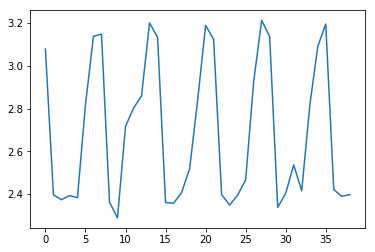

In [25]:
plt.plot(testpreds[129])

In [26]:
preddf=pd.DataFrame(testpreds,index= rrvf_data.idx_to_store(range(testpreds.shape[0]))
                    ,columns= rrvf_data.idx_to_date(range(478,478+39)))
preddf=preddf.unstack().reset_index()
preddf.columns=['date','store','transformed_visitors']
preddf['id']=preddf[['store','date']].apply(lambda u: "_".join(u.values),axis=1)
preddf['visitors']=np.expm1(preddf['transformed_visitors'])
preddf=preddf.set_index(preddf['id'])
preddf.shape

(32331, 5)

In [27]:
preddf.head()

date                 store  \
id                                                                  
air_00a91d42b08b08d9_2017-04-23  2017-04-23  air_00a91d42b08b08d9   
air_0164b9927d20bcc3_2017-04-23  2017-04-23  air_0164b9927d20bcc3   
air_0241aa3964b7f861_2017-04-23  2017-04-23  air_0241aa3964b7f861   
air_0328696196e46f18_2017-04-23  2017-04-23  air_0328696196e46f18   
air_034a3d5b40d5b1b1_2017-04-23  2017-04-23  air_034a3d5b40d5b1b1   

                                 transformed_visitors  \
id                                                      
air_00a91d42b08b08d9_2017-04-23              2.173234   
air_0164b9927d20bcc3_2017-04-23              1.431959   
air_0241aa3964b7f861_2017-04-23              2.233030   
air_0328696196e46f18_2017-04-23              1.992346   
air_034a3d5b40d5b1b1_2017-04-23              3.384412   

                                                              id   visitors  
id                                                                           
air_00a91d42b08b08d9_2017-04-23  air_00a91d42b08b08d9_2017-04-23   7.786652  
air_0164b9927d20bcc3_2017-04-23  air_0164b9927d20bcc3_2017-04-23   3.186894  
air_0241aa3964b7f861_2017-04-23  air_0241aa3964b7f861_2017-04-23   8.328083  
air_0328696196e46f18_2017-04-23  air_0328696196e46f18_2017-04-23   6.332715  
air_034a3d5b40d5b1b1_2017-04-23  air_034a3d5b40d5b1b1_2017-04-23  28.500634

In [28]:
sample=pd.read_csv("../input/sample_submission.csv")
sample.shape

(32019, 2)

In [29]:
submission=preddf[['visitors']].loc[sample['id']]
submission.shape

(32019, 1)

In [30]:
submission.to_csv("../submission/3001_lgb_fold{}_{}_d{}.csv.gz".format(j, EXCLUDE_HARD, PRED_DATE)
                  ,compression='gzip')